# Emotion recognition demo

<img style="float: left; width:20%; margin-right:4%;margin-top:5%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/AMD_Logo.svg/2560px-AMD_Logo.svg.png">

<img style="float: left; width:20%; margin-right:4%; margin-top:2%" src="https://www.paltek.co.jp/dcms_media/image/amd-kria-color-rgb_logo.png">

<img style="float: left; width:24%; margin-right:4%; margin-top:4%" src="https://www.makarenalabs.com/wp-content/uploads/2018/12/logo.png">

<img style="float: left; width:20%; margin-top:3%" src="https://global.discourse-cdn.com/business5/uploads/pynq1/original/1X/0e0d1d2f72e27740e542a14603ab56e1a5e60a6a.png">


In [1]:
import os
try:
    os.system("mkdir -p /run/media/mmcblk0p1")
    os.system('ln -s "/home/root/jupyter_notebooks/The Bring Up/dpu.xclbin" /run/media/mmcblk0p1/dpu.xclbin')
except:
    pass
    
from pynq import Overlay
ol = Overlay("dpu_musebox.bit")

import cv2
import numpy as np
import base64
import json
import musebox_bindings as mbb
import vart
import threading
from IPython.display import HTML
from IPython.display import display
from ipywidgets import Layout, Button, Box, VBox, Label
import copy
from IPython.display import Audio

bulb = ol.axi_gpio_0
bulb.write(0,0)

runner: vart.Runner = mbb.emotionDetection()
inputTensors = runner.get_input_tensors()
outputTensors = runner.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
emoji = {
    "angry": "data:image/webp;base64,UklGRsZzAABXRUJQVlA4WAoAAAA4AAAAVwIAVwIASUNDUKgBAAAAAAGobGNtcwIQAABtbnRyUkdCIFhZWiAH3AABABkAAwApADlhY3NwQVBQTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWxjbXMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAF9jcHJ0AAABTAAAAAx3dHB0AAABWAAAABRyWFlaAAABbAAAABRnWFlaAAABgAAAABRiWFlaAAABlAAAABRyVFJDAAABDAAAAEBnVFJDAAABDAAAAEBiVFJDAAABDAAAAEBkZXNjAAAAAAAAAAVjMmNpAAAAAAAAAAAAAAAAY3VydgAAAAAAAAAaAAAAywHJA2MFkghrC/YQPxVRGzQh8SmQMhg7kkYFUXdd7WtwegWJsZp8rGm/fdPD6TD//3RleHQAAAAAQ0MwAFhZWiAAAAAAAAD21gABAAAAANMtWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPQUxQSMEdAAABHAVt20hpwx/1/YcgIiaAsXQEulTmLsmXHmm9yMVezI3DJAH2HqZcbD2Nak6vPFQmuN2pc7/Otk1To+3fcV2+b1dj9fM8ZEQIEXpKK3qGnofUGasAK+DU2TMXWU8Q9xrgjMiasvKQleSwpB4QUYlb913nsQc82YUK6nqmiJgATM+2PZJb56nq6m6AOx4aBGZGmJXCONM5Drwjt/wDDrMQ5bA0tDYIggS45c6JOIHUTj/ASWFIx6WoMMAQBPUHhpIOPdPdVXXfDuuuqs8BiIgJsLRsuzRF0nPO52cGhK6EyGhwZUAQu56nmssclkaCKL0Ue2dKz901JEjWIOQ/kFpJTZ2uEhR3rkSiZxGCcCXoLhZOC6XML+LEeZ9FZOl3Tg7g21NETICf5/9cKfL/71nVhz5vC0isg5CdYEZovTfkb7M+H4lsLeFIa+AOrGW0d8DBJAhENmsyF5HC27/fvB1oMiM0mkN3necj2WxPq6s6iogJ0P/9/79HGpuz0RjG2MQmzx5IkHsykDzbJtYY5WD6La46Ol2/l2N9ehRXtaZfKzy7MDX94Mnn6zut5n673W6fXHyT68VJu91u7zdbO+ufP3kwPVWAUjTWDE++t7K6d3B8dt7tekbuu93zs+ODvdWV9yaHjTXXeMZ8SzpYLJRnFrd2T5+K8IoSLa8o8vR0d2txplwoDqbfYsx1mDHWoD8dGinVfrXWOOPl5aqkMKCQfZfm5c8aa7+qlUaGUvQba8z1lbUJ+ovlytjtpc0j9ov3Xi5P4XMplMt774X9R5tLt8cq5SL6E2uvn2ySor9U+/5by82MJMW5nvciFL6AhSLe95wTksyay299v1ZCf5rY6yObpBYAqq+Nz20ckqTvdnpehCJ8oYtQxPc6XU+Shxtz469VAcCmib3+SbfSFACqdyc+ajmS7GTOi1D40hSKeJd1SNK1Ppq4WwWANE3MNU5uR0lApT67sO1I+ixzXih8CQvFuyzzJN32wmy9AsDcSO21zK32A0n6fP6jxgVJn3V6XijCl7YIxfc6mSd50fho/g4AFNJkzZJvt5K2Dv7845wkO5nzQuEroFC8yzok2X786P5NAO3tvDbJbStp/OS7VwH0MueFwldIoXiX9Uj6v3/20U8ktW1eg6SmlfTR5OQ9QN+HkMJXTiHFd7skuX8y+UhS26T1Rm4kjY+fzwGGwTbCV1ShiDhHwvz58VhSk9cXSdLdo+lPAMuwMSuuUMQvAX6aHt2VlNYV2v1mdg4QYdusxCJ2BMD57JtdrSc39991AOHLrNC+HADdu/3NdUKSlDc+O70AsG3Mym1sG+Di9LONLCnd+Bkr6cPtyRmAbWOzktvYNsDZZPtDSTnd5MUojXb23oDDtrFZ4W1sOwxv9nZGUs43dZWku+87XMAQts210LZjgMXhwy1JzU3cVJCWfn8Vog/bXCNtRx/w9Ov7UmozW+hLevbtv0PTG8w10+C+g9nj30vqh3wW+1L9ygcNNENjcw218dBB97dHtdSPeSzW0szqJrRNMubaarzsAjZXZ6Q65q/4C+nC+leQmtY2Y63t6Jbw1foF6Rcxb4VaevjyIQwHxmbstfFgCIeXH5bqkLH60pNbR5CGxozJxsMER1tPSv1cVUXdt30CKRkzRhunBCfb9ylWOSpELe5eg5QMZqw2OCW4truoGPKT5vduQNsam7Hbxm0LN/bmlZ3ndm6BW2Mzltu4NdzamctHQdLMVgJsbMZ2GxtIWzOSQv4JkmbfPgVsbMZ6Gxs4fXtWUsg8PemOlZv4pxn7/dPcXLlD6uWcSpp9/gAnY7KhcTIHz81KVa6JPcXlPTgzNhnRxmewtxzVi1lmSlp6H5oEJjMaUgPvL0lT+aWKWlg7ZjAAkx9tGAw4XltQrPJKqKVXv4PG2GRJGzfw3atSHTJKJT3yGTQJm2xpkxr47BGpyiWh1vTGEWmITda0GSaONqZVhyzSC1rZhzNjkzltfAb7Kwq9DFJp/spt2oRNBrVJLbevzKvKHVG69B9IxmRS4wT/uSTFrBF07ltwCyabGlrDt+cUcobevA6tscmoNm7h+pvKmEs/AgaTWQ0GflzKEkGKr4FtbLKrjW14NUghM0Tp/C4DY5ssaxsP2DkvxaxQqbp4ygCbjGsz4PRipSof1FUOHth3gpMu2PU+OEhVTwTz5MZL14iTL7L25Y1kPgkss39b14ATMLDW2/tZjr9Zk8On9q3iJIy2vU8P08xG3iK5deamF5yIwX7j2a1kMeqW2XusGwQnY5CNPt7LcrxVTQ5PtFWclNFWTw7TVCOtTt79xq4XnJjBvvObd5N6lNVZfr+1RZygkdb2+8vUYyxXn2uvOEmjvT6/mjF+7VwRnKhB9Pza2KpSHSkITtYg6FGVakRVufRQUZy0UfThpVRjqUqunNgDOHED9J5cSapRVCe/cGaHOIEjnWe/kNQjqMnsaGOrOImjrZujWZrRs0zuais4kYOt3k2WI2eR7z3SVnAyB1t9dDmLUbPIzhPbTnBCB7vWJztZjJgmb556gTixIytP30wzVqo611+4Upzc0ZUvrqeuxkly87UrwQkeXPn6ZsbqnVduBCd5cOOrOyPlnnaCEz3Y6b1Rcl97wcke7PX+CDlWBCd8EP10XNTJsSJO/IgeJ/VoqJOPFHHyR/SjpB4Jsyw+EcQCiOAni8xGQZPdU1vEIoi0nu6mGQHz7H7lWrEQomu/2s188LXZe+ZKsBiCK5/tZT7w5tn/wgvBgghe+MV+5oOuyd4XngsWRfDcL/bSDLhZdp95LlgYwXOf7WY22OrsfuWFYHEEL/xqN/VAq7M4dSVYIMGVp4vUwyz5xLVgkQTXfpKh/pGtYKEEWz8aaMeCWCwRPB5kx4pYMBE9HmD3FbFoInp/WFXJPUUsnIjeS6rhVOeOIhZPRO+kHkxNbr6yFwso9r66mWYgLXL9tZ1YRLHz9fUsBtEib75wI6UEN754M4sBtMzOqSvBQgquPN3JcvA0+d4TV4LFFFz55HKagVMnj7wQLKjgykdJPWiqzO7aIhZVpPXuLNWQSY60EwsrdnqUIVvlFza2YnHF1s0vpBosVa6c2YoFFlvPrqQaKrl0YitlBltPLmWoVg/tBIss2PmwGipH9oiFFuk9GiR1rilisUX0WurBUefquYAFF/D8auqBUWX5XMSii/h8mWpYNPm+ZcjvpxkUy7zbilh4Edt3sxwQixx+Yy8WX+z95jCLwTDL3omtlCBsPdnLbCg0eWyHWICRzsdpBsIyt7QXizD2eivLQTDP4ZmtWIix9eww8wFQZ/+pG7EY48an+6m3X5XbbihLbLydautVuWHfiwUZ+94babZc1MFLW7EoY+vLg9RbLah64FpKE6590KTaZtJF14iFGVn7u9nu5097wOIM9D8+2Gpxl04s0Nj5YbXNXmMgFmnc+N4WW2IAFmrc+NPbKuhH7HIF/mOqrRT1JsYWa8Q/Sb2NdO46NgUbfPVmtnClbylf/l2akdPTJTBlS/T99EZMCPP/ocUUbez9eieE0VLrCnb5Aj9QPVIqrdymxRRu7L1YUTVCgqb3SZjijZ370wqjo9YGrcsYPRuqR0alR45ImAKOHUePqBoVUZ9xhinieMZniiNiSq+SbAo5TryqqZEQtfAdQ8oZQ75bUBwFPa3RYIq5aVhTbwRUWjomuaQ5cbykqvsU36fBFHTT8H5U5/e0zMCmqNsDltXruKDZPQaUNgbszSp0m/QcDaawm4bn1O1BdxyQSlzi4A6FLpNWOMMUd3PGirp99qZd5uybs932NglT4E3i7U6bObVNkbd9OtNlW5hSh9nqsLmETaG3SXNdFbQDptgbdhS6Kc7fwiXP3JqPnVRpj9LHnqouios3MCUPc2MxdlBfu9im4NtmV/3OCbrvGi1lj5Zr9yl0Ta1tWpuib7dsq+6YqCdPaCl9tJw8qdgtv9AWyabw24kt/aJToh4+IlH+SBw9rNgltS6TbIq/nbisukOiLhySmAQgcXhBsTv6WieZiUAn1tXvjKCZrxjiSQAz5KsZha7oa5WhzUSgPWRV/a5QvcmAicEBm7U6ckqvkOxJATvxiqa6IegDGiYIGz5Q6IRKzzZt68kBt23zrKoukN6m8SSBG95WF0Yt/Z1kJgid+PuSYhf8nsaTBW74XQcY3X2VIROGQ67erfBzs7qPxp4ssBvuU/y5aXRIT3XYczhS4Uk7i7BrAzsWO0plSXv01Af07Kn0D98QVIjBmw9L22aw6wN7YLuwPCFMhehgksvaOLPrBPtso6zPCFMlOvisrFNcK5jTojYvaoaLzZL2wVSKhv1ykt7hesG8UypFux2mWjTdrgrN+gbsWsGGb5TLaDTDNYOZqSki6e45pmI053eVSmh0BHa9YMORmhJaTYm6IZiqLSBr/BOmajQ/jZXja3UMds1gw7Ha5+E5YapGB88LyPpoXkPMP5KN7bYm4NrBMNFgbK1OWJrK0UtOlEZ2S+P3RP0QvB8jiavVE3D9YHiCNK4P9B2DqR498B0KUWVtvWKgghx4dRM2plYHgV0/2MR9pDGN9Gd6U0G65xFuRJSSfqwnHsOYeG7p8zlBFRm07yCJJ8U8eyIaAjrOI43pITtCFcmaDyOyqDToqCRbNiqwsSSoX9CLjqDnRR1JLClm2REqSTqcRRqLxQIzqsmMC7CRWFS36URL4LhdhY0jwV3nPdWk9+4ukjhSTDATPSEZJ5DGAXzEDhVlhx8hTotqiz3RE9Jjqwobx2vOeypK791rcSQYZyaaQjKOI4kBmGNGVZlxDjEalDboRFOI40YJJobaIb2u8DysxWDxfXaEqlK6/C5sOIO3mFFZZnwLJhyKy3SiK8RxuYgIy016KkvPZjmcQSXzoi3EZxWYcGPs6osux8IBt9mhuuzwNsKnS+yJtpAel9JwQ5v0VJeem0PhRo5E9IXI0Ui4Ep3GcCyFq9FRYTrWwv2KPdEX0uOvgqVr9BrDcy0NNdigp8L0bAyGKp6JaAyRs2KoAr3O8CyEKtNTZXqWQ83Qi8YQz5lQixSqTOFiqC29sRXI7OqNXRPGnuqNUxvGPNUbT02YYdEbMhxmUnNMhnmPeoPvhTBY0RwrMCFWNcdqmD2K1hDuhTnQHAdhjjXHcQiLMwqVpvAMNj8UzimiM0R4XkDuBlNdCpWmsDsFk9+07pjOz+KB1xz+AWxeCZ5Qc/AJkrwsPtcdn8PmlWBdd6wjyW+HojeEOyFauqMVoqk7miH2dcd+iDaFalPY1jcDfaI1pG8gr6SParMvyclg9ER3nIzC5GMxfaE7LqZh86p/ozu+qed3T3vc+7///u+//4+vrj3q+U1f6I6L6bwMRk90x8koTD5I0NYdbSTIeaBPtIb0DeSV9FFt9iX6Zp8iWkOE+yGauqMZoqU7WiF2dMdOiHVSb5Dr+Vl8rju+hM0rwRPd8XV+Fg+85vC/z89guqs5ur+AyW9Kd0zlBxTOKaIzRHheQP4WZxQqTeEZbH4GxxTRGSI8hglxoDkOwuxpjr0wq6TWIFfDrGiOlRDAe5rjPQSdFL0hk2GGNcdwGPNUbzw1Yeyp3ji1Ycyu3tg1YbClN7YQeFFvLIaaoReNIZ4zocr0VJme5VAFetEY4lkIVTwTnSFnxVCDDXqN4dkYDJWu0Yu+EM+1NBR+xZ7G6PFXCF6jo8J0rIUr0Ym+EMdSuJEj0RhyNBJuaJNeX3huDoVLl9gTbSE9LqXhcJsdqssObyO4wRi7oi2kyzGYcJXM6wufVcIB5Sa9tvBslhFhcZlOdIU4LhcjMHiLGZVlxrdgwll8l13RFdLld2HDGdQO6UVTiOdhDSaG0gadrnDcKMUAYI4ZVWXGOUSZYJyZaArJOI4kBovXnPeawnv3Gmwc1RZ7oiekx1Y1DgAfsUNF2eFHiDTFBDPRE5JxAmkcCe467/WE9+4ukjgsqtt0oiVw3K7CxgGLBWZUkxkXYBFpill2REvQ4SzSWBLUL+hFR9Dzoo4kFotKg45KsmWjAhsLUjxkR3QEaz5Eiojm2RPRENBxPqYEd9r0VBG97TtI4jEGj9kVDeHGxzAmHtzAIyVB6yIGEXGK+54i+oHe1S8xEJPFzb/TUUG2/tt3YGNCAZ/RiX6g9c9RQNQpPiJFtAPobaRxJfjJPr1+6H3xq0jiUqsTlvXDkhOliPy2JmDXDTZMNBhb1kdzonYI5h/JxqZWz2uI52rxHByDXTPYcFxC1vgnTNVofhorx6dWU8KuF+xgqlbPYaMjqBvgSE0JSXfPMRWjOb+rVIIazbBdK9hmpkZFZn0DNQN8o1yGtLuoGxa7KjVpCvUCTJVKkQ7qhgMVvHmBXSfYXGyWpNOa4VRFf0bUCsFnZW2c2a4RbJ9tlJUnRJ0QTHJZ2maw6wN7YFuF33lGUCEGz+6Upj16XBuYnj0VnrSzCNcHjsWOUlnS6JCe6rDncKTSsx7S2XWB3fFQubSkracMVIYDT7eUSlPW13R2TWB3fKWsK+D+jGVdsGR2/yqQ9JjOrgfsjse6Ehv9vouoCSK636u5CpT0Nzoqwo6/KelKbPWIpV0L2Eseqb0apHqTARODAzZrdWVfqwztyQB7yKr6XRE08xVDPAlghnw1o9AV6mudZCYCnVhXX50Zdf6QhMufSRyeV+wO1fqE1pMAbvlEtTo06t4/k3DpM4k/36vYJap1heTy58QV1erUqCdPaHHZMy0nTyp2i2pt07r0uWVbtTo26L5rtLjkmZZr9yl0jfraxS57Nrvqq3vj4g2My50xNxajOrjSHrjkGfZUdZHi/K3Sd2s+qpODdqDkwY5CN0lzLXaps2nn1N2fYlzmjPlUHf7bU7vU2ae/7TK9TcIlziTeVqfP3rRxeTP2zdlu0wpnZe6MFXV60B0HJFzaTOLgDoUuk/QcTYlreE4dHzS7xwCXNTNgb1ah29TTMgOXNg9YVk+dH9+nwSXNNLwf1f2Vlo5JdjmzE8dLqrpPPa3RUNJoWFNPIzBq4TuGuJTBkO8WFEeBpvQqyeXMiVc1pdEY9RlnuIzhGZ8pakRWeuSIhEsYdhw9ompUqNYGrXH5Qno2VGtkBk3vk8pY5/60wuhQpZXbtLh0Ye/FiiqN0lpXsHHZQvAD1RqpIcz/h7Z89X69E8JoUU+XwLhkIfp+ehq1lb4Fly3079JoBJ+7Xr5evZltHPUmxuUK8Y9TbyMF/YhNqQI8TpUtvcSAcuXGn8n2fpWBlCnc+F62eNihkxKFnR9W20znT3ugPAH9jw+y3S+6RkoTsvZ3s9WDqgeuhbIErn3QpNpmijp4aWtpsvXlQeps9yo37HspSdj33kiTbV/lthukHCEb/yxVtn6d/aduytLav/mJ1Nsv8xye2Uopwtaz38k8Q3CZW9pLGcJeb2WZYdjksR1SgpDOx2kyEGd54zM7ofyAnZ+9kdlQyCK/fmZnCbLz7NezyHBc5lYrUnoQ21tZZkg2+b4iZQfR76fJoKyyfF6Gni9TDYvUuXouUHIAz6+mztCsc02RcoPotdQZokf2SKlBeo8yUKuHdkKZATsfVkMll05shRIDtp5cylCtcuXM1jJj69mVVEMlVX5hYyvlBVs3v5AqQ/ZIOykt2OlRBm2V2V1bpKwgrXdnqYZM6uSRK6GkgCsfJXWGbZPLT1wJ5QRc+eRymgzdZXZOXQmlBFx5upNlhu8ib75wI5QRcOOLN7PIEF7k+ms7S4mdr69nkWHc5OYreykh2PvqZpoM5Tp3FCkfiN5JncFcJfcUKR2I3kuq4fTf7ytSNhC9n+H9qSIlA9FPM8SPBSkXCB5nmH9kK5QKsPWjDPWPXQtlAlz7cQZ6nfmXroQSAa78cp56mKXO3ldeCOUBvPCrvdQZ6rPsPvNcKA3guc92M8twb7L3hedCWQDP/WIvTYb8PPtfeCGUBPDCL/Yzz7CfZ++ZK6EcgCuf7WWeoT/P7leulVKArv1qN/MM/yZ7X9oiZQBp/XIvTcbgLPOPBSkBCH48zyzjsE4+UmT6Q/SjpM5YrJNjRaY+RI+TOqPyWBGmPBD9NOPzvvbCdAf2ej9j9J52wlQHtvZ3M07vvHIjTHPgxm//NGP15mtXwhQHrvz3m6nGSVXn+gtXyvSGrnxxPdVISZq8eeoKmdqQladvpsl4XWTniW0nTGlg1/pkJ4uM2UUuP9JWmM7AVh9dziLjdpnc1VaYysBW7ybLjN0ms6ONrTKNoa2bo1majN86+YUzO2QKQzrPfiGpM4ar5MqJPcDUBdB7ciWpMpKrXHqoKNMWij68lCrjuUp1pCBMVyDoUZUqI/vauSJMVSB6fi1j/Opz7ZVpCu30+dWM8TrL77e2yBSFdLbfX6YeY6mTd7+x64WpCew7z24ldcZ51eTwRFtlWkJb/ezX01QZ7cvsPdYNwnQEstHHb2SZMb9Ibp256YWpCOw3nt1KFhn3syaHT+1bZRpC296nh2lmGf3L7N/WNTAFAWu9vZ9lpsB5cuOla2T6Qda+vJHMMw3WVQ4e2HfCtAN2vQ8OUtWZDJs0v/tjN8KUA2788e82aTIl1snBh24QmGYA2fjhQVJnWqyS6j0FhOkFBPS9KqkyRf70P6ooUwuK+o8/nQnzT15pjzClgPT66k8yZVZ58++UXplO0B79uzdTTRmpk/e/1g6ZSpBOv34/qTNxNtn54MK+E6YQsOu9+GAnTabPXtDKPpwZO3fY+Az2VxR6yqGh1vTGEWmInTdshomjjWnVQZm0kh75DJqEnS9sUgOfPSJVyqehll79Dhpj5wkbN/Ddq1IdlFWrqIW1YwYDsPODDYMBx2sLipWy65S09D40CZwbDKmB95ekKeXY2FNc3oMzY+cEG5/B3nJULyrTVtLscwc4GecD42QOnpuVKmXcnnTHyk380+Off5qbK3dIPeXdIGn27VPAxh7vbGzg9O1ZSUHZN0ia2UqAjT2+2dhA++lvJQVl47mdW+DW2OOZjVvDrZ05Zef5vRvQtsYev2zctnBjb175OUQt7l6DlAwerwxOCa7tLiqG/CRVUfdtn0BKxuOUcWrhZPs+xUqZui89uXUEaWg8LhkPE/z5ypNSX/k61NLDlw9hODD2+GPjwRAOP7lXqoOydvyFdGH9K0hNa3u8sR3dEr5aPy/VUdk71tLM6ia0TTK+vhgvu4DN1RmpjsrisS/Vr3zQQDM09nXExkMH3d8e1VI/KpuHvqRn3/47NL3B1w2D+w5mj38vqR+U16eCtPS7qxB92L5O2I4+4OlX96XUKsNXku6+73ABQ9j29cC2Y4DF4cMtSY1u6GOURjt7b8Bh29irnP91GJ7t7YyknHWDH6KkD7cnZwC2jb2a2Ze4fDbZviMpJ930J0l547PTCwDbxquXsW2Ai9PPNrKkpDXi5v67DiB8eZXy5QBYTA82tZ7c/WZ2DhBh26sR2BEA57NvdrWuTJLuHk1/AliGjVcdhH4J8NP06K6ktK6QciNpfPx8DjAMtmGoINC2CvPnx2NJTdZaMzWtpI8mJ+8B+j5AhgdCv9movjiZfCSpbZLWn7ltJY2ffPcqgG7d9siQQPp23an9v/757V+V1LZZ61I7mAK4ef/R4zZJdjLnhfIqIBTvsg5Jth8/un8TwFQ/qqwmaQEA7sw/bFyQ9Fmn54UiLy8Riu91Mk/yovFw/g4AFNJEJdamNwyASn12YduR9FnmvFBeRkLxLss8Sbe9MFuvADA3UovrW5OkKQBU70581HIk2cmcF6G8PIQi3mVdknStjybuVgEgTRODa1+bpBYAqq+Nz20ckqTvdnpehCIvNhGK+F6n60nycGNu/LUqANg0sbg2tkmK/lLt+28tNzOSFOd63otQXkRCEe97zglJZs3lt75bK6E/TSyuna1N0F8sV8ZuL20esV+893J5yvMhlMt774X9R5tLt8cq5SL6E2txbW2MNehPh0ZKtV+tNc54ebkqKSGElKvy8meNtV/VSiNDKfqNNQbX4Mbg2elgsVCeWdzaPX0qwiv2xckrijw93d1anCkXioMpnm0Mru+NNcOT762s7h0cn513u56R+273/Oz4YG915b3JYWMNlGJhavrBk8/Xd1rN/Xa73T65+CbXi5N2u93eb7Z21j9/8mB6qgDVaPotrjo6Xb+XY316FFe1pl8rfKsxNrHJswcS5J4MJM+2iTUGCtPYnA3+7///PRIAVlA4IGxTAACQnQGdASpYAlgCPj0ejESiIaqmJHGJiVAHiU3f9+zP7qyCyyAc+K61igA1X+SvV/kOes7WDcd+Sr/nwNSdf23b4kv9J+SX9w/cH6Err/gvwD/ZP3C+7j+96K/Ff8Lz0PPP13/jf3X/O/+X/KfLz/u/7n2m/pX/qf4b4A/4l/Kf9T/bf89+zXxm/sl7/P7//vv+z7BP6H/aP+x/iP95/+vmi/137I+8X/G/7H/rf5X/VfIH/Zf8F/yPz3+N72H/8P/0PYF/lP9u/83rf//X/cf8b///RJ/UP9f/6f9X/tf//9B/86/uv/j/P//zfQB/1v//7AH/I/+nsAfvX7j/Hr8h/g75ifqvyV7TL43BI7oSdbs34BH5X/SeBH23/e+gv7c/Vv+7/e/Xtmv/TuoJ+u/jo+Dt+L/13sB/yT/J/972df7v9rvQN9Yf/L3Cv5p/Yf+l60n///8nwA/cL//+5v+vn/R/P/+AD2o6Fwj4Fjd/ANyCGgS8Bxafo+dvWEYhQEERFtoSzbzYeOrxCKPVUpJY4T8kglHQuEfAscICt1Pvx9D0ixOrAg31Co1/I0LXWHEpiIcn9M/8iKt9zXNjCZRZrgm4uH6ptdMSb2B8QWwbsAQj4FjhPySCUdBhJtlPDUrYzaOmDxXysllTZa7n992s0x79w95xmgTI8IOV/q3/6dTMcb+mbByDzrmRwImfeNbaU5CBcI+BY4PQPIIXXrMiuWQAxU+ZWkr3ssuSiYd2yP4K+r1QK+caz6t/hX4zDYKkL9SzfkgqttjTQ1p6aQrMSE2/r/IXUyzglA/SVhn08ni9p36LE5RGKX+Btw4eIOO4YiJJZUEfAscJ01sVDuS+uz55DZavuzQPSH+a/0v2ge7XzCY0/a516626IRt7/////jpq5t1jNDPVQaF0BAiPyaXxUrTncTu39Z7BrH9l2bJ0DBTt32CkEo6Fwg3OVSGAD7+afQamu9J/Qg9UsGKSarxMk0ka3p6XLGyY8uu9PZyZn/z3cT1JQ8PAAB+W5JsiWskdklCweyuGj8HSjeftMx3UdpQFIETbj0mllQR8AzlpRlDuqhduO6hdLMdkxlARnDrFB82FLbY+N4rmJMHYX0k3TODGLQZB79WH160lwOt12HZTSGMq0yIP99RxDMlFe4H0UHlnb3ARESCPgWNzlSSNWX+JLRHq6mnyb4DLZlGWaOiwT1Hgi0nMYWH13yJ9d6b+1dud9MAIIVmvUoi8OyVIEix8lQ5t8nCkKLZmwGYGzx0jEItVm6m9SLsWeSPn7X5aKTKM/o/z1fDl5uFVqWOq36D+PMJeoC2IonuRfhPzPbepQ6bPvRhlPnJOfKRkx3RLtxHliZnY2uTxHwWUdXgyVTRSTn2TaU4/fmCRKTukRZvvaX4l6/T7fkG78lmiGy5JmB75qtw2MMrGOh0zErKAF5fP////pxUuYKX6SYVXz7xYpoIrj0ptQDX70fW5d8wwiq+ITmIgJ5eoAYiaw1YhhUoyjsEOzwL5A0gHEGqa3uWIiJDEmXq8/lhfNpzPwzaDkavx2wt0N9mwxi4dPZ/ECGQcq+S8MfZEm2XeOng9ay+rgGwGVkSVXRbMxzGLfhRRgBeY5Uh3t3yxbAJDonq4OAbuvdm6eeb/J+5jAIFRklRSFHwnR2miKPujimp85c4+rV4V3kdZr0wIvL/1HnW4qc8KKfDxx+Qqy2aNgMmYSQG026M81C5s7m/GdSUBht1pzQOPEGlnRRmZTfJEZ//svwDuB3A2P9g+F0ggUB7xW7hxPSYaLf5i3qx2f////7NwTw1h+U8tPlmlWouPAS5dFJthwyhmEAEy/KI1GEnuD9FyISAh/o5l9U4hpu5KqlOI/hivDpGR9P4guVOLD3yZSHNVlT1q4Bq9Dk3niiA9NLv//4W6NeAEbcPFMxRqfVkN4wURb+ka+ZgTP6pcVpoERUHDTNuY8TcgNn1ShryEoKLm/n9Ut+/Fz2OZxh5Hj/d8OwB6ZlSEqX6wdpVEI/zvHyUnIBhxpdIQG7ZmgcT10YHM+TpqYqCJlWjb+LzFizI1xeOTrTEWkSmYmKIuRwmzL/7cLN0ragbaj+1MKQj4MaZLKJsHRrwzurZpFPh0rRq3FVd+UyaSf7lZ/YZX5RPQXSzGf9B5yr9oexnU9B20QHzsZZQBVnHLvSkLQZ9lKypyxtH/rCwWTGZOrGGDtA88mGxx/FGQziNL6rlGe2nQyH+WCr7OKj+4cpdu7pRnpjTyF1GuoH/lKttExOCYZ0D6MFJkcHUv8UcWSD0IEiTLdGY+1Tmew4oI+jHH8RXaO5bUWSIAhbVdiNf7NK4/tKcBtHVekMP/q1mJ837lUw4Z41PZ4Xn4BPFaLL+srA40/qHrgem+JTlq/nv6ok/wYKkcOUGpzi4Ex30svmcuul7gO6Q4ai7pgd/YnPfqTZIKVUTGh7Tx+DsgD/YMF767rYDFnJ8oyUUE6D36QZisTmcHMPfp4+yl8kR46k6U6AEACn1Q4F2D54o8x560p5bu9WUCdfqeN/OgrV7rXq42MStzaOH/5zVt8ycQxeufxh8SYwL+p38a8k23wSdW9d+WwqliJGEI9+JOv705Z58YrxexPv/1E3LbpeKRNZIyEkuENLs/5CM70y2L8sU9K2bnp1HC43O8ob2idSq2NkyOSvTX04sb+J/WAHAxXTJZncBS0jhaKWkVQzl3gJmvYRR0qtpLwnHLHpLmjk/UiWBD/pQEb4kIhcek43AAqdQtM6ISLHME+0bgQ0q8Tv8cixDIGicTb7OIlZWi8IASth2c4xFRrp8O/65ZlJo4MxPuVZ6YlQ1/YeU4ivx10ybOmtKkH/iqdDRvTHJIIZkj0/jn8WJ4ge6Hywuk/AWq5HV6uxtP313przOxW1rdNHkZQAFLTm1IZ7eOp+ISC+TmIV3PVx8Aw6nEv2Q/BdZKNRiZaGL3A6yRh+aFLWWXN2bBfK5KOtR8hZXk1/LedD3CIAC6xPqdovJ9dNfMxV33cxyaqI3RvOEZWpSU8Q+393737yI8WGm9bZZEev9gNGdn8dlaE+tN+nCDUKVgIWAp9FZ2HOLMiYI26nTbzRLJ/mwh4r57QT/jnZ9RHMDA5bm8N4mttpXPeoxddLA/bM71cT7EKCv/ikF9c+bBHXk2VLAdcf0j2e3DVAtDx4ch/9TyjK9oUTyl/2YzdAooxbDva5JY7a1Issmwmg1Go7Hqrt/+tnDs8t9x+KxYNenGDetWA7WCRgdtlIugjCmf75jWx0gu1kicPo4bLSIEKjxo3UAhjomqfGApMviwGyFGpTF5XsOtgUH2/rGnHNOxZzrbExBpk06T4BxIoIR8pt96zoTgG2U2BevyVbSQILKdD9wBG/yhJPO+7WA8PHdQwH7ew4+E3dZuY+1/YsEWtzrY5r+bNRJyLHYXE2v7ktNim+UP1kkDuJNUAEnCQipzk8P5mwbGD7us9LRmRjq5NJAWMP9kmzFMtLaOlWZ4flzv3KiionqiiavFRkQu413a6hCB8hu+y/FyqX2aH7cSFbSOZGNX2mGW/kBH3Lv43ngxpfrq3lY7JReI+VMScCK36xVTeFYLdYsGo01AL6rogX+dUqNwirMccaNJAiIevaPkD1fX4X8WSoHwXaSsqR4qq+fNDMRlinu8BW01hHhfX8LnhSqH3SOk01CqVT/Gwq9GMUyHfPUHBj0mOOj8OAfUBsuj3qfCS7hv/1z//Qe8H25Vwxk9wAvjf6Nj/4jgAE7QUwLH1HCaQqxA+3nC7hi8TVltZh7ngh3tNZaiZkCeH2Inh1vVbiHbdGeqKs09tuDCtCeqicT96RlNbn4OQBxY8mud+2W4q/STeVnwqHNVpEl8dIzbGd5NbzLLZlATXDtyDEf86V/ardTm/1mpm3eVyDd3L/kOchCHozVeIKfzZlqEyjqCryEJ93qaV020p8bOZF98t/OuQEi2JwAU75DIJLQu4a6AYGEvLt8YWCntjNZ/RdB4HVgfn7tHr3gvV8jS/08yVAzdLeX6wjwveSjJ64dC33PcAmU9WYmzWGEGMxjcc1DAoIrf2NLfdF3lxGgoCcEjvXn3OgczVNWyvtr0TmTlrQ4rdbENx0wbnnL3hAtmoqzT2FsqKrifkI+MywvojyT1zc8L3tAqjcJm5w+Hi4i8P5krWX6pgL8WRZm+9Uoa8u/hSuGlZF9/5JUakCPmxwXhsHUf48kc4NFBV4XvJRk9cOhcI7gWJ43l3WV+scJOFCldtM6jNI+satFJBPkLOjbZSt1tC54h4k+kalSmqpFV4n/g8ubCx2Zz5OKwrtZUEfAXCt3tMp4dyz1gLIxjw5cD4NIkqZ5KAi9c1UbUFLSWDd35asPTdGw2/RVONCplI5j8du4alEXluUYKsdlfw6Fwj4FjeRaj0wUkykulqIvLcowVY7M58nFXmAD++ztAAAAANTf1//ymf/7SF//6dgOW+PLl9Nbh0Y7+SCoT/GbQVDvGr3JJc0gctR3kRz8v8O5pEHTI+o6wz6jrdJb9PVB2FBjTm5cQivQKbVMbyo2iD4HYJ2CWdLns6MGGNOidTEFNeMPdfvYL8Twjs4lMgpko5JhqDZOTeYcj9C8nb8DZKhiqNH7vvMI1y7oWkUk7GHCw1ho/0htJZ8T/9Z6YUSbUb7UDCS2gieuE1BGB1hDusNIjIdEj3vWOvjR1hvG4hD+EEZNKKfnJunKf50P5d6CZ5J+6k4e5T6drjWwIjwoYmXYVlrjz5h4x5/4wlhUQJCy/1E3mLQtIpZqNJ+Yz9C3T0nyLpvwkzmCDtyxluQBKaZUw3aJ423k+6HQAAAAAAAABx9LbWnR2BkGWElURALsCLrUMx+FMvzI++r0d2YqyBVbFfiRCbF3tkLWATOrQzBeVGka6aJORNCF6pXhHc0gGC6+sy6SgkppvIlI6pc5dRTfDBStFy043D3ZuWZBGK3+qeM4qTtS1YxqRLeb0ynJVKvxFtf2SAavwXCWjgk8UTVzeQZtAY/p+khSw/xT7lD6Y/d7/9+GOV6K+aqttuh3Jw5+6oO7Kedmu0Luuq+MYWZAtQvpTs/ABoGBUStRfs8w4i3AYHKXlZUgVXUhKT5RWHmZkqmYVsDVj29iWReoGf3FmbkYw72cQhy6vAqPB2qPH0l9CJAAQJUWiqTFtX7/NaFK6nJWNEkH1amdhWKR2U8xcnfsdoIFUM5fjM7uLSEbr4n+65+HjdWr4qm48CntzDs09LGdQIPhtY1ywodc0OTKG46czU+B39CGEJOPPRcKYm7CgMz8VNf+76y5Z0T4MsnoUgXlxatPw57aQat/Ka7/8geOJI3dDh4gmWuTuJnWTAA9nLRXiUSKg8CAGQ6N9y6V39IdpB4VR7N5/hbJrT1PQihgQ3VBzcZp5IUMOUd7KQV8PhS1Blt89ot/qRGhOfsYVcflJIK7543szM/T5UsZOjYTA97dEQ0hv56jiXVhLmLwGNNROrVfXR/wIH5+4DsnfKLHMIlFMhWeZ7JXwjuUgNcXBT6p4BFvKJaEAAAAAAB895Iw6eS8Xgb6vQv9swb0HrWIwRj85zoaTr0wOZfvBXBJqFoaIZrBzVQLWEgsqU3aHvqWy2EwuDsquSkPngfk/6CNOt4R1Rm6kWL/sM5DUDWpwGlIrWuoSVYj3B4E2fWGvFhjm/VQq/PHJvLnxhhOJXwg4p3+61LP5ox0tWKB6Gxbkmlz+SaBEV9QxjySonYBkNuB2NGYrmYWxFCteiG2SMkqE7Mx/j64Cja6HQG12h+ADkf3fTzzz0kFiOqIeRXTWoYvgArOAfJ2Zchwz5XaWhTg0YK0mQDFidteK0yaQP/TPqwaDSt4v1+DWQoiDNaFQ8kOTAB+qvBT9KYo6MTV9MAv1nQ9hvVkqxHqZV0S1AtFsfNeDWx2GmPS7s0mQUDUruNEv1n6EzGroSQjwU5k/ZXh9vLs3A0HuTmiNXIfCSIo9yHXw8betOqBQkgjVqd9qgFmTOjyTSiHf3QdWiDOGBa9smx/LDLuNuiAFv/0AI4o+64WQEOlll07QlQSMHYlknt7RLTCudbsiGv5MEKIyPUxgAAAAAAIH6sfholjlyxPam2of0rBss7OU03Dm3YsLun8VjBstxTagfvl/qtJv0WJvubDvsT4bdS4gc6XXy7/DFr5o4pzz5UnaVFM6QUsK3x+fimvICUsYn0jQSUDbc5fJNEUsZ2Rcdh1vEFZI+7KjYXfXnh3cW9QdRtuPD0WoQVfG47V8iWaQKX6Bdq8vxSTAghIThmBhXgbC/bmA0Jp8S9lxLc2Q09ijggz7th1uA+oMVkMK0Sx0Sa+BM0HEr7U18TSQNR/4SUIpY/4qk7FaBc3PY2vcYJ3Et0cjjgcWwDHnFv/BN/3sCjPwNu+revlMF4Ne6e0Rt+I2A05xNCEt3Aw87l2Z2nub5W9luejKNCvbqGR2yth0iZMdIvK9GzCoXKoY19mpQZ3YBOCfFBw+Hh4y2lnWVVI8uUXzf3kd9udnRjdImaPzac0DnJpJAU9yCR6JK90Fh5T53Q2Ofe5v2BXHbSYtJiJUnPUe+QvnKV2sQm8Gy83xoHv8XIFtkIDJ4lBxcWvkCLf/jRvaprjVQSK4jOpMPDxEyxwyEUQFfTwA62dfWEu2fbCSKH9mngsI5L3U4QP/+Dx0iuNbuSfSpws39ufgy6EoQ9AhBC5H+w6za5KfNkpnc6CHU5//yvLH4OqsFnA/+mcBw0x6dclJTlvp9pH9RsjE2gNaZkAL3XPxIdG2yYIoULLfnv4diDpEriaRnIIWKdXQRAgELAa+Dz3dRZbwAhfyYZME54g9YNjNYZcsDtfzsXl4ldmOAbYZ55ARjxGa8icq3wZsQjxv/axXJC+/4n7NWZhpcxR4PxPnHB+MatI8vMtJ/VG/mF6eK7kjulQHqfVW1/mpxixtzMCVkVAyhITeTZH2gO6R0ETcqhdycDG2ndwVZHOw4vnfnCAmwJwGAAAAAePIjGeHpMG8r1/S65xX08Zh5l6n0O06DyrySAAxCBxhMi4c4Ilbl8V9IURKPD8k641xuYfPXhsuRLttWife6nAdTgljV0DD/miPBTR+qcqXnu3/Q1pD7JZ3ss1sEMK0cawXYngGfN5NaqW+Ig7vS2LkJcsi2gdCiMqPXkI7cYth4KOsstfOmR60BMbvxc1FoJvB/pr0Qg/yLu2EOcyyMJTr5VQWWez2EdEmbRCFTaK3d69MwEVqe6deydekzmQEnNJFFHn4tpy8DlVYSexca3ruP0LyFR3Drf8zCsL1AUAz7KLbhBTpDy8FS0ebrCLoCTxWF+sdReyGUd4HZTeJISPwBjFSzzZ9hD3i90sl9oGqZTSCaAsCp7c+QGShR8ZrITiMNAL1L03t5VMztbwD77aQMndtpc60leuVOfdbtbglTAQ1ZvNX7v3rOt1q1HkxL3aj4YujodPC5ipapqlATvfEd6uCZYNZLlbKsQoe2B98AaqPKf3diaCSAolBtc7U3G5bEyP5MD3MO9Y32t744sHolsz4tsx1ZSfylo0SBBDI2VYqiM2/t/ytkPF5Z7k91cOwOEc9XThjZyuoYXijaDppiJqfK6ZTqa3iDZHT0MFTTEALiVilLUfJwCqVDauFnZLhVNEKS7Oux+EAAAFpsRLJkTaZtZV39kt1yebyIBrWvLp/Bbt+ngtQXHBHOqZlEvpcpbQRiXwAup8QSAsankOFCodI/JAlA99fXTSWXfiy1QnN3liQGu0iEdYIWwuEgDy5Hgsn35wim55joEtZ32GFORWoNIk9NaFv8/rfoPDnVm5uWM8wazu5K049KBkE5pfMs/Hvrsy+MhiGiBpTC7JMUuutb7JoaLv80AqAZ38avJHERHrFvSwWLXjFzoPhxq9hafQhMHAUauMLR8yOpS4Xqj+/6+Ty66ehmEw4MkyHfxH6z2Kz4xi1FJYw73h2fWzCvUiILUJ0xREtttZYBPw6rOpGeAyEPXz/1DTi5GIDB+warn2R58LvJ0MR9KLYF+Bg/pW7Oo2PDXFLMb96hIvGDO8ERb37+DoLOrzWUJ3AodQk+6IYo5/WqWLL/4BzWFAuXhBt+rNZ65ohBkTJmv6Tw8/DdQoW9emzI00joVgHGLzSCpOHlxKzlSwbTA83CRtLJ9XlfqwAABLJRbLdOKxTBjF/xPsVw8M77dKPo1TEL0QFNEBV6OluW3aBBiQRdvAIw7M6rMRnnPS1Wi/VHf5+9uXgHfLTzlava8HQX98lzMwEyIcJv43CBsoi6ImHgLRo6GuXYwib0Eo7UO0f/MylFJFOdZC/3Hkb0efCPYh6hBuho4uLyvPq4iU3NiwH9v0HtBmybBlSWg7eDTU7V8DGsfBtqCpo8F6BCaCCr24mFOAoke810AB/HtOLwWTBRrKLMBJdv0FYLzYYKL5KSH8jHWJJZYHM1rFxqXqN8rzWxneCL3D8ZUqPCk9LAmMkTRIC+lIyTxHCXKt6SORpeFiM6aHeLTlS0l8fPePxmJe1dC6FWkg9Qzk8sjIDnvTRs6glxNYh4RzjWwLRfHVQibVaR8+tbzFe4xMvuzAUlV/6em3kRyZwABj+DBcVMKWkHme163vPmXqfQpbo+IvvxfIGWar1LzsnDZ9eySc8KTi6HD5zescHCweqnwZ2srPJv3r+rPCaDHOnOgb/oeG768KHURyNf+aKdXqfF1a7F/J1zy/wR7bPJ15v+mUHST674VvZRb4J5Q6KYDp9KhRHEqvTarUrZ6loF5kbNSRMxh81ym1ayXPRkNJSP+a1D7x6RHdD6tv4eAJz9JXDmLSDtZWW+laZv0AYI9XHkIjje4tAyo3yl9B+z1ldL5bVT260iFvt3fgSGqkwNGudSm83KSLTL4IFAbspbUbtlOzaCtnKwvkdY8EChIfFHkdQw0FDptFuhxz11lMqQeTJFe6wnYUOR9czHUL5so8Lu88EM3BljHb5/t/DdcXdpzI7PrhvVAD93G6TLQs44JDldAq0iKljl6gUa5RLEWZVccmgAANP4CktX5i2VS5NrD91An/fibqeeu6PZAWFrPGJlrgrBeUtohGTO5r3Qz69Z5G/TY5N60Kas0P/LJsn2k8DgsdnjkFMlhmEDqZA5kauR7NuiiBadKbiD3jvto6jHK888uGFSWLZVWbSI+ofAvFPzCo9dboeOmX/C8XMF1bPKoguxsnCpVRUNFk9BXc7P0p2wfY8QFFb6V6iYfbUakeOG6qVfQIdo2jVNLFtsUSJALh25e1KnoE1L6biB6GnDDSvm+XT7X46uCKG2K3GHqxTWJDqyj2lEeZawIMyTkGT4amsj6MnM9xIDSF4Id0QYpaXuzvNy71mj/+twPh0RGehaCl4P1RW5R+XvfGE4IYtTYf03Bk0VvPHD7nLSaBl8ewnY2mkp+u1IzNYaXKySKqTMdVFPGnm+1qd0qw9Xo2m3tcH238yiPxy1bhiTTp5bNbFdmNn4cfXplDNku1CQ9mv4zzRTz6JKaxl0AAKT0wOED/TLn+nqmqC6txptwgzrcnhgv4RQrKt0xKAWR/MccUrxvgSKiOc7h1dwbVEdCWOgXpfxg8DspFXrQoXVUqg0XnN2Lw0gicIs00GU/5SdkpZLMk0XwSLSFIOHoXKGQX0VhSCzEmilgEgqdINBVWjgPeU1C9yPucyp7H2FZFJtrrq4c0a+rMxRLHsEWf9VTn0WK0OMc5h5IcbIZyrb/1YNQUKCO6jbIdd3DS0REGAzbWteeFg1HVt7AiefIYTMH4x4aAm9Oy8UaklKUVUqRDP/D1hDojpqzzZ3Nqps7nRLgHmq+F/OcxnFT3fz1cyzRBcDituzLwFQ3t+pihotog3Mdh1HQeuoMegm7jytN4BQrngvLRogpKiB7byAbLpMovE5R2eZX/rcT/9ELbLwZM2rGaOmOZ8a9UGxszovTwWhJCvKEt+O24Vl49CHwsw8rNGBmPP3h4YANsz39kKtfIAnXPun/zo9mGANISaNr9ga0CLuhHQOuUST0Ss/QDuNlkgkjcr8hubbMTlfC1BARdCQTTfWzoGfoZb8jozYJ7v/dTi0Z8vMIEPSFJPJ/t8UySF8KiIWFoOplW+CZNVrdxgfIUIGtC74bMRq43YDWjwjwyFYhbF5l0U5T9HVE+YCa9lQk8S0SaWKFpdo0D8nxIRtJV4bs0CjBSjAhFpppaYmEzdIzC92rVR5YxItO/xY4IOaOCj6hmhUPEow2k84IjePCAvMznvrst3G1YmXeSYaVwMiwApcxb0gp/MPKx6mH7nl3fTCoriUqBLvFuM5Xbr9Iuc2PxnHzZJOEJmjcDmzT57PimbZkepZSv9nzoPdt9wKxa1HUiMGWhsXLHlIeF59x3cRNpckYfYef2VD73oKnEALJmmyzccDyUFpQZWiyqdLg6hATqjmBu1FA4eZ/sz9v42dA5FxGGIvH7Pu8B3eTc/MknfMRE0igUC+28GlSn0F14uP1cmY4DKo77XJvQhWTql7YjYjgiWbcub/5g6C+je5W/nUJHkvLNwKmOg54pNclLDuXaOqBoaKt0MZA6w03yOpeGTFLHat+HNx6ju+Xk8EHzpSr5Xh5M2+yXHIQn1rf1CDkMsAvX5OUMXLngwg3U1y1HBssQPBD+h6n7dhABQdFeIrwhhJlAXuvo29NzAdqnCk50QFW9WKcXTC/1n8JMidCxOsH5eyO4dzrr3AHlZi5pP8xhMsp7yq2fuDwsnXz/48eWx6lt7wfVZwDzz88SU+/KudSxcomMZNH7wZUhO5AgxeLSQxozuo74er+0qq/A2cBMIiGGr98UDqWhKTy1YjxOKjOwkI+XGdcILuTEUz2imd3V92It3uF+UsTRKFsbvsOqjr8xH1eFoMiO9gJT8PcLwTqb/20uHPjUTVkC8Q24tWCTlYRZA5bMaAh24fnSLgMQUT3/W8IEGJIglFF2eLsPSwuAy4rTqtlez3d9gaR4yaJNtyPljpuQiTenV443B3WJPa+G7OQTCM8m/YMrE2aK0QLmol0wpXee0FdXq+SvLnHb2poVSCdNAKPGddkwjGpRpoiQdxLrR3WvyIQy2SoquzQ78etntfTXXP7hnpOH8nmVQuIEX5oAIvNifdgdRXjgUQuXElZQrZTKkklTqZReu7CeYT8EF0S+LGofLi18EWOYj3s8ZZ9kWs3WSnJwxwqpO0NilQc/oNZli6lytB429/YdlrjDrUFQYrhIJrtYmnnkwt3tz4WtO1pRhec2INWYuMfcPNeU8vq3j1KMqdDRkfeXq4E279l8RGllUCq/fSnyV5c9bH18lRHifDbgbtzkegtlWAPmu06OEiTbC16phrJBXUBptbRFviJpwyF5zwgWuWmdeGYfQWeIBG+DDVbPQRG3UpYFkfL1L3XT2czlwcJY+LrWDh/uTPugB9p/epIl9EzJPB99bo+IrUJ6fpmpFJpG8yVDZXptkaQLM6VOKydYl1+g1OZdkRs5QI95K97pBwztWGu358Qk+n/DPa9PoZ+59DD9p8AQD0itoPfuHysT8HeoXrHtReYWMhI8/dLqk9PXKMicXDrau2X4SMLxImRfzHZaVS+8+UkGvx1VGlw2mqZedEMB5iZ9yt3eAe9Q71t4VoI5qT3C7VcNw8fb6XwcGhtb/VFRKlpSX+X5GEyikNcwxBphw7xORNZAeooGTm+975F20HbvpVDEBLv65qkDmUokCnz7428xHv+1cWVt4dnLJtOvYyqUjjh5lbI9XYjm6/dx8rDu+jtJqhXrkveBoWOS51C7sbYHeQ6hgxDUjk/LO/KEAowHuk8X1qhRl7rHMG9grLO1scGQyKP6sIIv+7doKatYcB9Y/nHSBl2OTCbZFo9SsVRvoLHa+nxEgW4/Klt0HsYvx296BLsMlN4km95vZ2TNqCLl5gQca5HW2ijygEjL9nUTZndIYqud1Kt+5O6U/rl0Nv4C2toDRU+r5ybbOTr6dUrkOTWyZLjYcOaGqcX6CSetIhqCkK3yei3zPkhRvRZML9poBxgNzosBM8SvLSwH7I71qTjjZq91k05Tj6yEXoG4Lnw6s8N8DQiafkdBiXWNtv/3yoFpZnFAzrCvgGmgPSVvQTqODo78R4/BeF5UwpKa8UJo3XtplDnj/gh8b2dyRCm3wmBxBFUIq1ciR4/1dWaNvMbc3aR5FSBVFk2lnXnfhMPcN5P/dNitp5uZE7YNmrRYP1quNr5u13n5ZssaKIXzsR1X4G8cMxNh7zA/esJD43HtxZA8MQacZo9fWSyyYBO5EjvcxrXz3OuxAQcjQW5uFwdMbtWjE1TH39nsPCRtPIFn1SzKZbjfbMQrUKitwHzZWT7/8ly/SED4W1GSe/xOO7lBE1Wx2mDp7seKRcRvRG3+Y8KvONf1swSVmSKtKS94HuW9A21jBx0oWdcT1V6Vx37XIJvpPNvyBV/Bk89G7h+NjrmdhTHIvyPq8Jn7iRS4KhZo+Ew4AuIj+4fhhk3e7B6GH17IMPm0KAXTU/FL5u2P40th7ZE1ujwkH1Eas2jPofrmSplUpSBZCnMpINU8BUzriTNA7FPup5G/vxX+aXrh2gZLimcpSNkaUYQoPzJTS5DP3QxMTPqG9ckkp7Ka+XYU42W4XeOJonjkbT+HtxJnhsdPl7u9PjP16vuQus4hFNX5t4XxHMieB1hyNnMPsa9cvSk9iZWO+FYXVuZDt7pRFcJlwkrepaEBPLOpMXGpIX4DBH4otf+rK1U2rl6Hw0N6yVbBN/68SzXkOHzocJHpd/VWFgVKOlTIA0WBEvMLEh9Wv12GeDvvv0yYLl8c2/DnuS15+QQGfRshpdPphekRBg7jguQrA3shWeYfo3XATEyE1kbDIdXWGEHKWTcu3/hu1Xhb1XmkDMMFI2d4TzK5HW0/tP8M6OcnsVXQPIjFKgDLmSokcLpDGaI5iTUpbyhyWBi2l22YWrCL4v7SMEb0n09tBFAq67c4fW6VCRdoI7i4cDSyGyA/FKQSN4JDts1bs3TX6PckOAceRQtpmFf9he8gfqSST0dqka3aQACTd/RhPXk7KYFF7gGNlQWw96MddSto7MKC22zu6/c/R+Ecvko6fY6H/mkyPBrXQaI1+Vfg3YNZsztMoJpBArS1Z0JiQyCGhS22RmGwrJ2zcRjxwwD/u78++JBBmRKyO/jeEYEreP+HsxSvjYrLeQhu6ppLNU7ykg49hAAB+GcIGJofvm34/L5gul0XtmX3v4FT/kTUVinVW8klxi1S9Elerb7yHzbExqWGUT7JCB/5ademzGA6bek9rGCjGjDg2IVCA0o54MR58n/pz+H/p/SpLK4/6rdUWPfzVyDHTKWZW8G2GAmbs3De8T0sfT2kK9+LjtL3mcaud8m9kQ6829R0Td8D2ISDRHnNM1kFVUL1K3kQDlyO1chWDPFg0JrBYlUQrbeAtlDbEYQEiH3ym84FMUw/WP5GdzAR3lK+FwKNWlKN9ZvwmvEXgrAR3jLEOAP1h16egYtqE0LG/IEKIDpi+aIc/uptoGTiIM39IuYuO54CuS1I5ya9Xg+G+V2hWssslvPfE1KiRKfFnFwj5DmxrrLy5E+WO+m7uE2Z18nytFllloL/uxJm8PyzPrkMFMIW+dajFF/mkm95lhyZf/MgmYjoOC7l6sH6tbBqG5EMA3NB0anTmL63jMIE/Lg5DL1xTmKYwbkhWjO3t5kRO5s/0OMWCl5IAKEC9wETVA2O8lS5WoMucYIlNwgvdcm3l55OWQX+fflb/C7RoYpBksMTMbqs/CHP9DbrMxc1WH2dnjRdr3FxR9wYRQ0UaTrvQNpNZl9ubPcB74qbLQjZNroFQlB5+eSyKQZTtYaRV9vbLFzG/ED7P/p7L11lnkQ3ISZjV/bLFPhOnDT/8lL817A1THKkXPGbicXaipGc5jtmjmSq0creYezmU97Y1Tq8XlBQnavkmJseqGoNW5WgZLagqP5OeyEeNk63atYIFN/NGNPAmyQZidGMFa4jY6bGJTa5k/cfQ98YJ/pMYB3X+2i1+v7cAf0ZxXiQe0GdxqcJxiPK8GGVrxZ4HOV0kesIA0/gGV7X1CRaIb4UtcGwDUWoeMuiBJhA2Vy14NEsMf0Kqyz4I4dCwyCy+W8BHhwHEkzQuxRw+IxQGscV5yCdV+LU1Kczf1gQO+TsYISv9WDKW2kBhaDLZWmpByEfrYhDRzZm8kQJS4nNfS9wsRAMZuPhW1Pavawvhd5gvO4gd3XwbkneO82D6rGySh4kvonKQqJThKqajvpK18ws5rdoloa/zTalnfz519Lf/150+tdHTzfyn3uKIBu8vIIjjQtQlrWzeny7m1y0gW36a3wLVDqFjiWIeeijzjATdYHbxN97lDJRkY4EMKLt1Y32jbO07tsWpIN9RI9xlDZEVZwgd+IPqwJXDa4m8f4AyeAdYXD9jfKk+yB5fy64wpflN8xDdIMyc53sO6+zAc+iBxpKL5H8ZM+awcYHpVZH2TO6DcvEDRVWr0I2DAAUmCE5f+tbVuFAXgPzFdn1GssrsIR2U19D6GfjaVKK22SEfLodNTBZ5K9CciBTHC7FAYEEeIlmfxrGhKq7BJmPzkvJLxHcB6/nhSR8GzC4JOhJ1CXLJbKpq+N/10mt/rwU29u7PJAuiG1Ur8WhHZnTJK2fBFXYW3lMsWm4m7bP8GOJP3ODDwAZEhsc1jDeYZf8AcU4G9cwufDgWk5ehVJly5hBhAHy/G4iWj/2o3WM0FmTfQjGiyAQ+t7vkJOrHcfsSWAv2gxQGXwQDtsZwCSk+OclMyy4bo8oMbhpYk+mV9WyqTbd0Kl2GQYYmZgoR3OcHJZ2f8yLEHt3Pxl6Jyr2W+FUu6alug8/udTNicqFXCf5QmIulf2k0hJjd7yxntc35F7k9tTw4VUIE33oV6cLCBaDyk0XvjYa662/8cTqwAB8cU59aWASBSDPGksBzwkow9hByoAhPMrgmgkVEorvmMFiZ7KcFY27IBA7Mu68FMeh5A7zoU66XL+7l4g7sVZbIHQFyRpsH2tHv0kKhoToER/jKVTWwcqeAcI4hHEbi8Etsf/RRn0nG6g3g2PVsXgl80TK7aVQVvxyBPGmaynhhouGuZbw/r/8FLsZr+d7OpgNuMz4s/DReDJ93qSEhw4497uJDhcLXN5tHj2Z+Dva1d/nhACZ6xiO71XIAb/8BAqqlmo7PmwFLfRsIvpILJWB8lcZqSuyTlYzQRu8S4FKeSjp5So3a25+RF+yYS/VNNTScc0TukH2HVZXBEek1b2U660byTvyLGH+lxIEP1Lo8WgOXbrISSuqWsUrOcCJSov8CJRv5VeLxHY9zcuVQBaYoMj9uYqfBoRUhncfF9aOgqiPGQhs0O8bxu5vMVXTTYbZrpoKc+oMrtxmuU4TjQMtglPBAwIbgW8fcxq51Oy1seoPqD6STjT46qG0bGdSNQz6NIhzI7CF4X18XUMq4Dpnfa8HHuRgW5MFPH1JoN81noGkun7AWqA/en2Qq/mVL2BqyVCfs5vD5q0yrGhno3/917VcGsloIf6ikphZ3GtrBcugn/NjN0XGFGuJLtIvF1S7BVG9eKjydrohzBPRBo6oBNVw49uV0Num0ooAf9g1slVBlQ3Nh1p/gkzYtIb7ep26d3/GJdd9gj7UlhLSwvxkxK0y9rUowrQwZ7O8muJto1TBJqjzbdRC+wzbvr4QGHh0g4xYT2YkeCBpmv/B4Nmnm9zrj0mzPMG3p5j9RKbwkWxvJ96xcm6IGNO3iAFa282V/osJQ+2xxlqOsTxWBTTgTbXeT4cf4NvebrCXC8wfbWndn4spgo73yNDoDldZPdtqM5GrwQpcFU6/ByXU1LSxaREV1N1ZTJPLyv0xAuwSBow/wdEjiLnRQxRecyAOzT4tN46Q4Nv2I7offzBTJZnkoNWv5VTcRjPMu3tOhTULn7B2pG/e2jcwZ/usENml5ulBtoc7UfkTLCAD5HlZhyE7ycfm03lh7i2lX5oyHnsaDZWAUzl7EjYcrlrOFWwXjUiLoR1/ChMtU6N9jdmcsnXFJid/HJE0ygvgPqPpF8KRov4I+obm6rfqOZYUhzmIWWNPxViaVATb9FItd7IfNU47wyPMQHwBhl66rP661NOqpvbJ4NzWymCj89n0hoH+piJfoZJaB92HRtSrVNjuZd8GkY+MA6o4Mdz0B42ZX4jBJ8BZLNCsAM2KpUSm+kL0g0XcylHaC3z6Kwja8xSRouZFukK3ZSJxtjAK5LcBVYDF8bAMYLaN/3/h5aFzqbu89V5kNUrXGclCB7BtUq4jWewPjv6BEvuLfIlj/Uw4ZVz8qk7ZGtwJRbvvSwcEJL2AswIeE2wEh1XI27A3zXzVwdWG08tIcy5Al2zKGlAg6rIreEWfJqu2hm2NHx4N2N85VGI7Os4SD3pPQcz3owH+vMkR4dG3eBD6K3gMK86aXUGOVP/0A2ofdRKD39ZaE10dvrdWm9yLFDzBZIa0RxEVKR3nlaHIbzGXDic1eY23lSd16poEk38eEgqj/fUYh1d5ptkURdr4iybbL5ac9Noovf+vBNqJVZEs9xsp0+5g03I3Cmb08drRnT0IdLaObki0LadhQ21wC4D3SLTxxBmm3QURzWX883pKcEScscG6yZPIbdKjKVuvfPRN5UwsnKPp5KBOGv9dIuk8QiRBqJchHPpQD8b1/EGxu87iDULY8dtsHPG3EG1HpSU4SQtO4wCDq7Lwt6s5nOQS8/AbR5rdpGFTDdocpBtIYhkfU1eIszdzd2txaPm6d3spa230taEuOAlIx55j1qRYwbEJlNs8XIUDltnrCxDU4gh1DJbmESk7CyjAWDDtjpE0A3Q9lUx0jFk2uOwiIltU3xmaJJ6Jhgi/UFQY5fAU4xIjnSFfY3+B3L+ePtpKr9c+bg6fTWtWRyFFCB3sbdtGWVnmr/oqH3tWhLD/OMhOQcPwq/l8XFSfTjYXJWwZxfhsHF+vf8HNOA0Nx+9HLzZsLAy0YL843Dejsca9VlTtg5FMBllGP6xqxrJr6VSkShMuuVBpvY9wlKqWp7kiGTiZu2MtdGtCafjtdhaZqLv1guyWSUlvBaiew1hMxZjIWlN22JT6AOk/JNqU7bON8phObMp2cEq4lqEESkAEfEMaUNRwRL2m5/ZnSjJQGULCMpUab5/+yio5es6ca3zYa9XPChQ9voR25ZdFnmNlu4b/AW9106r/NdOBtBbvlk2I4fIu1ELKGpwsRQVTMA5Jc5e3Z1sRde9x54ihV2n+hl88YIbC0Sssz97YWsZ/YCynaY6JrlBeODfauD7H+Yqcao/6QOMUx2fy7ocxIqmZ/6sedHEB++rP6X0lPv9cZdSduqtEoNHn7ZXxQFbuzESYs/6Bj5KztcmyjGtVuAsKn0QgpZjtk6CaIeOW4O3+aUo0hk7l3cRm31nwgBAlssbfunputUUn8nSLCrfmHvFMqZa13jmPqZhFy/ac38ZtDsHafFk8jtdMXe3tJt/JxJQxk5QTVJMM0MeSWP356Aq7yA9xkJJG3cmXeOpyqCuqnBbt5CktInx2VZu5ITvf8EV56CHz6h7OTEBfnLDgCmAZAOS0tIU5rAi0lZCOoNMYBSXnzFM/bnTzyw7KO3uabcIx7DyduNRRwcbAStPY9j5mycO7VbrPpLjRWmra0LhHpSY1F7BE4X8jtP6Xul8SycKAHY1WC7SDTMdjOwt7UMh8LHfnA0tOAe/DXDRqXWsbVp8yjb1TjN5MEUm87nHLh9+eCv8UYtjYNgrfQ8B1+hdLZuKnB1hL+sSdKLG+AKc4B5fiZ7faMfF4KF0GaWit6TFH4UHLRvVOs3hxnxFAIyoKl+PNe8nH1cp47/ttcX7goNq+gwITI+qY7NudxJ1yqp9puZYsuAwoAfTh8FNZdEk/jdzyyy6PcYRTGiFfipl8dKAqyJeYjhTknB+GCiqEDnWA3+ZbivWX/97NEtnWrLoxRgDTtdgnUOTGibyDM2BNeawnLGySBchDlRfA6kqNZqOBJa+GufKzOB+2C8NILpTOcL2zAjfgea8RuTxwIuAf0swG5hny91iruw6e4CxAxw7ct8Jk+pBIK3IdM2QNcfOK7R2FJILBcVz6chS/VfvBRpXVD0kyZ1EfxEqyIUV1sPVaL2NWFjLjOhOV967haKfCS/mWt0BCL94R+7ROA2KgH8cSU9tbhk7tITnye7GYuJmXbwg9pnhPyC75JWSqQE9t/p/ZBAzJ3UBGLX8QCewpo8YBw13/DzjP9CZmJSb8z9PBs1I493Tyo8xs2namD7SYger3/IXvVO1RVUG+N0z1q/IGgy/951B2viqCl8EyVsv1Y+7V/jA0mVZBi+c3oxTKuAcDF3Je6LaxU45bKnjOECNE2jE+VWt3/NGeX978VSgohE4eNWqJdOHlJKYSNNLYlipA07x1mgfFwKd8+3zwE6zSnlC3xVnAACGtciq+plta7/XBIbtK2rjUtOGKpbIQ80yjg6HIanpVeY981ujM3nXew94iQDJ46Ij3drRdOkQhbx4wT03gXJyHo82QUp8ji1al/FAP6I6bQ4vy+EmdbT3vl+o7d8MA7EGKT9/F7yRCIyrJo3wKtULh3eIK/BiE2LQyi9h1jgyjyktNhJ00V9qf3yuhmmg+i/c4wIaILMslAmbjkPvgmamjBmuvAmT3xQ5laLP9JuAFFtCqJltrHjJ6T53GCXThYh7xTS+jwpDeorbqMWCLEVuaXa1TrxMGQ9BA2hW94u4G/pIiSacNKFbBDfRU7gdtoDYCPnyWjdlSex8SuXmjXGE5L4FAXr8XmLeR4s7ho9W6g9BareQ826J53QSo6Q1F349gZ4RfmvggpMXEDOYK+XjSIU0ZbVRseCjkxtGQIgE2xJMvftmpOdp5pUnX2fbQnRHB0EXPiKX69/h5+sQqGWSGf8Wwmq1ven+3RLW8P5iPuTkezwwwTlzuda44BL6jely2/9ihy5+/tn2zwCRL7S2hAF08yl8nGhH5/w+FK9ai9ucVS6cZ4FucqzgSR1qygTuFPqoZ/zOD48pESdOK12T1bd/VQ+O2gAFipFaRYTFb4h0hTgrZ4MDWV6piJ03Dhky+6EehRvVFT2vfx54WkK9zOW048N5Io0DKo3UurGpbX+N2IAEiT7oweab3Ufz5d7mRDvmjERBH9e0GHKBfJKhEgJ0gEeCNiET4XTsEra6usBcyLkUmPdAkRwsnVAziznmQZDN9gnKd2hd39Y0rGZMs4KqisottbclL3u3N+vZhQXcFnf2QTloTBUjMgsIKbkUtJwq9cD1+hVo3S/iFod7cAHK7f4A7A4doNt+CFNsaxikoKPareQOhknaOyiupWuKv+l8qnOeF+DGImkeJiANthRNjkRDLiHg1PaDbkY+nVb5O+aeIdkD2TS5pI/PZKpa2nZhcQ9DtbWIP4Nyi2pXqJUX8cNMxTK8i/7AcvQEDqeTCa22rp4Ta62aq4CBO4xh86ujQtmGK6MzW9iTKfbkYRtZ5Q3tzuNau7WeOWxdTLFOr3JNzlK4s0dVAJzAcSWBrvYq3XoQzeGULXQkFTVCAQELIoXlScol0gA39TxJeUJzH0l/uKpLpnwuasJ+U38XVGCHY7zZ4CEJsSDddfo2jy6Ahfc243xjeJFAm8PcSJbcs9cFODBe35oKmy48CaBTWGo8ayO3Q4mZVMyIp8Ce/dkWbt7g5/uRoJxbeixcPu2j1RjhZ7f6hoi4jS1KsTrVFyIO/qtrSszlPXvyWTv+og4B3Jtj6W7D7CUToddcx2mEEqIBql8SFOGGXqFfLGsYV0Ke63qYXb+g5sHqOTduKNKGd4jx391dWRW9oHwXynN7hpcxsvp2MPeL0EFtcOCAng4dkOE2ID45APSoEL94SMIOsqwb2lsvcc69+2zcgH6+XV5/nHJ1HPUwY77TFbVkI/M2YLjy6gNstePJMYJU/9wqjNbZ09sADGXNFUZZR+MNEVPcKhKdjk7vCnNyAmRKZe7gd+YpF1XTXBL2sCCzOO7y93jpDJ8PEFZVLwfWnF/fWBjPUT7hMo7J+ZAfTm4TwaiqRcRFYLHXqaer12mji9IKLtRVSCp2An14hNthjORfmz5Su2LLhYs3YCde6Uc+nymw9BaSpHzPhfpmeoz36r287AWvZ1ctPPt51zgURF8UvdhTP+3MK3C56v1tr6rKe12ql40W21ECRosgVaoF+aMFXaimLOChau9GMn1Qtjd3STw+RscuUxE1+f/4o2uhvCKKCet2R5TqmakqFHXdHVwFlSZsvKrcAsx8FInEVKBOh9Njtzx3CEWatMZQz08xi/bJyQOdT7hMr+CJoEjbs8bCweD+ayiCZJRn/rdUN8g1jOu0Q4E7O9Kr3uHRYxiRGddQ2ijkMrcdYA/9lV/E7LK5Wwko3fak+90CYTBFTnhtCD55w0em9sbpvKBMWv7bA6jKURZIMLOuG4okXuRXf5Uc6WQSYhHc9xAFgV5JklBzMZKBEUN/T2X7k/aiooaEPkudJa4mxlteVtRLfEsSdv60cZn5C61gd6LcryLiMPLT+C3ZTWfkekn5Yqa8he6/GnXjbUutY0sO0f6r+maL8xkgxHePeGPlR74csZ29+DszymevMFLpLwVvfPQk3u78BUxOa1UYC3B+iOToNGYpXjk6nZQm7wcxg0kHI8QAhzBJMIfBQepcU2Jnd8pO7R3C66bEREqpdyzk8Zh5nTQeNz8WKI9m4GDMPZBGhsCDCttGB9uUAm0UOlBVI0k73GO6hLU6zd0yD/2f93MMsSWRAbbjb1QU7tDCt2FROWKQqC9hvgnDjYJWPiCZ2LHqA0nFRGYKZzfFlnk7Wa4Wd5/BS3KtEwXXNp/kmMm+JOOtnmjmZ/CgWmufYzLf0lQ1pcQfvYLS6afFp0bI0iIPmbYaik2mh7u7DALb9+8V5Z56VFEslwtCodbBML3m9RRZ7El9eF6CywsYwHaqSW5jdFfc+WQrljz0zWA1Bu5r6RKQtnK4g9hvHceHRM/zPFJWfssXMmF6Mpi7kjTdgipVzscw6YgpVCLhxjEZ+QsZdd+NZoovHMPiumfmoooIYqflEzPedenMjFJ0Y/cgkIw7jON6JeRMpM0djJWie2lnLeh80PBexvbDjFq8D/Dh1i4DiBYWxYLFM1xbGZj4uY28E3PW1ZoErSp45rk/8+DzEBs0DP1gMj25kWcrHwS8WfVItVe9jdL/1lvpV3x5GSSpoGc7/dZTW7MMwGqFdLlJMgkDJYYV27miVPtgNkMrL7xF+PTJxKMABKPv6tRHVJ4Oe0ZzjjP3xZYQt5+J+0u/ZTv0GHwM6PmR5FFmRLo7QP0ifLePf2+dRMUPJhh58BY2an5v1vZljx1E847QTc2CFixIhsAaVnCsv4jUEL5JQukewQKNE9EBb7T1QtmICkxJy3ftoplbC9ZzzDIU/jlTBkUr0eGrPUp6yC2tXXLLwX3jCOW0LxG+bUpBOFinthnDHViYUTAzpdibc4TtOJc5b1S4eEGfK8+bpQm/kK1OYy132teA6vdOjNq9BpYVXpLgWxbkl4iPNWxpKUmuK6eLZP+KPhmyo+3xTHsqBZed+YxdZmiDV/1sLgv2oJGbGleM2TQ0xW3dZPU8D7j4EuugChHHFbIBlT7r2vM72yfeK00fMwAqb6dNK9Dt/P4YT6VAvFM1sIOt1GrX9NA7uoP88662kPrInwKSy+i5fcTR5LH9JR4r8WKKMu2QZF/XHTWpHB+bzBQS3y48tSjgq7918FjOEYF8awv7IJ5mQ1fM/zJCIkiJlW0+QCih3/T0eMZrYG9T/QQMBzimPNz3qAg/yIMHXk0QH3ZN/NEm5RI3UZjsg3a/kOigXhkLqXbIyuhKN1uA9pdGnM8IuDCwwMIrQkKwOolkWQt2Vzijgtz2+/1PxiWQrYnNrkMmk9jHgbOhO44+rIJ4odJl8fXkhbODza/57thNll51U4oyw+5BUnvxlFNzFuGT1Y3UW3DyDU8h3nSZqjYXleq6/R24mws867RDic151/0ByR6MTRSz0mCpTboWRCTRUeXC2VGTggJWeaOlvQpaIA7HLVlAC3nKv21MSrP+UguhCExmo3SHhr3ir5BtV/1ySl7TnbzYr+XbFDoCLkRR0zfwN67ZAvoY8Z4Ji/AcM98pXZnmOSSDwOu2yGrCaxHzzPaSX40WeSMSFdoRACOTJWC4tJqMoJGqZtaZaO2CQtGD67uQsuSE2ZnXA8ry/i48330zak2i3YElMTfI6q9RC0bA84A5ZXfckDM6MFWNCwqNXRXCs/CzzB4c3aWg4InURRg+FVH1TB9Kufi951GDksoQGoBUD3GZ7J5jgAa8iFPQ11L3T8aW4ywXn3K7CeW2Eu6lqNUP7N8PaG4AKDaMiGbapjndK3RwKMs5HAu9kZAMAvfmjQiP74f/Zf2EhsMvPOC5SHei/IMYFivuxbFeST+wiuhrs8piAXpzC5NIqWy9nuG60Pbegz0bMS+19waeMtxu7vUVosLjtOMYDn1y53Og1NxwzRmzrsxxhjWdjrOX/JGXOAr1l6OPJWXJQRHmDktQg6Bz+yyYY1sMqq5405mwC1wdkeO5lOw0T06RWp9KEvT23kfXzEIAMe6Mv4ADZoo9GX5FOAfAAYN36/SYDNoTdoRM6Z8BCGQ4LtCOr7hN38m1Otzd4WkfflxeAy2qw6N2ZyzbJPcTRPqGzwLnwAMMN3fEq7QGRUBpXSEdf8tPib1QJ+rCswccBi1UZJyJPZRYSN0y2Frm6UxWAF5xgGkNZC+A7VeAE7AGsUjHo85fxPpGaG26VPkNyKhAG4sVGadI/vTQB/vcjBgaNuNGCvgpVN+ybQBtWqatvzXK6HpdllNqHUoL/CxPViqNjlltLDg9zd1HrGkGlsqqHf5VXp1VMHTplLmNS/kR5VRWf6ARNJ9G9Ow6CWLssTQFbZGSpBwvUw6nlMCuB2t34ZOhgC65iJTxgUn6PaMspKO6u33XNZd5+Yu+tiPz2IPjZQOh1/UG7jqHmT0QazP+w1EFmGp4PdMtjwDMvBYGTGLIw9RlagFZv3MXzex1dJqbwgieHjAWDVS8CRABB4T/duZsyoPGWdYyPy39IBfMvQDSHdznzc96Ba+PrCYaM5WgzU70CaQWycV5n2M2YTz3d9Ibb6RATCGQKQDvakqO6+OPVPwrwgDium9/noqb7lunW1xwPT8YQRgAFEJWVhI7wNbiM1kFM6qJqAB5JxTUZgVI38BQ4LLkEVBzMJTv/RQ3SQfBc+TM9d+po+sghtQpwbnU8iX5wCVTiI/uVM1OpKviDGFrW9ehimOasjPvrYGYt7qhR/xSem8/Rfzp6RPLyNb3MXoW+kq4j37V7zBOSpbzdo1hwYSsN7owFda4Z98kClLN6fqJMnh874OGPvWZea3tzd9L/JKf7LBB0aaEfNja9BKrG84Wua3kE4p+RiuT5C6VrjmI6uvFIohqwdZ7kM4Y5UrN6eQykwobUleeg3PQbQs1BaV/HLHofeLuGfxzjmSHJetMDQAghuUOE20Bt6cCpXvkYkkSrohqH4hxzec3GKu5UfnZyqlU8iTAewKc7ejOzsb1zloC2hN9cVD6RfmG2txTxPzvmueMGeEc2kYIwDnNT3eoQmkAkqEm/VYeMEsNN1JJPeTQXexE1Q7gsv3trQLyyszaSPljQ9nAMEUOUQGhRuleK9rFqFvR41pA8gpBhg6/kfCABeTZn8ecSGuJg3TVC+GLv5GSFhWHBPiKY1DkPtcOw7o8hq+sxGpqdMJ5E1wHWniWtxUYNRUYIZiL0BMwTOWFjEB2rSE2rQjpLGLc1WcGk3bT3+YPDMDUOyLWVQcK4SQyWwu2gL0acouWBC3IoPyvst0KUsMi8FQnR7/KdItb6C6ajLF+E9IgqZhNWS0tMeQtnDyLT8YPFknVpFu01mLpCprH+Q4T5CPvRtYStfp9ObtK0yStiI0xwQq0Jnrs2qJtQPPPwjC/p0RHag/MhOxpBppqo3zD1+ODKe83kWnvhdGJAVufPJQ9nn2udnJQraMH4Rb/J4F5ehbEo40OtDAnvmz7JRTLcKYIXAOAhftRRFGd7SwnVl3LFqzvZFJyIQ/yMnKpV7SizQD1bnW3HAJP2+JEHIk4zh9125DxY5MoFpQnnC8NAGhOy9Jc5mpkHMOKF57Hc8uJtXNvM4epbSwvUjjtn+kBf0fJ04MtLSM9yL69HAik055Bzgt20hrheMlNd8TqPqE/fWIYLzg/ZzF2zzyWCrPdPdav0x1ScjM7YQ73bbMBi5fc6AQ7YG6L4uPi5+Dy8oBRSiViywalGRpbTwCtN/MBeSbs4yHrh7kbMkElN9JePYn1bKo8bExy49Wpiz+K0USASsgZApOQoDY+gsSN/H55qDf+ej0juxE+dkcV+WhrLibjQrJ+S8dWoNq4authV8GCfkK9F3+nFzNYTSS9nRkmTxVMyZc6IJbsOXCnaYfmx4+yZuKhEDNfQPTXwa2FhFoPx8PpnWPoXnixk6UrNiZi39f8ysPzeLTUe2t2krWOFip8JBNX21ewcovgakYiTzHBwuQt7XmU8wGxUuHPogQThGlYxZUQVII9wqdfwVSG1ncyHLEKuMoDWjCN+4nmv9vJXjFRIgsSL9gaL75PNeqg6z5bZUQx+KtbOTNr1x4ycwL9FEJ0+zZR2+CfCZ/FuGmJ+HBZ7xmPqLBwk9qd2I2ZP80PwXeFlwmRNt+w0c4mwWHpYgXUveimOGe+wYMN4H71LSDIFZya+lAI5/lV1fYIpKQCULw7FjU7OZaedlrnB798ASdQ9ooz3IyYxJWNiYP4fD0Tx3T8SsKPL3L1P12WeleRcpXfzpdFj7cH3IOdMSIw0O2yPQ3yq42VouvWc8dWNMl7UliPYfQJ2URAEeiZuRWoZtXoPMNRczZmnvzqPpVasWbYhyVdlx15LV33bpS9eJBGG35ZgQkdeOOPAv4kOWb6dqrBqb9NPcuS4KAE2YIuLFFAX2pgI8TgHFqM1+MNxCBqAvlaJR2GCpyr4H0nMgPOH1BSPuRkBFbmkoME1xdhkc4avtat2XAW8sV1J5oudnScfcUIGr3hXhdLPmn1DQ13tqA4VB4hsgkNsX83pYACulcEY7DnUMREn3+BbUsKJNZfDldNamFpjz38YwaKZ//at+fO0u4ZcfCuSNg2vg1e+QoXYf4ArrynjyZTZwXQNz5CfIIqJyNLFThQ4xiOtGwC2icRDaEh+fnIctPpST+eiCx/J2n4BL+uF4Yq6MBQdm5tSCVDs8y2FVodtiL0mmMwCq79VxrmB9hevxuG7tbQXeQcrw8PBEx+bfbwPHVGUDK3qgeXyimLeq6bNGWKQoeVyxVmY1cjBcfLD7jTcQT7ugu4KO38xjn5GjrFHFzhC88R56NzmHXGJJojS06s2fP6a8wzpjw5ZJDiejrirF6TO5tHdOd9gZDZjnVJlAmh+BGZrbpFT0gZbSLSlD/wcV6ek5aRl6exyhhJjxTSjUXh0RD6gDC7bY/i5t3eBk5DxR/9ealx+cBBxnFGtBZ3FSUiBfBUB9b92E4dZTfP5NRjFd7BEiqN1pkEkBImwsYGugxC2O5vgmXevgVeQeSEgtUKj3mdTAxKGMHV1D7iTHcwrT3/97uBssJXRuuIVn0iaOmiu1/0OBvgAzOSIIY3cre0qlNFBqp6uVqRjLEq5HttzDX7uNRsDmu/0/vslEAaZdPydEKobasCb0bqi85pSAQDESRuXz5UI50IzXzuXQqij106awTCFbemIwUQ39iZ2LT8d+rHgeqZW4NRg3cFSbNAe13kYZzuOM03sxtctrG18Qq8XDdTpiYGpstRTi//LKNcBbVu7pTmW/phvoe0ixxIcZYAq0nducSMAbB4y7eZpuiwLyUVdZieFerfhrWSOP5KZSE72f9CM6MBt4FuDmF1RU7Fo6N/Nu0FYZjWrOQWPWbIykGOsfEJWaD0RuLmcrad68ZHHd1lRbAqU/zRfqjW6bq2oYfEClHnN8E2q1zCZpQQetOkZ7ovey5FUIbEgWJGwvvrUObL29e4g4g5Ec7nqJraeTjiDvNN9KDOsJ9YFiaMaFXr4vAAATCHvm/LeWOHFXQRGP7I86wm1yucFqKHlXe2VzQ63kbUfFLHR5pFws2GWyJraykaMRPevw7lNjj0Wyqf9y65UxP6qtIfaNUsnoozJwjKjP+mW6C0vt0dvuYzhrly0cgzq/Njj6FdKNpJxoJOQukuAqeMFsuSxilev0v3U0lNzr9OkpC8IVD8dJiOOq9O5IQ+lZm9yKieA2BWBFyj/6oRNpH0Kki3jKEtKJur/r/WobrKu8dAMMH2N5YIZEid+rKD0v4bkxvc0ZCVKtFJXdMwGJXveAPCHRKxCnKRp/i/uEP6ospDhmv2PoW63qnTYcMx4uiv/JCVy93c14lpjgf3BxBIa/qzNQPHflhd/+35l6EKegTVIUw9BWBn03NBGuMbLDsJQXN5UXZExZROaTEKY3XYx4xg1gkVBYNk+zcY+SFG6L/GR7jFZT/9VMlRB+4rxQSN6uHpvcukgdyoT2DFD6E/vxFqVFrG6DFOAQp5qBHqjn2xf8NJQLYHhMdacEm3YjUQuPB14PgAAA0SE/mPpe5pzGcqWH+yPXXRtf4kb0pZZI+EK9UJYf3F9qLIf2EubtAGXX/fGepYsvFRivtc5v8uFUBqOQtn4tJyykPD7ZxbYIAv/mT7HoRgLzi9a4fSAFSb9Rto/vQat65Y922dXmVvA/3n9dBK38e8+RD5Z7a2HM3O8FzrdMYZxdkEpMxdG8cx+jIEZNpB67xygSVNFy5kKyLeRi9qx+YRx8oTxTxk0K4/N9InPlbJTCmQL+r73X1m5hiWiikzVdN2MGlDytU/y8gQMx4chj9gtQDpjer0BRC7o4Y46rmvHvPP8TBOhq7c82MMLHGOaK78vV4hBmWI4963CZ+cJ75496MwcbDr4lSwUyWiZE0vzyE//BxZtDeJQls/6e84SYv4TxHqG2b5AIQILml5vkcNg50Ihgiy+Rpnt0LdHtxBWmnuRjkqfcafjGB8uyslP0KcTTlxkeLz6W0rufn7WM1BCx982ZcpEJCk9vM2SLrYgDiu+2NdQBVAss2xNRc+AAAVKMg4RUTzSodWYSmk3qqd7IkuxSTRbNYAlP7+RZE6+GMqV0UfvoAWdl0FKALZbuBxbhWRT97Nk48B52dU7qXtDLILH8hcpCTxlZLEHLIJ6xCF17rdlOynIB085+F6o3d96y0GUD1kd0jQs8CzqPCRqpoYUINj0xu2gPztfwmLqvIw7Z8Ll96LtBMMy3MlRcq925svTWBnm1eYz666LcxL7RAlaCMy+/4hZK50G1rs0GJoSmVFnM5qmABAyN1NachNIi5baYvJTR/Zr8ajGiu3Xk+e0emqRwzx0MgMkXfcZYmihdOMW+Lds94EyKhYZ42wYdgNFY3bjLmQS/f7hOgilrW5x0uPXEU5CRzaeUIFAIFiFrse5Mus3kWwMi2H5Xje1PkPaNOWRj14++il2BSS+KIaTIVvGz1E/JOSOTFlIxcTGd5xDrwv77RBQBU2PZUXCP4qMWU2fhZyV+4GfGKHkZ1KrjJXSSbkdBjgbntk26l5H9RnnyLsv2qaNo9ylg7KyNjNPkMX7GiditpXcCU/9i1fXkn92dsHGd5ql+fA8iL4VtkHrMSR4yVfguuFDE6VgMmI+6AclsKVCDFB3NCaBAAAAAAAAAMBJEaPVRU6OpnfMATm+R6eA2MIfpyyeHjrinY/Ue67mHvjUQV2WSEQH8CPPII/CkJIr5xVF5fB4uPK/XyfeVzMwZGrDmcfNyDE8M+fpQV+s8t2VbM0UnUTrWA9h6Lbh88KRtdW0WZU/TuG03HTDpN7qAK4viNGZqhBpokvcd08P0VWY8ognXdXGOBGB5deIWKSg8vlczROLquIQJKzB9C4VuTSr2Eh9tsa362P/afPSiHuGRdDJI65RA65CmghazFE5STMwdUie+O1X3Za7/dUoSICe54WuQdoPhglj6ekhLmjpYBhhLg5C9KOxDtKHAkJ496XJ+6PocvZq/YPSnO9I16PL+97qR0VUNr3+Yxqa368phhbIEbsHv4e7Z/Nfgi15r0TQibTxNY7mipzsGn81CmqNGX3iLkK8/1UUehPYUUFDFuIZmNYEuheeKybpyfgOK/SOw9MqXcHkBVonaTNniXV+FwizpeuLPAXItgPTyAykg9rB2/25lbQkfqI1Ju62IAZ7tHY2Bj6TQzXDrFszH5f6wiK6z0AXn66X4UCpHl6Rcuklppyu/iUc4iRTz7K6pS2zZarpUkPnGgMU4S//f3AZgR5XM0wIdr2f9VE+3GrmLi/6+p/ilPT2P0q7MsfR/ouwxoM6ww8v/6oYcn6ZTwywNaCIab3bJTuJv4xeZzhgCzVy1pC0S21hZ3dyZ1xv5k+zPueq6ezqkfEJTLqtgvLdbDBvPryPBBGAiP9H1/i+Mb18bLPfwY2l8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAEVYSUa6AAAARXhpZgAASUkqAAgAAAAGABIBAwABAAAAAQAAABoBBQABAAAAVgAAABsBBQABAAAAXgAAACgBAwABAAAAAgAAABMCAwABAAAAAQAAAGmHBAABAAAAZgAAAAAAAAAvGQEA6AMAAC8ZAQDoAwAABgAAkAcABAAAADAyMTABkQcABAAAAAECAwAAoAcABAAAADAxMDABoAMAAQAAAP//AAACoAQAAQAAAFgCAAADoAQAAQAAAFgCAAAAAAAA",
    "disgust": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQECWAJYAAD/2wCEAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDIBCQkJDAsMGA0NGDIhHCEyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMv/CABEIA9QD1AMBIgACEQEDEQH/xAA0AAEBAQADAQEBAAAAAAAAAAAAAQIDBAYHBQgBAQEBAQEBAQAAAAAAAAAAAAABAgMEBQb/2gAMAwEAAhADEAAAAPv4AAAAAAAAAAAAAAAAAAAAABxxyPyPyfM9a+f/AJ/ifSPz/n+/K9h0/OXhP1+v0rxvLw28nBjtMOo7aOprsq4uaTbs83Qm37fc8vntPa9/51nvfqm/lHf9L6Q8P+t7HonT7fsUaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADrR2Xk/wAHwT3/AOD4zl+c/V/L5eXwupydveL1d9rWnVva1p1Ndm11b2ldadodZ2R1XZHWdmnWnaHVnbHUz3JHTnckdLPezl+fx/o4y/N7muOz9r9zwfD7H1rXyf8Ac+i94/F/Z+jaNgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADHmuT0/4niOn8rP7f4nY7HznU5+1zYvW5ezybvX5OxvV6++xrd697Frr3sK695xwOccDnHXc4695icLnHBecvA5x13YHWnZR1Z24dPHdxmdLj7/AB5fn8X6XFifmcP6vDmfk9rm4WfSep+VY977C8B6/wCrr9BL6qAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATzvN6DzPkuH4+eTi7fY+fOtz9nm1rrc3Y5emuvy8/Jq8G+fenBvm1q8N57pwXnW8DnJwXlHC5UcM5ocTlScLlHG5VcV5KvG5RxOZXC50ddzl62e1mTq57WY6eO7x5nS4u/jM/O4v0eLE/N4P1eHE/J6/7HX55/Q9n804PY+xPn/tfs67Y9NAAAAAAAAAAAAAAAAAAAAAAAAAAAAHFHJ+X5vzXy8/pfndntfJnX7XP2Lvr8/Pydbw8vNvd4uTl3u8W+TenFrk1q8d5bXHeRXG5FcbkHE5JHHOWHE5InG5JGGqYbpi6tYu6uG6YciuOco4s88jgzzyOvnsZy62O1nM6eO5jM6PH3uPE6HB+lw4n5nX/W4Oc/Hz+l1+efReu+S9j6L6s/F/Z+1ujYAAAAAAAAAAAAAAAAAAAAAAAABM+L4T9zwnB3Pg54O5zdjhrh7PL2OuuLl5eXreLk5d7vHve93j3vWri8l0xd23F1ay2rDcTM3DE5MyZztHG1Iy0MNVMtCW22W0zdWs223LVMTki8c5JlxTmknDjnkdfHYzmdbHazh0+PuYzOjw/ocWJ+bwfp8HLP5fW/W4Oc/G9L+X1Ln6rzfKfoP3dfqj3UAAAAAAAAAAAAAAAAAAAAAAQvT6HgfBO31ebufCnF2eXsa1x9jk5eusc2uXpc73vdxvWt6zda0zq60zdKlXSLaiwiwk1EzKkzNTLM1kSoikBbZatlq2W20pRU1CTSMTaMTcjjzy5y4s82cuDPPnM63H2sYnT4u5x889Hg/Q4ec/N6/wCp18T8nq/sdXlj0/qvkP7v1n0Jx8n2NhQAAAAAAAAAAAAAAAAAAAg8t0PM/Jze/vufIZ7Gux01nn1y9NTlvJ01ORveptrZV0VdFWg0ClgsQsEkuRLnMSyJLASAKC3OqtlLY1dWWqhdIAAhKjM1IzncyxnaOLHNnDr8fYzidXi7fHjPS4u5xc50ev8AocPPP5XS/a6mM8X0f5fPbn64/N/S+90DQAAAAAAAAAAAAAAAAAYL896/5fxsX9Sd35tdm8+9zncuq5HJ0rV1vV1Lu6sbW5taS1bm1UVUVUVUBJJYkiJAkQgIlRFsVbFurBq5taubbbFtQVEVBUZIQRCJDG85Yxy5w4cc2M54OPsceZ1uHt8XOdLr/ocGM/l9D9rp5x+T9L+d9P05+0PxP2/0HUNAAAAAAAAAAAAAAABCfNOX8L4/Pf6mO/8ANuu1nsa3ebPNrV5Gt3W861rVzrV1c3TVy20lq3KtXKtSDUkrTI0yTUkLEkskLARJKgAqDSUtzbdXI3cK2yXbFWoNIKyjUkKiCTLWUhmzKZ1nExx8uZODj5+PM4OLscXPPU63f68n5fQ/a6WcfjfUPnPV9WftT8n9b73UNAAAAAAAAAAAAABB4Hv+B+Zz5P1ePv8AyXJ2+Ps3pvnxy275ePd1vWNavJcXV3ePWm7i6bZaauLWrhqcjBdM/O7j6M+GfYLn9NmzpWRpmGpBZBYhYSCFQUFSluVumaauBtmmmRpka6/N8CvP7R+v/MX1xj6Cwz6NMyNMo1MsrJISTK5ucyY1nM4+Pm48zg4O1wydTq97rzP5n5/7PTmPzPrfybm9mfsTr9j7nYKAAAAAAAAAAAAfgfo/IvHni/R4v0Ph8+XucXZdeTn4uWa5uTi2vLri0vLrh1by3i1tyXju3JcXU2zdXTKt3CtseXufyvlfPOnzur9b+S/fb3/aZc/ZpkamRpkaQEiakFQLBUGmaaZGrkumRpkbYGrgb/n7798x1x+d8mexfn/XPXfzx9sx7v25mY9G5lJqZRZMy6mZlqZzhqZzlrDMmePeE4eHn4Wet1O910/N/P8A2Ok59n6r8R9j9K+/S/W6AAAAAAAAAAAMa+fcp+H0+H9D89x5u5w9nHTm5+Hkzvn5OHeNc2+HcvLriq8uuO7cmuLXRya4tbnJePW27x3TkYtbY/Ps4vjHPx9PncXB2ureP6H3n539Bz9LbLPbTJdMk0yNIqoLIKgqDTNKgqQ0zSoKgqSXTJNfjfrw/nPufofndflcvNmY5fbO98Q+yZ+r25mY67mZGpmZazM4azM4upnOGszOZeNknHrjuePh5uLWet1e71tT878/9fp3l9F9L8P+xfb6d4e3YAAAAAAAAA4I/G+VdrPwePN3OHs+S83PwcvPpz8nDvnrn3w7xrm3wal5tcOtua8WtuXXFrpOS8euk5Ncd6OS8d05GOGp8f5+h1+fne+OePh6nP6Xp6Ppndy4fU1crdMjTNqoKAAAKWCoKgqCwgQ1IKyjUgsiPF/M/vnwnr4ubl63Zz8/i/S6nHd/a+X5J9V5/V5ZljpZmZWZmLrOc8m85zi6znOGs5zJeO4ScdxuY4eTi6Z4Or3OvvH536vR6PXH3a+L9p+h7B0oAAAAAAAE+det+P8AzufL3ODs/Gxz8/By8uvPycPJx1zb4d89c+uHWLzb4dW82uHW3Lvh31nJvi11nLri10ct49bbuMba+Va/O7fPzyWPDnr8nV1vg+1fPvqs+ltly9W2VbmbWmaVBpFVBUFRVuSaZLplGmRUFkRUhpmRpmGmUa8F7rj1j4T3MY7fK7muLl58OP8AX/Mw39k18v8ApfL6/Jlnl0uZMGZnmuZnlbM553WJjLWJmRhjeZx64+kxw8vF1zwdTucHTn1fs/xf0P0L9VS/b6gAAAAAAJfKYnjPyOHsfm+HNz8PN5+nNy8PJx3zb4d8dc2+HfO8u+HUvNvh3q8uuPXScuuPXWcu+LXVya49dJyXPT6Oz8y4eD0fOmi+Jx3gusdee/6er1vfjzfStzVtzbbc0qDSKtyNM2qgqEqCoKhagsQqSKiCAQEksSPL/LfvXyrt5fxux+f29fO7CXHPP6HRzen1rk+U/R+H1e7Jnz9WWedYZ5GZnlWZnnWZmRmZ1GGOkcWsdc8fDzcPbHB1e3wdef1f0Hxj7J9/tsevQAAAAAGPi3uvmnyOXLzcfL8nPLy8XJw6cu+PfHXJvj1y1y74t5vJvj0vLvj1pyb499Zyb499XJrGus3rj8h1x+38+4Of1/NUvmRxLOpt17/pfXul3fN9O3Nx00zatzbbcq0gtzaqCoKhNM2qgqCxFqIqCxCoggEiyJLEi9fnh8Tx9X+R+r5/e5en2Z4uQZzMckuvdfufIPS8Ppe4wnj9Wc6xxuc3HNM3HOzFzhnNxZMs7kxcdJnj3x9s8fDzcXXn1vpvzXue6fbmN/oe4AAAADj5PH858/6nHzfmeHJy8XJw1y7498enLrj3i8msa5a5dce83k3x7rk3x725N8e+jk3x76N9b8Lxft8/6PS1y+r5sqTlWOK3fWxnfZ9b4v2+H0rcuPbVzatzatzVqK0iqg0zaqCoKitMk1IWoKiKkKiKkioBIESxIsSL570Es+G8/wBM+Wev5/6HJ+d2J5O049ZzeHmU9/8APOtj2fWseU9T836ExrPDWcaxzYzrGGcawZzc6zMXPSZxrPScfHycfXHFw8/F2x9J9n8R+1/f67Ht2AAABn4v9I+Q/K5b5Mcnxscm8b5b5N41z1yaxrGuTfHvnd8nHqXk3x7OTfHvbk3x+f7z97w/5G/p+KdnjdvHzThzJz44OG67HW4fT67fj/Ve12PH79XLn12zaqUtzbalqoNMq0gtyrTNKgqKqCoKiSoWxCoiyCogQsSBEqSLIh+Z+llPjnS+2eC9fl8xzfm8nbx/oXqbxjsuCpnt9bDp9F7nyj1Pz/f6vCfP75xrGGcaxExrGpnOsdJnOsamePk4+mePj5ePtjh+rfK/3Pe+xJfv9wAAB1I+Z+X1PzXn3yY35rveN41veNctb3x7zd6xrneTeNS8m+PdcnBzeB9Ob+Vwcv3PD2dddOXYz18W9nHX/fm/wv0vdek8/p/C9DjXk9Ormy6ubVvn/nfo5/Ufy/l2u/n+qft/D4196fMPo3D0dpHPdQW5VpBUFQlQtQVBUFQlQtkGpEVIVPL6z6j8j5Z0e/n+n9j5TnWPuXL8K9hy6/RZxcnl7splcpH5/hfpM64+Ia+w+U9Xm8brufk+jj3HUtxz8LjX9H6L8l+l/P8AX+hjWPkejONZTONYsmNZ6TOdY1Jx7x0mMbxvHHx8vH1n2r9b5v8ASP0nYO+gAHiPb/HfJj8HeOT8/wAdbxvnre8axresb53esazd7494u941m8m+PdvJ5X1O++fkXJ9b5Pfy+Ud76ZvGvCft+h3z3x9nN5b3c23WsWt3N015Hv8Ay/1cHZ5eX0/M4Z2ZnPVz2lvS5ubgvT613/jf2DzfT5EcuumaVBUFQVFaZFQlQtRFQVIVBU8nrP53itd32fM4eTnufP1Z2sr1ePvZtv1X5D+hj2/VTPz/AGokIkTOsSTh5cx+J+b6rOs+L6/ucaz5H1G8cbnGscNZxrMmcazqZzc7kzc6TGs7zjG8bmMcmOmez9z+AfX/AK2/RD63UADofDfpfzP43He8b+ZjW8bxrW8axd6xrGt6xrF3vj3m8m+Pcu98e65N8fJbvfHuuTfHq3k1jVb1jW7u5taubWk8z0niL1u99L5G9HPgAlExyQ6HsPLdbp6/tjj14PqaZS6SVpkaZJpkaZq1BUFQVBWRplHF8b9n4z2eHs8+d35wSARRxdH9Lq76e29R8j+t+P6yJ5urNkTNzEzc5kxrGWcaxJnG+OJx748yY1kxnWLJm51Jm51JjWemc43jUzjedzj9n43t+p90udfo/QAOOPlHmeXi/Oebes687W8axd6xrF3rGs3Ws6xre+PWbybxqXe8aXk3x7rk3x7t5NY1bya49rvWNVu41tq4tb+afSvjns4cvb63Z9PytjOAUBKTh6H6HR6dfo/o/Ae+8X16jluoKgqCoKhagqCoKhKgqYPk3D0P0Pp/J7Os65eYFABJwdjhuvzPq/yz3GfoetkfN9qJEzc5TNzJMaxGc6xJnGsRnGsSZzrCZxrNmc3OpM2bmZc6kxrOpnOs6mM7x1n2n9nwPvv0XcO+nn/QeA4Z+d7zr87w3c65tazc3dzc3esazd6xrF3rG83e+Pa75OPUvLrGl5N8ereTfFs5N8WreXXHpd3F05Lx6qfF/sPx76Pl/S7PX7Hb5mhnIKACcXT7vT31/X+nfK/qPl+ppl5u2mRpkaZGmRpkaZGmRpkaZGrimvzP0fxdz5Z+h0O/9L5HZsvLgCgAjh5uK3o+l83+7fd9Dknyfo3KZjNzlM3KZzrEZzcpnGsSZxrCTGsJnOsWZzrOpM3O5IlkzZqZzrO2cbzueh+v/BPvP2eux9Ho+R/XPhPz+fT1nXxuOtZ1zt1nWbdZ1GtZ1m61m4u9Z1m71jU1yaxs3vj0vJrGl5Ncel5N8Wzk1x6XdxbeS8dqfHPs3yD6Pm7fZ6va9HzNDOAUAE4+l3Olvr+v9M8B7zxfV0y8/XTI0yNMjTI0yjTKtMjTI0yNMjX5f6XFqfHP0Pzf0fq/J7Vzrl5wUAEcPNw29L0XnPYT3+uknyPfZJCMwyyjFykxcpMaxJnOsVnGspnOsWZzrNzM6z0mc6zWZZqTOs6mc6zuZ+0/Fvp/0OntB9rt0/hH2H4/8ji1NfN53Wdc7dZubu51GtZubrWblveNZu9Y1Nb3x6l5NY0u9cepeTXHo5NY0vJePRyXjtvJePRv5x9E8z6uflO30O99L5PIMcwUBLE4uh3ej07++9J1+X5H1tsMa2wNsI2wrbCNsK2wNsI2wrbA2wNsK+VPQeb+v8zvaxvPjBQAScHP17rofSfn31Tz/S1Mz5vq1MwskGWZGbgYuWZm5qY1hJjWUznWNZmbnUks0znWbMyzSZ1NTGd52z7bxPofTfsCP0PfxvzD3vgvhcdazrx51Zea6zrK6zqW6zY1rNzd6xrLesal3rGpresal3caXe+LUcmuPS8muOryXjpyXjtcmZT5f2PU+K+z8/8AUvBq+PlYSbYi8mM8NvH+7+B9O4+/tON8v28jEjkYG2BtgbYG5kbYG2BtgbYVtgbYHB8t+s+S9nD8Hm/O7f0Pmc7juMbYJuYi3pct329H6rjvxvq6mZi6zJFkhcyIjJM3KMs2TNykzc2TNzZM2bkzZZM2aZllkzrOkzqbZ7vSm39AuJ+l9Py/yXofP/n/AD3WdcJqy4XWdZWyxdZsutZ1lrWNZutZ1m61jUu7my61iryXj1HJcal3rjq8l46cjFN3Fl35D1rpn5b2fT+P+z4e3ehrry7k6eDucXc9z5vRn9PL43t0yzdMjTI0yNMo0yNMjTKtMjVwNsDVwNsDcyPC/i/VPJ/U8vntdKfQ8nfdKM9zj6n7OenR+h3sfJ9upJ5eusyVqTKamYWTKWTNXMliIkzZZnOs2TNzqTOs6kzZUlzZJZpM1WZZtnOs6n21036P0/Nfye51Pz/nazrnLrOsW2XLVzqLZY1ZZdWXLWsal1c3N3c2XdxZd3Go3ePUvJeOryXjscjCXkvHY3cI3kX8fo+nd8ec/V77N5GHHW2RpkaZGmUbmRpkbYG2BtmG2BtgbmRplWmRpkaZGPxP3XSeV5vRuuen3szhvTCNSSysw1JmzUyq5kq5SxIsSRGUsZudSSzUznWakuaRNSSypnWaks3My50+svyX3e/geM+Hwus6y1YxdWWLrNy1ZYtll1c6jVzc3Vzc3VzY1rFmt3FjdxZd3Fjdxc3VzTVxZdXCN3CN3CXdxTTI1cWNMjTI2wNsDbI0yjTI0yrTI0yNMw2wNzI0yNMytzI1Mq1Mk1JK1JKqRLJKqTUSKRLESmUuUSkTUkubGbKyTSSyyZ1mmdZ0ks1M51nT0L8l6ddSy+bN1nUWy5aubm6ssWyy3WdZW51Fsst1jWbq4surlm61iy7uLGrm5urlG7ixtlLpmxpmmmbGrixplLq4G2RpkaZGrimmUaZGmRpkaZGmVaZhpkaZGmRqZJplVSVUhUlaZWWSVWVElWSaWRcolWSWXNlkhqSJqSWVJc0zZqSWVJZUlmpnOs6QFuslssurLm2y5WyxpLLpLGrm5urmxbEurm51q5S6sRq5uWkS6ublpEaRGkpURpEaRGkFQVEaZpUFQVBbmlRFRRBUFQVBUhUVUFiFRSIWJVRRJViUlzpYliJoIiJYialiaiJYzZUiWImiFSJZJZpM6zqbfpuro8H6P52LbLi2y4uksaSy2yxbLLbEurGbq5stsubbmxpEurmxq5uVubGkRpLFRJq5pURpKVElQVBpkaRFQVC1BpBYhUFQlQVIakVUFQVAiW1FECFElWJaRSJRGoiCJqWJYiaiJSJcomiFkJUlzSXOoianr3on2Ovivw/TeZ+Zz1Y4tXOsatjOrZZbc2XVzV1c3LSI1c2XVzcrc2XVzYtiXVzY0jM1c0sfl7x1b+E+x4vc8vh/T/N9H6KXx9rc1KlgACoKgqCoioKgqCoKgqKqCwAAEQsLTHm++P1fyfyX1vJ63v8Ai/Z/O9RHl6oltiaIlWJSJQliJYlmkllIliJSJqCIzZcs2bklms/XnO/Rejx/ivo3zr4/FZfItl57tlmqlltiXSWXSWLc2XSWLYzdIjVzY0iNXNjVzZLYi9bsW58Tj2vnfr+L8yx7OHpv1/Bem+V6/wBex87vbmxUFQVBbnr2dl+J0fTz9VnxXX9GPb8PjXTPr55Fqew5PFo91zfP9Y176eN7nDfpn5H6Hm6c5OdqFqCoCKcV8j6ed6Z9vxHL6Plv8/0SfH9wnLZFqJaiUJSJViWElliaIlIliWUhZCWIlylzvCXm3n7e7b9L6fLfJ/tnxP5HG3OvnxrN59NJc7tiW2Vbc3OrZS3Nl0iXVzcrc2LZS3Ny0lS2JnVzZKlkoPxfwPc/i/R8n4Fj6fm9f3fFey+L7ORHk6VBXX/C7Y9B+R+Bn6PDt9Q9nENDsdvnfzH7fNy3556Rl5t6Lir8J+t1+mei3jrkLO5+r55w6e35vB/peHt6p+f3/D2qM0fi9J+d+cfe8Ls59b5+k5j4/uElQtRLURSNVELmyksqEsSzREpEsEsIRCySzWYTfOfsfj+r75+rj9H3x8D/AKA+LfNx+LT5GbZefS2M7tlmllm6ll0lltzS2I0lytzS2I1c2S2I1c1m2JnSVLYkoTzP5ntPH/X8XH+5+Hrvy9y4ur8P3dz8L8vg+n5bD3cTsft8N+e/T9Jrw9/zO/yPH1qOeqg0yKgqKdTtrPxfzfWPVz8LPbfk+zj592Ov7OTu9JHqv0fCd/5/f0/jP0fy+2Ws/ud8fp9o+F9BLJpEWxLUGkS1C1EpELEtEsQpEpCoS5EuUssRNYSzeJ9C+e/XPdn0yvudnzD6f5DzZ+V2X8/zo59bZcbonSiatiW2F0li3Ni2I0g1c2TSUtzZNJZm3NZtlkqVKlZv4f7fH1x4tZ935/c6ZkP1Jeh+9+ny/M9Mp4ewAAAAAAAAAD839JueR6XuvzvoefyztdX38A1OT2X4X7/yvYJ4vQCoipZdIjSF0iCJaJQiiUiUllIWQIllzBrEllwh05z7v8c+3fXUfT6Pz/0Efz5f1fyfzPHQ49bZcdKlnSjOqG6JaCiLYjSUqWZtzU0lkthnSVLZZipUoZqVPK9H9z8P7fgWeisv68fG9lRz1UFQVBUFQVBUFQVBUFQVBUDy3qfJe3h0zX1fN6nux8D6IZ2gsIqDUJdIjSJaIolqCoUllSUQWQXMFxJZcJZrnJZ05ez+oeU9X+h2Hp0B828L9g+P/D5Wy/O3bLjtRnpRN0TVSy1KLLFSlSpbElsqVKzbLJbms6SsUJbEzbCfm+a9X5T6vjeh89+3vP7tj4/rqCoKgqCoKgqCoKgqCoKgqCoHivZ+J+h53a6vf9vL1MPhfQSxYGoS1BuSxqEukFQtQWEUQCoCCyC5guINc5LNc5Z+/wCjj9a7Mv6XsFAY+FfePmXgx4q518JbLjvRjrRN0Z2ssqyosFsFsJbCWyyNZrOrms2yzNSsWypUrNSp1fJer8p9PyP2fxv2e3P99L8X2AAAAAAAAAAAAAAcfi/a+K+l536X5v6Pq5emJ8T6CWKljUI0ljSJdM2NINIWoKgqAlglgFkGswXEJrkib5T6X81+6/Ux3R9noAA896HOJ/P1/S/N/Nc9XOuHooz2oz0oxpZVBbYSgWVKlSpUtzZjVlZWVm3NYtlkoZoToeY9B5/6vifufh+i1P1R8j1gAAAAAAAAAAAAATxXtvHe/hw9zp8vu4exHwvowipY1CXQjaIsJdiNCKligqAgJYAkG8wXnJZrlJc9OHo/r/kfX/oaHr0AAB4H5392+G/F541m/L62y470Z60Y3RKBUtVKgJbmpbCWwzqyzFuazbKxUqWwzbLJ+B+R+3+J9nwPV+Y9jw3ofN9IAAAAAAAAAAAAAK8v6j8X1cvwjk+r5PXbzr4P0YSaEukGoRtEagu4GoRQVLASUACCyDeINcpLnXKdnre69fn+hcx+j6hQAAD5h9P/AC/PPiNPzmdXN5enQx2ox0omgKEWCixZWVlSpWbZWLc1NJZzthLZWaEdDvtY4ecgIAWCoKgqCoKgqCoKgqCoAAAX8/s8zcExtLGoRUGoS7QakG0GkFBUJQWAAguYN85LNcpE6cNfcPnn1L7mKPo7AAAASj5X5H7d8S+Hzaxfm9d3Nx3tjn20lzsJaloEpEosoZthnSVi2Vm3NZthnSWZthKGaEAAAAAAAAAAAAAAASxQIRpLGkS1LG4RpLGoG4RoFElBRFCBLEN4RNckTpxJ7D0ef3v6sv6TqGgAAAAE+YfUOjwnwq83B+d57uNcu+rm47aZvPrbGd0KogFS2VKzUrNsMaSpbDGkrNuazbKlQzbCVEVBUFQVBUFQVBUFQVBUFQVBUAlWCojSDSIojaI2ljSDSWNCKEqWLYCCIm8WRvmib4onThyfbfFfRvtWj6GwAAAAAAPBfOfv3xX5HL8ux8xq5uO2ri466ubnppGd6RLRFS2VKzUqUM2ys250zbmzNsM6QmkJpKyAAAAAAAAAAAAAAAiLYKiKI0iKll2iNpYqWNCKJNWASVUllkaxZJrnYmuVkdOTudL6p6ceo7B+g7hQAAAAAADz/oJh/Ps9x4f8/wCe3LjrVyx01c3PTVxrPTTNmtIl0iNJShLc2TSVm2GdJWalSpZLc1Lc1moioKgqCoKgqCoKgqCoKgqCoKgEUi1LLUsWEaEaQahLpLFIEAiiSyyS4sTXOyN8yNYHPrH7317879L73cPToAAAAAAAADh+Lfb/AMTyY+LOTj+JwIzdIm9XLHXdzc60jOtXNXTNjSWLYNJZLYS2VKlZqJNJUqE0yLc0WCoKgqCoKgqCoKgqCwLENSCwVBUFRLbEVLFRGhKQpEUkssSy5S5Q3zI1gi5ouX1Hzn1X6nWj6fUAAAAAAAAAADxPzH+gvmHzOXi1nzOQQsS6ubN7ZuN6ubm6ubNWxGrmy6SlubJbCWwmmaWwmkSVCVBURUFAAAAAAIVBUFRVQWI0JRCiKIqFIiolglIgSazYmspJrFhchYLY/V6P2b1b7/YPt+gKAAAAAAAAAAAcXKPjP4P3j4z8Xh+Ys8fMBYl1c2XVzc61c3OtXNzrSWW2WWpUtzYqVKlkqK0iSoKlAAAAAAAAAAACCoLEWwELSFQpEVLLESxEuUTURNQS5QuQoUaz9J66/R9VL970BugAAAAAAAAAAAAPyv1UfBup9q+O/D8/WWebAJUstsS6ubLq5ubq51nVubLpEuksVKVBbmpbmyVFVBUFRFQVBUFQVBUFQVBUVUFRCFpC2AiFiUQiJYiaiGpIWM2WJZchaKD2PS9n6Sv3fSHWgAAAAAAAAAAAAAAPwP32Z8C4Ps3yP4nDqLPNhZZKlLYltll1c3N0lzbYltzS2IqVaiNILcjTNKgrI0zSoKgqCoKgqQ0gqCsioBASqgIsIELESySzREsSyxLLEAW0ex6Xj+qN/b9Ad9AAAAAAAAAAAAAAAAAPx/2GXwno/c/kfxuH46zyc7YktiNJVtzZds6zaliol0iNIW3NLc0qIqCoKgqCoKgqCoKgqCoKgqCxKqAgsQsiyxKsLGUsSykLIRAqFtL9J7a/P+kr9v0B1oAAAAAAAAAAAAAAAAAADrdlHyLzH9BfPfl8fn6z5vJYS2I0ll0ljTNW2JaiLYltgqWWoKgqCoKlAABCgAIKgqCoLEKihEIqwQSxCkSxCkEgoFc/e+sevf5nqa+z3DdAAAAAAAAAAAAAAAAAAAAASjy/y77z0PFj4U9H5z5HCpcZtzYtliiVYXSJalFiXSCpZQAKgqCoKgqCoKgqCwAACCxLBCossSwESyxEEKEoc9vB630nsvpduDsH0+oUAAAAAAAAAAAAAAAAAAAAAAABPE+3c58D6/3X5r8jj5VL4+dSyW5sVKtSrURULpLKsFRFQVBUFSgAQJVIVBUFQVBYlVJZUFghFEM2QCWiWHc+j9+nkPp36N+v2D06AAAAAAAAAAAAAAAAAAAAAAAAAAASjzvzb7XjyY/n99R+f/K4/no8+dILYioW3NKllqCpVqCoKgqIqCoKgqCoqoLAILBCKISoAQiiAvr+t8l7n2v6P0+3B2D39AoAAAAAAAAAAAAAAAAAAAAAAAAAAAAABx8g8X4L7jjxY/n99X8P87l+Cjy5qDSCgqJaIqCoKgqCoKgqCoKgqCwAogEssAgsRK7Psu2vDeu+h9/6PX8v9Svf0DQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABKPyPG/SXDPwjp/0B+B4cfHntPMeHn0rm8pbkaQUi0AQABUAAAABLRBZCWIVf3tvP6+k+s9nT5X7L1192+HmPVsKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAZ0PxfNe/cM/Hvw/vmPLn+f79o/F8+fmL2v5Xnz593ulyyZuVQVBUFQVBYBOeuF+t+r1vlH0L9nvr5J+l9k7no18v9L6u+rfV7NejQUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABIReEjodI5zr/ini5+e/JPn8+uOcv6Rp+36M9vTu9g9/T9DuHeqKpoAAAAAAAAAAAAAAAAAAAAAAAAB//EAEgQAAEDAgIECgcHAgUDBAMAAAEAAgMEEQUSITFBURATIjAyQFBSYXEGFCAjQmCBM0NicpGhwbHRFTRTguEkY5I1RHOigLLw/9oACAEBAAE/Ae0nTRx9ORrfMp+J0jPvc35RdOxqAdFkhTsaPwwfq5OxepOpsbfojiVYfvLeTQjW1Z+/ejPO7XNJ/wCSzP77v1VjvKyrKsq5Q1OP6oSSt1SPH+5CqqRqnk/VDEKwffE+YCGKVY1lp82puMyjpRMPkbJuNs+KFw8im4vSu152+bUytppOjMz9UCDq+YHODRcmw8VJiVLH96HHc3SpMab93CT+Y2T8Uqn6i1nkE+eeTpyvP1WRZVkWVZVlWVZVlWVZVlWVZVlWVZVlWVZFlWRDMzouI8imV1XHqlJ/NpUeMSt+0ja7y0KPGKd3TzM8wo6mGX7ORrvI/LMtTDALySNb5lS41CPsmOf+ykxWqk6Nox4J5klN5Hud5lBiDFkWVZVlWVZVlWVZVlWVZVlWVZVlWVZVlWVZVlWVZVlWVFiyLKo6yqh6MzrbjpUWNPH20V/FpUOKUsujjMh3P0IEEaPlKWeKFt5Hho8VNjcQ0Qsc87zoClxKrm+PINzNCy3NzpKDEGIMQasqyrKsqyrKrLKsqsrKyyqysrKysrLKsqyrKsqyrKsqyrKi1FiLEWKOaaA+6kc3yKhxuVmiaMPG9ugqDE6WfQJMrtztCv8AJtRilNBozZ391mlTYxUy6I7RN8NJRDpHZnkuO8oMQYgxBiDVlWVZVlWVZVlWVZVlWVWVlZWVlZWVlZWWVZVlWVWWVZVlWVZUWotRaixFqLEWKGrqab7OU27p0hU+ONJtURlv4m6Qop4525onhw8Pkhzg0Ek2A3qpxmGO4i967w1Koramq0PfZvdboCbGgxBiDEGoNWVZVlWVZVlVlZWVlZWVlZWVlZWVlZWVlZWVlZWVlZWVllWVZVlRai1FqLEWIsRYm543ZmOc128FU+NSs5NQ3OO8NBVPWQVI91ICd235ELg0XJsFU4zFHdsA412/Yp6ierdeV5I7uxCNBiDEGINQasqyrKrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKyssqLVlWVFqLUWIsRYixZSDcaDvVNjE0NmzDjG79qpqyGqbeJ9ztG0fINXi0UF2x+8k3DUFPVVFWfev0d0ak2NBiDEGINQasqDVlWVWVlZWVlZWVlZWVlZWVlZWVlZWVlZWVlZWVlZWVlZWVlZWVlZWWVZUWotRai1FiLE5isWuDmkgjaFS4zLGQ2o5be8NagqIqhmaJ4cO3aqvgpRy3Xd3RrVViNRV3bfi4+61NjTY01iDUGoNWVZVlWVWVlZWVlZWVlZW4bc/ZWVlZWVlZWVlZWVlZWVkWotRai1FqLEWIsTHSQPzxvLXbwqTGgbMqhlPfGpNe17btNwdo7ZfIyNhc9wa0bSqvGXPuym0Dvn+FlLjd1yTtKaxNYg1BqDUGoNWVWVlZWVlZWVlb2rcxZWVvbt7VlZWVlZWVlZWVlZFqLUWotRanMTmKmq56N3uzdu1h1KjxKGrFr5ZO4e163EoqQZelL3Ap6iarfmldo2NGoJsaaxBqDUGoNVlZWVlZWVlZWVlZW6/ZWVuCysrKysrIhFqLUWotRaixOYi2xuNao8YfHaOpu5vf2hMkbIwPY4OadRHabnBouTYKtxcuvHS/WT+yawk3OklNYmtQag1BqAQCsrK3BbgsrdjWVlZWVlZWRCsrItRai1FqLU5icxU1VNRPvGbt2tOoqkr4qtnJNnbWnWO0aipjpo88jrD+qq66WtdY8mLY3+6ZGmtQag1BqAQCsrKysre1bsqysrKysiEQi1FqLUWotTmLlRvD2EtcNRCoMWE1opyGybDsd2fXYjHSNt0pTqaFJJLVS8ZK652eCYxNamtQagEAgEArK3aluCysrIhEIhEItRai1OYnsVDiz4LRVF3R7HbQmPbI0OaQQdo7MxDFRATDBZ0u07GprS5xc8kuOslNYmtQagEAgEAgFZW7XtwWRCsiEQiEQi1OanNT2Kir5KF9ulEdbf7KCeOoiEkbgWnsrEcWLiYaU+DpB/CjjTGJrUAgEAgEBwDtw8FkQiEQiEQnNTmp7FT1MtFLnj1fE3YVSVkVZFnjOrW06x2OTYXOpYlihqCYKc+7+J/e/wCFHGmMTWoBAIBAfIhCIRCIRCc1OansUcstLMJYjZw/dUNfHWx3byXjpMOzsVzg0EkgAb1iOJurHGKHRDtPf/4UcaYxNagEAgOAfIh4CiEQi1EJzU9ia+SnlEsTsrgsPxFldF3ZG9JvYZNgSVimJGsfxMJ9wNZ7/wDwo40xia1AIBBAIfI5RRCIRCc1OansTXyU8olidlcFh+IMror9GRvSb2CSsVxT1lxp4D7v4nd7/hRxpjU0IBAIBAfJBVlZFFEIhOCc1PYo5JKWYSxGzgqCujroc7dDhoc3cewMZxO5NJAfCRw/oo40xqaEAgEAgh1C/ZE08VPHxk0jY2b3Gyp8VoaqTi4aqNz+7v4b8+UUQiEQnBOantUE8lFUCaLWNY3jcqSqjq4GyxnQdm7r2MYn6uPV4T752s90f3UbExqaE0IBBDqmMekZgkNPRZS8dKQ6QPAKH0jxKKTM+USt2te1UNbHX0jKiLU7WNx3diY1WvrsSlJJ4uNxYxu4BDwWA436xlpKp3vvgefj/wCeZvzRRRCITgntT2qhrZMPnzDTG7pt3qGVk0TZI3BzXC4PXMUxAUMGixldoYP5QzPeXvJc46SSmNTQmhBBDqmP4yYQaOmd70/aPHw+HmrIr0TDhh0xPRMuj9OwL+xi1P6ri1RHszZh5HSgrEEEGxGkELBMX9fi4qU/9SwafxDf7F+eKKKKcE4J7U9qwrEDQz8XIfcPOn8J3oG4v1qrqWUkDpZDoH7qeeSrqHTSazs3DcmNTQmhBBBDgvwXV1fncaxX/D4MkZvUPHJHdG9WJJc4kk6SSiisLpvU8MghPSDbu8zp7E9K6blQVQH/AG3f1H8pqAUcklPM2aF2WRpuCsNxGPEaXjG6JBoezceYv7F1dX9goooohOCc1PasExLVSTH/AOMn+nWXODWlxNgNZWJVxr6nk/Ys6A/lMamhBBBBD2b8F+cxHEY8OpuMfpedDGd4qWSSpnfNM7M9xuSrJywql9cxSGK12g5neQ7FxWl9cw2aIdK2ZvmE1BWVLVS0FSJ4de1uxw3KjrIq6mbNCdB1jaDu9i/t34Lq6vwlFFFEJwTmpwsbjQQsIxH12HI/7ZnS8fHrGO4hmPqcR/8AkP8ACY1NCaEEOAK/DfhvzlZWRUNOZpToGobXHcqmplrqkzzHSdQ7o3IBFOXovS5Ypatw0vORvkNfPX6vdYvS+qYpKwCzHHO3yKagi1UFbJhtTxjNLD02bx/dQVEdTC2aJ2ZjtXO3V/aKKcnBPaoZn0lQ2aPpN/dUtSyqp2Sx6nft1bFa8UVMcv2r9DB/KaCTcm5OslNCaEEPbur+xf2L+zUVEdLA6aZ2VrVW1kuI1HGyaGDoM7oQbwOWV0kjY2C7nGwCpadtJSRQN1Mbbgv2J6SUnHUbalo5UOv8pTChwFqw7EH4bPtdA7pt/kKOVk0TZI3BzHC4I4L8xfgurq/BdHgKKKcE4J4WE1/qVTlefcydLwO9A3HVJZGxROkebNaLkqrqn1tU6Z2gamjcE0JqCCHsXV+C/DdX5mWZkETpZHZWNFyViFfJiU9zdsLegz+fNBvAU4r0dpOPrnVDhyIdX5j2O9jZI3MeLtcLEKogdR1clO7Ww/qE0ocDmrDMSdh0mR93U7jpHd8Qmva9gc0gtIuCNvM34Lq/sE8BRRRRTgnhYFX8dH6tIfeMHJ8R1THq7O/1SM6Bpk/smhNQQQ9m/BfnZJGRRukkcGsaLklYjiD8RlsLtp2nkt3+JQbbgKJTydQ0krDaT1Ghji+LW/z7I9JKPNGysYNLOS/yTCgeEtusNxN1A/ipbmmJ/wDBNeHtDmkFp0gjmL+1fgvwlFFFOCjlfTzsljNnNNwqSpZVUzJmanft1LEq0UVI6T49TB4rS5xc43J0kpqCCCHsXV1dX4BzT5GRML3uDWtFySsQxB+IyZW3bTtPJbv8SgLcJKcVgFF6zWesPHu4dXi7sl7GyRuY8Xa4WIVXTOoax8DtQ6J3hNKHCRdYbiTqB/FSXNOT/wCCa9r2hzCHNOojmb8F+C/tFFFFOCwSt9WquJefdyn9HdRusXrfXK05T7qPkt8fFNCCCHVJZo4IjJK4NYNZKrq+TEZLaWQDos3+JQFuEpxTWPnlbFGLvebAKipWUVKyBnw6zvPZWN0HrlLxkY99FpHiNoTHJpQ4SLqgxCTD35Td9Odbd3iFHKyaMSRuDmO1Ec7dX4L8JRRRTgsIrvXKMZj71nJf/fqGN1vq1LxTD7yXQPAbUEEEOqVNVFSRcZK6w2DafJVdXLXy5pOTGOizcgLcJTinuXo/QZGeuSDlPFo/Ab+zMbw/1So9YjHuZD/4uTXIH2CLqkrJqCTNHyoz0mHUVTVUVXFxkTr7xtHUyiiisNrPUa1rz9m7kv8AJNNxcc85wa0uJsBrVfVGtrXzfDqb5IIIcyOAczXYlFRC3TlOpg/lTSy1UvGzOudg2BD2CU5ywrDziFTd49xH0vHwQ0Cw1dmTwx1EL4ZBdjhYqrpZKCqMMmna13eCa5A+wRdRvkppeNhdld/VUOKR1dmO93N3d/lzB5sooorAazjqXiHHlxf/AK89j9ZxNL6u08uXX4NQQQQ4RzY9muxnXFSG52ybB5IAlxc4kuOsn2SU5ypqaStqWwxbdZ3DeqWmjpKdsMQ5Lf38ezsRoGV9NxZ0PGljtxT2SU8ropW5Xt1hNcgfZczbtVFjLmWiq9I2Sf3QcHNDmkEHUR1IooqhqjRVjJhq1O8QmODmhwNwdXOPcGNLibAaSq2qNZWPmOonk+SCCHPjhqKqKljzyvsNg2lVmIzV3JHu4e6Nvmmst7JKc5RxyVMzYYm5nuWH0EdBBkbpedL37+0MUwxtfFmbZs7RyXb/AAKc18Mro5Glr26wU1yDlf2HMuqWsnoXcg5o9rCqWthrGXjdytrDrHNHmCiisArOOpjTuPKi1fl5zH6viaTiGnlS6Poggh1AcFbi8dOTHDaSX9gnOkqJOMmeXO8UG+xdFyc9RRS1UwhhbmcVh2HR0ENhypXdN/8A/bO0sSwyOvZfozN6L/4KlilppjFM0tcE16DkHK6vwFqs6N4exxa4aiFR4wHWjquS7v7D5q99XsHnSisPqvU62OX4dTvJNNxfmiViVV65XvkHQHJb5IIcA5+aoip488rw1qq8UmqrsivHF+5TWWQ0K6urouRcnPVJRzV8uSIaB0nnUFRUMNDFkjGk9Jx1ntStooa6LJKNI6LhrCraGegktILsPReNRQeg5Byurq/A5t1S109EbDlxdw/wqashq23jdp2tOsdRKKwKr4+hEbjy4uT9NnNYzVerYe+x5cnIaggh1CsxaOG7IbSSfsFI+Sok4yV5c5AWV1dXWZFyLkXqgwSWptJUXji3fEf7KGGOCIRxNDWDYO1nsbIwse0OadYKrsBLbyUZuP8ATJ/ojmjeWPaWuGsFByDlmV1dXRV3RvD2OLXDUQqTGAbMqtB741fVXBFwbjqBWD1Pq2INueRJyD/HNY/U8dX8UDyYhb6odQnqI6aPjJHWH9VV4nLVXYz3cW4az5poQV1mWZZkXIvVLh9VW6Y2WZ33aAqLCaejs4jjJe+7Z5cxNiNHTm0lRGDuvcp3pBQDU6Q+TEzHcPf98W/maQoqiGoF4ZWPH4TfsSbFKGA2fUsvuGlH0hoB8Uh/2JmN4fIbcfl/O0hRyxzNzRva9u9pvzFVRU9Y200dzscNYVXgU8PKpzxrN3xI5mOyuBa4bCs6zLMrq6KKpa6WkdoOaPaxMe2SNr2m4cLjqOHVPrVDHL8RFnefMVMwp6d8ztTBdPe6SRz3dJxuUOfCxiRzq7IdTGiyCurrMsyzIXe7K0EncFBg1ZPpe0RN3v1/oqXBaWns5w41+9+r9OYr8VgoeT05u4P5VTiNXWfaSFrO4zQEI1kWRNDmOzMcWu3g2VHj1RAQ2q99H3viH91BURVMQlheHMPYGIY1FRkxRe9m3bG+aqayqrT76Ukd0aAhGsiyJhkhfnie5jt7TZUWPyMIZWDM3/UaNP1UcjJYw+Nwc06iOYnpoaltpo2v81P6PxnTTyln4X6QpsKrYPus43s0o5mGzgQfFZlmWZXRVA0toIQ7Xl6gV6OVNpJKYnXy2/zzHpHUZKZkAOmQ3PkOfHAFi1E+RwqIhmNrOAWncUA86muP0Taapf0YJT/tTMKrn/c5fzGyjwGZ32szG/lF1FgdIzp55D4mwUUMULbRRtYPwjmcWxb1b/p6c+++J3c/5QaXHM7STrJQYsqyrKsqLFS1U1BNxkR0fE06nKjrI62nEsR8xtaevYtjBzOpaV3g+Qf0CaxBqyrKsqyosVDXy4dLdvKiPSYoZ46mFssTrsdzUjGSCz2NcPEXUmFUUn3IafwmyfgVOejJI3907Ae7Ufq1HApNk7P/ABUGCtY8Omkz2+EDhPP0k/q1ZFN3XafJNNxce3jVR6xicljyY+QOqDncUr/Uabk/bP0M/umtJOY6SdZKDUArKysrKyc1UNY/D6oSDSw6Ht3hMe2RjXsN2uFweuY3iJpovV4j76Qax8IUbEGqysiFZWVk9qwuuNDU5Xn3Eh5Xh49gHgwWo9Yw2O55TOQfp7VZOKaklm7jbq5JudZ7AJAFybAKsqXV1Y6U9HUwbgmt5ghSNXo/WEh1G89HlM8to63NK2CF8rzyWC5Ukr6qofPJ0nn9E0cwQpGrBKwz0xgefeRfu3rp9j0cqMlTJAdTxmHmPa9I58tJHCNcjr/Qdg45U8TQ8W08qU5fptUYTeZcFHK6lqY5262G6a8PY17ei4XHWvSGptHHSj4+U7yUYQ5lwVDUeqV8cnwk5XeXUTzh4SqOb1eshl7rhfyQ0+zj0/G4kWbIxl+vAOpjnMbl43EsmyNtvrrTEOZcpAsDm43DGA64yWdaxKbj8Umdsacg+iahzLlINCw+b1jD4ZDry2PmOwCsKn9Yw6F+3LY+Y9h7wxpcdQ0lTSmaZ8p1vcXcA6iOenk46smk7zymocy5PXo5JZ1RF5O/j27q6vw3517xHG55+EXTDmcXHWTdN5pyevR+S9HJH3H/ANefPUvRqf3U0B2HMPYxmbicLmO1wyj68A6+92WNx3AlR701DmXJ6wF1sTI70Z6ziLsmG1Lv+2VGmocy5PXo873lQ3wB509UwObisUYNjwWex6Sze7gh3kuPWh7dR/lZfyH+ii1JqHMuT1gv/qzPyu6vdXWLf+lVH5f5UabzTk9YB/nJvyfz2DDIYZ45R8LgU1wc0Eajw49LnxRzdjGhvYMgzRPbvaQok1DmXJ6wMXxO+6M9ZxJubDakfgKjTUOZcnr0fHvqh34QOwsJl47DIHbctj9OGsl46tmk7zz2FIziqmWPuvITUOZcnr0eZ72ok3AN6zK3jIns7zSFHo0FN5op6wBlqaWTvPt+nYXo3LmopI+4/wDrwVMnFU0kndaT2Hi0fFYk52yQByYhzLlIVgkXF4fn2yOLus3VbFxGIzM2Zrj6piHMuUh0LDYuJw+Fu0jMfr2F6NyWqZo+80H9ODGpOLwqb8Vm9hXWNwZ6Zsw1xnT5FRlDmXLI6aVsTek82CjYIomxt1NFh7d1dXV/Yurq6urq6v7WOwaYqkfkd/CYUOZcVBD6zVxw7CdPl2HgkmTFYvxXbwekj7UMbe9J/HYN+BzWvYWu0tIsVLE6lqHwu+E6PEJp5glPcsFps8rqpw0N5LPPb1uohbUU74nanBWdFI6N+hzTYpp5glSOWDU2WN1S4cp+hvl2HRP4uvp3bpBwekr+VTs8z2JilH6xFxkY96z9wo3oOV1dXV1dXTnKGF9XUCJm3WdwUUbYYmxsFmtFgrq/BfrGMUeYetRjS3pjw3pj0HK6urq6urpzlSUxrajJ92NLygA0AAWA1D279cByuDtxumOzMDt4uvSJ+bEWt7sY7FxHDjc1EA8XsH9QmyLMsyzLMsyL0xslRKI4m5nFUVGyjiyjS89J2/r2I4cadxmhF4to7v8AwmvWZZldZlmReoYZKuXi4x5nYFTU7KWERs+p3lX5m/W6B+fD6d2+MLGzfFpfCw/ZDr91f2azC2TEyQ2ZJu2FSslp3ZZWFpWdZ1nRkVNQVFVptxcfecqalipGZYxp2uOs9gVmEBxMlNZp2s2fRPD4XZZGFrvELOs6zrjFTYZPUWdJ7qPx1lQQR08eSJth/XsbBTmwmDwBH7rFDmxSpP4+x3Na8ZXAOG4qTCqSTSGFn5Sjgkeyd/6BNwSAdKWR37KGhpoNLIhfedJ7DfGyVuV7Q4biFJhFI/UHM/KUcDj2Tv8A0CbgtOOk+R37KGkp6f7OJoO/b2R6PuvhQG57gqx2aundvkP9exb9rX6/gc4joXN/7h2eAUpvM8/iPZt/burq/Ub9p4fIGwOGa3K3om7ifnqJ7WtNzt//ABxDHO1J+iRwO8/PVLEZIyQR0lOMtTKNzz/X56wqnMtK5wv0/wCAsQblxGpH/cPz16Pxg4aTvkKxhuXFqjxN/wBuwy4NaSTYBSYi6/u2i28qPETf3jdG8JkjZG5mG47OnrI4tA5TtwX+ITX1M/RU9U2fRazt3YmBDLhMXiSf3WPNtirj3mtPYeIOIgA3nhjlfE7Mw2VPVNn0an7uy3ODWkuNgFUVrpOTHyW79p4YCWzsI39iYU3JhVMPwXXpIy1VC/ey379hzxcdCW7dicxzHZXCx4QbG4VLV8ZZknT2Hf1EkDWQEZ4RrlZ+qNZTj7wL16n7/wCy9ep++f0XrtP/AKn7IVcB+9ahLG7VI0/XqMkjYmFzjYKoqHTu06G7B7FHTuLxI4WaNXj2JTs4umiZ3WAL0lZ7mB+5xHYj42yts9twqijdFymcpn9PYo6rjBkf0/684+oij6Tx5J+JMHQYT56E7EJj0crfonVEz9cjv1WvXzAc5uokeRTauduqQ/VNxGQdJrT+yZiMR6Qc390yaOToPaebe9sbS5xsAqid077nQ0ahwxxukdlYLlQUbItLuU7sSFnGTxs7zgFZekDM2GX7rwexqqjvd8Q07W8IJBuNBVNPx8f4hr5h8jIxd7gFJiI1Rtv4lSVM0nSebbho6lHVTR6nkjcdKjxEfeMt4tUczJeg8HmKuo45+VvQH78MMDp32GraVFEyFmVo7FwpnGYpTj8d/wBODE4+Nw2oZ+Ansespr3lYPzDhhlMMgePqmuD2hzdR9mWdkIu930UuIPdojGUb9qJLjcm58fabBK/oxu/RNoJzrDR5lDDXbZB+iGGjbKf0X+HR99y/w6PvuX+Gt/1Hfojhp2Sj6hHD5RqLSnUk7fuyfJFrm9IEeY9rUoq6VmvljxUVZFLovlO4+zXT5W8U3WdfDDE6aTK36lRxtiZlbq7G9Ho82Il3cYeBzczS06joT28XI5h+E27HrKfin5m9B37cNBNYmI+Y4XPaxuZxsFNXk6ItH4iiS43JufYa0uNmgk+CZQSu6VmplBE3pXcmxsZ0WAeQ5vXrT6WF+uMfTQn4c09B5Hmn0czPhzD8PtRVUsOo3buKhrI5dB5Ltx4JJBFGXnYnuL3lztZ4AC4gDWVTwiCO3xHWex/RmLk1EviG8OLRcVik43uzfr2PIwSRljtRT2GN5adY4GuLXBw1hRvEkbXjap6tkOgcp+5Syvmdd59iOGSU8hv1UWHtGmQ5juCaxrBZoAHh1J8TJOm0FSYcPu3W8CpIJIum3Rv9mGrkh0dJu4qqqhO1rW3A1nhoYfvT5N7IwGLi8LYdryXcPpJDlqope8236dkV8WqUeR4WVMkcPFt36/YZG+R2VjblQ0DW6ZeUd2xAWFh1eWiik0jkHwUtLLFpIu3ePaY0veGjWU1oYwNGodkUsXEUsUXdaBw+kUWfDg+2mN4P07IkYJI3MO0K1jb2YKN0nKfyW/uUxjY25WCw63NRxy6RyXeClp5ITyho3j2KCO73SbtA7Iw6Lj8RgZszXP09ith9Yo5Yu80jsmrZkqHeOnhAJNgLlU9GGcqTS7du68bHWqxjI5rMFtFzw0jMlO3edPZHo5DmrJJtjG2+p9nE4PV8RnZszXHkeyMQb0HfThoY28XxluVq7AqnZql/nbgAuQN6AsLbuyPR+Di8OznXI7N7PpJDaWGfvDKeyK4Xp77jw4efdPG49gPN3uPjwU4zVEY8eyGtL3Bo1k2CgjEMDIhqY0D2cap+PwySw5TOWPp2RV6aV/Dh+uQeXX3dE+XDR/5lv17IwWDj8Tj0cmPln2nNzCx1HWqqA01VLCfgdbsep/y0nlw4f03+XX3/AGbvLhof8z9D2R6OU2WmknI0vdYeQ9v0jp8lTHONTxlPmOx6r/LP8uHD+lJ5dff0HeXDRf5keR7HAJIA1nUqSEU9LHCPgbb28ZpvWcOkAHKZy2/TsesNqZ3iRw4eNEh8uwNvBSm1SzsfBKb1jEmE9GPln+OYIusQpvVK6WL4b3b5djV5900bzw0A9yTvd2BKMszx48ERyysPj2P6P0vFUPGkcqU3+mzmfSOlvHHUgdHku8uxq8+8aNw4aVuWmZ+vYFYLVLvHTwsOaNrt47Fp4XVNTHC3W82UbBHG1jRZrRYczUwCpp3wu1PFlJG6KR0b+k02PYtfGdEg8jwMYZHhrdZTRlaG7hbsCvjJtINmg8DGF7g1uspoytDd3Yvo5S3fJVOGgchv8836Q0nF1Dalo5Mmh3n2MaOFxvYjyKjiZEOQ23YTqOFxvYjyKjiZEOQ23YrWl7wxou5xsFRU4paSOEfCNPiebr6UVdHJDtI5PmiC0kOFiNfzd6P0nG1ZqHDkxavzc7j9HxNX6w0ciXX+b5tDS5wa0XJ0ALD6QUdGyEaxpcd552vpRWUckJ1noncU5pY4tcLEaCPmz0fo+NqTUOHIj1fm5/0gouKqPWWDkSaHefzWxjpJGsYLucbAKhpW0dIyEbNZ3nn6qnZVUz4X6nD9FNE+CZ8Ugs5psfmr0eobuNY8aBoZ/J6j6Q0OZgq2DS3Q/wAt/wA00tM6rqWQs1uOvcFDE2GFsbBZrRYdRe0PYWuF2nQQsQozQ1bovg1sO8fNGBUHq0HHvHvJP2HU8WoPXaQhv2rNLP7IixsfmbBqD1yqzPHuY9LvE7kNXVMew/i5PW4xyXHl+B3/ADLDC+eZsUYu9xsFRUjKOmZEzZrO89VljbLE6N4u1wsQsQonUNUYzpbrY7ePmTA8O9Wi9YlHvXjQO6Or4lQNrqYs1PGlh3FPY6ORzHizmmxHzFgmHetTcfKPdMOj8RQ6xjmGcew1MQ960cod4fMNBRPrqkRt0NGlztwUMTIIWxRizWiwHWSFjmGervNTEPduPKA+E/L8ML55mxRi7nGwWH0TKGmEbdLtbnbz1uRjZGOY8AtcLEFYnhrqCbRcwu6Lv4+XQC4gAXJ1ALCMMFFHxkgvO4afwjd12pp46mB0Uou0qtopKGoMT9I+F28fLmCYVxQFVO33h6DT8PX66ijroDG/QdbXbiqmmlpJjFK2zh+/y1guE8YRVVDeSNLGnb49g4jh8dfDlOh46Ltyngkp5nRSts5vyxg+E+skTzt90Oi3vf8ACAt2FieGsr4tjZW9FymhkgldFK3K9usfK2EYQasiaYWgGod//hNaGtAAAA7ExLDY6+LuyDovVRTyUsxilbZw+VMJwc1Np5xaLY3vf8JrQ0AAAAbuxsQw+Kvhyu0OHRduVVSS0cxjlbY7DsPylhOCmTLUVTeTrbGdvmgLdkVdHFWQ8XK242HaFX4dNQSWfpYei8bfk8AuIAFydQWFYIIrT1QBk+Fnd8+y5oY54zHI0OadYKxLB5KImSO74N+1vn8mxQyTyiOJpc47AsMwdlEOMks+ff3fLs0gHWFieBa5qRviYv7I6DY6/kqhoJq6TLGLNHSedQVDh8NDFljbpPScdZ7QxLB4q28jORP3th81UU0tLKY5mZXf1+SMNwSSqtLPdkO7a5RQxwRiOJgawagO0qmkhq4uLlZmH9FiGDz0V3tvJD3hrHn8ixQyTyCOJhc47AsOwNlNaWotJLsGxqt2oRdYhgDJryU1o393Yf7KaCWnkMcrCxw2H5CoMGqKyz3e7i7x1nyVJRQ0ceSJlt52ntipo4auPJMzMP3CrsCnprvhvLF/9h2/TUs1XJkhYXH9gqDAoqez57Sy/wD1Ct23XYPTVl3W4uXvt/lVuGVNCbvbePvt1dtsY6R4Yxpc46gFQ+jxdZ9YbD/Tb/JUUEcDAyJgY0bB28WhwsRcKtwCCa7oPcv3fCVVUFRRH30dh3hq7Xa0ucGtBJOwKj9H55bOqDxTN3xKloaejbaGMN3nafkJzGvBDhcHYVWej8Et3U54p27W1VWH1NGffRnL3hpHabWue4Na0ucdgVJ6P1EtnVB4pu7W5UmH01G33MdjtcdZ+Ri0OFjqVXgNLPd0fuX/AIdX6KqwaspdOTjGd5nZ8NPNUuywxuefBUvo482dVSZR3Gf3VNRU9I20MYb47T8l1OG0tV9rEM3eGgqp9HHt000ub8L9H7qekqKY2miezxI0dkgFxsBc7gqbBKyo0lnFN3v/ALKl9H6WLTLeZ3joH6JkTIm5WNDW7gPk8tBFjpCqcEoqjTxfFu3x6FUejk7NMEjZBudoKmo6in+1he3xI0dhtBebNBJ3BQYLWz/dcWN8mhU3o5C3TUSOkO4aAoKSCmFoYms8h8qkXU+FUVR04Gg726Cp/RpmuCcjweLqbA66LVGJB+AqSKWE2kjcz8wt1vbZRYdWT9CnfbeRZQ+jlQ63GyMjHhpKg9H6OPS/NKfxHQoqeKEWijawfhFvlxzA4WIBHipcIoZulTtB3t0KX0bpnfZyyM/dSejc4+znjd5iykwSvj+5zflddPoqqPpU8o/2ogt1gjz6gyGWToRvd5NTMLrpNVNJ9dCj9Hq13S4tnm66i9GR97Un/a1RYBQx62Ok/M5RUkEH2UTGeTfmZzGu6TQfMKTD6OTpU0R/2o4Lh7v/AG4Hk4p3o9QkaBIPJ6qMEpo+i6X9R/ZSUUbGXDnqSMMAIvwjSQmUzXPAu7SoMKgkdYvk/UKL0eoiNJlP+5DAcPb904+bym4TQMOilZ9dKbTwR9CGNvk0dr//xAArEAADAAECBQMEAwEBAQAAAAAAAREQITEgQVFhcTCBkUChscFQ0fBg4fH/2gAIAQEAAT8Q/klVRdlFDQ3Rg/AKl+x78/8AUj7PDP8ALOSwN99ppfhG9TyxVNOPmNijYu7zJk6qn2E3VHwyHVfdm/s5Ou9/k2XyB+h/8Ofo27e5/Yh+OH/QwSf/ABcjcG+jl/cW1k12d/6BsSRzaIvpoOTX2NYulP8AARWkPz/Lp8C7efAqda1PEXYLtJJ6E9M3hh4HgeGfxH2niPsH2jrkXV31YjbH6R+Roy3q7b9kNI/yL5RubdEX4E/+XeiJBPTUftuaa26vT/f2Lidzpr+WVIermdg7AuwXaLghcINnGB4DwPAw1GswPsHLq0a5kROJ2X3IqSvOJ/D/ALGaSnkflsLTZNPZp/8AIs8q+S+B6/8ABFzZTTt5H5bid7Gzdt14ewdg7IitOCxeB4ngeB4njxX8TxPHDwPDgDD0jL7Ts4Owdotuz6D9thkv8pC2/A8Vl339MSOT/jG4mX7o8Dy9kW0sf4tjIzd21nbOwdg7GFBdguw8Bdh4YLB4HgePo/608QfAfYPsGGezh7J2DsnaL8ielV/+IxIcf8i3X3Fzme3s89P+IT21DbRIbptPNovvz9hi22/+x19zsY+1wSoIIILB4i7fS/fgePpafxHjYYegY7HCodjGya62iZP9jp7bP7F3uJvonlCd/wCDcEkattxIeeQEX35+xqxjRNF9jtGnsaWx2Mqgggiiivq7QAB2yyyx2Bh8MQ7B2xo3tOqRxr3KxL05F/TIwo3dPIhO/wA+3EX1LSnyP+iyY70019ufudjP9rKrAQQRRX1qAAAAGGGGWWWHxgWNXYrA2jI17iMntwi+eoguPpuvK5fzjcPGx12/ryxhQ3matd3zNjQ7Ahcjt5RBBBBFBFFcQDRMGiEIQhCEIQhBLjAYeBhhlll8MF7Z2jtnbFlbczfz1GvIBJ1eVyFBXXJlT/mddIDZEhkm9lq1fhy8sTtzKtlbww4tQQRQRRQQWRCEITCEINEITgEIJEITCEIQaHgYYYYZZZZfFBvsYbqq+Zb+n3EBdFq3X2fMTv8AKtwZEelozby+SF+hHyHgX7O0IXLP6eBFFFFBBYEFkQhCEIQhCEIQhMQhCCRMQhCEIQeQ0MMMsMvjoRW5G5oPQxpHU040yydglXyLn53FYgrFT/k2BJCrbcSQ2a02h+H7Gp7Yrb1bZHjflRQQSEEhYIQhKQhCIhCEwxrghMwSwkQhCERCEINEHgYYYYeCy+GOdvJvNi/9jR9y2mr/AGNV3/kGMq6tlzbolzZraU9F79+r8EeR2Tbxqy6KCCCCQkJEEsIT6RZWFxTEITDQ0NDDDDDzWmDSxds02JPGNYjQ22J7P9DE7/GtwjrSmq27voh86KbJOiXIilplVcOoggkJCQkQSzCeg8sY/RWFlcczBog0NDDQ0GHxlW983jd0LI2G75eq+4gu1TKmv4tuDgNjueXq+wzotYrbJTQjx2qIIJCQkTE9R/TrjmIPDQ0MNDwHxVW7GFLuhoY3t/bv0P8AJshWa5Po+j/iW5zPslQ6r+3wcxmxpxuqJCCQllZXo36NC4r6Ly8tDQg0OvQVV6XQv2vuvR/vub5OjePR/wAOtzEkVbY5gl0Q9exf5SaWghJacR6JCQkJaCXHfoX9DfTvExoaGhrjBcvyNzQcj3i5J0fVD3pHqG6913Fqv4RHcK20SQ9Jpc2X/jlzJJaEktOE8SEEhISELNLwUpS4pc0uKXjvHc3FLilLwUvFcMaGhoaEGhOEbvdDSY5w3U1s+z6rsWiSW13t3XVMW38EtwSSVbb2G5xN0NK/z3JTQ2tDsC8CYEEhCFm8FLmlzcXFRSlxSlxeK5pcplWaUpS8VLwPDGNDQ0IJg0M5vaG9oOcN1Nc+z6rsTJKBX2fVdU/4GCY5hpdFc3Rf5fBKaEZoTXDQJCyiiYmXFxSlZSlKUpSlxcUpc0vFeClKUpSlKUpSlKXFw2UpS4YxiDDCCcFO8Wug26/7Nc0+zElO9b1/q6P69uDO/Zfb+/glNCcJzTgoTBbCKJ4TKUqKUpSlwpSlKUpSjZc3gvFc0uKUpS8NH5OaTpf2VyTipp+FSvsUuFKXFG8NlG8MYxBOEpsjf0Hychu3OYqy0G27c0+/1rcQ1ujNHnfty+TVr3ZOacGS4IQmJlEyiZRMpe5SlKUuGKt4tR0Nm+r2F9lOpI12aSaKOJUburdvBSlKNlKUpcXNKUvBTTFKUpSlKVlZq3DVpgWjEs6tq0Rpps006mnqmRtpUa2dH/l8lRSlKUo3hRso3BsbGMeCcNJfkQO5FXZ1XdEXhBzX1j7pPse7shWhPcG31NsngUTBMWEylEylKUpSlKU9z3GL0iMbeju59F5NKEKU0fFL+ilKUpS8FLi5ubi8FKUpS4Uom06NhtM9+eg/P2FKDNUI0+qFTy7L2vfr88ylLhSlKUpRvuUbGxvQeCXBeAC5cDmH+C6ilo009U09/qo2F6JbtyS7sY30025SdiZPAsyMJwQogghSlEyiZSlKUomObc7qP+ur8CZAzYVtvdsSGmskSI/NPzPYpRspSlKUpSl9CiZS5p7lKUpSlIb+TZ/jswohjiUv9qhaUpav9J8mUpRspRsYo33KMMMNjY+ALwXXug5PVVo9v3/r4E6r9QpklWOJLqV1JjXU6t3f4O3jUXIwmJifcogn3EEylEyiZSl7lKOkLatf0Jc2NydGC6JdEuSNCEKF+S8/0vcpSlKUpSlKUpS8NKUudTU1NManue5e5SkfX87L+vcfti7Q7zRo59w3+0KBdJnlN3KUp5FGyjfcpR9w2PuGGGxsbImZ3h6WNippxp9RNVJcTp5J++/07cKOj0an8f3+CZPgJMYQTE+4hRMQomUTEylKUpTknhfgJ3OVoF7chP8AakUaUPocxgL8je709ilKUp7nue57l7lL3LhS59y9ylKUpSlKUpSlKU8j9nRZPZ1DU1IsiM3OradronJivaFZfh9GuhSl7lGyjY2UpRsYYbGxsbG8qYKD54zbknNPsx/VVs925p919Npsduk6+C/oYnmqxW31ZPgJMTExMT0E8EEylEKJiYhRMpRMBLV82+SS5tjQh6SlX9j5skNRGhClA/XNuI1gkr6vm/d0uF4aUpSlKUpSlKUpeClKXgpSlN9D2rfc+HH84HJS3IfG0z0d1+xfcUEFszRcGxsbGyjZRhsYYYb0GGG8mrIaI5czkq22l+jNQW30itbxjkkWYZq+XsvPN40zMJiYmIIJ98KUQQT0ExMTKUTKKtUlyQgKZ63Lu7vtsS0hIPFi1hEb+ex8Kv4LilKUpSlKUpSlKXgpeKlKXFKUbKKSNHuaajKy6FN+w/dQosGqUWwy6hlat+h+VzFL1MKkezRSjY2NlKUYuRsbG8DY3AVKYXavqZvX+9fiC+ibipz26Ynu+Xs3ftjTgiYmJiYgmIJiZRMTExMomJiYmVAAaJI9ygp/yduQpMNMTDSGxElzfQW1S026vv8AG3sUpS9y4p75pSlzqa4pc0pSopce5SlKUpSjeme83ej9np75ZPQYpNhWZ5U2fNduqEX1TCpp80Uo2NjY2N4Ub7jY2NjDYw2NjZFxe8kY7Ps9hquhqrq3NPuvotKzbWc3/S3E3gfbG7b3YgmDDCYmJi0CCCCYxRMTExOiYmJiZc8RtEjfohmjf/EXIWkWG5imMZYy0tOR8b/BSlzSlKXFLm8OvoXFKUuKUpSiszx7mnoy+TbW8/Z/7phfUuFrqIzfLmz5rt1Qh6Naqa6obGyjY2NjY2MNjDYw2NjY2NjZFuDbdIq9OQ/fb4E6voHCIyzH0W5+5/ZcBMJiYmJiYmJiYmWCYmITExMTEyilq38Du+wiQ5rHq35O3ISkWXwwOx1zZA5pPJbv3fHcUuKUvFS8HuXFLi5vHR+pVNK3/wBjRRLA2UpGRGwqd3/xpzF/0uyY2NlGxso2NjZRsb1GGGxhsb4ApDVVeBDNvcHy9y/f0F2G0N+a/XuL2FyJiYmJiYmJiYmJ6CYnqITExMTEUc+WEat6JzYn2Z03p3Pq+4hIstCBAu66Ia8vu/Hn0LmlzSlKUpS4pSlKXFLw3FLilHtj1yS0ZuvD3RbEnVlCDCymve4uj7ifE2bo3o0MbGxvUb1G9BsbGxsbG9BsbGxsY3wBRrE9g/L2eohbE09U1zXrKRINs+SRqipxfJdv79xciEJiYmJiYmMJjCeomJiYnhMTOQar33bkhv5LRonolyEiy3M1Yyyb9fJfPPsIkISRRJKJYpc3FLil4qUvBSl4aX0Gy50WdH7Xc0RnJach/wB9ymJa5QkExtOmmydGuaEccdXene3PxuPcY2MbG8MNjeoxsbG9BjY2N6ZFFL92irzbb42+PWiboUPY3+dvkUTIhDCYmJ6CYhMQmIW2CEIqSbbiWrb5CU0W3H/0Pvt5HpErFbfViSWW5mEZa6nrTnMQ+o1b3bm3d5uKXNLm8NKUvBSl4bm8DebwMzVtz83Z8xpZuM/K7PiJqos0lSOppxpjll7KVqvHn5FYWrFTXZjGPcfMbHuNjeo2NjGxsbGxjyIVslxXN3/v2EMkqy5p7eogkm2PkluymmiR8l2X+6iZEITExMQmITEJi3ExDCE9CH3mG9EuYydqaO183PxsKQSmW5nWQmIkuXd9F3Lt34Ub9OyXJYpeBcFzeClzcUpeClxc3N9BnMga0X6H4GZkiWzw0Ejy1RSG65df0fddGaMSLlPb5ruMY2MYxjYxhjY2MbGPBBB+yXv1bbfG3x6j0wPqPVLv87CCYIWEIQmITEIQmIWCEhpaNp6/d832Q6uPnyLolyQpIkxRri7g4w37Jc23ySLISGxv2XTgXNxRcVLw3N4aaYvoUuaXLFNGlpDf8i/ByFLvZrqnzXc0MVMm5ZFRnrcaNOO0lU8Tk++3ghE2TT1TXMYx74MbGxjGMb1GMY8EGXdLn1ff+/YQtHU9U1zXpISthe1Z7Ln7uv3yLBYQhMQmIQhCEJjEsNru30S5s1lPRx6fd8l2QtNkIkJxeIvBpV9oPfq+xrtd5Pft2E8Xgubm4uKX6C5pc3N42fKCJ7f0aqGiX/wfbN0FntpoWEh2pqzby5fgYdN6TyL9j2HuMYxjY2NjHhjGPBDXwbV3fM+NPb0tuXkFd37KiaKZEIQhaiEJiExCYhMWxorejfP7vn4Q0tLrsl0S5IUEGWXk+sMLdqtqf07sQtXRH37vvmlzcUpeC8VKXNKXgpS5peClLi5pcsVqOJ1ND7mQ9cvJ7+H8lwjica9sogs7WJgRVuNEFLbStXhy8iVIMVTTqaGMYxjGMYxjGNDwn5fcXq+fyJ30G4SKrnnq/wBLBCELC2EIQhCYmJiYy8lpStuiXM1YM0pod36QhQaZmHkzxMP3+2dfYfRLkbuzl53LhcCGhN7r9gqN/lX9wfJNntnzDrGJpjFLwXhpS5pS9uClLmmpcUuG0k23Et30GiH3bf2oyi7pP/Yuav8AwOFDxyCfbgby2RSUuQ8TKXe3RPbZ+wzW7BMa9mIIILE1JYtp1dR6e3RkQSM7MY2NjYxjGxjGMYxoe+jj5PoLfO+ALo/939Ddsr95shibbLu7dEEIQhMQmITEITELCqHITyq3/ug0FhjqMsso29kVv2Q8TD5n4NfwOma9YaH22fNFEkloltwLfK1vXLR+3duS+47aaOp7nN+4hLY8RqJSg2aZe6FhPYiIGw4Rrl2a5PsUuLmlLw3FLx3FLi5XAk6NHrd3XsvsNjvatN9l+xCWyWLUUERqmG+xyU8tA8OftqIW/W6mh5byycpyaarw90OWzdD7m/5KDbp5v47/AGHh65LH9xaRGOowxb7cj5Jur7DGMY2MYxjeGPcYxDauWF5rT7I/YXG3Zwi/xvPgQhCEIQmIQhCYsFg/CiGri2a6iStpqa3UZovjHZ+cwQdjqsPE0nNMf9Iepyv/AJCO2rEoQmJ4TxSjWaDddRI/88DyxvVitvuxBIx4Do7Ap3No1odH/fI0Nj0e/AZSlLilKUpSlzSlKUpS4pS5Vimq026s/L+CfI7JA0IHZZbDLR3Xej7roxQRSprl2fRrDHhsbGMY1dElfkVm3HNw1L3pfoI5v+ejFLV0rCiy6qkn5b5D0WgxhjYxjGMY3qPDGMcpbin3bH9mxCmVPVNc1xU3AQ9rf7tiEIQhCFsIQmIQhMTEJ7CSuyGa20E+rEIQnhMWKLC9WnVHTq3j8jm1tVitt7tkuWGB5TK2noUb0a+Tyt0JIrEuaexSlKUpSlKX0aUpSlLhDbWo3Nm+XsvcSksCEcBMpa2KqQJOvl/bt4LpU0/A8MeKNjGMY2PcYxjGxjGPcYxjHh7jwaN9G6/D7TiYjmJ3fJfMKTayt9WIWEIQhYQhCEIQhCEJ7CEIRRPCKJjWsg22+SQw567OTt87+4pISnDCYEtPQ2BBtf8AhN/d5pSlKUpSlKUpSlKUpSlzGs67sh3NonJOSXhaC0thKLghCFhbTHknFJvfkP22+B4bHhjGMY3uMY9hsYxjGMYx7DGN5MYyitm/J9n9hcNYbl/jq0LcQtsIQhYTomIQhCEIWwmJi3EJiELCYnl2hNs6df0XuRSEnoMsi5MMdVzXuqOxqDOqaqKUpSlKUpSl8nuz3Z7s92fJ8nuz3ZoUpSjnXVtPo2Xu/wAGgLp6D2LJjG7a8xbR/Gj9ssbwxjGxse4xjGPBjGMYxjGMeDHg27E99h/ZsaKtuGWOr+5q/wAr4FghCwhC2ExCEIQhCYhPBC2EIQnlMpTRLq092r8oTQXT0GIIjGvVeL0Wq+zRSlKUpSlKUpSlKUpSlKUuJc77V0fmi6Gz0GIWZD2Sunwj/A2N5YxjY9hjGMb1GMbGMYxjGPcYxjHsPcTdFNdVPjH+OBj8W2dEtTcdB7uiwQhCEIWEITEITELBMQhMQhYT4FyGN+YXixfZC6Gz0HsILuXd6NLXy36KUqKioq4BS4UqKioqKUpSlKbQjX9lRusmm8t02oXoMQXRjXnVXhL+Ux5bwxsbGMbGMeD3GMYxjGPYeWMYx7lWWq1dno/ul88Eoc+ZJ+KLbBCEIWEIQhCdE8IQhCEITFsIWU8wP+kQ9VbvU2+i5Ycw5Xsi/ZplKUpS+hSlKUpSly1Buk/Kn7EiRt9E8OccuXf3bWW8MY2Me4xjGGPYYxsYxsbwxjwxjGPctzjR5aq+6FmKr1WuyUX3bEhCELCwhCEJiExMQhCYmJiewmJjCYmUomJ6D/5+Y2fCNhs9DlhzDTW/+RSlKUpSlKUpSlKUpS9yl75H/wB+g2I2i5ek3jxPb+BSlGxsbGxjGMY9xsY2MY2MeGMY2MeGMY0DX4l0clUJrw8yh33Zu/yIQuBCEIQhCEITEIQmITE8IQmUpSmll0DymaElzRsRs9DlhzD2zo6/eIpSlKUqKioqKiopSlKUpSlKUYsVdvjX9DaGz0Tw5xr5BfKbf6KUbGyjG9BsbGxsbGMbGPcbgxjx0GPDHhjGPVQo7qL5tH6yy1u14sX2QhCEczkIQhCFuLCExchCEIW4mJiYmJlEylKJrQa00/ID6Gz0Htg8o1urRI+7d/WPc9z3L3KUpSl4Pc9z3NTXFKUolr/YqCPrE4/KNqFy9B4voxrroPCf+lGxsbGxsbw2Nj5jYxjGxjGMYxj2GMYx7DGMZTOqvCX83CH7n21CrVe/MQhCOZyEIQhCEJiEIQhCYmJieghOCehRMpSl0JgtCedn+BtBtPSbg9TKbI5bL8FKUpSlKUpSlKUpSlKUpSlI6lm8Wpfk2I2egxiTMY4U96av6GyjY2XDY3hvcYx7jGMY2MYxjHsMYxnIYxjRa3sq7tP2Q0m40R7tfqiFyEIRzOQhCELCEIQhMQhMTEJiYmJwTEylE8GLf9ZP4cKz0bHNxqPvCpNP4kilKUpeEKUvoAKUpSklP+K35RpD6egySHLubfomr+xolFolsug2UpSjY2UbGxsbGMYxjGMYxjwxjxzGMZrZxL8iq+6RTsWP4ZiEdBbZ5CEIQhCwhC2EJiYnhPCYmUpSlwopakh80yhHMP2H8FxOlKUpSkBST1HbhVOfM9tvcpSlKUpSlKUpSlKUpSlKUpTkJq9HyfsxKzWR3RVCZSlKUpoEEOmW68l5+7/BSlGylKNjbGxsbGxjGMeGMZuPDGMY9jmMYzWGanxZ+8PfRp/2X9iELc5HQRyFhYWEIohMW4hMTE8JiYmJlKUpRMo5diXElrzl55opzNLcXDlmK3NBd6uXzmaH5g8sLhSlKUpSlKioqKioqKUqKVFRUVD9ZKiufJ7Px4FNLUouLL7xaW4v6l4SunliCySSNklyKUpUUuFGyjdGNjY3hsbGMY8MeGMY9hjGMag3UnsJVWIT3R/gg22LYQhbYQthCwsIQhCEIWExMomUomJlKUpSlFHtt6B/juiyWoiu48jyH3EOY0JyS2S6voi7FrZ7ui7IqKiopUUpSlKUpSlKUqKilKVZuHGo5O4zO11e/wDr4LrcSi7jzPIa9SC3Pe69nqxPei1bv1ng2ylKNlGxsYpRsbGxjY2MYxjGch4ewxnIYxjGqmhLu2n4n6PH32n94IQtsIWFhCEIQsLCymUTKUTExMuRMpSjkG9XGv36PuMPJZtaPw9mJcGghIaqzN1S+Fuzfvd493+uKlxSlKUpfBfBfBfBfBfBfBfBeGlKONR6roxyLOrdG8uXjYZVtyl/9F34tR04tW9kOaGa1PiXLyxHUXq+bbq3zZSjZSlGxsbGxvDZRvDGMYx4Y8csPDGMYzkdT/CBMdtGWnZJfoQhCFhcSFlPCZRMuExMpRMoniiZSlLhhbO6KmPGxvtr42G3oV3cOKo6KBuof/7jKUpSlKUuaVlZeClKUpSlLilKUpTtB9NDRt/7Pw6UaNd3D32+r8ESH1lV+T1KUpSlKUbGxso2NjY3lvDYx4YxjGMfCx4Zen3jvf2a1PU6+QhCELCFlCELCYsplKJieKUTEyiZSlLoXClKUpSlKUpSlKUpSlKXNZ7lKUpSlKUpSlKUbKUpSlKUbKXClGylKNjGyjeGxjGPDw8PgY8MeZvc5gQq2bF8sQhCOWELCwhbiwsLgTKUpSiZSlxSiZSlKUpSlwpSlKXgFKUpSlKUpSlKUuFKilKUpSlxSjZSlKUo2UbxSlKNlyx55HIfCx7DGPDGIW3ccckSDm2xbiFvhcK4FhC4qUpSlKUpSlKUpSlKUpcexSlKUufbGmKUpSlKacNKUpS5pSlKUpSlKUpSjZSl43hjHwPDHjmMZ1GKpSbrbshCELfCws8xZXAuC4TKJlKUpSlEylKXFxSlKUrxSlKiopSlKUpSlKUpSlKVFKUuKUpRspcUpSlGylzSly8PDy8PLGMY8MeHhCFhCEIWVhC3LwUpS4pS4pSlKUpS4pcbYpc3FLmlPbNxqamuKXOnQ9i4pS4uKXFxSlKUpcUpSlzcUuXl4eGPDw8MeHjYWELC4FlcC9BPFwsXFLxXFKXFxSlzS4pS4pS4pS5vBS4pSlKUpSlKUpSlKXDfA80pfQeHwPLFra1JwRokaU/nCFxrhWV6l4KX0bxUvHS8FLx0vo3jfE3i5bxR8T4HwPDyxdoky18Iex3R+7hXAsLiuLhcC46Xgvp0pS8dKUpSlLxUpS+pc0vBc0vpPD4Hh5ZyGSkK1og7W/dd/fChekuJcSebm5peBPipSl46UpSlKXipSlxfUuWy8D9B4fpsY8cxwUnT9kv0SHR+SCF6y4lwXhXAoMhW3yGHSi7JrftyFYW/Ba9hUR6yLil4aUpeKYpSlKUuJxUpSl4aXDV6XzNF5ZvdLpQtehqvq7ouW+F/SseHmy1/dDSr+kn6EIQvRXBeFcFL6CCbLT8b5sy3Ncn5F16S16vHDS+pSlKUpSl9a5Vk3TfIeNz2Xs/ozvmSvZ6cNxeO8Dw8P0Xwukyp8m3+yDLf+H/oWFhenc3KKJ5XFSirM3N0Y5Nr5PLEMaa1TQu0l7D/AN4uLwe+LilKU3Pu4OG2j2nMLwmxo5vmf/Yid0eWNi9xw+3UommqtfGKUpcXHvnTFKQjH37I5PPN27vvwPbamub+sUvFR5eLhj4H6r2c3IAv0SRfr1flX9C9G/SJ8UpO9yKFOZ18s2OohP0LRvl/vNLxa42nvodfwikmfXQNtI7U/ubp10UfgbbVm/LvoOK87iNxa6avyact7ajQXviPsIPZU9fjF9GBRVs1Wew//co7LPt5IE+u1ovCKXNw3il4HwX1nh4cmX7ZoUKD3qt77Lb98CyvTWVhMQuJPjRoTcjn3X9ZQmNDqa5MXRxaa/svF7k2Xu9/YXrbeFfBVSHgPoVo6RUsdkNRO9wvgRXsKevxxUbU10G2HfTu65lOJu7JCRF1b3b7+k80Y/SfoPD2GNRqxH8I3+saMVtTytf0J3UX0l+hi1Jao591nUpmidVzQ+6qqfBWQgT5bm/Ysd1Nf/A+vM3bV8O7i3N+S66F9z/CJ4Hdv4Zn6IUXO+NHS+ND5KvKH+AfufnmaN28gmPY17i4k2yabTWzRDTro7/kgan2b4ZeDXLRrrkunvlK0ubNkhRXE+W+r+hZc30nl8GlujXu2l/Yhe0Bt7jUTVr+zghC9VZXpJ5XHoFGbdXTNx6Pd681ijkmrm2Xltehr7LkPLzN23W+DsYpKTW6e+r+DUq+7i+EL54sxSlKUpSso0kiJro9TYg+up9iw+2LS2/Ma/bcaabTTTW6fDIXvmv/AAjMtzNH4eNgVLOr6Ddq+vCym2RJcxJ0vU6z42+N+k/RY+HUnNJ+E2/yiYhqig8JfzeK+heJZXprKwnTQl6dxE8bHhjMZUzZAW+Cz4g9F5KivouS8LgmmNc20S9yG34Bf2ztFpJjU16FKUpSlKUpTU1NRfO6ta/I7q9vKvkd6q6Gq+eGFX2bw+Qo1DRfXlm9X/jV8L9G8F4r6Nwx55FlWrfmL7LMFWj3fdv6YsoWF6C4r9HpKf70eWl8Tpc6XRDbbberzZDtciU7sdn9iEISS2SUS4KUpSlKUpSlKXhaTTTVT3TKie7s+Cz7ml/5xb77ELHiIuDlwP0bw313iNtJat6LyKSKfOpa5jNUHRtH+VjlhC9ZeovR2mJe/IbMZRpx8M2u6l/iC8irpz8lKUpSl9SlKUpS4qJtzTR+Ubw+XWT/AK4LQtF9x/8An0L4bmj9R4u6rKjtqf4FnQetZ5mn3hqtGo+eV9KnlcK4ljSS0lffKEwxxJcyetb65P7Mv1qIaRNPdPmJsxohPRPtmDaib9/XfA/XY8vFKWzvuf0nwwVT8mL85XHcX6FC9L7235yrKnbZvl49LU1NTU1NTU1NTU1NTX0qHkoe2mHLd2SELTZIs3039K8vENUe9my/H34Z6tGP7rVfZvCwvo1hYQuBcS3x40v9Zr3L8o1KUpSlKUpSlKUpSlKUpSlKUpSlO5LP748aX8a8PPL4GPgeHxvjeXtwIHbWQur0Fq6B9lwytI/kfa5QvQvrriReJPBSf3WX9g35+vaN6M/sb4W9pN9svNw+J+o8X0Hth4a26p7O33guFDVJoiPmjmBCd1yfxMrC9FeouFCysLhz7V+fr/vf4FssbGJ4fA+F/Tvg62yv8b3445G3b8H2f2F9OsLhWeWVh5/tusrrdn5KUpSlKUpS+pSlKUpSmpHd+BbYed/8HC+B8D+nY8Jbrkk6t7HJcG7vm/m8eqt7w9y+KIX0a4VxLgWZLoPvn3gn5+vaqa6oajLo5jzNtfbhfE8PLw+F+qx4gK/OLZ8/gSnHBJRydRPedV/XsIWFxL11wrgWUT7t+FmHXH2X8B2yf847Kq/vwvjf1TKfPP26fs/f0X6zN756P5/OEIRzwvRWVhepyFwX7t+X/wCZkuqfyf8AAeHl9meyA/twPjf0Dy+Jm2Ab6Lm/ZUnkBHRJReiq3Ws+nR+z1EOR9XdCELK9XnwoWF6TU1SXg6PCoqyeO4lVshPb+ASLVJ4ejwjqsiErtkSy8sf074XhvPBX1e5e0XuxelpJbFyXn7r8CFwL11lC9RpNNNVPdM9uLBDYkVu92/fjpSlKUpSlKUpSlKUpS8TSaaaqfJnsBYIfEhnu92/f0Xnlh/QvHPDGT1Ajq3ojVz0m9xv59N7IrmfJdU/keUaaR8mt0IQvUXAuBYXEsr+KfA+F8L+hbG8a8CpfNtvhV/AlPTapGj5DZJv8rX5wmX0VxrCwsLgX8U+J8L+neGMdgbSHNvY1MPMHd/r29WMCXWcnVMZQbbHJrdCF6K4FwrCLxrjX8M/ReHh+vRjwxt20bW7f0vyhKL1WqhqJWaHLr9191lcC4b6aF/GvjfpPgfBfQfC/KsS5tjzU2t6xq38+usXbXm3Jrwy7Rv7PDwmUpSl9G5WUL0l6VKUpSlKUpSlKUpSlKX1nwMfBcvf0aUvFuRjuuf8AhfIlF9ByJ9aW/J7NvfNEyieLx3FxeBC9BcC/imMeb6Pvm4uKUpS461w+Q/glvZHZfQr+ItjZp7ofyttR/irbipfQuL6C4FhFL/BspeNvN9SlxSjfFRui1ppPflr33+BfRKVFuXV8/d/QxiGmnGnunwXFKJ5vBcXF4l61KUpSlKUpSlKUpSlKUpS/S3gvAylKUuLwT72Km3I/Z9vIkj6NqqF7Z5UvB4P8+c3FLil9Oi4Fx3F4KUpSlKUpSlKUpSlKUpSlLwXF43wMvFc0bGxvgvDoa6P34NQqbLV27f0q9bxjmmV3bqP8VbP0U8Uub6S9KlKUv0tKUpfp7ilxcXimQ6636Pl8/p3emrP+I9mPzvGN01xrFynhery4FilKVGn09RUUvA+B+tcN4bxcXhm06Y1onl4XMSL6jUn0StU/tfjiomJ4voJ5vGuCl+upfpbi4pS8V0tgv9N8hYmcOS+pojoLzaM5+H+fP0V9O+pSlKUpSlKUpfUvoXgZct8FH6LNcwX77EZWbLXreOn1bWKEGjTN7lbdy7u6+/GuBcd4Vw31KUpSlKUpSlKX6N4ebi4b4KPjeWaiFbfRCyp/RB+xfWTU+d0+TXc1gTWWnW89Vxp/V0pSlKUpSlKUpSlKUpSlNfWvq30NggqGzq+7+wlF9cuuGgWvWX9G4eCfJOTXVcS9FcN9ClKUpS/SUpSlKUfDcXjuHmj9FzYUk2/q7dOolFt/APMV256t0fbsMQPRrr3XVeguBZXHS/w1xS8Lw8vLy/Qe1lrM5+v+aiESSSnT+C5ODb+z6oYwYjPyuq4lwIXFS5vDc0pSl+ipSlL6FKXF4WPgeXxM7Mamjb/NxEMIklEl/BwjGknpLVdn1QyVy/JrqnzXAuBZXBcLhubmlKUvBfSpc0pS8F9ZvL4Xvwvp667R+f8AlEUwiSRJfw0BparWr/tdjnZhGz1T4V61Lm4pSl+npSlxS5uKXhY/VaMEsSa9/Z25iESSSS/iHTnRGjeqfJkDX6DTsfR9uNcF4qUuKXF/gKXFL9A8vLMRCrb6IQ7yG6ru6n+BJLl/FLfnAWwWv4nZ39NcF9OfwV4X6jlr6I+/ZdxUuF4dn9hJL+MWtIaajT5nJ7kv9+PgRsQ0jjTUafpUvDfWpSlKUpSlKUpfQvpUvA/Q1e1/g6vsagiuqe/bt/HxCSGWz7L97juiNuaTqnzXp0peGl4aUv0VKXhpeClKX1Y13S2K7dF3F2FmyX8k+rt2ezbqnyY8S5FHwv3t69zc36q5v0e345H37InVHXd/ufcSLb+UQkaqGF51b7/bq+xuE6R911XfhpSlL9HeG/R31nKLfrHQ7P2yPXW6t6t8/wCYlbyHszqnyHC6WsS0O65+V8G3DS8dKUvBSlKUpSl4aUpSlKXhpfQvC89XNPbyPZEvoapNavZc/LEi2X800mKdWcjfw2Ywau01m89PfF46UpeGlKX6OlLm5pS+lt8adb9hs03qav8AxsjaqUmIn86+JMUaaqY1bpyK+xy9vglXNcWs/v8A3wXNKXFLc36i4vBSl4LwaGFkit+w5rWs6t+kWOHu6+RvUSn/AAKymmaKn5R1xvTT23Xt8GhlUWu+/L3nFeOlLn3KX0qXHviopS8VLm522wLbb9h6h9+e2yIpDVNV7wlP+FcEJtumtGSy2c11+f6QQN5u7F3W6NbHy3xS8V9KlKUpSl9W4pc0657mpeXsh6g3Nx++z4O4for5HuxKf8TBW2z/AJrQ8ay+V8NBi9yB7rQpoXNLw0pSlKUpSlKUpSlLw0vEgvM2RW/YhUvZftuG6f0n4rf3YoJ7ZJL7f8dByQmbpqplLrFvw2fwUuTX/wAp/Yd6f/ia0KXFxSlL9DSlLi40KJrr2Q2/hDtPU878NxutyP8Ac2Rouus/fck/5OCUj26DRth5X4hyt/KR8rUptI5rb+HGPLUuTfyKaYpSl9WlKXNFWiat8luSG+3QPlwds+bqv1Ij+zj4IR+kiRCf8zCmQ3SVFBsnJv7GqNuji/fUqeJc/wCzXoXqr7NGbFvVv+hxHHRIW7YvpXFXVDKeWn+hwkteaz9yDa/I+yNC2nzU/uyM3S60+FBNO7KT+SE/6LljS0fYf5E2udZX4Ev2E/Z80M/ZX5p7uDy4am7X9DAGrmuUifNpDJqTTRr+jQaVLT+gofbq/CNYf+M5iBT7/wAmLOQct+hJLRaZX8n/AP/EADYRAAICAQMDAgUCBAUFAQAAAAABAhEDBBASICExBTATMkBBUSJhQlCBkRQVIzNxQ2KhsfDR/9oACAECAQE/APpm68mTW4MfzSJ+sYl8qbJer5X8sUiXqOpl96/oPU6iXmbHPI/Mn/ccW/JwFBrwKWReGxZ868Tf9yOv1Mf4v/RH1bOvmSZD1iH8ca/+/oY/UdPP+Kv+SM4y7p/yuUlFWzL6lhx9l3f7GT1PNL5FRPJly/O2xYxYz4ZwOBwOJxOJwOBwHAeMeMjzg7i6MfqOeHnuYvVMUu01RDLCauLv+TZc8MSubozept9sS/qzJPJldzdigKAoHA4HE4nE4nE4nE4nE4nA4DgOA4DgR5QdxdGL1LLDtkVr/wAmHWYs3yvv+P5FkywxK5ujN6nKXbEq/cfKbuTtigKAoiicTiKJxKKKKKKKOJRxOI4nEcRxHEcRxrwYNflxdpd0YNXjzL9L7/j65tLuzUepKP6cXf8AclKeR8pu2RgKIoiicRROJRRRRRRRRRRRRRRRxHEcRo4jiOJTi7Rp/Upw/Tl7r8kMkci5Rdr6vPqIYY3I1GryZ3XhfgURREhISEiihIooooooraiiiiiihooocRoaHEcRxMWWeGVwZpdbDN2fZ/U6rXRxfpj3ZKUskuUnbIxFESEhISEiiul+4ytqGhoaGhocRqnaNJ6h/Bl/v/8Aonf02r19foxf3ErEiKEhIS2oXW37z2ezQ0NDQ0OJpNa8X6ZfL/6ITU1cfH0ms1vL/Tx+PyJCQkJCF7Tfs3030sezGhoaNLqpYXT8EJxnFSj4+i1mr5f6cPH3EihCEIXTZZZZZZfXe1lllll9DY92UUUaXUywy7+CElJcl9BrdVX+nD+vQmJ7J7Jllli7jTRZZft2WWWLuNVtZZe17N9Ok1Pwnxl4YmmrXvavUfCjUfLPPnayyyxMTEyyyxdzwSfYssssssssvqsssjLuNkvyNlljY2ORZZfRotTX+nL+nu5sqxQ5MnNzk5SLHIcjkWJiYmJlliPBHuTl3L6LLLLLLLLLLL3sf5FIkqL2bGxscizkKQpF7aPUfEjxl5Xtt13NVneWf7IbHIcjkchSEyLExMvZfpPIuysu97L6rLL3ssssg7VDQn9mSVFjY2NjY5HIUhSFITMeR45KUTFkWSKkva12fivhr7jZKQ5EpHIUhMixMQhMS4+fOyRll/CWXte1l9d9FlkZU7JK9r+zJpxGNjY2NnI5CkRkJikaLPwnxfh+zkmscXJmXI5ycn9yTJSHIbLEJkREWK2Rjx/52SG+Csu+/sXvZfsWYp3+lklt+zMkHHv9hsYyTGyxMUiMhMTNJn+LDv5XseoZrfw0SZJkmNj2REiIxxcn2IxUPHndKu7Mk+TLLL9i/ZssuiE+a/ca2TMmH7wGMluhCZFkWaXN8PIn9i+rLNQg5MyTcm2yTGSHuhETFgcu8uyOyVR2SFGu7MmXl2Xjpsva97LLL3sssvoUnF2iE1kX7jiUJ0ZMUcn7My4pQdSGhlbIQiLIs0WXnjp+V1eoZvGNEhjGPZCMeOU3UUYtPHH3fdjtnEURuMFcjJmc+y8F7Xte17WWWWWWWWX7Kk07RjzqXafkcTiUOKkqkjPo3H9UO6JLvuhbIizR5fh5Ffh9LdK2Z8nxJuQxjGNb6bD8WfF+CMIwXGKKOJJxj8zJ6tLtBEpuTtvZMx4ZS7+ELBBeR4I/Zk8coed792MXJ0hYF/Ez4ECena7x7j2sx554/BDVQfzdiLjLwyij1DHFRU153SEIQiL7mmyfExp9GtycMTX5JMYxjGiijDleKalE/wAw/wC3/wAj1034RLU5Zfctvu+jBiv9chzLORyvszLj4Pt496EXJ0hJQVI5HIUjLjU1a8j6LYs+WPiQtZmX3MuWeV3J7rZCERPTsndwfR6hkvIor7DGMY9q6Fsnvji5yUUSpKl0uPOPHay9r2s5Fll7WYI8Y8vyN9EX3NTDjK19+hvoaEtkIQhGnnwyKW7dGafObkPdofsLfSK5N/gl0w8mdVNr3ZKkl0o1KvHf43b61shCEI08+eNPbUz4YmxjHsx+yntovlkS89MfJq/nLLLLLLLLLLLMfzon0ozf7L2b9lbIQhHp07g4/jb1CVY0vzs92P2rNDLtJEumPk1TvJXTZfRZZGVSTJ9KNQ6wsv2lstkI9PlWSvzt6i/1pbPoft6TJxyf8kl0x/Jknym5FnI5HI5HI5HI5HIs5GOfPGpdKNbOkoe2hbLZGmlxyxZZrXeZ7PZ7Ma9q6MWRZoX9/uNbpGryqEOC8vayyyyyyyyy99HmUZcJeGSi96O0U5PwZcjyTcn7SELoRB00xUah3lk/32fQx+zZZizSxS5IxZoZlcX3OBwM+qhi7LuyeSU3yl5LLLLLLLLLLLLLORp9YmuGT+5xvujgTcMauTNRqnldLwWX7KELoW2N3BP9jI7m30vZj673struiOrzR7KRPU5Z9pSLL2vayy/ZshmnD5XR/jMzXzEpuTuTsv2khdS2wZF8KP8AwPzs+t9L9myyyyyyyyyyyyyyy/YXUtl0LeORpJbvdj3fQx/yBewuhdD2e73Yx9D9qivbr2l0rdboW6x2rJqpNbPqY9nu/cr2KK9tdK3XShGDAnjizOqyyX7+wx9D2e2KHOaj+T/CYaqjUaOWP9Ue69miiiivZw4JZX+nwY9Hiiqas1eFYp/p8PZdS3XShGFVjiv2NYqzPZ9b9iMnFqSMGsjk7S7PbV6Tj+uHjorZRcuyRDRZZfaiPpr/AIpC9Oh92z/L8X5f/wB/Qfp2P8sl6avtIloMq8dyeDJD5kUUVvptO8r/AGIQUFxj4M2ohiXfyZs0ssuT9hewiKt0JUqPUI1kT2fW+ut9Jqv4J7avB8OVrwytsWmyZPC7GPQQj3l3IwjFVFVtLNjj5kh6zCvuf43F+RazC/uRz4peJITT8bZNNin5Rk0DXeDsnjlB1JVtixPJNRRjgoR4o1OoWJUvI227e1da9hGnjyyRW3qMf0qWz637NFGkzc48X5RmxrJBxI45ylxS7mHRRj3n3Z4Muox4/LMmvk/kVE8s5/M+qM5R8MhrcsfPcx66Eu0uwpKStEoxmqkrMug++P8AsaPA8cbl5ZmyLHByZJuT5Mr2V1LZGgjeW/xtq4csTWz+iw5PhzUtowjFtpeSeSMFcjNrJT7R7LaiiiiiiiiiiE5QdxdGLXfbIRkpK09tbk5T4/j211oR6dDs5bSVqjJFxk4/gfVfu6eXLGmZsqxQ5GScsjuRRXt0UaG/iMfbuTlyk5e5fUhGkhwxLfXY+OW/yPd/QaJ/6dGrV4n9BoF8zMrqDf7e9e6EIxQ5yUfyJUq31+Plj5fgkP6LQ/I/+TU/7T+g0PiRn/25fQIQhHp+O5uX46JxU4uL+5ki4txYx/Q6NVis1brE/oNC+8kZFcGvoEIRE0eLhiX79PqGKp819xof0OmaeJUa6XZR+g0kuOTv9xtJdyXnt76EI02J5JqIuy6dTi+LjaJIaH9BGco/Kxtt2/oXkm1Tf0CEJHp+LjHm/v167DwnyXhjQ0SX8wSEhIw4nkmoojFRVLr1GFZYOJONOhoaGv5bQkJCQkaDBxjzfl+zrsFS+IvuNDQ0OJRRRW1FfXUVvRRxEhISEjTYXlml9hKlS9mcFOLizLieOTixocRoaKKK6qKK2r6GiiuuiiihIURISvsjTYfhQr7+3qtP8WPbyhqtmhxGivdoooooooooooor2qKKKEhRK30On/6kv6e7rdN/1I/12rZoa2r+Q0UUKJRW+l07yyt+EJUqXus1em+G+UfHRQ0ND+rretqEiunDheWXFGPGsceMfflFSVM1OneKX7dTQ/br6OhLqxY5ZJcYmHDHFHivoZwjNcZGo08sL/bqaGvrEuvHilklxiYMEcUaXn6OUVJUzU6V4ncfHXX1KRXXhwyyuomHDHFGo/StJ9manRV+rH/Yf1texp9LLK7fZGPHHHHjH6jUaOOT9UezJ45QfGS666qKKKKKKK6aKK60m3SNPof4sn9hJLsvqsmKORVJGfRzx94917NFe3RXtYdPPK+3gw6aGLx5+uzaSGTv4Zl02TH5Xb6zHinkdRRh0MY9592JJdl/IKMuixz7rszLpMuPvVr6jHgyZH+lGL0+K7zdkYqKpL+S5NNjyeUZPTmu8GTwZIfMuuiiiiuuGOc/lVmPQTl83YxaPHD7WUl/KaJ6fHPyifp8H8rol6fkXjuS02WPmI4SXlewot+CODJLxEjocr8qiHpy/iZDSYofaxJLsv5j5J44fhGXHCvCJpLxtFWzDCL8ohjh+EJJeBePq//EACwRAAICAQIGAQQCAgMAAAAAAAABAhEDEDESICEwQEEEEyJQUTJCFGFSYHH/2gAIAQMBAT8A8m+1f4+0X4Vlr8O3RxfoqyiivCootoTT/Bt/ooooorwqKKKGi2hO/Pb/AEUJFFFaUUUV3KKK1oooooTrfzG6OrEhIrSiu+ueiiiiho2E78lsSEiiiu0/CooooaFL0/HcvSEhISF57WlFDQnXit30QkJapdt+K9aGhNoTvwpSvohISF5C8BoTrwZS9Iihc9lllkpqKtkMqnsX3rLLMmTgVmPPxOmXzPkY0RlXflKhIQu1KSirZkyOcj46uV+FnjcbG6MOXjVPfuNEZen3ZOlZu7EhC7LddWZ8/E6WxEwR4Y34TVqjIqdEZuLtGLKsi/322NEJX3JO2RQhC7PyM/F9q2E7MMOJ0beH8mH9iRjyODsx5VkVrtMaLp2J2r7U36EhIQuz8j5F/bEuyKPjwpcXiTjxKjJCnQ+hjyuDtGPIsitdljGiDp12W6Vm7sihC7Ddbmf5F/bHRIw4+JiVKvF+RjtcSJLTHklB2jFmWRf77LGhkJWuxkfoSEIXPOagrZm+Q59FtojHBtmOHAvHz4uF2iS0jJxdow/IUukuwxjIunzt0rNxdnLnjDYyZXN9dEiGNsxYlBX78hpNUzNhcXfocSi2jD8lx6PYjNSVrnYxkHa5sj9CELmlJR6sy/Ib6IfU4RQIYnLYx4lD/wB8pq+hkwe4koM4ThITcHaMedS6PnYyLp8zduxC5py4VZOTlucJwkcbexD4/wCxJLotZ5YwH8l+hfJ/ZDJGe3gSkoq2S+Slsf5LI50+j5JY4y3JfHfolja3OESMMntzMekXa5JuloueUVJUz6C/YsERY4r1y58vAqW5KbZxHEQyNMxZONX3pSUVbMuZyZxikKZgz+nzOEX6PpRIxUduZj0xv1yZHbrkXck6VmWbbN9UzBkcZd75OT0hvryQk7MM+KPgJ075G7d+B8h1CifLBmN3FPu5XbvlifFfWu43yxdrSTpcy7fyfRLlgYH9nclszJvyo+P/ACXg430rTJtXOu18ldES5YGFfYu41aMi68sT4y+7tPnx76ZH1rsLs5o8USa5catkVSS7vyI1LlifGj0vwYunpPfsrs58VM4SihRPj4/7PvZ4cSslEoooxY230Ix4VXZfYW+kt32V2ZRUlTMmFo4BQMWC+rEqVLv5cF9UPHRwEcTbMeNQXZb7UeqHv2l2nCL9ChFbLwnFPc+nH9FJbeJGXTuL8lf/AEWtKEitKK/BUVpRXfooooorStK/CUUUUUUVpXJGPQe+iKKKKKKKKK1rWcuFWfVnd2Y8yl0e/jTyKC6ks0mzDNyXXWiiiiiiiiiiihoYyOyJ7iEiiiiiiiiiuZpNUzJhceq20xZb+18zaW480UP5C9I/yJfo+vI+vIXyP2hZ4+xTi9nzZMigv9jbbtkMcpvoY4KCpa0UUUUUUUUUUUND1yLqIRQkUUUUUUUVpXLmxf2jpiycS676yyRjuSzyew23vooSeyPpT/R9GZ9Gf6HCS9axySWzI517E09tJSUVbJNydsxYuPq9hJJUuSiiiiiiiiiiihjQt9MiIiEJFFFFFFFFFaNcubHwuyEuF2OSStk8zfRaRxylsRwJbihFbLmaT3Hhix4JLYarcTa2IZ/UjLPidIhHidCSSpciWlFFaUUUUNFDGMgupRJdCIhCRQkUUUUVyvkyR4o1pbZGLk6RDCl1fccU9yWD/iNNOnpgjSvkrStKKKKKKKGihjJGP96roxERCFzNaPRj5MiqTRCPE6IxUVS7+fbSKpJciFrRXK0MZIZIiqWsukiJEQuwx8+dfcYv5rwM/ogrkuRaLtMZIY+rrkmulkWRER5K5Xo9Hrn/AJGP+a8DPujH/JaoWq7LGSJEVbvkasj+iIhdljHo9c7+4xfz8DP6IumtUIWi7LGSJMgqXLJVKyLELssY9HozKvvZgXW/AzK46LbRCELsMYxkmPq65pK0QZFkRdh6MfI4p7iSW3gqMU7oQtEIXZYyTJyIL3zvoyDIsi+wx6Px0LRaLsWNkmSY+rrsSVojKiMiMhSEy+RjHox+MhCEIXNY2OQ5EpEpEF77M1XUjIjIUhSOIsssb0Yxj8daIWliZZZY5DkSkORKRFcT7TVjVOhSFIUhSOIssvVj8pC0ssss4hyHIchyNyMaXbnG1pYpCmKQpHEcRxFl89lll9iyyy+eziOI4jiOIchzHIbLMcfb7uSPtapikKQpF6WXzPxr1s4jiHIvWEbffnCuq1TLExSFIsvxr5rLOIsssvWMXISpV4Eo09GXrZZZZel+HellljZelll6pNukRikvBaslGtHyXpfl3peq0SbdIjFRXh1ZOFddV+FjFyZGKS8aeP2h63518kYNiSW3kSgmNVvyJ+S2Xyxx+35bSe5LG1sUVovIelFEYNkYpedKCZKLXmJN7EcaW/4KWNMcGvIUW9iONLcr8K4pjx/ocWvCSbFjfsUEvxbimPGvR9Nji167XCz6chY/2KCX5OkNIesUhJeb/9k=",
    "fear": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AAAACXBIWXMAADsOAAA7DgHMtqGDAAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAIABJREFUeJzsvXmcJEWZ//+JzLr67p6r5757ZmC4QRAQforKiqIuKgOi6CoKciu468Hud9tddVVWFARRvFlFHe8LQVdZDy4ZbmQYZpj76p6je/quK+P3R1dV5xERGXlVZVXHe141XZXxxBNPZWbF88QTkZmAQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBQKhUKhUCgUCoVCoVAoFAqFQqFQKBTRQmptgEKhYPNAb29iX8uco6nWtDqv6/MMQ5+dMxKzKE3NyBnJLopkW85IdxRoqiVnZJpzNJM2aEI3iE5yRjpR1pMvNutFqhEAKNIkyRlNlTYy2jAlhAIAUnrW0EjeAACdFmhSyxUAAMSgaUxkE/r4WIpkR1N6bkhH7kiS5A9rWvaQTo0DeiLfl6D5vaRo7OloG9r2xis+fLCKu0qhUPhABQAKRQ245+YvH5fTMycXiqkVWZJZXqQt8yaKTXMnjNau8WJr63CxKzOW79KL0Gttqi/S2gjtSB7KtehHRjL66GBGG96f0sb3JsjYljTyWxKJwtO59sTf3/Oe90zU2laFYrqiAgCFIgLW9/amCq3zTs0mMqdPFFqPnyi29IwUOxeOFGd3DeS6MzkjM+1/exox0JIcKHbq/cNtiUN9TfrQ1hZt+JmkNvLITD37x9dfd91QrW1UKBqZad8JKRRBWH/HHa0TE+nzxmjrKyeKXScdyc9cPlSc1TmYn5Mq0mStzatbCCg6kv2FzkT/kdbkwJ5mMrg5o48+maITv3vnhy9/rNb2KRSNgAoAFApJ7r75S8uI1vK6Idr5mpHC7OMH87PmHswtainQdK1Nm1ZkyDCdmdoz3Jnat7VVP/S3FjL8m/Tw3vvW9fbmam2bQlFPqABAoWDwvc99pWci2XLJSGHGOQP5uWv7c0tmjBfa1e8lpqS1MTortWu4I9m3vVUbeLI1PXx/oY38TK0xUCj4qA5NMe1Z39ubyrbNf9241vr6I/nusw5mlyw/mF+YoVT9POqZJJmgc9I7hmakdj/foR/+fdoY/OY7PnzNjlrbpVDEBdXDKaYdP/vCFzoH0flPQ4XZFwzk5h/Tl1/WlTOa1G+hwdFQRHd6+8jM5O5N7Ym+37eQ4bsv/tDVG2ttl0JRK1Snp2h4HujtTezpWrhusDDz7QdzC1++P9szM19Mh3vuq19S9NDwVc5I7c7OTu3c2qXvu7cjeei2dddfvzP8VhSKeKK6LUVDcs8tX/7/hujM9w7k579y70TPwnGjXau1TTXDy688AidbLxBiYE5yx8ic9PZn2vX9/7N0aNfXX9XbW6i1XQpFVKgAQNEQrL/jjtbRiearB4wFb98z0XP0kcKckK7BUz+R+iOcKKZFHyzOS724rSu5994ODNxx8Y3XvBiKYoUiJqjeTVG3fPe22xaO52fceLi46M27xtcszRqt/s5n9SuYPviODQzMS28bmp166eHZWv8tF99wxe/CNEuhqAWq61PUFT/4wh1HDRU7ruvLL3vznomj5hWQqs1JrH45tacG0xXlJmcld48vSG98eFa6/5a3X3fFb6pviUIRHNWNKWLP92677dTB3KJ/3Zdd8ar+/NJWSknoZ27VfgjqF+ekSo489GZKCmendo7PS21+cFa674sqGFDUE6o7UsSS73/hC0uH6Nze/bmeN+6ZWDmDwscaPsHZXbcnfhwNr9OFg1yzA3yfWand4wuTmx9sT+//4qUqGFDEnDh2J4ppynd7b2vPd7TdcCC/6JLt48etzFMfl+rVs9OPvYEBiHmQEEUwMCe5bWRB5sXfziIHPr7uhqu3+NekUERDI3c5ijrggd7exI72BdcfKCx5346JY1dlaVN0l+uFeLbLqVI/L3/Ied1QY4oIA5QEydFlmWe2zE3u+PKiI7tuV5cWKuKC6qEUNeGe229ZOzix6DPbJ447d7AwJ2UpDP2slFCofgmNj5STDzESYKhqSxzKL848/+jcxM6bLvrgNX8OrzGFwjuq21NUjd7eXm1p+8Lr9+eXX7cze8zSIk1I1iSWP1VD/Trqk1pMN1DHGyEEFAvSLxyYm9z8vY7M6L+tu/rqkchsUyg4qC5OETl3f+bWxWPJWZ/YmT123aHCwubQG1CBwfSkpo4+PFq0wcLSzLOPzCZ7r3v7jVc+GX4LCgUb1ZUpIuPuz9/5/v7Cyg9vyx3TU6Qp57kW1dmnzmpFWEQVZDD06lqeLk899UJ3cvv/e+eHPvDjiFpWKCqorlIRKg/09ia2ty26aUf+uA/uzy3r9Kwg7DNSneEKr4Tt9H3om53cNrwo/cL/JLsKN77nPe+ZCNkihQKA6h4VIfGLz3627WBqwX+9NHH8ewcKc5tCUxxpQKBO/+kJFX4MW30QWvXD+aXp5/6vM/fiB97xsY9tDU+zQqF6QEVAfnr77av2Zufd/lL2hHMmim06VzDomcasH1CpOvunL4GdNENBUJ2C+ikyYSzPPPV4d3Lbey++/vrnArakUABQXaDCJ9+/7baz+nNLP/9S9oRTCl5u2BPUkdfzGVvPtkdJzG8S5Ion+4MFDgkyQVekn94wT3/p8nUf+tBTXlpWKOyoLknhibtvu+ON+7Orbt2RO2YZpV4uz+MIBTkD1dmrqBVBgpYgtx0siehajvakn3hskbbnigs+dLUKBBS+UF2oQooffulLZ+7NLbvjpYkTj6dUQ+gOXQUCinogEsfvp97kRo0U6dL0s5tmaxs/8K4bbviTX9MU0xPVdSqE3HP7F07fP7H6a9uzx641IHvjHtQmEAijvkJhJ8K5/bDqaSjQZemnnp2X2nbFxddd94jPFhXTDNVdKpj84PbbT+rPLrzzpeyJLyvSpPU88XLWRBoIqEWACp9EsQgwrDa81LPJaqRAl6WffmZJese6t1xzzYs+LVBME1QXqLDwvVtv7RksLvza5uxJZzNv3mMmtEAggvUB1aaebK1X6mmxoJ95/gCO306ajBVXpv/26xUtu9792is+esSDZsU0QnVbCgDAT2//9Mz9uZX3vJQ9+TU5I62FP8oPcD9/dZYGQ3b/1ZODjSt+9qGX5wh4DBLa9YMTK1OPfWnH0J6P9vb2Gj6sUzQwqmud5vT29mpLOhd86sWJUz80UpyRVo4/ptTDvlABxBRe9wXlfgimvyQ3K7nryJL0Uzf90/VX3eHRMkUDUw/diiIivvvFL71za/74Ww/kl85wFHoOBCJ65K46QxX1RqAsgItQwGmCRanndyxOPX/5xdfd8DsPmhQNiupepyE/uO224/cXFn97a/aEE1xPAdlb51ZjYWC19CkULKLIcIQy7+/t1sYaoXRF6vG/LWja+qa3XPnP/R4sUDQYquucRtx/980tOw/P+dqm8ZdflKdprVJAQhy9hy0XCYT5VjFN8JpujwqPafzgctYMQqt+JLc8s+Grl11/2XWSLSgaDNX9TRO+/cW7PrEld/K/DBdnZrhCbmeDzNniKRPQQKdfA32VWNJQ6wuCp/I9ywjKFyZf2LEs88JFb7vmg496sErRAKhuq8G55/Zb1u7Prfr5ztzala7CYY3eHeUNcJlfWEzH7yyioRy7B0JK54cSHADQSY72pB+/f15217o3f+QjwxJaFQ2A6o4alN7eXm3xjEVf2DRx2lUTRrP1Fn5uGXBfmQAiIeMDdYYq6o2wghqHHh8PEnKrYivv0A+M9aQ2fPzS66++1dU+Rd2jutcG5J4v3XzOzuyJ399fWDaHK0Rk783jc/Qe5ZmlzlpFXIgqgxFoZE9ddVBBOQHFkuSzz3Vj6+vffuONuyQsUdQpqittIO6997b03s1t39w0cdrFeaQ0nhzbtzNOhaBOPm5nV9zsUcSHuE1FBE39Cx4gVH7rpqKZDOXXpB/9xLuuv/JTLqKKOkV1iQ3C92+99YKX8sd/81BxQaej0JHyl0zXV3tRoCdCVKx+BdOHUB19RFFDJM6fV0Zdb0S4JPX3v89p3f7qS97/wT6XlhV1hur66pz777655aVDC369NXfSKw3YB/2Sl7uJ4gG14E+e6fAda0XcRuhR4DZqF8qxyz1d8SiIBNq1w+PL049c/67rPvg1Fy2KOkJ1WXXMPbd/9rVbs6euP1yYbx318+7MJxEEyC8KjPBa+kY/Kxv9+3mh0R172N/PzaOLNnnKDJQ2mrYTAixNPv1ED33+ta+7ofewi6WKOkB1RXXKt26964ubsi+/No+0c67fw2jfspnn6H3oCxV1lirqgWoFM7x2RCv7eHP+noMCoEPvH1mVfuL9F19z/Q8EtRV1gOpa64wffP7Tq/box963N9+zTCjoK+UvcPa1DgK8EkebFPVFHLMTPhy2OTCQubJQpozAoKtSG37TOfCrt67r/VFOoEURY1Q3WUfcfdtt123Jv/xzY8W2tKPQi+Pm3YFPdKv/mi74C5FY2RgrY6pMjLxrjEzhIvOAwIApfte2GNvnJHbsX9z0+GsvvvKm51wNVMSO6dwD1Q2/+Oxn2/akF/58a+74c6hjoR84Tp63zaPzd7tfgKhuXKi5fTU3oE6IgSeOgQlCXOwTzQLwt3tYaMjYniEj+TWZh//50muvVzcPqjNUzxRz7rnz5nO2jZ/804FidwdXyIuz95ApcLsXkGdkrxioFursn77U1NH7WNnvUXXwVL/H7AChdHXqsV+uPLzjba/q7S24WKmICaoLjDHf/dKXProxd/p/5mgm4SrMytF7nc9nLewXZQ3CoN7PwHq3vx6J+yjdjSjtN43mpS4B9LJdOMcwyZzEzr1LtKdeu+66jz/vKqyoOar7iiG9vb3aghmLf7g5e8rbqNQoXnANn6e1AQDxc0fAMGm0M7LRvk/U1LtzZ1HN78RMLgSf6+deS8iQbdKOZNc0/e3KS6664VtcOxWxQHVPMWP9rZ9ZvJsc/ef9uaVL2BIcZ+/R0bMKXBf6xfFsiaNNfmmk72KnkRx7HL+LS4rfWSx4XoDnbc5CAkp70o/9ePeh3Rf39vYaAusUNaSRu5y640d3fv78jRMn/3CkOKPZUSjj8IOuBfB6NsT1pn81NyBG+NkXcXRwtaKG+0LYtFe7pDMAHrIF9m0MmQXJFzetLj53hrpxUDxRXWVM+O7tX/70xuzL/qVAU7qj0PPo3rbBU7AQjLit86sgbUdcDFaEh6S3jEPgE9X6QE9O3T3N72VKoTPRN9CjPfvqt11345MiExXVR/V2Nebee29L79rS8eut+eNfIxSUcdheru8POQAggk9hthM6cbJFUR3i4OjLuNrCWdQXRhvVCApKNJPh7OrM3y69+Kobf8SXUlQb1f3VkO9/47Pz942sebS/sHiho9DVQQcc2dt1uckLCHwSxfEsjKNNCm/EydGXCWiT5+qi6wEDpfq9BwQ6yRtrkg//56XXXt/LkFbUANXN1Yj1X/3MsdsmTvjTYHFOF1fIj8OXdfZejny15/rjflbG3b7pRBydfJkIbeOq9tImaxGfn7l+WT0ACCiWpZ79/Z6D21+nFgfWHtWV1YAffPkz523OnfaTMaO9SShovxOP59G9j8sDZZC5O2DY1NOZWk+2xp04O3g7VbZVeNc/qcqibX6vEhDUMzE/uWXjwtaNZ1zwnt5BsaQiSlRXVWV+cOct12ycOO0LeZp23tzHvmLfTzqfteo/xACAWa1WZ5FruzE+vWNsWtWItXOXueduDQhzkaBMECCx0t9dhn1lQZe+/8AK/ZlXvOWaj78oNlQRFaobqiJ3f+lLt2wqnvpBSnX+fndL6TM/uzh80VGu1hkQ2gJDN+EGPqXj/NVi7cyDwLksji0ZuKmq4OW2wI7PEhGITNBQolUbHF2Z2PC6dVd/9K8CqxQREecupaH4xu1f+eHW/EnrPK+Qd1vp73ddgEzb/oVCURPayanOcoUsIThhaRWhOfwQsxVeR/xuCwIl2m4iI9lVqSfWrbvqxl/KmKgID9U1Rsy9996W3rm180+782tO4wo5Uvi8cp8LAf2Oiqt9drjMfkTVlmIaUoXRNmtKvWr4Xhvgsrrf7TJBqYDBSRIThTWZx6646MobvyljpiIcVDcYIT/7Vm/nrpG1T/QVFi/jCoXp/JnldeD8leNX1JKInXPNAoE6CwI0UjCOSj960yVX3vAZGTMVwVHdYUTcd0vvjE3JY57sLyxczBViOT7znL5Xh+/liYBeqMJZIrotQXUbVzQstVin4H5lXCRtha6HCr6I22WB9rhAYCchlK5J/u3md159/UckLFUERHV9EfC/3/n0zOeGVj11oLDAeYMfwOHEiWgILPose31/2Ec5RH01dfwy1NSmOO4QWWq4KjBuCxKjDALCVOh6x0DOF/GwCNDxZEJGm4RQuir52BffdfX1NwisVYRAPfcwseQn//OpeTsGj3ricHHuXK6Q2d+7LepjOvyAzj4mAYHcmsOYnqIxNWtaETdHX4a1Ut4u4lu334oB9HlN+bs4eCrKJpQghGJ58olvvOeqa98nYaHCJ6obC5H13/nkgt1Da58YKM6Zw5ciTv8tTOubNvpZA+CGo04Ip4THCx3C1B0p6tcSX2oZDARo27VqKN8rYArC05UBLvcOMMcMLnMCBMCK1JNff/dV17xf1lSFN1SXFhLfv+OTi/bRozcMFLrZzt+R9ueXWev5yRD4hbPQMAS1pj+R6a8pcbCh0YnDiD8CGyJfJMi6VM+XDsZ75me5ywIdZrGnA7A8+eRd/3TVtVdIWqrwgOq2QmD9Hb0rdxonPDpkzJrBFbKk/fllDifsZUqAVycIUVz2X42zLm5ndtzsiSNxcPBmqmFPFOsDIl0X4DLCt392uTqAugQAAEBAsTL15J2XXnndVWJjFV5R3VJAfnPXp1c9n1376DCd0SkUlEztE7usKCNQ7fn+qM6WiM9CXpwUsvZYqosFoTrSiLwyw69F1U7s9XpaF+Ce8ndmOBgBgcSyiVX6Y7e88+obPixhnUKSRuxuqsb673xywa6htc8MGTPZI3+Pjtzh/B06QhjpT6OAgLk/w9McGzV1SSyHuxANVgPpC51qO3xRHYmUv3O63+VqAM7VAT3Jx//rHVfecJM3YxU8pnMXFIiffeuDnTvHznhuoNi9QChoHn7yAgLCG6V6mA7wQ5D6Yaw3CF2nBzX1eObH2ea4pe9lkLA52kAgxHn5atZl1ZdI+wvn/CWuDABKQUDisX+75Mp//pS8sQoece5SYsuGr16efKxw9jN9xqI1rsK8VfzMNQGMRXhui/w8H0FBBb9nQ0wyAVHEJIoGoZq+NspgyK9ubj2PCl3vFcCQMXl+7py/y1oBMwkUiz3pRy+/6PKPqdsGB0R1eR7p7e3V5s9Z/Mi+wvKXcYV48/SM91O+XxwkMD8z2/ZRGPZZEOVZFV3iwFObdUEQu+txRA9EbncUA3nvDYaty6URT2sCGPLlzyXvz7z6j/mevzAjgVxhTfLxdW+98mM/k7BOwaFeu7aa8Y077/rD7kLPOUIhqQDAdP8/lyCh8sHr0YrLiD6isyy6Of4I9SqqR4Tz75H5/LAVh54x4MkLUvjU+nfKv3PqiNYXmEiTiewyPHruRdf0/tmTrYoKqpvzwN1fuWP99vzRF3IFiO0v9z2xrufjXdoXZM4/rCMbxRkSUGe4jr/a8wyKUPHl4ELwsmEtFoyLww+qS5D25y4KLP/nup6Ab0uzNjRyVPLJk99wee+LHqxVlFDdmSTfu/OLX9paOO4argDPWUusAXC+J3wnV1cr/0O4asFL9VqfzbVuv5Gp9ZSEoP1QTHMo8aA1TlcEmLZR6xunLNO5U/Z2gV0d+qH+uZknjln33v86IGmxooTqsiT4/l3//a8v5U74Dyq6MT03AJCbDjBvZ18RINGmLJEHBJINeLDDt8lRn+HqF1R9og4GfOqPZqEgQzCODp8j41z57yHtLxkAAMBMsvvFUxMPHnPKFXflJaxTlEjU2oC48+Ov/NfbN+XWfoICRPrXYnH+1LrN8d4qUzfOn6vH9H1CsCOWjl85/dpi3v9RBANl/R51e6om+TNhavRpX3A7PNQpyRAA1CxPMOXgeXrKMo56/OYO0QWrnjJO+QNw19lS30EBQHVlQn7xld5TNhZO+kueNmWYAozUvWW7x3l+7roAUbv+BDyJhVbPg85YOv56aL8RiXH631OVKL5H5Iv8Asx9mAf7blkAl4WDwqkEE0sSz33zXVd+6DIXyxQlVHfF4ad39s7ZZRz9/DDtnMkVEqTxHe9d1gKInw/ggv1qAT8EORNCPotCXeSnpgAaj5hOAbD0hG5qEIW+6wpW+Mu2R62+3CpjS/nLXBLIsYMAtCex4cPrPvDxWzxYOm1R3ReDDV+9PPk4PeO5g8V5q4SCHq73F8laHR5HTpa6WiTIqBrIlqjnFTyifl3+qOaIP4yRsETVQF+pHub8hXWo1ce7OXi3RYMARJcH6sgXVic2vOGCK3p/58Xk6Yjqohh8+84v/35PcflruALS6X7iUg4Q1g2AWJ/9UO0Uf1Dn71tnzBy/F+JoU9TUOqXPIsxAgCNSkyCg2vVE9ctBgNtCQFZWwFFeesOxs5kMDS0oPH7suus/u1Pa5mnIdOx+hPzwzs996iXjuI8Lhbgpflidv7AcILwAwa1NP4Tq1KvgcKs4Sq/qj0D94pxUMSBwjEAjbaga9UO6SiCMfSK5JoD6dfBuGQIbM/T+baeQv65WVwbwUVcBmPjxV3pf/5Kx5iMgLmeyKMVfKbOt/i9nDcxi5nZ8z/lHIC/U42fZcEg2hDxVEVtfHFvDPCJ7mlTx+5ZP4dADAbsuP9/JrMNLfXs63O80YNDAQXZcQFgZfJnGqfOjoM3Dxuxlz2nH/gzA+XKWTT8apasJzM/vuGnRNnLccxO0rZ0rxE3nC0bynACBO9/t6Yj49GLVXicQ1VkW9nrHqv8a4hyFREjVhuH2NqU3+9YXmGov8vNdx0NFznSAcz2AICtgbtdLJoBQLE88+28XXf7RT8obPH2Yjt2Pg/XrL9QPHz7vxUFjznKhoH0079hm+isxBeB13p8IPsnUl1Aafb2gdQPUr73jD6GhOP5iQ3GGVQoI4hYI1GJVf2iBApVXZxcSpfZlpwAkHyGcIPn8cv2J177l8v/8k4yp04k4didV57t33fqjPYXlb+MKOJw4EZSZPojWCriN/rz692qP6sPSE8Yiv2DFIVYKkVq3Hwa1Xuzno31hFV+ezo+OCOsH0SOoI4gPOBUYzttzAGD6wMoKmGjRhg4vad+8+o2X9B4UWDXtmPZrAH7ytU9c9lJx2VuF8/4lh1/x+6y5e0uK3zb/X3lvdvpUvpP3milumExAWUB0bAKo90o9OeUwbA3qbKq1v7jpX++qhGecxOk4BUfIkw5O/TBG/jL7xsO6hopZftcxwNaneogoqITMKG2bcWBk3u8BnOjFqkannrq00PnpXR9btYue8GQW6Wa+lGnhntc1AKysAEO9G4T7QRJfdcLOs0dc16SjoR1/nGwpU+uRvpmQbQltuUJNUv1hp0Dc6wRLkjDm9yXXAFS+qst3Xoy/33zxFTf9i4yZ04E4didVYcNXL08+qZ22ebA4cwlXyOTAie0zS8ZaxggKPM75O0Ti7Pwb0fFLtKmoEbVYQ1jLQKCRgwBuml9mCmDqPeWVmdBRKKxIPnPumy/7jwdkzGx0pu0UwIvainuGjM4lGinyhXgjf6k1ANQ9AGC0xd4U0oI/Wcydhmw7HtKFodYtiwfUId1SvTj9OEwBRIn5+4Xmne06XTf50hN53WpM3XB/b5yFgaLfp2hag1CX7yMzAWAuJ4l9xeXr//K9K1ed9Y47B1zEG55pGQD88tu967Zml72VEEMsyAwACGcNAEzClFHmwXk4RF1O66plBnzUkarnfxVf5GsjLPVi4BHjGIDEYLcACNfZCmJuTwsFHXo8rKTzG0T7DdpDbIPAlnyQsollkIyR3r7IGFpm9Y123Q/gVE8VGxC91gZUm1/d0ztr7/ji3+dImv2EvzI852/6Y5e1VrTV8/BjjryPbwDnT2RUS9sQcr0wiKOj90otA4MIR8+u555Qh8SBrebIP0gQ4AIzMyej15LGJ/zpAuJ4w16nxWCMdi646Q20+5u/eeE3khY2JNMuAzA43vnrcbR0EHBG/455f7NDlxjZk2Cjf8/T71HLB0HYlst4KqR1AZFQD845DlMA1dhPIV4BYKknGQgE0yE49/3se7/fOcIgwJM8b5GfaCEgAwJqLWbIFkgau7HmfX+749zvnnr17x6StLDhmFYBwM+++YmP7SjOPY0IL/kr/ak4cJtDN78vp/vtZaz1AHYd4ual5fmVZeX9TLj7wEsqlFM/8hF/tXX6IS52mGmEKYCA+pjLEKqxDsbvwgSv6Xmf8gQAlZW3T7UJA6HgB3t/4vjk3PwLvwQwK7CyOiWO3Ukk3PvVf16xTTv6uQJSgtT/lJdxLvxzyjhygfbRvmjvCuYYZeWFuMn7cf5+CdKMt9mTaGyohV4Fn6gCjhD0+ll0H7YN0g25r5jzrNJTEU9eNOJn/mVfLSBzaWBncSfW5O/7y2nX/ulsrlADM20yAAeT839WNFIZ17SdaH6fkCm/ycwIAMzV/25YnJzXyICtTw75zESwdvzXc4iGti8CeO56cPpxmAKoBoFs5FT2otMmS4hHk6o58vfaltepCK48nSrys1hR0Ba1N2zKJFQGcdQibOFIYjEmCq2veOqOM99ywtUP/jSARXXJtAgAfvK13t59xqxjNd68PwDH2WtJ85ffU8YiE8kRv6BZq/NnnKVVStd8TQLcAAAgAElEQVR5quPzuwYS9dOm47t5mOSV1VnR7V+lNLFZw1GiWkFCpKP+AMo5p5O0xiDz/eEvkPdXR0qeyouavxvzHLT209wnC/K223gxdT45bezL3weQljGvkaiHsUwgfnPXDav26mufztEkO/XPS/Xb0/ko+Q7H/L5tmz217mUPhzS6JS7loeN37sLN/kDthiBfK50KMVEEAxEtbPM3he01lx4BPB/qx44g+9b+hEBWWp+a0/3mjfY6fFtW536FWcaOh0645m9nerS2rmn47uu737r5ySE65wSuADcAIBw5m9Mvv+fVY+mQQWoO30O1iEfsnusEcf5xOGvjYIOI6TAFEAf7JGwI5ET9fseo5+/d2girfXOGxuzARUECb7sgANBoDq8c+SRGtSWvPvnaP/9R2u46p6GnAH75nY9fu6c46wTuJX8OzL2mdX6cVDICtnlzS0cryMuF7TAYaX5hE/aluD4DjNDq2OyPbNQflY5q6vVMSIaU17TUmiinXIJ+PQ8pfF8LBP3OWMnYJZkip+Ji/+1LY+pzBesMLHZKfrdKKUlga+ocLCw8/msAgmfDNBZarQ2Iir9878quA8aCT3IF7Ol8Qqa2WV4ExJL75yji1mdUFcn5lCfCcpttWvjtM3ePTB3NzXaXNvxAGa8ghGlbKLC+oN9XDAjr+Ef19STPXaJB7rfn97fk9XfrsIXdhxGufMD2ZWS1sl22io59VOqnBf2423m0M30WMsXBpg1fPns9W6LxaNgMwP78wv8pINOu8W73Syr/lU4K1siegPBG/JX6lH0yS0HcZSV1EccbM4KeLqT2A9fxWpcpJ1eZcD+ETKyCgjqjSqN++RiAISlb2bpmTe47EA/6vdZjZA9l5KmMvFv75mG6bNvM/pUzx1+xk7rsB3bh35suwHHjP7jw2W++edGx7/3FLgkL65qGDAB+e/cNr99tzDlPeMMfkMmThHsSTp7JwnOUdZMglhqBfk8dGkfWd5/o4ccvLe/XGK/1LIeWTHUKsk1E5ZyV0w8H834MOxFR1k0tb93xe5F/EGcOibpRTA8w7BBWk+0nKkokFx3wdMkdMKcuy5dwKjmQPhYT2ftAx7ZvANAt00o903DdVW9vr7ZqWetLo7R9KVeoHIab00Hmbba3ljdmedZ2Rzse8BEMCOOLqNr2UjnqgEBCTkpVNbIWiuBEvCjOVcxL+5HYGiAaCmlhnq81AWHIlgMH5sjf6uwrMYbZWLM8o06ZrtwWvGL0C9ifetmHT7j6oc97sLzuaLgMwClLC/+xH+1L3e+pbz/y1vh2yrebPS1lzCERgJdp8Jlqc5V3c/5e2w6U5heMC6qVDeDUrZpflkpXVzlKCDlVHj2+8vLyeJhKszTP6ia8tBlJGp9a/oRqj4TOihrpdL8EMrLl9syZV1Y9Sp028rIOjOM5mF6Jg9kVaCru+yyAhg4AGmrscv/dH57Th8Vb8zTVIhSsjOJtI3rHX5s3IVPVrG/gvWMIUm4WYcpG7AUDBQwh6+XUjyqh4a1uQ/28qoxPJ8dRE7hqEDt8rBUIXbdvnfy1D7JZeF9lbrKl6RjL9f92u3ll1FSRY0NXbgvOGvlv7Emd+rsTrv7bP3iwtK5oqAzAMGn9dp4mW7gjcjOEET46pgNMkaapL5+6oi6CX5+k8+cvyDF9ryimAaJy/kFgOH5fRyYUxx/l5PU0xPxbjnIeXYDUaFfGBhm5qObzvc75S0Q/UipF9nn5vnZZ3pRrxelTp6ylfilA4BybgfQK9I+vQkd+67mbvnPOgtXv/uMeSUvrioYJAO7/3kfO3luY9Q/c2/06RvimPLrbKBoonSzEZeQdsEwSvgrbrySKaQCv0xqhTQNwFIUx6g81QImJ06+7KQAJwgjQfH4nS8DN1UGFH6WIwqHLIrv2wGSjdBAgKpPNEtj1WGxgpfdNWYByP88KbOxrCkpsbj4fZw7fgn0jgw8DWCywsm5pmABgKN92JzRorvPRotG95a9zFE1YUwa8dmQKfAQKYvUh9Qq1zAS4ZTXcqoQ5FeOXKmY8ak7UQULY+v2MsqnN9wv3P9tRyrRhqeeGjO6wg3WGPqEZnh07Z45epIeU/Twnm2tO/7NG/JRyv/dAajkO6D2Yldu46Olvv+pNx//TA78UWFKXNEQAcN/dN17ah46jNZHzty/mYwmZTxACWM7yQCNkj86fo8dLbCHEdzbAa1TiA/uhcdEtlZGRbcuvniD1/BC3kXmUhDGjEnR/mZyJu98lwaYq3OA6dR/Ok1ONC0efZbPflH5Au4j9MYzMSzY5QUK5iHHvgC3N5+H04duQGOn/PgDx2rI6JE5jCV/09vZqR61I75hA80K+FGPkbnHqhJ0JMHlezwv/whqJujl/r1QtWAihjkDO96jfR1vhNqSIBgmPEUbgJLskwc/I34cNoegMYb9IBwBe2pINEMwLAu2GmEf/tPTGnvI3lzE4feDz6CjuxsHmkz699ooNN8l/gfhT9xmAU5eP/vsB0rlQeLaU0v2WSwN5l/dZggJqiR0sUweONgRGRhooSAYkfgg7WAhJxlVFqNMAPoagKk4IB1+OSdQP+NAryEgJB7Gy6X8/o3SZoNzryN4N1ty56WOgTBxPtSNdzyub6t8rflzg0B0KCRhPE5xiW9OrcNLId5DM9X8EQEMFAHXdVd1/96UtA9raPXma7mAKmEb0lYw+MW+AdQ/Yn/RnGfnb6vnFRzDg68cV9sg9ikyArCLZLEhYNtTDNMB0o1bpfwk9It8YmhEyKsIe+fsIlHx9/aC7xzSytwYA5r+M1I3pUkBHAGBZykFx1uFPodk4hH1NJ3//uA88fklAi2NDXWcA8mTe5wok1SG+5S9Kftuc5qfWAKASHVDHNksAIHV5oc8yr/h87LBbEsGrPqnyEAzxteuiyGCEUUfhHT+j9yD1PIy6LU1wz2vnqNkTMt/DazaBuIi76WNcauerfwkaINi6bsparFHu9wUJXArn9ymzo+kVOGr0F2jJ7794/foLL1237kdFF6vqgroNADasv7xjS77r3cTt7CiP4lknocWJmqYByvXs8nSqzBei9JbDNreykIY2YTh3PylK5gb2d4okAxIWvMOgAoPghDV6B/wFgx5HwO5VGA4m7NGxmxG28kBZNdcAwWeZFxh6JqcCLBGBNStAwAleKHfmYG/Ly7Fy7PdoL+whRx3e8RsArwvnC9SWug0A+nNdtxgk2cINAEzOnJhH72ZvwnrSn2kagFgmtzhtiArCygYE0UOYb/01KKPA1yia3xt4dv5hpAqU844HYRwHx6nlwfN4yR6YnKFQPKr5fJf5cbc23acxZNpyKbPb4Bog2Ptslza4x4sRDJgfBMc6JtS63UASuzKnYfn4A2jJ7Th3w4aTk6ec8nhe8A3qgroMAB79ztUzd5D2t4MIsjCla/Yr2X1OOcrltmkAYv6PdyJzT3CXwEFaTwj1zFNfUoEE55dZ5fS4e1qVg6cO1tYDRHkcFOEQ2ohYdlLfX1tcFbLnipdsoa1tprIwMw2itryk+/0GCKKy0nX9liv6ygNAex3OFMbUVmuFXS2vwNLxP6Ot2EfGHpv/BwBnC75BXVCXAcDhRObWItGbXNP/sJ1jZqdf/lHYHZ85a1CW4xFWJCxLmPP+XAHO9/XTIfksl/LZgfGaC43SFoU0XkblrnUE2UNZXAJOkU8WIjPyD8tpl8vdVAr7O0ljqjVtYLaPgm2fRcY8UmI3mNdb0Jc+GvOyz6Itv/MVu245vWnRDQ+Pe7AqdtRdAPDQLRfO2EtmvEVzHZVT2wI+q4O3pAYIpspMUwdeHvbjNhsghTBQCNH5B3VcAZw7V4BwSzzo9SinqF9CCdgklMg4ahc5pj+RGWDIOG2/TpHTvO+peS+O3efIX5jBLLdRqU8FfbIpTVOuQ2AJAiyZR5M9e5tPx7zss2guHiL9mZG/ADjFxapYU3cBwJHuJZ8ziOY++hel/00yEMr4+DmENdp31BNU9jI6j7rcFcYvPEznD6f6qkzHKOKLl59xCOl/bpGf6QiZ32OQTAEjEeZpPYBsQ0GmBrzO0LH2CS9jUZYtrzmwZw5sDKWXYUSfg9ZiP1rzu0/efNvKdM91W7KypsWNugoAHrjjqtYBvf0iofM3p/AtDp4x+nc8D4BYTwDWGccdvBLxGRrYsUj+CkRJC69pikiCAbbz90QUmQDl+BsXLyNlL7IeAk1ifuN7mM1p221kT3gFfJuooMyTHaFBHc25tl8ZwdsWZlSmfm1BgKmssmTAMk08yb7mU9AzfC+ajQEMNy/5LYBzPH6Z2FBXAUC+K/VJA1orkXniHzNlTkzOnvJPWHPw4AL3t8WJYpllXIU+ys1i0j9Il/kxP3Z46AyI4004ev0dREVDIpGqn5L1MJ8tq9Psg2TPtyDp/4DTA45FdH7bCbWMOpuTzizYBnvULuMcmFgGmqa3fc0nY/nI/0KnOTTn9r2yt7dX6+3t5TileKPX2gBZNt97bXpPtuN7BtEzQkH7yN+W5nc4G4tsORck9yIVeTjLRbo8tuO1HpFuX7APRUThMMN0/rLRj4dAT9EgeDrmVPgzsYuGIuMF37/T0u+fuvQlbuV+ZX33kR5sN8vYAzqbOgrAcUk4BRyZgxIG0ZHJH0JbYT/SxihZ3DV81J2/3vdj3t6OM3WTAdh5hHy0qKU6XLPYFQFqCwAILHcMNKf87VMDdp2c9rxm1F3LgsiaqwVx4F7bDOBAQx/5u6U6w2hDUZ/YTwev00hup5PMiNskEygWMFeW+a07GittdLGZEEgv7hdmPD3bJyojk5tF9WhF1CpkqcNw+OVowO5LqO0vgH0tp2L+xJMAgKZC/1s5lsSeugkAxtH6fp2KUv8Mx+0nxe8IEgRN8hD9QGV/vFFd8mexgfq3T6qcL+DJ+cvit5MP2w5F/PCaEvfjoWWDVJkgQOR5g6TdZcptbYnt5NVzyZ4Esb8sJurfzTrsDryc7XUkQgX9oTlAADCemo/RxBy0FPrRkd+lP/uVk7547Aee+KCc5fGhLgKAB3545TsHSWqB65lBYHXu5pigcucn86jfdsAt9wlg6OZ99OM8wnJOYY7mvdR11W37FcokVsJ0wl5HeIrGR3Y0X5YNNEy3wQisWQNSq4zPIMDNdrdz3lbXIS49wPG5A0X2yQYOrGwg7/hTyg4mzNmA8gbT577MsVg+8gcAQLpw+EoAKgCIgjHa8hHuwj8AlWv8y5QPnOMAssJvW0DAg+nLiLXMizN2HWlTQZl3MVd7OHq58kL7GT2Qm52yKVQ3lONXuCHr3L0EDD5l3E2hzLe+bZCVZ/98g+Nn5M/czlgQKNu+PbtCAMK8ERCr/lThwZbjsGz0ARBqoCO/M/X810687Oj3P/kNrybVktgHAA+t/8CpB9C0VnjPf+bfqdF8ZYaAkx3g6hC1B8DT6RfxKF5qQM6TDJzqt29g75dAI3+/lZWjV7DwMsqUOb9lA1ifVaUEZRQxA3fGnAQj4xmKjX5wm/J0Cyrs9TmBnXlMWEn5OxqcmgYoJFoxmFyCrtw2aDCg5UdvBqACgDAZoen/gCY4BcrzOeUP3PS+Sa4iQ6bkWAEBqzmRI5Ul5GCACMqckm75PQ/2SLcbQJ6rQ2J4ppy/wg9STszdaXJ1M1RJn6phBAFM3I0QTuv7Xffkdf8xKvsLTJwZY4eIeQNhHG8AB1qORVduGwCgI7+za8NXz1hxyhUPvSRlfgyIdQDwzPcu6dqhN7+SSN9n2hm6Ox4FzHwEsO3ME0XC9hOCaYfIRkGZCL/O32/GglWF03kJy7m2+Ci3CCrHr4gQ2fS/7Dx3mCN3P+Xmttzws7bArUxkT2jTAi5lLCfOSiGUR//mqV3K1nu4+SgUBu9HgmaRMCbQTId/CWCtwLpYEesAYCDR8XECkiZENP8PqxN3jPoZ7y31AO4Zw0iD8cpE9eTlvOf7PakIezRvrigKUEJvWzl/RZUIK6XtYeTOFCNwzl3by0X4mhpwlhHCH0iLbRAsKvDzmzXtL+HI3aXu5OcpZ08qUwZUKDe1TcfhTA/mjD8HAGgu7D+qtxdab69o0Vp8iHUAkCUtl4hv+2tyPNSUwqr8pbYRsinlX4YSZz1mWx4MN0eO0vpsZ7QEfuMHOWVe9LrM+XsddfhNpSoUUcA718JelGfqnrhBgN/2wgpk7Ko82RRCtsRuiPmtVBBDrTLmuX7CaZ6l1xSMHW5ZWwkAWvIHyIXzj/9yL57+gMQ3qDmxDQD+cs8VbxzSEvO5q2ZYDpM1Yrc/AtiRLZA42ywDXFFagGWnLN5/ncIb/njyvpD88UioC+qYw3L+KkBQBMU1/e8i48fpMhKZvtLdsuW2di2VRAOZoMFEqNMCHtcCVKqZoq3KX2p9DoC5DicbMNy0FAWtCQlj8snA6eLguwGoACAI44nER8Wjf9Zo2TqaN/t9yxQAhUWOrZ/XsIdUlqzj9OGs5KpwfklROUdW5+WlXd8Vg4krFExkHLjjXKPOchnPxJGhbjpkghDP7bobLB3biPpEL83KjNNk+l9W8GD+MtS0zSJvzxzDUu9wZgXmjE1mAdqyezKbvv2yV6/+p8f+4G51bYllAPDn9dfOHtNSL+PO/ZczAGanDjIZFJCpIsu2cj3zqN9S366f27DnokicfxXb86I3GufvYbihnL8iTHylzn0EAUFS9JHUFc1FBGgzCp0AuyJLn3mb3cmXy2jpHgOVzxz9pm0DzT2VAECjBZCJwW8BWOz5a1SZWAYAlOT+hZJMklloGtZPOfnJz47O33z3P3N18zYKZz3uyJ3xw5bBbJqjLdOGsBw3L2q1lAVsz6ujdWuX9UMtFTCbUo5eUS145xrDJ3ia8pabfeTbIJt99Nq2pBMWjriFOp1ZVNcmw8gkMFL41C5gCgrMV5db61PrGggKjDQvQ0FLI2FkAQCZ3IFFlIIQYRq79sQyACiQ1IWacPSPKSduGvVXCohdburv1GWBpuPixxH6zUoT+1bWVIaHtvw6QuJSVdhmQO8bNLhQzl8RBxgjTN7PW7a+9/Y5Clx0C5v1NW3g3qZIiedd4Wff2esQMBb2U4a8qY82SvXMzxIo+aLBzDLMGnsBANBUHMTGrx13O/DM1R6trCqxCwD++oP3vXxUSy12zZjZR+6skbx9OxFsYzYiKBP9CHib/DquIOk9v2q5348EmnMkMJAeH0AqN4D0xABSEwNIFcagFSagGTloxTw0o4CingbVEjC0BAw9g2ymE7l0J3LpDoy1zkPR5anQCkXVKP0e2o5sRfPYfqSzg0hODCKZH4ZezAFGEbqRBaEUVEugqCVh6GkUE2lkUx3IpbqQzXQhm+7CWMs8GHqKqZ/dts8owq1aCBkC6fZEZWG3xdJt9gv26QCObsqQG2zuqQQAAJAoDL0bgAoAvFDU9Y8CVDzGJACxH6FKWp81sqfWj2btsmm0AKNwmxkmG0wbeG0FGOGHXub2y2LU1Yw8WkZ2o2V4D1pGd6N5ZC80Iy9qxBVy1udQXPo6GEYBhcI4svlhZLNHMD5xCKNjfSgUJwLpVyhYEKKhuWkWmjOzkU53IpPqQDLZDF1PgxAN5A9XA3v+LNZhFJAwCkBhHMgCTaN9lnIKgonmORhtXYiRtoUYbl8+GRC4Djh8DPf9OmUvGQJhICGRBQg79e9okFqzAFzHb00VEEIdSwOGm5bCIElodLJ/a8vvb9n9tdMWLnz/o7sFVteUWAUAlIL84WeZc4jbXfaIyd+btk3N4RBrGYDK5YD29L9dN2tjGM7fsdGLDXJtydZzpCml25MLxzUjh/YjW9Fx+EW0HdnqzeETHYmZa6HPXAu9cyX0zpXQOlZAy3SBpNpBUh0gqTahionsAIZHdmNg6CUMHHkJY+P98u0rFCWSiWZ0ti9HZ8dydLQtRUtTNzRN0GVe+H8AAJobAs0egTG2H8XBLaXXZuT7NsAY2ATwHmsOgICiaawPTWN9mNX/OKiWwHD7UhzpWoWhzpUo6mk54yUHNo6n4MkOemTbCzrNYcdVH6NQYiqG2L05BSrTy5ZUv1mfTamewFBmATrHtwMAEsYEjmDkBwBeIbK4lsRqNvXB9ZddOpZsu5srYJ7HBwDNvBGwOHvAesBYo2qpby/yngJR4twkBa+CVLvurfl3/u7lmbF+zOp7Ep2HN4IYBVdbJvXoSM4/A8kl5yI573Qkuk91dfBemcgO4MDhZ3Dg0LMYGtmFcHskRSORSrZj9oxjMHvmsehoWwZCtFD10+wR5Pc/gsKevyK79ZcoHnxGuq6hJTE48ygc6j4JE02zQknhy/8SqLhCiFMG1PHGq36JBqntb/m9fTul/G3UaeuMoSex+PCfKiqH0/OLy6/aG6uBtplYBQD/9+MrHijomVcyC8vO3jH6l3D2GrF+Zr0Hb7vkLgp77t+zc5aLOEIJAGxl7Yc3Y2b/E2gZ2iVuvIyWQGrpeUitfAtSy86H1jRLrl4IjI33Y2//w+g7sEFNFShKEHR19GB+9+mY2Xl06E5fhDG0A7ltv8LExu+hsP8R6Xoj7YtxcP5pGGlbwhcKKwhgjXbdKvuNsR2L8vzok/hyrODC5NgtZYKgoLJrStuSxWEcveubleoG0XCg+djXHXP50/d7+QbVIjYBwIYNJyeHdp0+SEGaHYWitL75MysjYM7gW+4KKInsfLwoAOBtrUK631Lkqz1+BqR5ZC+6d/0ZzSN7pEzT2hYhvfoSNB1/FbS22l4iWyxmsa//Eezc+wDy+ZGa2qKoDYRomD3zeCxZ8Bo0N3XX2hwUD/0dE899HePPfwfIDkjVGWlfgr6FZ2GiuWy/j7UAcEzHS9cTIq3TKegpCLBv92Jv2YNTkzMv/zUP7w2zPKyZAdvnVXu+i0x+6vgNNq98qeeKLSs9WFU1YhMAPPijy67KJpvv4ApUnHnJZM203VQ+JS9YB+AFnyl5fjGnRDbQEOHXJo/tpccPo3v3n9E6uE1KPjHnJDSf+q9IrfxH741FjGHksLfvQezc83uVEZhGzJpxHJYufD2am+bU2hQHtDCGiWe+irENnwUd63OvQAiOzFiN/oVnIZ9qdVEu2Bx2ECDtmAUBQJiL/kR6yhGQZcRvm/aw/zUmP1Bbve5Df8acoacr6sdTs4zFVx/UPVpVFWLTGz/4s8sfzJHUGcxCkyMndkdJYN2omQoJbEGARJpcdo+4BAaiLL0nwpj79+v87YN/o4BZ+x7DzH0bQIyiuE2UHP/pn0Bq2Rvcbawxufwwtu/8NfoOboBaI9C4NDd1Y8WSC9DZsarWprhCCxPI/v3rGH2kF3T8kKu8oafQv/BMDMw+jp/u85sFsCuIOliARBAg245UfdtcvykzwBzpU+smc93msZ1Y3vdLk2aCgY7jLl793qd/KGlx1YhFr7z53mvTu/OFIwBxLnE1Z8ztzr78WTA1QABTUODUyW/Pw66RyRKEPar3YKfveX9zun94D+Zu+yPS44fd28vMQPNp/w9NJ1wDkFgGvlwGhzbjxZe+i1zuSK1NUYQKwcJ552DJoteD1Nk5SbODGHukF+NP3w5IBN5jrfOwf9mrkW2aaVIiasBdxFGhVtkCP2sBvNhqmLMhcgEAKJ0KnihAYGDN9m9CN3IVkcHmVVt7rnhxhRfrq0EsAoCHfvbuy3Nay1e5Aub0P2vUz1r4V5IxD/xdv63IqYY5eg81A+Fuq7TpLFW0iDm7/oqu/U9JKcgcezlazvw0SGaGbKuxo1AYxZZtP8ShAfkV2or4kk51omf5O9DR3lNrUwJRPPQchn7/PhT3P+oqSzUd/YvOwkD38aUNcm04xEST8UFH4KKyULIIHlY6mpw6NTt+Xvq/HCAYjDoAFu37NdrHd1bUj6XmGEuu7o9d5BmLAODBn7z3j4VE+lXsUmIKAMBI64MbEBDzIkFP31SQMw86RSAqq/bCP66OyQ+p8QHMf+k+pMcOuFbXmueg9TVfR2r5GyUbjD99Bx7Gth0/hWGK5BX1xcwZJ2DF0ouQSDjXFtcltIjxx/8bow//G1B0v7/GaPsi7F/xWhSSLfJBQBXS+4HLpOt7jHwqiwEFo/+yvKMOKjtvxuEnMHdwKlCjIBiYddIFqy99/OdyBlWHmgcAlIL85eeXD4EQ9uqVUorf6vxtaX/ilLeU8bxgGCNxWx323L+ksgiCBr9z/+0Hnkf3jj9LXc+fWnY+Wl/7DWjN8VtQFZSxsb14ftOdyOUGa22KwhMEixaeh0ULzqu1IZFQ2P8ohu59O4wh94W4xWQz9q48D+Ot86wFogWBIvyM2mXXF/DWAlQj8GCl/c0LBCufGWW2ICA9cQDL9/3Uon6wpeeFnss3H+XtS0RLzQOAh350yYXFVOt6roDlDn5wOHQiKHMNACzteNzOkYt88Z+XpQk+dBBQzNj1KGbse0KmBTSd8i9oOfPTQBWvna422ewhbNz0ZYxPqDsK1gOEaFi+9O2YM/vltTYlUmhuCMP3vQO5rb92lyUaDi88DYfnnWjaKJCPMr3vUZ/rYkDZNqXqMwIA2wJBKiibCgooVm6/u/J0QAAYT88uLr7qQKxuClTzAODhn77rF8VE+k3MQlYK3/KXOAMAVnZA5lvy5tT9rAWsyvSBh8V/gsV9ZvTCBOZuuR9NR9yv6yepNrSd+x2kVl7gKtsIFAqj2LT5qxgeeanWpigEaFoKq1Zchs7OY2ptSnWgRYz+9aMYf/y/pcSPdK/FwSVngZYDdkuKm/lW1Li7cEhO28/aP19KWHP/tgwA5S4QhCUomL/vt2gb220q1jDUserMle994SHp7xIxNY9GDD31cpch6dQbnqM3y5VjBrdRv+xQnXKKww6dPAUp7mVCdYzvlJw4ggWbfoXExJCrGVrbInT842+hz1zrKtsoJBItOGr1tdi0+U4MDb1Ya3MUDHQtjTWrr0Fr67Jam1I9iI6Ws26GPmMNRv5whetVAh19f0dyYk1jqW0AACAASURBVBj7e/4Bhpa06bK+dV8Q6DGzynPAzMas9ZktcYIXKVvc6hCAlh1/2ZfQqTLm+8lLAFB+wMJ4ep4lACAwQAvFWwDEJjVV0wzAI+svPLrY1Pkc1w7znL/ls+1v5X3F+1uqMbWHPEr3MDAX65KqzxAK8H3S44cxb+OvkciPusrqM45CxwX31fxOfrWiWJzAxhe+iNExydseK6oCITpW9XwAnR1H19qUmpHb+isM33sRaGHcVXaiZQ72rXk9iokma4Hn0byL57UX+5wW8NO0qxx3HQCsI33AuQCw/NexbSrbkBrvx9I9v7CoH22aP7H0A3ttO7121DQDQBJNl4EafOdPTR/KUhSVKIs4tlFrwEBNeqSiP5lMhKi+AJEj5kWy3DpUaI90DEKApqF9mLv5PmgF95XuyXlnoP3Nv6rrS/yCousZrF59DZ5//mZMqDUBMYFg+bJLprXzB4DU8jei/a3/i6Gfvx40K76PRWa0Hwue/zn2rX4DCva7B8pOBVRh/r+8XZQkkKkvZZDNmRMCwKBMGcrSaVsTkMvMRJGkoNOpvjWdPZyhFDohcL+hQxWoaQbg4Z+++2kjqR/HFTBnAByL/cofWWWMvJGrb3fJoXvdUx7S9Z7lZGc3XGzIDO/H/BfuBSm6r/RPzjsD7RfcF/qT+uqVbPYAnt94M/J59ykTRbQsWXwRurtfVWszYkOh/wkc+elrQCfcnyeQz7Rj71FvRCHVYi2QmTYPIwDwMjr3ooszfyH9fcwjeseI33n7X/v8f3n7gt2/RcvEPkszg82rPt1zxYs3Cb9LlahZALD53mvTB4sjRwCwH3DNWwBo9u2sS/7sAQEgdv5BHTu3vodsgkQV2fqyMwjpkT7M3fhbaBLXEivnz2ZkeDM2bboFVPB8d0W0zJ59FpYsfWetzYgd3oKADuw7+nwUk+x7JYRyXwDPjl6g2Ovcv726rC0cp14OCiriBqvOpFzXgccw88hzFrWjzYt3L71i5yLvlodPzaYADk/0XUySLWznb76ijBcAWJw8O0PARDTQl/GeUTlvLzp4dSQDgPRIP7o33ifl/BPdL1POn0NrWw/mLzgfe/f80l1YETpNTfOxaPG6WpsRSxJzTkLHm3+DIz95teuagOTEEcx94V7sP+p8GMmMU8Cef5eappSEm9u3FYgWY8sEASKbKWe7o4JJkJiCAo1vQ7ZpDmCbjdELI/MlLK4KNbt4m5DUGwmhYL4oBYEBQozJvzAmt4NaMvyTc/4UIAYmwzDD9J5OvYjpBdYL7o6ZE1QQ7otOvczfDZyXWxnvZZajpZUrlPc9KRLZI+h+4X5oRfc5f71j+eScv3L+XObNez3a2laDt7/VK5qXpiWxbPn7oWkpuQM1DUnMOx1tb/gRoLnfgTY1NoDuF+4DMfKo7OdSXzLZH/voj/z0b5YyU38qGtwI+meLDADm+cT1D4bNt1h9BiGYsplQk68q+y2KPOPmaOn8gLbjrpWxuISqdosAdXKyNXdiwn4zHwCTB2pyA6GYCl0oAI01rJdw7M5GPBWZWrFGgJLTDxYR1/ruitxE9UIWczfeB63g/thbrWkW2v/xt9Caa/+c9HhDsGz5+7Bx4yeQz6sHCFWLRYvXoakpNgOp2JJa9ga0nfttDN/3Llg7GSfp0QOYveVPONDzKsfcqLimSUqULZDR41LfFdeMAJVPWph1Vd7Tqf61/OCgcjaAUaeop5BPtCBZmLrCilAKgxZuAfAPsqZERU0CgIfWXziDaljEPxCU70TLkSA1pf3Lq/+9pKNkZQM4dtn6QlW0LCHYJxIQo4jZm34vdZ0/0dNof9OvoHfF/5GpcSCZbMeiRRdj29av1NqUaUF7x7GYNevsWptRN6TXvBOFg89hfMNnXWWbD29D5642DC4+RdxH2Z0sZW1kVeTo4DntoPUduqh7e/YyViBAUcoIYOpKAWbAAEykZ1oCAAAgxsQZEhZHTk0CgJSGiwwCnXsUHPP5xPS+vLOpUxYEwkCAuZ1M6XIjgvl/IlXfPZvhNvqfsf1BpIf73BoCALSc82Uk5sXmXhV1QVfXy3Cw/QEMD79Qa1MaGkISWLjw4lqbUXe0nPlpFA89h9y237jKdux9BoXmDozOXmHpoi29pN+5f96AqKr1qbOuSK/Z2ZtlyoGAZQ2A05dkm2aibXSnZVuyONLiEKwBNVkDQLXE6zRQMF+k/H4ys6+VjCy/1znbNRDrexBoxPYC6wX+i9heItko6tt1ccp0lzba+l5Ea/8WqWPTdMK1yKx9r/SxVEyxaOE7oBOdc56pVxivud3/gExmbq0Pdf1BNLS97n+gdyyXEp+x9RGkxwct/Zcu6sMk+zddVL9qfS3j3OL6CZM+ll5WGQHM/iyfmenYv6n8CNnynRNr/qSqmmQAtAQ5kfJG3aXRPiGmKM30l9i3lUf9pjUCluyADEFG9n6iUHNqzbU+L20w9V6kIjlyGF3b3Z8fDgCJuaei5ezPS8kqnGSaFmDW7FfhYP/va21KQ5JMdqF77vm1NqNuIekutL/pFxj8/imghaxY1shj5qYH0H/c+aC66ZbBojl6wtpoVyyob5eTqR8FljZsKRBi3Ubo5Gy0paz0vixVaOLcOK0w9m8Afhue4d6pegDwwjfe1DaaIPOJaL7I4uBM89+OgMB0pCrbJM6OitOUyam7UIU1AiKIIHVFinnMfPEB1/uDA5h8uM959wD2+4MrPDF33j9i8PBDKBZGam1KwzF/wTpoGvvKYYUc+sxj0HzmZzD6pw+5yibGj6Bz26MYWHmmR0fNmGc3vbdUCXOOXwZTkMJbtuCQt8/rsxb9WeQmy8vuiWoJFBLNSBTGLKoThdFjg3yVMKj6FMBYl34BYOjsy3sAEMZlI6b3lctTuJf0mV6cy+KIWz1BXcslI/aXTH3ZV+WxlD7rg6Jj+wboE8NSx6X1VbdD71ghJavgo+vNmDX71fB7zNSL/UqlZ6Oj61RvB0PBpOnE65Fa9gYp2eb+LWg6tAPl4+Dad4bS7zHqV63P5dS3XQJoLmP6qtJflDLZuXSHY98mC0M1XwdQ9QCAaMlXM48lbJ+N8jYKYtCpcpRehuk9SwdsL7vu8stuA+slU5cChBJvL/s/h4w43hDZ2TSwFy19ck+tS618C9JHvSu0YzzdmTX7tdC1NP98Ui/PrzndbwAhVe+uGhSC1td8DSTldEosOrY9Cr2Q5feJMv2ga1/n9uL0wzL9t93eUl3NrT7Pr9jlKzrK90xw2lZIMgKA3DDZ9K21Lwt0KANS/V+UTk5iHiHAusc0U+Rlfo+SvIapbb5emNTLiyZ96TScL42xjZRuFiHz0gRlMN+kYuqlFbPo2Pqw1OEg6Q60vvK2kA6uAgD0RCu6Zp5VazMahkSyA10zzqy1GQ2F1jIPLWf/t5SsnhtHx/ZHUe5rKje78dpf2V7M/pL78tEfB+7PTXp4oy+ALa9Z6+YynY79SkCRKk58IvjR9E/V1wAQQpeL5v+J6b31hkDUImd5T+wbRO2X3zFskFfj0oiEiKtMSYA6N7m10b7jCehZ90f7AkDL2Z+H1rpASlYhz+zu8zB46I+gNBYP/aprZs85F0StTQmdzDGXIfviD5Df+QdX2aYD2zExcymyMxZObTT3TY7uVNC/iiTs/Zq7Gj6EU9/UBpVpgwCVe81Q8zZTGWdbeYFgMdPFVK0b2dNcv0eEVDUD8PTP33oaNNLMnV8h/rY55l6I+XaS1leguUhRhBnWSzai5bxSw31o7tssdTySC85Sl/xFRDI1C20dJyKSc2QavTQtia5Z53g/AAoJCFrPuRPQ5YKr9m2PgRRNtwoW9lsQ91lB+8+Q+mLu7YnB9iUW2yV9EwhFMdMGSpy3ZNbyo87UQBWpagaAwng98/a/FNZRPC2/pVNltFRW2TYlN3UZBp2qa1Jn+WgvZ8lRie2WurZGJNqgrm3YlEh8D2IYaN/yN07jdmENLWff4lSsCI2OrtMxNCB3CaaCTWv7CdB19lPqFMHRO3vQdMJ1GH/c/fJfPTuK1l1PY3jJiQBsPRSvz7PDk5Oqz+jfQ2jDsdmtfuVv2R5qLbPI0YpoIdWCZNZ6J9ZkYUTbvHlluqdni/i6zIioagaA6Nopkw9QYL0ISPmJDxqm5lg0MLZNyVl0lEW4bVjbqrw04txWfvH+WeQk2rTbyrJbyvZSvMF4tex7HolxufvRZ456FxLdp4R4dBV22jpOgJ5oZh4r9ZJ7dc6IxR1TG5rmU/8VWtMsOdl9m5AYHwTC7t9E9SsvP32zWz/v0qbZ7pKNTv9EBD6rZJNGUEi2OvanZuShP5i6Nugx9EuVFwGSNcInRVHTX8s2TGZ67Kl9sxxhp2wqKzPp5J2ZPD+hj/dySx/5bUNGL+OVyI2iZffzckch2YLmMz8V7aFWgJAk2jtf5vuYTvdXQm9Ga/txtT6MDQ9Jd6L55Z+Qk6UU7due8HYsZfu4IP1r0DZMfkIoT0wyBKZtZf/PkCu9iilnAAAAxMjW7N7WVQsAKAUhCbqAPRcEwLyjNfPOh3NbeRWq5eoA1jyU4GW3AwwdvO08XX7a8Govp7xl5zMgEjf8AYCmk26E1qKepFYNOrpOr7kjrddXe+epIEQt/qsGmWMvhz5jtZRs6kgf0oN7vPWR1eyHRfUZMkTWztJf81VYzAEoYxsIRSHFvuyf5Md7fB20EKjaGoDHf/LmU9OtVHgbL8tUOrH99bLNXmb5SGCZ5GHVCxtRGyZTPNtSkk+MDKDpwA6pKlrTbDSdfKPHhhR+aWldCz3ZhmLB/SmMCivtXeqBVFVDS6D55f+B4XsvkhJv2/YU8p3doEQLNi9PJGVk2uAhbIM6ZUS2VOyhjG22Mss2oJBuY6pLFsfZqYEqULUAIJMk53L3aikLQJgem059oJjKWfAOmKsT9X8mMVW7X88XQLkLpa/Stu1p5wnJofnl/w6SavfRmMIXRENr6xoMD6rFgF4gJInmFrkRqSIc0qsuxPjjn0Oh73FXWX18GJm+bZiYK/dwISlEjt7ixJ1C0r06pw1h92sfpNHSRocuypCbKjPS7AxAIj+s/X392tTadX/PicyIgupNARDtJECw2qfsSAmmtlHTaoyyDDWXlZS7rY4TvajpZbfHTa9H5+/QwFpsYv/nsvAlOXQIySP9Uu1rbYuQOeb9nmxWBKep5eham1B3ZFpWgmipWpsxzSBoPu3/SUs3794IzaASC/Oc3am5H/RjJ7c/5vXZvH5e5mXRybCB2P6av5nJR9FEEwzNOebWjAIyQ+NX+toVAalaBoBo6CG80Mt8Jtj/wrTfia0OR55tgIyREsU8GdkzWShXChs92Nqy81nJhoHmUz4C6KpTrTbNbUdPzgMqpGlpParWJkxLUsvfiMScE1Dof8pVVs+OIX1gOya6l01ttPddtPKfFXP/LjsNysvyymQNZHCzwzzy5yjg5SZI6W0x2Qwt65wOTBj5twG41Yu5YVDFAMBYID1gNkVNU1XsczW8M0igT3Y7Q85fpCpoL4SAITl4AMkjB6TUaC1zkVY3/akJ6cwi6IlWFAtyD2ZSAE2tKmtSGwiaTv4Ihn/7dinp5l0bketePLkWoAzTkdr6aGZa3SfEpCLIWgPJtixz/SzbzWUGnWqTTAYA9nsBAICGwqoAVvmmKgHAhvUXdmgk18Hc8W4H37LDp7YR+zZWvTIhHHCmHzZHNF7tkPmRcOUmadr9AqdRJ00nfggk0SQtrwgTgubmozByRPImTdMcQhJoaq5Jf6jA5FqAsQc/huLQdldZLTuK9IFdyM5aLKc8yIJBiwxHSLav92tH2Z9Tkw10qqw80ufdJMhIsvtgzcjW5I6AVQkAUsn8q0Co04eWt2ilD5WR/9Rov5J256X8eaPqEFL+ocqI5Hy0oY8NITnYJ9dsohmZY94nJauIhlTTEuCIWggoQzI9F0QTXjCkiBKiI3P81Rj9yz9LiWf2bkZ2zqJgAy2ZaQCLDG9BOYLZwcM8/UDLYz/2gI2Wyxy2UBSTGaZ6rTBRk+tdqxIA6Do9TejjWOmg0k4k5Y3UVlZJv3Dy80EvO7HJOJownwCyc1C8k5wyWxDa2rR7C6dRJ+mj3wWSmSEtrwifdHoetEh6psYjnVH3qKg1mWPeh7FH/h00P+Yqq48MInnkIArtprsJMk91wTSAzHY/cmHJWGSto/rKX1aZTY5yMgB6fpwcXt/VMWPdgNytXEOiKgGABuMY7vy/lwWAMlkAln4ZBPa5qqhyJoEUskgd3CUnDIKmE2p2p0lFiWRaOTVZUmn1dMpaQ9KdSK++BBPPfV1KPr13C4rtM00KTIXU8cYpYy6WWQgokhMOtBh4leFN1drXBTjso6CcDAABxfhg+/uBAblnNIdEVQIAopMlzIcAsQ6gyam7+8PyYgAJvX5koiKgfen+HYDkXf+S88+APkMtqKo1ycz80iFVWQA3VLAUDzJr3ysdACQP74OWH4eRKjk4P2ucAuKa/ffs6BlyZSdvl6k4fcrIVk8J0jR/HZZBjPMBNGAAoBXnslPo5b8cRw6UUgDUGRiE6cAjnueXCmQ8/BKSfTulZdNr3yMtq4gOTWuCnupAMT9Qa1NiT0pNAcSCxLzToc9Yg+Jh98XGhFKkDuxCdsHK0gYwujT3q7VcZw5cRv2uvsE2l++PSX9EOaN8pisrBQ40mQYFAeuSeAOFNX4t8kt1bgSk0c6pCRHTi4j/sh6oQFjy5ffCez9jahqBFeWZ52tsEFjVm9U4XgwZB472ZL8DhT58CPqY3OVkJNGE9Mq3SckqoieV6nacy+rlfCVSc2t9qBQl0msulZZN7d8BR/9u6c9KCPpbRz/qsb9lwmvP0UlzfJTjeSyTspYHClUeZIfSPT9Yfm2yFSPBvheLbmS7eF8hKiIPADb//LyjQZA034iJkvKunNx9bEq71ixfiRCFh5sD36m6vZz/vGngQjjvBaT3y4/+UysvAEl3SMsrooXoLQHOwunyItD1mt0aXWEjs+YdkO2ctPERJIaCZbgq5wGROVeC9szSPTWDSR9UsdXm13j7jIKAJtjrAPRitupXAkQ+BUBB2FcAlFfRW1L6pol/Rx6FmN5RxzbWJuZnri1eZDgnC0cPcZWx5b54eqiBxKF9HAOdpHvWScsqokfXm03nroKFpmUAUuWnlCu4aO1LkOg+GYW+DVLyyYN7UGwvDWSZpzp1n2cvE8UCPq8y3J8ro8C+ANDyl1Y+Gwm2n9fy2aqvTIs8ACAJ41jHQ34qheW/pTfEdHKQ8uZyUGAts/xl6RQaJSFjbjqoLn6SA66TUaa6iYF+kEJeokGAJFuRXHKulKyiOmh6i7olsAt6ornWJihspFZcIB0AJA7uBVm+dvIDd/4T3AEP9+fhwYlTCRkZPZX3vEDGJjola7olsC0YIJQCOicAMArY8bUVJy95/0vuT2MKicgDAINoy3VquwLAtFMJY1sFZiRVli+vwoDwoBLHG0Y7LBmznMyiEo4cEcl4PEmTB+VH/6nl56s7/8UMXWsGMVQAIEIjKgCIG+met2LsoZukZLXcBBLDAyi2lW5sJ3Cekh8FG9kyjHV5cjBiE74ddOrCNmr/S639PrWWGYLnsRDduABA4wQAoMYCx6jHMoInU2Efc/RvKpPJALDasQt6GLULRUPJNvDOWpsaSqEf2i/R4CSpZedLyyqqg6Y3e1+6Ms3QEuxHpipqh961GnrHchSPbJWTP7gXxbbS2iMfAx7+lLGLLmIr8jWAo85BG8sOCkCjwmilkomwTx8n+W5XQ+5UgbWhE/1km4bZjm2OiMn2l1fG28Zbx1HZbhOinJeUDEu/jA0CGYnvog0PSKf/QTQkF79WTlZRPUiCfz6oF0ABQmpyR1SFC16mE/WBA9H2i9QmEKg/t8t4sNUsa/lrW9NlKzNEj7k26HJ+YfhEngHQNdrJXfjEGtGXRv6Vey07RvumEEw6A+BPhpdACL0tibqJwX6JBkqyc06C1jxHWl5RJWhOrQFwg0oGuYqqklp8Liae+YqUrD42DC0/DppirHYvn/6hLgSkEjIB2uL1z7RUJlr8B0YZ5zJAACBGfia3MAIiDQB6e6HpGm2lzLv1mRb3Ac6FF25//S4AlJWL2KF7ldEPH5SoMIka/ccTSvPg9z4KAKA0V2sTFAySi84BiA5QuTuQ6oMHUZjDuKWzHyfrVtf8gVh9L5MgwYC9nALCu/+Vy8z1OFcBAAAx8lWdA4s0ALjs5PNXFElWZx9b004DUDlypTJi31b5Wx75y0zS2+p6lGHPRblkMzy1IdloPgdt1PkMaR7J+a+QllVUESOnHgjkAjFUABBHSLoDiZlrUTj4jJR8YvAgjO5SAMA85WkwR+xSl0rIyOgR20CntjkWsdPJpwKaMx7lKeQkPwDQirmq3J23TKSNjaFwTJq1V0sj+Ek/XnbkjHQ/a+EfOJ8Zbbj65KhH8AF1lTfrRw7Dsf6Aq0tDcv4ZcrKK6qKmACRQAUBcScw/QzoA0AYPgZndpY43AhnIyfDGUSIZ0ai+XOw28udlr0tl3K5f57tdUshVdZlwpIsAdVJcTkgp229+wTqIt0PML2r7SwACYpWBqczUhqtyme1BZEQBhoyusvjwoLtQicSsY0HSndLyiuoxOQXAPHPVq/SitOB/BysiJTlPfmBBclmQ3ASjwPTiVvYo46efdanL8icOX2P+a/dTdmVmBAGAZhRw5Jb2qj27PdIMADHIQsp6CmBpj0z+b/LspY1TgZcpf2LeiRKjKMJ4J0RmPsqrHjOEJSOxkBGA5iUA6H6ZtKyiuhjFEag1AGJocaTWJig4eO1btKFBFGd1Owt4P4Eofhq+dNIApghqltcDaLpQw1B79+uAoXt8m+CBSAMATTfmMP1byYFbyuyLKMqFPp1xEB/ORSZIkGmYON4wZSYjSgptWH7+PzH7eGlZRXUp5vqgAgAxRnEY1BgH0dRNrOKG3tUDkmgGLYxJyWtDgzBYAQABKr8DrwsBZbYHRna6FZYxKnNBIEsvAaimg3Ae6V4khTMB1H8AQAm6RXPXlYUalsWApkIyqaS84whrpzJH1jYxjoxIj6uPDnzyMc8QRxNkbATgnCgs9NknBjNLERnFXL/8Wo5pTCHXj2RmSa3NUNghOvSZR0vfFlgbHRKc74wAgIfXnwxPtXRbLoLU9p6aq1HLdot8+T4DAKBp3H49oRV7JCwNhahXHM503APAMrJneWZGJEBMJeX/pIf4ATvc0Ef9cjLlt9rYqETFqVqJWcd6kFdUDWrAKByCehiQO0a+H1ABQCxJzDpOOgAgY2OwrJR3EPBKAIi3R5IFNisuj/gr7+H0F+asgGkb1XQQsO95odFC1Z6HHe0aAGJ0sqcAiPkP+0jZyxwBg6hhSUnPjptTIaz1Aww1xEMAoLV0g6TawzFAESrFwiFo1ECE3VLDUMzJ3/RKUV30zpXSsiQ3Aa1YBHTenLeP9VncxnjpX05zEjJSyTpa9mWi1D+jDU2w/p4aXRIth0KkAYCu01buRZpux54pYwqjZHSIkK1rSUy4HFmRTkeQIDagIj7uIQBoXyotq6guxVx/oKVF04li/kCtTVBw0Nq8ZWbIxChoSxunlMo5dxmq+dOi3A/iCpY1A4KFgEah1ZddPoh2DQClTURj52Yc7q+S2rddW0kZwm5XAVSKvUwVMIggtT8FJzAqyVemACbGJRqYRPf441RUj2Jur0r/S1LM7qm1CQoOWrvHPmZ8DGgW+LOwpgBkZOzy3OkEyYEea8RfXgdgXtvG0EdFGQCjyLiHcjREfBUATbEdPZ1M/5su/Zv8a3P+blcDROighdWquBYABfkbo2hti6VlFdUlP77JPXBVAADy4y/W2gQFB91jH6PlcjBkB2wyGVTWYnE7hF8kP10ruJFPWQ9h/C0XitqhpulvBrqRr9rdACNraPPm89Jk52iSeewJ571FxhxmTQpWMufVWgBoscfjdt8KraUkL/9wFK2pqs+RUHggP7YJ6hJAOYq5PTCKw9B0XupYUStIxuM9aoQDGA+/B94IXzDyj3S1ja1dah/pl6eMuf5PYJ1hRP+U3hKRBQD0mfwC0slK34Od/2dtN634n4qYODsurNG3jLyEHlGEJ62TUiAvf2c0dQfAmEKLKGa3gng+KaYvhfHNSLWeVGszFDZIsgXQU0BRLjNJ8nnnWG6q1PLHDjcT7yMYYMpYGvMoY97o8E1lx08YWQJaChhEfYFRtY4isgDASJB5zCNY3hmsVI59uzmtUnlvu6TCLMvCz9wQS958wMJaQcppqzIzUigIGmOoUwFALMlPbINRYNwWVcElP7ZJBQAxRUt1wBiXXKiZz4EagvVOskitteMIRdIW43N5W9kOyi8jwgxAsf4DgAwpzGUvemIOdSvOnzhk7DrcF/Z53ntSI/2Q0re89A9xviVFb/dFJ8mqPklSIUlhfJN6CqBHCmObam2CggNJtQGSAQChFBorA0BMG8L6aQTJDDAQilq+E2+9wKQGylo0KMgAEMq6fX40RDcFADqL++Qz+8I+cwqlfGLY0ipT9wxw0Sm7nQdXnuGhOSLuTdoWO/LwGAAILy1R1IzC2KZo5yMbkMLYC7U2QREShNXfSS7Gc/XXvEvyfLRlxyEqMoZMXQBgvycBMb/hZcDNqooGtn1raWbZe7ZHnjaMLADQNXBW8JRPBnYmwLqV8B1+qVgMkTv4UieFROgYWlslvAYAys3EkvzI38TnscKBUehDcWIHdHVHwBjipZ8x5785KriX43loRoSvtiRtLjv1sqNnLAZkzkxoon1IUSSZtQAeFwiFQnQZAAJnPto04ie2z9a/tjQ/scULrH0X2khfQiZwW3JTADA8poLUIrPYUZjYVnoIkMIr2eGH0awCgPhBvCxSN3Xerovo4BhE+e7RgiwglNHpWJtmzgD8/+y9edQlyVUf+Lu5vOXbt/pqybzaKgAAIABJREFUX7qruqu7etHS2hBIQjIMkn1YDhwLOJiDWWUzHjP2MIDHw4AHG7CtMWPWwYYDCCEQkpFQt9SopW510+pFrd6q962qa9/r29+amRHzR+Z7LzIzIpf3Mt/7vqr81Yn6XmbcWHK798aNGzf8zmAhttxxEIzAGBq3YCsrAMScqdBTkK2d7BaQnA86VQLuzY1xAiTxpOo+5+FhmqSetDRp4LQyqKRAlmivPZ7QI7RAEO21xzC27YdG3Y0CAfBUfIbL338e+hFBk7yprOtRFhUzZE5/3b/cf9wxgMfwBOYMZz+A/AIOaDQmv30BjxDffEhnEp2HipBYLsuBbtK6ZEpHP/WkoTfSzenzdvJtgwsMB+31x4uZmT5h1Z8Hd9ZAerG/xWYCb6+nLdFfXlbTBAMMtGJdwkRlIW4rYN+AlkWyBSJnMV1P+0N+FgCwcalFWhTuBPijAfLwBkFKh0FfY8pepDmd3Ikvrt04mrCCI0VaBaBVKACbCdypwa6/gCIEcJ/gDtrr30R55h+MuicFBHBrIxU9yXYEzMMyq6ourSWXFJkxi9ooFAhI0gfvXpBsaaRYrcOGsqY7PwWAqCr1e/I0JJ+ZvlfKN6cyOFIyXpVz/iD9kb580RV2c3Uj1RXw9moK6gJ5w1r/JoildeQsIMJae7xQADYRuN0AWPLopD5ZqvIB2ASm/kzaDfo7is6BoWmCaP8u4lo1Ze/6Qo4WAF6RijnR5N/xBIxzDpQNzZOsABjE0W8A+kS+eEloTF1hTpKD1c4nIywwFLRW7h91F7Y82muPgLMmSBva/igFIsBq51LRk3QA5KHjDBdhDZCyvhTWgNCpxFaIFCsXFH5rnWPucwyUWENk0DAWQ5EJcvQBgCE3dUvfAoQIfcK+H9fQhHNLSZCVRSKhBcBXwDSBdjKN21k/3U+vCuQAbq/AWnu0MP8PCmcD7dUHUZ798Kh7UgAAWzuVip6bRswMbYRATDL4SSJOVPSDfJqiPO+M7qWO7Vx+HXHBfoiXB+hdYuS4CoDrylUAwWPhvHTOhnsKFAc6sZT9jUl7MFwvfhEZtktmCTyhAsAKBWDToLV8HzhPvpNjATVaS18sFIBNAraRkseYRswqmIRz7XnRKGnT96t7mVGrADp/46YAGIZi8soxDgAPe7ARek4Q4n++lQA9mt75FFMA3fMJn34Ss5F4NpNVAMlXMvCSCdSS0bL1k2k6USBHtJbvLZz/M4K9cRRO6wz08p5Rd+W6h7OWjseQYUAZBCvBwMr3DcUOrMIWZ5XbQVSbStqYKQAKRAAMDm575zl4zDJAbvJSJEFGyE0B0EBadBS/jkBVeMR3BL93w2IDAYUb6CtLTT88U644U8BLZuJyrHEFrH4R2tj2XPpVIBns+stwGq+PuhvXEDjaS19CdefPjLoj1z2cqy+mK2AayJ13RlhZlX5oCvpQhmoaQjXXH1RGFOXjpgaJ0daeAuDEdbkzHAWEvJhFcifAoFIgKxuHgemTt0vKg/TtUrmS6vNxrjwPbV+hAIwS7eUvFUEZM0Z7+R5Ud/wkiv0uRgv76gup6KlchpIJJhh1+3hfLD1PKNwVdaoai2q3MzjkfvEkzmnzji+AeJqpNhDy8jnb6hYArksNAMQDz4kELSmJTSjei5LEejsYeN4/hRgedN5fPKxW4CRvGfbVF2Du+44UJQpkCc7qsJa/UoT+zxjcWoK19ijM6feNuivXL5gFZyWdZYuqFagleoLyo/AHALoCO7ZYgvl+ktCxmCkAApKbfgdAfqsAOGkh5w+Cqw6J5pNg9CRRjeqeFz0pY4ZW3XkfibOggr7XZ+FUkjmhmHoiG42g5wIZqumWg9oXn0xFXyBbtK98HtxOGymtQBI0L36iUABGCPvKc4CTwrFV04BSWc0PIwd9KvoUUImAPuqJzg8MSn30KifAGB8AylE2C8ivEeJyG0coEqCYJ2gGMnO/qErlMQWgpElpwoptK8lElYdquqkg+9wjqegLZAhuoXX506PuxTULp/4S7PVvwph856i7cl3COvtwKnqqVsNDeJVTnQpJnPBUJ6Oc9hIUT0wvDl7FQatYXhzEEuJXAQBDiSCW5zJAFnJ0iJrD94Q7+TIDNxFAqsnVgYS+CEk/oqpM+5JHwdCBUopYAGsnwNZPQ5vcO2DDBdKivfRFMPvy4M+8gBLNS3+GiUIBGAlSDy7GKrHOblIkmTFIaHENTslH0vczdduxYqicBcF7hmsx34me2CWOoawhzjEQEHfkjJD3LOCd/0LOfkGBG/NkMhP0iiYzqNNPn7BgR1eanAS/upS4Gevc11E+/MOpulZgQHCG1uVP9cfwCiSGs/EU7NpRGONvGXVXrjNwWOe+nqoETU5ITobrFf8EaZScMuGIXvo1JrEAJLUS+AR7YJTfIREtBQBg2wmmAGgoW7um2dg5FYjI6Vj4fakr770zUbKQAjQp5CYN8E/Sa3niQkpTLlH/e0mbknxIEWifuDcVfYHBYa3eD9Y6g3TvQZH6Sa1Ln0j8XApkA/vSs2C1C6nKaNOTCajy5beDSgEfkvh2gRCyUgcOmZPAmqtRM55ocORmAWCMMR7c8YgQ0o4Q1I6AnqOgMG/SjQQYpBXr8PJSOX6EnrK8zliIRoskdUb0gQd/TKRTAKwT9wLcQbFkajhwll5G8+InEHrfC+QCa+UxtC98FebsO0Hl6VF357pA+8QX0xXQNKA6Fh7ppvxEYgbKkgIZ0cgsEzF1JY0ESJadwK+QtvYUgAZyNJkg7JwTo/11/1JEXoBGVqfvMMnEUIZIVSdF0lPgB58ah6MRkFDAsMYVWOcfg7nr29J0qkAf4K1lrHz63dAObIO+c9uou3OdgGPjCz+A8m0/i/Fv/Y1Rd+a6QPv4PanotclxaJpkQiw0+ItZDicbLA6KTp0J6uNx7XcGqhAGqbK/gkLB7Xj/Pk3j9fjeDY7cpgA4h+Otd1AkaSl5XlCjGknKEunaJo1AU0nMaT20j30+yw4XUKD+jX8P3t6ANj+F0b2b12GaraL5zG+BbZxJ+KQK9AtWOwf74jdTlaHpaWTKV5OQ8pzetaTXIO1j+Dp5ku2UGba2AgAgxolB8QKQJM8bMHf8B+KSFLEEfdAraAad5ZRBm01n6my9+lcATxNCqEBaOGsn0Dz6O6DJcVBpKIG7CnjQF2bB7Rbqj/3yqLtyzaP1yqcQu3tdANrcDIAIPsdT8sIB+PEg9Kn4tq8eT4YF6ybuOgHGY2srABp4XXmXus59HZM/un/dHAJ5YYG7ToNdGgonsQFZfpBGlTxat22Fa6BYraImH5IQJaDpfFBJwTbOwjrzYKoyBdKh9tD/Au5Y0LfNSd6X4l+e/7SZKcA00Hzpz2Cff3zUr8I1jdbLf56Knkol0OTYwDxPSabkwcI/j4+n5f19yZZONoTDrgwRrqtzELMEEADAtY14osGR3xQAoS5/eBwE3vsL8dgDRZmKYswxPFBvXCIheedCdZKQkpiEYukDNyUA2X3TxqpeXO3kaKb8cAskR/vNL6J97B6AAH1xDiM3iV9viVwrADjHxgP/DIW1Kx/Yl4+6EQBTQJubkbM2Kc/Ll9eqeHzSlOx9VFyLl+decq/OJD4AAB9KONH8pgA4r3FE/OOBW8XhbZEou7EeATiSzPNwLqS4fzxMH6oz1Fl5F3t9jaPp1ClJEX3Vts2megTt1/4arHE5VZkC8eB2HbX7PwbAm5opmxi5QLwOk75zAYArpBpHfz/mqRXoB83n0t9Xbdtsl2dF8Tkpc4zjrUEaH334ZIjHJ/kn0Me+hz65JO+g267QzQQKgA22tRUAxqhGnCOcPIUN3jGEPMC9Qwy9B8olNznuuYhIwksS0cte3iQveASNLDF1nrY4n+oZcLuBZsEYM0f90f8DzsZZAIC2Y2FY8q5IgUSTE6Bxd6+M+iP/BizlXvUFosHql9B6OWXMhUrJdVhOw/My462QJxFJ3q009ICkj34aAgQZxxNNAegwVpLd8MGQ2zJAQ+frUhNQ965JbN+dvN5cAMK/gk+oT8iaj6RPWyBt/dKffoxVYU+Og6/XElfbfO73UX3HL4CMdJsKFZDDOvMQGs/8NgCATAPG/AwyeycLpIa+YwH2sdPgVg3r9/0Ypn/gAYDy9G2+ftB87vfB7XTxaIzFBYjLv2OX0Q0KX/3hBuQyKIf+kNB8cIO7IJx4CwBndD7D3imRnwXA5htyBw/qCVPROcJzkOg6T3ScACHI3tSOJAmdO1SuJCQkFXW0X0h0UtBHXaOxfSH23otg9UtovvBHqcoUkIO317Dx5R/pfun6rkVA1yJegiLlnYyd29z9MuApZ8/+zihfkWsGvL2G5tHfS1eIAH37fPBULL9LxB+TlPXx644LXkSKlA2yCxBS8CIh9s0vx9y2BHorwRTA2sxjsUQZIMdQwLgif6ABJ0DP+c/N79hMAvYTwH8DZQ/B37a/rTQpiRNKWkeVUNmk/Q+/d8a2OVfopEDjG78G3l5LVaZAGBv3/zM4667pnzQNxp7F9O9XkbJNhgZjZ08prj/yi7CvPD+qV+SaQePJ/wjWuJKqjDYzBa1SlsrREAgD8tBkPLpfGZCs/4Hj7l+/HOvKOAIIHNyKiQOga9j7r19MvvnLAMhNAbA1Oh96LOIUiW/aRHAMDE6ldBzzuvM/wUrDKdF0k6p40vID1S9xPhQSi0q6Bn1HuohzrHEZjSf/c/8PswCaz/8hWq/+ZfdY27EAGEZ270uR+k767u3o2J253cL63d9XKLwDgNXOofH0/5u6nL57h49XxfG5ZLwyg9Rn/Yn0EbgV9WQYl9ft5bF226tcDdKGF8I9NwVgzNHOhe5WUGsLju5Fja37V1C0RO0qqAmqtMIkNIHk1wR7GmG8CSolTWoTl5uM3dtB0jjLajSe+S2w9dOpyhRwYV96GrUH/2XvBBGMvYtIxiGKlHeisuktxXThrB7Hxld/JvQcCyRD/ZF/C26ni0NDk+PQZyZz4XfJ+anAr5O8O1nJDwr0B0IfurQeQTvBJn+6xlPd/AGQmwJQO7d4NvSwxHsICKsAAvcVEO4vR1cd66hzCNKEk+q5xSao6ufyJBIlUUeZkJLQS+qnkgFtW8oVAVYNGw/881RlCrjWk/W7vw/c6e3Noe9ccE2diGBMRRpqMvbv8inFrdc+jcbTvxV6ngWiYZ1+AM2X/ix1OXPPdgybD0YO9aGQOylSpP7QQUg++fvRk3Vu4q34PX44XQMKwK6P3V3nnOTrHUj8QYFzQh75P/MEbh1uIn/VsUhELxCFHEZSpEHKCsnYs8OrIznab37RDetZIBG43cT6F74XjmA5IV2DuW9n2kFqkXJOWrkU2oyp9vDPo/1myl3srmNwu+5ZTtLJHxqrQpubxdD4oLRsVAeTkQXpkzkrSqRShAMBt5Js8qeli7s8AHJbBggAxGERwT+hQX4C9y/58knM65aRKArp5F+gc2lpUn4UafuWlr5agrlzAda5dIF+ag/9HMx9/wDa2PaUDV5v4Nj4yo/DOu93xjX2LEIrmyPqU4EomPt3wr5wtbfOmjOs3/uDmP7oYzAW7hht57YA6o/+n3BWj6UuV7phN7QQvw4gin0q6BNxXBXfVBWmBDRp6if3d1dmiec7ZFyopx2vAJCuJdgtKBvkqgBwzloEVPwnIdzUzl3ivUMOd+1o90aSV4aHy0c8wGAT4c7FFYyuP66s0s9D1bGkbQnFjH07YV1aTrq5BAB3q+D1e38E09//ZYCG52yy1VD7+i+5GyoJoLLpmjpjnHgKjAZk6DD374R1vLdDIG/XsPa3H8HMRx+FNrlvhL3b3Ggfv7s/x7/ZKWgzU31+Egml/CCfW9qyXPoznl4k5pJKOuKrHS/buaYlcBTIBrlGzGCMYiLWCDa87hJAIZsCNF26GPRp8unbopCmLBd/DJgMHea+Ham7a52+H/XH/13qctcL6k/8OhpP/qfQefPgXkAvlKbNDHP3NmgTY75zbP0sVv/Hh8DqF0fUq80Ntn4K6/f9OFJLSyKYN+xG/zwsaTvonz/nLgsC8isowzo0Xn4SBQDQGklbHxS5KgAErEoffNdpIpwldewAuveQGCThhXnPoRDu71SOJf2sJxGR9l0f5DsJ6gA7FkDVCtKi/sR/KOZHJWg+9weoP/pvQ+f1uSkY89Mp3pUijSQBKB3aE2LCzsoxrH3+I+Ct1WG8RlsG3G5g7Z4fAG9eTV3W2CnhPRnytnT0Sd4NISWg98UG4KqEgMOgpE2x2bgYAAA4aUNbw5qvBcDBciyRqG0J0/w9B4zeQxBpQuUH8QdIikx3qoppSvR1QUQiQvmmfemdDjjD+pd+CPbFJ9OVu4bRPPr72Hjgfw5n6Jo7+i+wJaBNjsPcGY6VYV96Bquf+07wVjxbui7AHaz/3Y/0xQO0Shnmvl0SfhTpAyc2Hk4D8decoZIzXZklBPxBj2+LNOBOon0ANCC9NtYn8rUAcH5Jupt3N0wiQjes5+8n8fQUFYXEQl+UpIGkEqtiSElJeEnp9aShhz/MsbRrCS8NBGhT4zD3LCYs1AO3NrD2+Y/AWX4tddlrDY2nPo6Nr/0LyJSz0qG90Kpl9cMq0qZLxo27oY2H97+wL3wTq5/9YOood9ciag/9a7Tf+Fz6ggSYh/aBIiKSRvE2l23F/EvLUwN0PUaqSKrOJREqQTISTor1kL9VJFgC6NakDS1gS95TABeUCyxVWlv3xoa1vYjHGU7dZ5Em/GOKIBKZpP5uqkz5MffulDK8OLDGFaz97T8C2zgTT3yNov74r6L28P8O2TMxts3A3D6X7B0q0qZJmkYoH94vDZhlXz6K1c9+O1jt3BDers2J+jf+bzSe/e2+ypo7F6HPTCSSlWrky1tVfD2ZHBAVlRgZ07kc0WrBBf7eISDAaSab2ueG/nC6e9k/clUAOLRzoWfTy/TPywjzJcHgCZ3f0vkb1UuQZB4oCX0oBa4D6iql1x0smFU/CSjdtA+kpX+kzsobWP3MB+CsnUhddkuDWdj4yk8oHSKpZKJ8aG+Kd6NImylp4xWY+3dKn61z9UWs/NW74Vx9Mc83bFOi/ugvo/7Yr/RVlsYqMPbv6J9PdcsEEFGVko92zyd8J/KQFR3FgQsyC57c7/bZpeWNZDsrzrfYZxMRZoBcFQDN4ceV4ZW6WlnQNBSmkyLOWqNS29IiVEegf8EkXGtq7RN90AtJn6i6DlB9wFk9jtXPvB/Oyut9ld9q4O01rH7+H6L54p9I80kjVI7c0N1prsDWhLlnEcbCjDSPrZ/ByqffC+v014bcq9Gh9vAvoP7Ev++vsK6jcssBaBol52P9WGCT+gL4Rojo3yKRVlZE5Qt97l27K994M4ECYBign740tOUquSoAuqE9Hx9qMahRQdCcBBpR8wJPpB0OEg44KO8Tl0n47maWfNfMYWybhbkz3ZbBHbD101j5q2+55hmis/SKe52nvqqkKR3cA22yiuE8xCLlmUqH90KbkE+P8fYaVj/3nWg8+R8R/qCuHXCnhfX7/ikaT/W5KRgBlcP7XF+YITy2vnlxWnpF8r0Kqn6Cwy+TeK+chIY14pf3k6EP9SUcaBYnDvxXYdQ+cEfbdfeLaJVizqM32UJxmtkgSFSepD/zbzcFPedovnAMztpGf/3RS5j44O+hcvtP9Vd+E6P18iewcf/HwG21Nm7uWkD5YH+WlAKbE6zVRuOZ18Aj9mIv3/SPMfGdfwwqTQ6xZ/mD1S9h/Z7vh3Xukb7rMPftRGmvJHpoWnGVlXjjyoPs240py0Wh3yEOlmEc9WdfEIjl0MbHrfmfqZX66GVfyNcJ8Fdhg1FTqV6JppSAUOtOCYiOfMHpgDTm/SSeg4nKBq+jH7VWdj9SlFWrpN2bV77lALSx9PEBAABOGxtf/WlsPPCz4PbQYlLkCt5axvqXfwzrX/6xSOFvzE2hfOPuIfaswDCglUuoHrkh0nO99fpnsPKptw0kKDcb7POPY/Wv3j2Y8N8+h5Jq98tB+FhmvBQpebgipSkrZpM4jdGTWyJ4qxkr/AEAuj5UhpurBQAA1r9y5wXN4H7VUTnS7/wmybmI46R5cUhrAUhAkro7GVoxeNtC87k3wBIuP5FBn7sVkx/+JIzFtw/YsdGhffxubNz/MbDa+Ug6bXIMldsPRgqJAlsbzuoGWi8eB2dRzJhQueOnMf6+j29dawCz0Xj6/0Ht0V8GWP+h5fX5aVRu3h9jeo1AHyPvdIP7hA3kZQEIThWEfrvTAvbSMton4ldaadMzJ+d/YuVA6j72idw5HWd8KXKCRSroA9penOY0qBNIwqo7ToppnF5Sa7SDTJwF3lQqmSjfdiPI7H/LB2fpZax8+ltQf+LXwZ2hhajOBM7SK1j7wvdg7QvfEyv8aayC6m03FsL/Goc+PYHSob0xvIKj+fx/w/KfH0Hrtb9Gdnbr4cC5+iJWPvN+1L7+S4MJ/5lJlG/e792rPvlRH6P8dM6E6QzBfSFx5YHr7rw3SR0AAWia/ma/3ewHuVsA1r58x/16iX8osmUK/Eg0+qdEvZeS5G4lyLF8H/WwWgPNl96MnP9MAn3mEMbf93GUDn7vQPXkDVY7j/rj/w7NF/8IYPGRt/TxCiq3D6YoFdhasC8vo/namURmWWP7OzD+vv8Mc8+359+xAcCbS6g99itoPv//AWzAb316HOVbb4heVpyVXpTX6LzP8omqFN8blRVAOG4eOwG2uh5f79TCf9n2k1f+tyRdyAL5czyb3qRyCvqA8Oc2gbTefXV9AgjQUj75TAV37npTgj4khzE+hrHbD6H+8nHwZv/TAc7KG1i7+/tg7vsOjL37l2Hufn/fdeUBZ+UNNJ75LbRe/JPEvgv65Jg78i+W+11XMLfNgTQdjVdPApHTAYB98UmsfvaDMPd+ENW3/zxKN3wEI+MBEvD2OprP/zfUv/nr4M2lgeszZqdQPnxAGkTJBzF7VEYSUgjixOXDZZPNBFPXOM2Z242ujAIP2dZ5M5n1tFKq3J2IMCPk7wPwxdv/pT6O/xrdA//In9cB+xgBdaDyNgvmNg7SAHACYwTW0sDaALN1cJ37d7XN8opG5eUfKJuuuJqaWxbqLxwHSxiQIg7Gzvdg7K5fcC0CNCLTOXdgnX4Ajef+AO1jf+t+jQmhT0/EOoYVuLZhL6+j+fIJcJbivZm7BdW3/SuUb/5BUHk6x95Fg9Uvovnsb6Nx9PfBWyuZ1GkuzqFycI8w559Oqibxc4uuYMDyOdfDOUAM4A6gmxxaiUE3GUh3zf7cIbTP6Gi9oIPmAOMgB9c56s++GH9zNA3bfo4NVbPMvbHVL9z6HnNKfyxJL7hDsF8g2G9o0GcYpr63BSoJBL5YzQRmE9prBNYk15ZheIqC6qoyu9p0Xn5KkhEoK9yy0Xz1JJy1mJ2aU0Cb2IPy4R9G+dYfhbFwR2b1qsFhX3wKrVc/hdarfwlWu5C6BnNxDqWDu+NHOQWuebCNBhqvnkxtHSOjjNIN343yLf8E5oEPg/Q0ps7+wO0m2m/eg9Yrn0T7xL2A079FLwhz9yLK+yO2Fx+CcE5mfk9dImWdkmwHgE3gNmCMcZQmPaHfKexbC8jB1ghrn6uA2wT95ibazVfieXS5hG0/2762FAD+qzDq3357O3IgSwCvE1oP6+BrAJkc0/+4CW1SIKCe4A8e2zVCe8XTzjSADO4qBMGBXZ9XG1ksk6mFDB5DmioYR+vEOVgXst90Sp+/DaX93wVz74dg7n5/Zl7UbP00rDMPon3yPlinvtL/3u5EKN+wC+bO+Uz6VeDagKsYn4Kz2l/sDDKqMPd8AOa+/wml/d8Jfe5IZlYxZ/U4rNMPwDr9ANonvpT5lsakaygf2utudx2FTGQtH7yeQRWIhAU5A2ADsMiVLTpQngX0imct8oU1DisB9nkNa3eXAU7A2DrY9hOApvZJ0sbG7PmP1c1+L6EfDEXbqH/1tnXomAi37jbP64TWQzq4Nygde6+Fyh0dJxaZ8Bd+e/Uwi9C8yHsWYAI0A0A57eROGFnJ6EH7kXU99qVltN48l8r8mQqaAWPhDuhzR2DM3wZ97lZoE3tA1QVolTlQacpHzptXwWoX4KyfAts4C2flddiXnoZz+dlMdm8j00Tl8F7oU+MD11XgGgTnaJ28AOtcFu/aOIyFt0BffCuM+TugTe6FNrkP+sRuUGUu3HR7Day5BF6/CGflGOyrL8BZehn2pafB1k8N3B8VtGoZlcP73Qh/abBJTfWZKACcwFsc3O4xWM0EKosdnU4Q/DFKQP3rJTRf9FztyjWwXceVSoA+NXV17ifX+gvj2ieGogDU7jtygkzaL2udO0Drawb4itsVbZJj5ocbgrk/IPAlwr/zm1mE5iXHPw2sc+gV9H+lWdnvN4nQD4LVGmi+cQasno1fwGaFsW0GlRt3AXrh7FcgGs5qDa03zgwUPyMJXP8BDdzaGGi5Xr8wts2gfMPuwXxgsnT+S12XosAAfWIMQItck79Xlyv8dc/k37FgJFMCeItj5S/GwDuPd2wdbMdxv/OiB31m9vG5H1/+lv57nx5DWffEHDqjlyQKAAD7Ga0r/AGg+hbLP9cfFPgK4Q8QtBKhsqijeVF4CA6BNzioimjhOXIBncLjdpAWAvXoE2MYf8tNaJ+7gvbpCzEBUrYeyDRQObg73rxZoIAHY2YC+ttvRvvURbTPXc7Nwz1rU35SUMlE5cbdMOamBh85p1oJEEOg4nHKYooCqevxwABqkuvV36lKJ1S2kzfy78gd7pr1O5V6KwJ66/6pK3+oTCjfYqP5vCdq65PAyiIwG57C1HW6N6aHmWMoCoAGeoHAvzV43rlEsE/0tE8yOEo3McgFfOA4IPw70wRaSUNplsNaEswsjMCbgFYJL8/YPJC8nel8DaMRo/yUdy/AmJ1A840zcDaugfC/RCjtnEd57/ZiiV+B1CBNQ+WBP+c1AAAgAElEQVTAThhzU2idOA9nvT7qLg0OAkrb51Hev8Mb9XP/OGsARYd3KxFPbDJEKQYMYA0SbwkAoDSngXRCb2SvUgKgVArKR5yeAgBAW9oBNrECmMLSQCJM8ervDXyNKTEcBcCxHwP0j/lOcsB61s+YzX0MVPJuskLAd4/F3wEfAWOS4DQZnLowF+AArAlQdYA3M4kUTlp9qC5J5YElromUgH61XwBatYKx2w/BWlpF+9RFsIRrVzcb9JkJVA7s7O6FwAdem1TgeoU+OYaxOw7CurqK9skLYAPE0Rgl9OkJlPfvgD7u7oqY6pNIQBtP0m/EnYQYRHnhBDR56J4Ykxr0MQ2ykb0rd7hf8wkqBR6dPsOgzzM4V7XuObqyG3zn8W5bZJqgHzubvVd2DIYzBWDQfcG4Pc4ZAlvzS6vSDQ6kwj7OCbCbh25eadZEo97yC1EbQBOQBiZKYoEfJNBEEKG6MgpsNOhHRYA5PwVzbhLWxWW0zlwaOILgUECAMTOF0u4F6JOek18h9wtkBHNuGsbsFOxLS2ifu7pllGN9cgzlfTugT465J7JUhgf3r46tN9NiKoKmuwRdBOmAOWPGmPs9WSRaBiAqCL280gEHjauCtbs+Bd6qAmXX2qoZhg0MX7kcigIw/uGXzzfuv60FHV3Ra70WNssaO8UbKQr74HHEVID3mwyCOWXAWrW7OW7DBGgAmTzjt1bAtVAvEcwdczAWZ2BfWYV1cWlTTg2QRjAWZlDatSB4MheSv0D2IHJ3xjMX52Avr6F97srmnBrQCObcFMztc+EVL1l+GnmZ/PusN5Y9BmU0AN4GYHuyWiA1Z8xejJA4JUCsVKEgGLsY8FSgOyvbwbefcA90fSQOIUMLfs4ddoV0bTcAsGUCW/Y/Lm2KQRvn8Hn/A/7fccI/OBUwY8BetwHBrQAAYMG98kEFar87ZMXWm0+1/YA0Heaiy/ScjQasi1dhX1nNb+lgQugTYzAXZ2DOzwDFHH+BYYIAY24axtw0WL0J68oKrCsr4K3he/KL0MolGIuzKG2fG/6+FjlaJKWVDlJvp04Gd6mfIOcBd/BoTBkxc/6CoI+Y/3fLEoztAHQAgmsa1abBHQPQbZCuvzrAFfWNISoA9CYBuwHAORn2xDMWOJI7/QWP5dMERBr0CQPOut+EzTmAFoEqfVgBhOfMGQ91q29Q6Ec2yLA6faIKfWIP+A27wVY3YC+vwVpeA28PYYqACMbkGPSZCZgLM9AqpfzbLFAgBvp4Bfr4DlT274C9XoN9ZQ326sbQltXq41Xoc1MwZqegj1fiC2Tpx5QE4txpVvUK/niDsDfWIn+fvMqMKaNXeZQSIBaKcQoknUOf5XCuCD3mBFqfBZ+5DAINdQ+ADoamABDjT3FO3wYA9tmwAqDPBZ5EyOlPJuw7xwE6wVJgjJuwV8MCijN3nofEOxD1NnEAljtXxBn8818aAN2tj+sABdd4pvro+vxK8tLAZe2Q62inz0ygfGAXnFoDzkYdzkYDrNZw50cHbJcMHVq1An2iAn1qAvr0uG9nsmttuWKBrQ99fAz6+BjKALhlw17dgLNWh1NvgNdbA1vNSNOgjVehT1Tdv1NjoJLZk695fxPD+ORkbXDPf8shcEcUtJ4o0OCGgTcIsvX10nrb1FubH4A+3gnGJyoB3rFijt89FXAKDNDqMwzOlYC1sj4Dmr2C6fHZPwCW5R3KEUO0ADhf1kA/x9YIXDKVrM8AfgGuOpblqacJtKoOraSBtZ1euU41bcROBXBOIAuAZkIbN6GVDJCuu7tAWTZ424ZTa4FbDNwLYcBNclcz5G3KH6D+VEWjiKljGah2T3GHgTdaYG0LrGWBt90EzsEcPxPUdB0wdWiGDhgGtLIJbbwCrVyM8AtsXZBpwFyYgbkw0z3HWm2wWhO8bYM5NmA54LbjOtlqBBJDBxs6qGRAL5dAZQNUKkGrmJB+jOKpFEI6tTzvs52+23AA3vaC8nSs6aYBfbwCKuku7yCA2w5Y2wZvtMFhAbJgumK9TNwt2X8h+pgBMgMmfFGgK50AET4O0PoHuR5JYwwwKpw+evza9gEYe/q1r7TefytjF+UbTGu+kPFqgR4ZJEg6TQDoYzq4JYR2gvCzBXcqQALOAN2swlgYcwWSb5rB++uZepxGE/bSOlit6foY2ABK3LUwpBbUlOYwO2RUMekaMFGFjmo8cYHcsLLh4Mw5C2cu2jh7wcLZSzbqTYZ6naHe4mg0GQiESoUwViaMjWkYq2jYvWhgz04Te7ab2LPDxPTkpg2esaWgl0vQ81ZsU1gCB/rcSVHtoKubPLA2XIdt7k6z6pPjMObGoVXKCIbbdX+6f1mjDXtlA5w1lRfIWwTi8gGaPt4x/wuWhkSBf8RrldPq0m1RCNSctoDROFgPbwrgV2HXv4IV56IeDoQNQBvraFRBAa46jskThLVWNYFV+RIL17QE/5bCAAg6zNkZaOOlUH2hNoigj1Whj4+BNZqwLiy7YURbBFgJohCGe5WxlI+oLG8rRYGhYXXdwXOvNvHi6y289EYLr5/MZlnRjm0GbjtUxpFDZbzrjioW5obsYFZgcCQevQ86dzdYNdxxBTQ8Q6E2VkVpxxzI7DDojq+YTChzaNUSStVZOBtN2Gur6FbUobSEML8S6FVxxKYy70sc/4AArdg3l5YU4yHaGB/ZUpKhfsnk8GPsKkkVAPLF6w8Id+m8v0IRkOTpVQMgDco1sC0AY2JxHebCHMjwbo8yDoHw11NAtGoV5RuqsC6twF5aBWcEXuegSljJEIungbj4pC8UQv+awXqN4cEnavja4zW8fCyftekXLtu4cNnG/Y+5u3XdemMZH3rvOD7wznFMjhfWgS2HSGUgOXOIlPEpLBFd2ATe8miIYG6fgzEz0SsYLOsTtBDM7wR9ogKtYsK6crXre8G5O6Wg7LJBnqIRZ96XKAVReV7/NUUQOr5ajVBJ8sVQRcHGXxz5ZOux0o+EOmEAsz8V3AOg81ty7DP9B44Vec2zNbCG2ludKq65njQdpW3zvfCxscJfcs47dtZqaJ27DHjOOVTmoIw2e1Q+uFEI90KhGDqOvtLE3Q+s44nnG7Dt0ThEmgbhXXdW8d0fmsSdhxN4oBcYHKN41An96gaq3yLX7A+AdB3lfdvduB7BjXaA8BSAz/zOffncdtC+sgTuOEC714YMxmQJpe1VoU2xvWD9afK86YkasPIJ6ZjbWduYmbjhTx8c+o5sw3MCfPIus/FK80Z5LzgSm/59Al5yrMjTqwZYI2KdbguADphzMwmEf1jY9457v/WpCZR1A63T5wHGXdMWhxfueECMWuiOuv3rFM++1MAn/nYVrxwffSQ6y+Z45Ok6Hnm6joP7THz0I9P4trvGcwuPUQAxo/chtCk2nVH7XPDIJ1NHZf9uUMmAfw5daLkbklfg81LHPAIZ7lRu69JVcCu6w1q1w/cRPeevmON3s4TjQD1kKNvXd33PpV/jf4JfIBquijcUBYC/eaCC9fW/gV2SbnXYc35NYPpXzvsHj/15+pgJa0ntaME5YJQmet7nccJfNgUh8RPQJ6oo792J1slzALgbeQqAFqsESL66UTPWUbd/HePoK038908v4/iZzRmL/tgpC7/xh1dwcN8qfuajc7ijsAjkD0EOjaTpWGUkumOdeCzcs2CRoaNyYLdvaaNU4Hfa7p4LCmK/EqCVTRiVSVj19cj++Ob/o9b1x20E1O1gh7bTQBQD5T+PFw7NcP7Gx4gwtChrw7EArJX+FBo+4iwrboBvq8XOfxLBT4FjMT/KR4AIWkV321HcWg4CO2cAi8hA+PstA/rEOEo7F9E+724BydtwX5iy4gMht0cjQypBX2gFeWJ51cEff3YZX/tGLdMw7nnh2CkLv/jxi3jXnVX8i38yh4XZwmEwewReBNUnOMz3JW0fuOvsx7uzsoTy3l2gUmcAJpnf7zr+hYV8nBJgnyRgSt0fMjTX6hC7rj8qD4F2/TeGdPUDsZc0lLj2U3j+5qvAa7+kJMwYuX+d/OihnwXhBwEC24hSAIDIEX5ICAvHQcVApiiQBr1cgqOaBrhkwmFOQuEvKhfBfvuFf+evMT8D1mzBXnKXe7K2m6XJVgWNgtHHavMFho17HlzHn35uGfXG1nsgTzzXwD//lfP4ie+fwUc+IF3/VKBv9KF0b6ZXiLs7s3K7dx2lXYvQxsfg03IpIPCBrqz3C3mhYoUS4JyzoRsl8GqA/3tl9arpo+81Fq6rmycex04FeOd8/e2B1bRO3i/w525+iO587V71DcwOuSoA/MXb5uBYv9a5j6yueHEZEBLcaUz/KsXAd+xOA6j8AKyTgD7XMQ9kIfzDloHSjm1gG3Vwy+0DtV16Mof4dRYD9k2PeoPjv/75Vfz9k7VRd2Ug1BoMv/MXS3jypSb+1Y/NY3KsWDEwMmwGK4EHZgFwqMsatfExGPOzUM7vAzEj/aBJPqwEsDoDP0UwDgc60+nDmDASk87jKwS9qCR0acV8dPsAxpX3m9c7MoMTwH+Xv37oCN30Ru6OPvlaAFj7/wJoriMQeUP+FnLHe4hBQR81ou8cJ1YUCNp4CfyKhKlagHOZgUoM/jbTCn//qD90rBswd+1A+8Rp97oB8BZA8MJY9oO0xUY5EiiUj1i8fqqN3/zDyzh/eQtswZwQjz1Tx7FTLfzST2/DLTfK9uIusKlG6HEYoK/ddf4daITS7h3w8234BX6ikX60EsDWGbDKod/EpXxIHwuu/0fvOHYPAEjKIqQscEvNALuDY1cHuBEN/rMAfktZICPkppLzVw5PgtOPd+4Ld8T5ngCCg/KkI/ygYhBlQSCCVjFAJb1XnZecq+6Dcq46Qj1Rwp/C+VLhH0jkrgxw96vnbuLcjUvtWzIiSaRIUWWUKWdILr0Q/vF4+Mkafv43L1xTwr+DS1cd/OLHL+LrT2/C7XM3A0b2zfTBP/rlRYy7wdGEc8b8HKhcFniu91e2K2zaQZmXzy0GtsHAahy8htC91apmYPfEID+Ply3iYfjhef2IcO3jrWBb9L/yv0bu25zmZ5Oz2D8FMNWTsmpSNzKT7I0P3tyEikEwX3h4xlTFV5IA8CWXgDcYWJ3564ncdVCSLy0DXzlj547eMXnKbivQqVwZQb+KQ55KyfWd7nlwDb/5R1dgjWhN/zBg2Ry/+YdX8KW/X8Oo7/eWSbl/Yxkign9xwF3uJ2xYRJoGY3GhR6Tkm2mVAAj5rnW3c6nsqtYr7f3oyAQ1rw+0GaINXLxKWYjQ67kTkn37cOtNH1aXyAb5TQFw+tHEgosD3IYXNz8o1Ds/IrSuxA/Hfdj2lZovl631jpzLNrTxYByATptifcF2fNqbpJ+9v1q1An1yAmxtvfcN2gTecCMGbipEPcNrV1YNFZ+8exWfumcke4EMHYxz/O4nl7G8wvAj3z096u5cm9hs3yUH0HQHgSI7MTrRVqXz+0Lh4LkEc/6iH4FztWdi5uvUtdq7rJqgT5Ql7XcaFNsBEi33Q5DGPcejVvCyHl23PsZ/FMAXI0oNjFwUAH704CKAu3yCOXINJMDrBJqOEurCuaBioNK4JBYEKpmgcgmsaXWLiasTnKs2zAMVyE1AUZpnWNBH+QTo8wtwVjf8N8Eid1vhYToFdpBUWSuQKT71xZXrRviL+It7VqHrhB/6h4USkDlU3/KoFIM2fB7/AFzBOz+PnsDuZHhCGDIh3xPqaZQA53LP/Mw2CJz3ou1o1ZIb/tfXPuBf849Auwi00b0oRR0uHYuK82eI19ipTvswf/Iuk97xVEQEu8GQjwWAtH8EEqYXiNwwuyaUezCzBqBNA0ohrxjRhwSzmK+wIOhTZbBW232ODtxtgT04l2yBNmvhLygAkxNAyQRv+9VC3gSIuGTfAMlXnaXQ3myjhusA9z68jk9+4foT/h38+RdWMDOl47u+dSKeuMDmgpRfhE9yb0vfYJ4+OQEqldET2KJA9yAV8umVAPuyYAGocXDq9cWYLgvto1e3OML3CfpAfpSyIF4zket/oIDms/x2y0+jtPpeAA+pSw6GnKYAtO9w//ofKFUiFIDQEsGgkPd+ZLA80Jiuwr6yAXAe6o99oS1RKpIK//BI369AoHdMGsz5eVjnzyOEFgFjPHD7Cgl9LeHxow38wV8uj7obIwXnwO9+cgkTY4RvfdtYfIECmwdJBh8MgGJXXmN+HmrTvkrIwzeyD+dLlAAOOJcEBcCiXn80QJ+sChV3ygHxUwGSMkFlQVQOwMEidvx1t6SXlde/A1tOASB+l0xgalUOti5/c3iDw/VJJP8bExLqgHSEH2P6FwU0mQb0ySqc1XpoaYazZIM3OaiiEPgDC3/BCjA3C+vCBYRCvDEADQR2SLxGca1fnwQnz1n4T398BQ4rlDrGOf7Ln1zFvh0m9u3MaKeszY7r5LHzBkmvlXQd+vSUdyAZ1UM10pfP8atD83LYl9vgbaETzJ2OIJ3DmBpz933prMAKCOzo0b1H070G4RgiXe9clAKghbYK7pZ/u7rU4Mh8FQA/euc4QDeFc9T7IQPuTkkirVTok+RcItN/WBkw5ifcZxxcmsEB+3xb0p5C4CcS/iQpD1CpDG3c7UcwcZuU1pItAUqYrjM02xy/8d+voNW+TqRAAlx39+R6+DZa5K7ukvA2fXYO7hyngm/KeK1vICWWgZAv1uH+ds5LXO+Z1485cepJJTvENshPnkROCXQ8YgVsz/k7VP5t6lKDI/tlgFr7LW69nQvpXYxWUX/gbA3wPwCEynsnE9CJQlk4R2JfStAnKlKHO/u8BfkLKFSofCFlwl+W7yZjfl79/bfIWx4ywkR9plH2eROn3/vLJZw6v5U1u3xw8pyFP/irZYz6+WyqtEW/PW67Hu8qCn3eiw0XvFZ0zkFyjgJlIFyrhN77bZ8LBNMjQDM49MkKtLIZKBeoP9RGgMZXLILOg7MazO9BGwPC5QGAdvIXb9uhLDggcpgC4LeEz7k3OcoC4KwKtLIb2Zf2Ff3w9LkJWCthu4x9vhWiTfziJaLvXgT0mVm06BTgKAIl1AnaOM8zYkM0Bh6UqV/66w0PfbOO+x/b2uF988R9j27g7UcqeN9d46PuyoixBS0hnS4zz59LsXOVVqm4Vs9OjIOgab9bV1JzP/npxc4QedZcASYH4xzm3IRHLzHjExAZ0lfl+a+i8+pja+pIQFQN3C+xP9y+FcAFZeEBkL0CwPked3/fMOPXIta4s9U0GpVCyFOQTjiWTB/ok1V3C8jALoH2Oav3PuUm/L1zhgZjbhb2lSuQgnPwBoHGtiBTALAlmVkOqDc4/uhvlkbdjU2PP/zrZbz9SAXjlWLfgC0HTmB1YT5dAn3bgvdL4Nk+Aa725lcqAaIQFoQ3bzhwlv1TAJoBaGXTc/4L1iP2iwunxP4IND46ClwLfLTc5mARUwBaRWwnUAfHbnXJwZDDFIDXWVHQefdLi1jtwxodj/wko3+hbgSPRWVAQdOpjwjmjtmQGsSbDpzLdrh81sLfK28sbANF/IMDN5BGgS2LP797GUsrEeEwCwAAltccfOqL1+/SyC2NFgfxCE5GBGN+W4BvIswnZeeieG1QJnh51plWePxRAszt0/KyUT5m0vYCNMGyQn1snUeOhTSp0curm/M96pKDIXsFgJOks+6FaFPRRdlKhzzp6F84H/VQIqwE+sy4xAMTsE63Il6OrIS/d18mp4BSGZxDmVgbbqCgAlsOx0+3cc9Dhek/Ke7+2gbePBsVNq3AZgNvE1ibInmYNjkNKonz7gF+GKcYSJ2wFXkE2KfDm+lRVYM+Pe4vK5UVEsXCX5PQz2A/wrTOSjTv1ia7pOH2ta1kAQB2yW8CYhUAJ7QsOiB4+34ginLezdamha0gPdhnGpJ2ZC8G/A8NULy40cqB0TWNqcGb8PZNuMZB11b6079dAVPMiRYIw2Ecn/jC6sifWybpOgC3CDwqyp0HY6ET9x/o8VEZr0TvHAm/EfitVBDcY+tUuFPGfFnCj4P9ENsi/2HnHEXQiee9PjnL6u+fjI4FQFGPdFCdDXJwAiQhtqf/oWhjAJWgjIlsXwVKSR5E51TihxGk89PoMybsU/5OWaeb7vwQAWGFRnx5gi9JgM7XZpC+d3+MhUU4p88hEhxADcA4XDeLQbCZmdM1JCuPnW7j6ZcTcMcCPjzxfANvnLRw076wcl4gI2TxnXVilgSj+AWh69Dn5uCf5wak8/kE/5y/MjBQ0F8A3WPecuBcCQsafc4LrpJ0G1+Cmk48R0KWJC6Ao3DxAryBMYkViCCAI2bo3D/yCAQkCenVE3raJOBclRd0rjD0YuAGNDqflhahIIgCN+GcjjYZvg28zuBcbUPfVu6VCfUpSnuVaLgR9FQuA1OTYGtrob74OwZQHcDEgF/vNSRkNzP+8t5VlUN0gRh85r5V/JufjLeMFRgROMDr5L3f0S+5MT8PaDp6QjuhU59MIVAG/un1wz7d9Dl2d6BNdkZOYr2Q1tHLEM6JdL4NgCS0wjnnqvr+uAoAJAqE1wYQsX5uMOTgBEiVsDBGVxjqEXt/yLWkrEf/CI3atSn5tst+E5JEwEflpRD+nXxzcTuinAG7ToGMwCOiShXYHDh9wcJjz0W4/haIxCPP1nH6YhEzYbOCNzSAJeFYBGNxG8L8EEjPLyHQB8oItNZpudVNmzID9LI6Au0r2xLPqWUMd6KnAHoyUVY/AOmgOhvk4AQIz8NCPlqP8gNgtc5SiaBgF+uLOJ909A8/nT4rD0FqnxT8AIIvQfCFjcqLtRS4f/X5eXd7zCSwNKAtfVkKbBL83SMb4OqlvwViwBlw3yOF8+RmBG9Q5P72Iqg65jo6S/micC6SbwaPAzw+QGudkI+QtHmRv6rqiJEdygGohBaAsxSzAmCqW2mgjW4ft4YFgD95lwnptELvpkRZAABxekAm2KHQzAL0wXMxD1mbkysA1okG0I3XHmxX8aKmFv7ChWg6tPlt4IwnSw1yVwZ4S2+LtHmS43A89GQx+h8UDz5ZA2N85M+zSEJqAbyFxHzK2L4dciEfxQ+T8FM5LasxOJfD8/9U1qCNGQnqgNA3yfm4gah4ChRp/gcAvTMoVsuzraEAoH3RkAvt3g99LnrU6lwKurnH3XDVg1PRi6fcc9qYDiqHbwVvM9hnWwiZn6K00kQaq0T4e/nGju2+K4tK4By8jutjZcAWw1MvN7G8VjyYQbG06uCZV8LLuQqMBtwBeENLzKNI06AvLnqlZXwPYf4aFLZBJSCU58+3jtdcRSUAXRzoiXWqBa/6vEreSPrjXIpRAGZj289p196sFYAzZzy1KyCcBegL0tNd2Be4+oYqlhfK25I83IiHrqusAG/WujShFy4uNoAvT9avsHKgjU8AE1NgHMkSA1CDcuONIo0mfe2JYvSfFR54YmPkz7NIAByAbxAY54n5kza/DWSYEYOfzgAuyWApmCc5JoL1psL8353qjZAXCGSlsjjLz1vnubQ/AEClTgwASX29a85NA85UAaCPwgFRYNjjv7DeBcthX+jcLNUN9vIilQRZ+9EPXF+ULzeyjjfgfwESaqIhZSP4IqlfdnPnDqT5MhmDsNPUqLlEkRjnePrlwkszKzz5YhOcj/65Xs+JMw62wVM/B2NHZx8blVBPogQE6EK0Qj7nsE7IlW9jeylQR7AvwbaSypJAf4Rs7pC7uk0BfQGAJpNlYnvILSpWHoGA2uFRt/eju+ZdJdgBVudgq+INi1EEorSwUD/UD1ulANgXm2C1mLDASgEfeOGD5RQfhbG4HZpugDgSJ9jelspcehkFhohjp9vYqBfef1lho86KyIAjBbkb/DBKxZP06hj0mRnE8Ts1fwzmBY5D9bgbufG6fOpNXyyFB2qB60wj3NVOg7267AsskifLZWGgTr7VFAClwAYAgh6hAACCFUB1s1WCXdJW7Hnvj7FYlneGA9bxulSRkbYRFxgoyceg6dAXd6RX1NsAa6QsU6TM03OvFXPWWeO511ojf67XZWIA2wDISl/W2O0FsEsdLyWYpziW8FbruHrqTd9WAkL8WlY3wn3yIfmg1L4QPRDQfWEulPVuNQUAiLpJ+nx0BfZ5Flm+f01NXY+rHcrbc/0AFNqiUqNUvehBWvlHYO7d65qGRCUzSWoTeCtawSqQL557vYj8lzWOFkrVSMBacJf7peRDZBjQu97/iFACOsfCbyUfleQHeL51XL5sVJs0oI0bvSqkbSU8H1IUJP30frqyTA1jm7ps77eWmwKQw3bAaPjvXfhmGtuiBZRfa+pDEYg6r1jaQWUN+rwpDR9pvVkDOAdIkygJwfoUwj6oUYZoxTwCVcegT8/BWVKETYwAr3vdlPs1FsgZr58szNVZ4/XTbXdkWWBo4C0C+nRl0XftdJ3/uhH8uPfH+w3AHzK3wzBleYHjbj1CPgi86cA+L++wsVPciz5YVjhPgD86oOR8sIy0LrePzsUIBUAD9FlNXlasW+NbwwkQAEBYEn4L53sCTpsCqAIl7CsMvCXcFKlgFetXaVCiWhruaEgx2S3vFK87sC+ITF3WF4nmKhP2SlqxHq8/e/f2bbrjNQK3C0vAsLFRZ1itFfP/WWN5zcFGo7ivwwJvuwOJfvmPsWcP/HxZPdhR88nAcage+Nqw3qxJw/8CgLGnLGlLLN+HJSBmYOosMbC6WmvV5wiQBqEN1M2RfhSYEHlMAcR01r04YzFCODHAOqNaQ53SIpBYSQCMPWqtxDq+HvGyBl7QNHEDpEsH3d/6/AJofNylSZk4CHwDRYyAIePMpYTh0QqkxvnLxb0dBrgFoK71xXdABH1hAdpYZ8vdBEpAKE+RH8VXoTb/A4CxJxhLJ6UcARQKBPx9FvponYkx/y8G61HUHytT+0cOCgBdib65Loxd0fn2mT79APrJ815IY4865LL/5QoKdVm9ak01fKz4MIhg7t6DyGVPcNkAACAASURBVE22IxPA1wjcxuidia6TdLaIXZ8bzlyyR/58r/lkEfiG5i736zMZu/ckHOgE8yTHKaL29WK2+EEGwdhR7tFKhbgwmAsJ9yTyJJxvn4lWWI1dwsZEUfKSKGIvwcGQhw/AVbUW1zs0d1Hk9JJ1yhboVQ/G+6F0oFA8VEXf9BkT2oQOthEeNttn6+ANBqrqEVqq2CYUL49C05UIf4Cg79oNvHEM3Blg9LNB4OMclFs8qQIdXFgqRql54fwVC3zUnbiGwW0AG/DW+vcHqlahLywC4AjN8RPQm18X8yTHXQbJvXIdvsh7JAKNc7EJtiZXvo1dVUDz5toT7eA3aB4ARrDORlsAzF0xdXTb4UsRBAMhBx8A7morKtOGB2O7FimQnGUOthG8gf1pYqGyqr5pgHFgHFIwoP36WrgNlYISoovTZMPCHwDIML35tP7BGdxtO4sp1NxRbxYiKi80inubG7gX5W/QravN/QcCg6AUfE/MjxpkSXh5+1X1NurGDTLLboysiB1USrotlLUvOeAR76s2QdCmIkb9vv5tJQsAKGK+QrgoHdC3E+yz6ptknWYoH5F5ScSYTJIqApLz5g3jaL8gf5msV9dQfstcRD2ylyPwMsWZuCS05oEDsE6fEDYm6gMOgHUCJln0rSswEOrNQsvKC/Umw8ASqkAIHeE/6L0l03SnLAneoLb7Az2+yIW8zrHAM7nEAtDNU1sB2q+uK/tl3jDm75PPEiF2MWiF8F2dvz8x+bbSh82FsTugYET1gfHcFIAcfQAiaQAQzF3RzfvmUCK0LTWNZGQeqVkC5oFxZfet4xvgbYHBJx39Q0Yn0XwVcQOoXIWxfZf7AQyQuAPwdU3pKVtgcDRbhYDKC41W8eJmDc4AbBDABuMt4ARj7wFA1xEYvUYMgCR8MpGjtb+ss9yGc0kee4Oqmjf/Hz3wSz9gjM63TkcrAObOoOyT3QvvrxE1qB4M2SsAGs66P2KUABKdIOSwTkpC8Koq68ciIBHg2oQOfZtiOaDNYR3bUNQnvEghBSWogche8EB+IM+84WDE9SVHRwkoNg/KJxVCKj/Um3zkz/daStyG6yTM4vhrAug6zH370eNtAb4WdAr05UnOKQVieMBlRZj/zQMTAMnkTJ8yI0m+w2Gfj3MAjFCCgrD5mWiC/pG9AsDtE72DgPYXuE5jJ0VeO6txOEsdhpqjIhDIK900oayh/dJKj1w6+le1E7wXER9I8IMggjY5BX1+IZsP34HrGMiVl1mgTziF/M8Nxb3NDh0e4I78MXAydu4GlQMjbQkf8+cF8jvHIZkRbQVov7yqvM7S4Qk/uYxn+37L+hjob6TVGbDOMXcppQJUJuhzGsLXI6W2cPut5xIQ9oXsFYCL28+CEFB/5IKXzPhpAOt0UJMaQBFQvnR+IvOwertC6/U18GbQvKN6aaIsBcJxwrgBWVkBAIA7BKx5H3+BAgWuHzgEvp7RyB8ACDBvuAEh66fEkukrFLncT1EuIMSdpRbsc4r4/zrBPCjEI8hrxB+gsUMyyw9zv5asOpfgDNFncovmkrkCQB980AY60wChXASv2jwoDYXURehmptDEwsI1SCPXBo3tFWhT8ji63Oaex6ls9B+hqSq12kDZCCVFX1iAPjuXnQnQIfDVIk5ApqlAvhj1893iidsAW0NmI39wwNixG9p4Z6Qt8jrVYEcx4Inl7WGe2H5uGSqYB8ZAZSNUJtx2NoK/A+tUtLwuyWSe0grBT8Y0PhDyiAQIADGd7l1g6aAWeX+t03YMYx3AIhDK772IpZvV0wCto+KyzEFG/wG6oGLQPe7BPHgoW4bguIE/UEQMLFDgmga3AaxrmQp/ADAPHQq0lGJ0Lx1Ayc5J+DcHWi+oFYDSzVO9KsTqFAO/VDSK/vIWhx0RDZQMwDygErvS69+SCsCJyFxBo9MmCcaiuhvuDXUgfQFClWZHUzoyraSwT23AuRwMY6SqO2L0H/XyK+JT69u2QZ+bC50fCA7A1qhwDMyIIRbIEaN+vls1dSL8ZexHYezaDW1CNVhKMLoP0kFBJxlcWW+sg60oNt7SCaXDUwnaiehzFI2ib9YZO3KVlblPl8S/iWiTb0kLAJ0Mj3SVtHKTiADrmNWlTfUAlRpePI2xZxzabEnZSuupJUVZ2Qse6FdkX+Ov0bzppsj8vsDJHR0UGwgVKHBtwSKwNcp++S8B5iEVL4ob4AjnYi2nYvleXvMp9fJ488YJ0FhHrmQ7OIyC9UZ0KPDSTUFZF9emthUVAE9rUc2/B2Aeio5H1Ho1eFMjlIsUgjTSvERA+ciMuk9Hr3oxAVRtqExIUaN/CtDJoS8sQJ+fQ9bDBM442DoAC5nXfX2lAvlg1M916yXeBFgNAGVftzv6V0RO7aCPdf3K80I2W2vDOqb2/i/fNpNooJedcgCAEdpvRigAmuAAmLRObEULAGkvCweIu1B9hqAvqLvCVh04l5yEmmKoM33Tle5UKwC87aDdnX+KUCRSvthJr8s8dJMbGTCHxNYA3qBR866tmwrkg1E/1y2WeIPAawAcnj2fQBJLZFDqygZuaQZKPYLmk1eUFg0yNZg3q1dy+fqjtBIr+hxRl3XKigz/a+7VQZXA8r+46g16JUEH+kY+CkBNfxaQLQVUo3xztBWg/YZirmcAAa+k8ywX+lwJxj61htt84pL7sakEeNQoP/Z8NPSFBejbtwfKZ5d4ncAbebmIFChQIE+wdQ28ng9vAAjm/hugjceM/gGI/LRz2PuRZsDUy+MWQ+sZtfm/dPssyEzjaBdDo7Qe+E+0X1PJKBflwzGR98PdukCHjypW1GWDXDg8veOpOkAvS3KguvmlW4zI5xJ3cxML0URmoV59lXcvKKtyLjVgvb6SrD9JlITEVg0XpdtuAyet/92CYxKrA846Zes1fK2nAvli1M93kyfuAHxNA28jN74Aw4R5cz9+SP1YShHil62nL4PXFZ72BFTeNZ+u/hBdEgQUGw60j6nN/2QA5o1Jt97x6iZ6ImGBvpHfEI/4kxGZ4Y5MEowdamdAZ9nxVgPENhxuQmFGSvKwSzdPQ58vK/MbD1+IqSdeo+0X2vg4zAMH8mUqLQJb91YIFChQYPPCE/6sjVx5QunwzaCS2kE6jAgrQOSATMIfHY7m4xeVLZmHpqBvE/i10iIr6eMAlmTrZBs8YiMw8wYDlOiW+W7CU0lKDIL8FACOmM5T6D6WYkwkreflGz6IVfZ+pNDkomgJKL9TbQWwz27APrkO9UsO/8s8gDIiQ+nwTdDKJU9hzCfBhrt/QLHVfYECmxMW4Ky5G33lyQv0yQl30DEQkgyK5Pmt56+CraqtwZX3dHh1PF/v/kjorB5VX+v5VmTJONkmrZ9HDaKzQY6TvJpcASDlgesHEPEs2q+0wjGWY7W6pJDQeqfKb5kDVdQPsPGwGKo5TpjHabzpQKYJ8/DNuZn7uskB+KoG3qShmzW3VCqQL0b9fDdhYnUC83b5zJsPmLfdCmj9Wi0HtIYyQvPrF5TZ+o4qzP2T8fVEtdfHAI3VGdrH1UoJlQBzf7Rsk2Y69ha2AEyWj8JbUBaN3s2lKsHcpxa0vMXRfr2dQmPz15+IVlI3mRoq75DNK7mwjq3CejO4JCVak43PTw7zwH7oc7MD1xMHDoDVCKyWTb8LFCgwADiBb5Dr7T8E5dPYvQvG9u19lg5YP1Uj8Aia1tHLcK4GA7D1UHnXYvK+JCaLp22/2IqMsVA6ZEqC/8T0h3Ca7nhBPdeREXJTAGjvYw0Az7oHiUoAAMq3xkwDvNB5AdIKIFIfhqoKC7jyOxYiNd/G/WciRoAprAL9gAiVt78NmmaCOOWe0NSKPQRUqUC+GPXz3SSJ2wS2SuAtbSjfvFYqo3zH7QM/vh6S8LweDbc5Gg+pHeK1SRPlO4Rl232M5CNpI4q1Xoyemi4fkewrQ6EfQTwaWWlGyHud19+nIyeYB01QWX237bMWnCWnS59KcKb0shdptUkT5dvVcQHssxtov7IULBb4HWX+Hww0PgbzyOGh8SBmE/ialsjGU6BAgezAW94mXg4N7XsvvfUOUDmN458K6QR/B60nzoOtqufZK+/cph6gDcD347Kt06I8CkOb1mDsUjm3R7TD6OHoTmSDfBUA4qkvggygdLN8Jz4AAAeaTwe3fxzQGhBL69JX3h1tYmo8cDphuM18TOjmjfvdCIG5OwS4iTPAWde8KYFNMCzaFKlAvhj18x1h4gDbILANz+Q/pO/c2Lsbxs4dGTw71TRA57ecL/KGHfCzCtRqaijfpZqijbD8JqGPQesZxVbEHspHShHWiIgmiVIOnvtDvgoAL30dqSNQE8q3RSgAANovNsAbwWpV2p+6nbT90neMwzygjjDlXG6g+URnWeAAjij9ggiVu94KrVQGcQwnMQANAlvRiimBTiqQD0b9XEeYuEVgKwQ0aXjfNgf08XGU78zS9C9DhLmdgMbXToM31EuQym9dkDhpJ+Ct0qnf5GCrTqTzH0g1pR3XDl/CLU+9mKozfSJXBYBufeIqgJfSljN2GNDnInYItIHmczJnkH4sAQnKCCSV98RYAb52CmxD3LwoSd3ZKQE0VkX5Pe8ANzRwwvCS404J8JiVmgUKFEgH3gTYqgbOaKjfNMomyu99J8hMGsAmLeL5r3OpjuaTEb5wRJJl2v3w0/Rlmk82onf+22tAmwrKsUQDw68TZb51kxT5x3qllH4A3v0p36YOvgMArWfr3ZjUqjpSN5qgDvOmaejbqsqaeMtB46snAxVFmL5ygD4/i8rb35rbXgGqxB2AbWjg3pKkUY+aitH/NYhRP98hpk5UP7ahwQ3NOcQEoPKuuyK2+h0EyS2ftS8eV/N5AKVbpqHPVwJ199GflMV4i6P1onpFAuCZ//vCcOb/gWEoACytI6CL8pESoKufCttgaL0sG272K10TliNC9QO7Iklaz16CfXotUGU+8/4qGHt2oXTLTbkGBVEl3gbYql44CBYo0C/aBL6mg1vD/36JgMrb7oS+TR0ArX8kFbaE9nOXYZ9YiyDxeDH1yvTVnz7KtJ5rgFtqxYSqhNJNsmmJBNCGM/8PDEMB0Ol+9LETtXsDo30Bmo9vKGruU9AmLFa6dRb69jE1Aeeofe51cFvWueEpAaXbboG+d8+wfIUCgYM4nDXXQXATDKYKA8A1glE/37wT426cDWedwB0+km/XvOVmGAf2ZffQoiBlhwRes1D7uzcji5aOzEJfrMI3uErFXhXEMXVwG2g+XYukiRvARnRpCTffkHsAoA5yVwDo8FNXAN7XBVXujJ4GcFYctF/zrACZyNWkVgDEWgGcqw007j+pyB2eElB5x1th7tvT/USGndAksFX9+nEQLJAvRv18c0xku8v70KSRfa+lmw+idORwumeSFaj7H2r3vA5eizAhEqH6vkFWJvTLgwmtozWwjYgxLQHl2/s0/3N+H9FnhrbzypD2e6W/66eUsduAvqDeIAgAGo+tI9swWMlejNLhWRi7orfDbD56FvbJYIRAsZ0hKAJEKL/jrTD27hkdY7M4+KoO3hqe4lOgwFYCb2hwVgk0QkXZvOkgSnccGcblStDjh+3nL6P90tVI6tJts9AXxzAUHirC4Wg+GT36N/eZ0Gej5VYEvtxvwX4wLAWg74sq3xFjBbhqo/169EYMuYCAyvuirQDgHLXPvw5uRykoQ1IC3vlWbzqARpLA4G4otHodOAgWyAejfq45JG4DbEUHrxHARvNtck4wbroRpTtHKfxd8JqF+r1vRJNrQPX9uxHLO5XZ/fPc1vN1sPXoAXqczIoAB/H7+i3cD4ajAJyf+AaAlfQFOcq3lSIjAwJA47E1ZGsFSIbSLbMwdkdbAZyrdTS+9uaQehQBIlTe+VYY+3ZhlByPWwBb7kQQ3AQcOPNUIF+M+vlm/C2saoA92n6UbjmI8ltuS/0k8kDt7teFZdRylG6bh76tEkmTB7gNNL6xEUmjTWooHYr2XYto4Tm65Rl1xKMcMBQFgD74oA3gq32VNQnl26MftnPZRvuV0SxAdzXRaDQfOQ37zHo4Y9gWcY1QeffbUTp8cLS8j3nrmjc0uAuOCxS4jsC95bKrmhtIa4TfYumOW1G649YhXLQKve+//fwltF+6HE2edPSfA1pHN2JH/5W3VvrvGtfu7bNk3xjSFAAA0Jf6LVl5azm2p/WH1yLXi+YF8+ZZGHti1soyoPbZl8Db6mhWw0TpziMo3XnLaLyMhMRbbgRBWDRahSTLVCBfjPr5Dpos751v0Wi/P11D5T1vQ+mWQ308hOzB1lqoffH1WLryHQvQF0Yw+m8zNGNG/+5gNcr5L5ZB9OUrNwiGpwBw+gKAeAnIQz+gTWko3Rg9r8JWbbSe68RlHi4nrn5obyyNc7WB+j0xc1tDROmWm1B519vgLtzH6JIDd2OTZmEJKHBtg9cIbE0DnNF+c6TpqL73nTD27RnGZceDARufeSna6x8AdEL1A50+J+DxSpL08qH5zQ2wevRq9vJtZVClb5F6Bbcc+Hq/hfvF0BQALyxwwgAH4QdUuSvesaLx2FpkcIZ+246DeeM0zJtnY+laz5xH++iFfjqVC4z9e1B57zsBTR9NrAAvMU69CILD1d0KFMgfDGBrOlhDA2ej+844B1Auo/LB90LfGR3SfJhoPPgm7BPxLmKVd++ENtu3g11yBHgQrzM0n4we/YMI5bcnsUwoGdznh7n8r4MhTgEAIP438UTyG2TsNmHsjI5JzTYcNL8ZETmqz7aTFBv7rv2JAj/UvvAqnCu1gZrLEsau7Rj7zm+DVq0OdZMRWeJNAl/Wt/aUQIF8MernmzLxtvdOt0b7bREH9OkpjH3Ht0GfU29rPmzYJ5fReOjNWDoaMyX+VoN8cMnLNh5dA29H05cOmtCnky794+HDRLIxewxXAbDpfyAyKqDkxgiovDMi+p6H5jfWwdb6UaT4QO+TPl9B5R3b41tpO6j99YuAM5S9HhJBm55ylYD5mVHzS/z/7b15vB1XdSb6raozn3t1NViyZE3WcDVYlmxrsDxIHmRjjE0MBPBraPII3TT9khA6QLoT0ryEdNJAEpoOpNO/Dt100nHygDgNSeCFMNnGliwLD9iAbVmejY0HsDXe+Zxa/ccZbtWuPdU5daZ796ff0a299tpDVe017LGCam2BYOCmBBwGGQzwONXactBzPwT+iqUoXnMZvLJZh3YLPDGDM3/zsNU5saUDq0EFmYHtrBNQfbWCyYcMvX8Ahd1Jn2uk7JOoTHwnYQapoKsOAG279yUwjshjzS8jtyEHf4l+FIArjPE7VYfvKFMl5BfT1tIXr1oNr2w+Aaryk9MY/0ZjPUA7ZacHKhZQOnA5smtXoadjlMzggMGnCcHp+i6BXmvPJD+HzqLX79fix1UgqB+D3WtZAjNym9aheMVeULbV7WkdAANn/vZRBCfNZ7j4y8vI79RNWbD00roimnTjtx83OijZNVlkzmnli4nNQr9G2x7WfFe4c+juCAAAeCQZ6rB4awyAgOLF6i/xNTD96BgqL0xZZq1gsGpIUSYqZmpTARaYPPwcph99xYq3a/A9FC69CPkLz6stDuwxeBKonqQWviTh4NAbcADwSQ/cE3UuwCMUdu9Afuf5fSHPYUze/SxmHjNs+QMAIpRvXA94pvq3433LvfeZJycw87R5e3lhr9kmSYtsXHDwleQZpIPuOwAzlb9BU6Un7zblthTgLTTMtXDdc9Nm3U6XTZ02t2Mpsust5tgYGPvyIwhO9Ob8Ah1yWzeiuG83KJdFTz5FFv5Vat8SQLW/FJiDgwieIQTHfXDQY5khApWKtRG90XN7/VhiqDx/CuPffNKKt7BnOTKrh/VMYWOaRKfHWEOEgGs2xIDM8iyyq3PJy57FaYxx1/f/N9B1B4C23f8cmO9q2fgSULTwuCo/mcb0o8KZzdz4L2HZrAxIUfq59aCs+dHW5sB+2JPzC0zIrFqB0nVXwFsw1N3vkEt+XGFUjxMwhZ4Pp9ottXboCHr9XjW/YLJ+ql+PZQUBw1+yGOXr9sNfurjXbywGnpjBmS/8wGoNlLcgj+I1a1spBe127iYfOI3qa+Zd68VLxbl/TbmyKOa/pd33j0tiuoLujwDUcAuAFt5R7eXktxbhLzavuBz/7vHQtsB2GkUovUUW/uIiitets8q18uwJTHy7f84HCMMbLqN03f768cE9BgPVM577oJBD3yGYbGxh7b3zl924FqVrLgMVu39Yjg1qo54TZkYCyjdtUO+rt3rUEiaLdDxZxcRh8zqyzDlZZNfJ1nyFbI2xPO8Wc406h944AD7dCiDaCrQPSjDeHlC8RH8GPwAEp6uY/N5JeebWDUjjOGjyKOxZjuwGu+02E3c+g8rT5uGmXoAyGRT37Ubh4gvQD4cGBac88JjX23rofg6dRa/fr/DjMx74dO8XqpKfQfHyXTU5Nc6X9wZT9z2P6UdetuLN71mB7GjjbJXGw25FwBrp7NNOHDwJnjCPUBQvN9kgY7kvYPMay7NxOoOeOAA0euQUwF9VMnD4Qv4Ac1vyxh0BADD5vZMIThqGcmJFtKDNxToTUH7zJnhDFitvmTH2lYfBM/272q3ZsygUeq7sgjGqfUfAwaGHCE57CMZ7b/y9oTJK1+1DZq35uyS9QnBqCuNfP2bF6y8rodQYQW1VN0tZzGmrP53G5IOS77YIyK7JIbtGsePLvs639OLwnzB6p0U976/UkRYvmQjF/YYz+AHwDGP89tcsK9WGlxmuc/2PtyCH8tu3WHnk1VfHMfGd/pwKaMBftgTlG6+Cv3xpzxc5BZP1kQAHhx4gOO2Dp7yey0Fm9QqU3nAlvEULev1ItBj/6qPgSfOcOuV8DN281WINlaBzASu/IJo2Th771mvmXUcEFPcJtseqbKHcavWvbVJ1Er3ToCdn/gmAsA9O8mI0Dza3IY/sWvO+++nHxjHzlGreSdKQLMrWpgshe+5ClF5ntx5g8tAzqPyknZMMOw8q5FA6cAlym9f1vOcTjDe+KNjbelg2BYc00Ov3y7VjfXmyxz1/EPIXbkHxyj2gXCt70LuH6YdfxvQjFlueCSi/ZRP8pQkO1eHGf60IXz1dPen0o2dQ+bF5V1Zuc6F2Km3Laz4YIL6fzrvvRy1mkBp65gDQ7vtnQPjzWsjyBcZYGKUrh63uYvzbrwJVDuWRsNFEGlqyF1+4fCUKl1gspAuAydvstsf0FB4hv/t8FPbtBGVsj7/sDIIJz00HOHQNwSm/5wtRKZ9D8cBe5LaN9rQeVmBYL3IuvX49ctvOglHPKtVvAv3M0QBPVzF+h3mkmDJAKTLy3ILzUWP/XLJEnUGPNWf1c2BuYeKbm96XvzSD/DbztsDq8RlM3t9YEMjNbKzLCzMz5NfSNDWG0vUbkTt/qbGk6aM/M38Vq0+QPXclSm/YD2/EPBXTSQSTHoLTtQ+t9Lp32FJHxMEOPXynzEBw0gdP99b4+4tHULphPzIrzLqkH1B5/iSqr4wZ+Qr7VqNwmfB1wnCnK3FvWyKQmiwmDp1AcNo8HV/YVYa3QHUksbXTcgZB5gvGwrqAnjoAtOnep0D8rSZB+47VD7h4+TAob76V2ktWzENJRheSafRGI40OKzXhAUNvOw/5nSsM2TCqPzWfPd0v8EaGUbp+HzKrl/dWQU96wLgbCXDoABjgM3Xj38M2nh09F6XX7+ur8/xNqP7UbPyLV5+L0nXra4EWbUCMLXKtT1P92Qwm7zNPvXpDHgoX23R2FDZgNvqvaMsh80rDLqD3GpO9P5PTwxf6F+6VPZT2G06LAsDTgWGYR+JtptkgPUb5TZtQesMGwJc/esr68M4yb3HsJ1A2i+KVe1C4ZEdtwWOvDmMZp/rm0h5qaYcOo7vvk5lru04m0LN2Tb6Pwr6dKOzdrtQb/YrMiqHagkUJKJfB0M3noXj1WiSXIYHfKpm8jPHbXrU6jK10YAEoZxgBYjEguSef+mL4H+gHB+An+a8CeCFKTP5y8xcUkTnHvOVu+pEzqPw4vCAwQcPjEL/1kJSQPwGFy1Zj5Jd3Ibv5rIhweEN5DP2zHfCGzAsb+xHZ0bUoXb8P3nAJIPTkVx3zweM9XBjo0Fl0+32O+7XRpR61Z2/hMEo37Ed2Xf9u8dPBX7EA5becB8qHhs09Qv7C5Rj51T3IbZd95Ed4CSxExa4TCmFIj08fG8PM0+aD+LLr88htKoTqFConmfNxD40e/r5Nim6g58tH6eo7KvzYpZ8H8W+HqOoELEY3DCuh/LqFOHnLT43bOMbveA0L3lWs5cOkLS5Shqpu4ToxCyzyzP1lQxh+13bweAWVl8ZAvgd/1Qgo29tFde3CX7IQpTdeiclDD6Ly3Is9qUMw7oE8gPL9e66CQ2voqo81Xt/n3yNkN6xCfu8FPV9o2y7yu1Yit30ZKj8+CVBtVKDmEGgMqU1PWgkJvyxpAEzYLPzLEcrXjkjyaMnrl4949wi9HwEAUJ8GSPD9LLkX5i/NoHiZeSqg8sIkpo9J5qYiDTBJo1Pwxhp0uN61SCplkd2wCJlzF4IynmV5/Q3KZlG8ag/ye+pfIet2ry0AcKp+bHC3y3boLLr0HnncQ9CrEyc9H4VLL0Dh8t7vskkHDMr6yK5fjOy6RaC82O9sU9fG9Gz4Wp331IMnUX3NbHZKV40oFv5p6iRG1/AKivQlY4FdRF84ALTl0E8A1FZFKtuAXSMp7h1CZlXeWOb47bJ5H0UZ0gZm22ht+OamBcltXY/SdZeDyoWuD50yAXzKB8/0dtW2w+CBp6g2jdSTIf8hlG/cj+zo2u7cbFeRVBdyy8bdlDdPB5g4ZD5+Pbsuj/x2y8/9huskmyIm/CmtPmzxIYTuoS8cAACAR5+C+CZ1q+qlYICAoTeMGBdrBCdmMPn9U0jWiAReZeO0acAWzsYcgH/2YpTfeBUy5yxFfZEmIgAAIABJREFU1xdQgYHTnvuUsIM9Zgg47Xe/rTIju24lSjde0fen+iWDSgeGZFSnJ1vqaGl461GT9xxHMKbf9ueVfJTfsKg+i9uKvo6kmYQf9NXwP9BHDgBtvPtHAL6d5CXWruP83kgG5RsXQ7X6tIGJQ6/VvhZo1fh0b7oVPlmZSZyRwQEVciheeynyu7YB8FDrnnfnx1VC9aQPriL+mjrw8w1tzqF1+B2eTuIK1UaNGF1to/AyyF+8HYX9u0CZni/L6gBs9GOL+lOluzWdx2Csgsl7T+ir7AFDNy2CV/L0eVuD/4LWH7H7ElIX0TcOAACA+D/ZMZq9sdyGAor79OsBeLyK6YfF/Z8WXimH+LSrQU0NXxE/t+x/E7nzN6L0+stApe5+qpSqAE75NWXbYZTyzgHoFMqFDj7bAOBT9cOkugivXETpDZcht3V9dwvuClQ6tKE3WaDDTreGeawMcZRv6vunQp+Jl6N8YKHVVLKxHtz4nz9rkVnX0VcOAI0e/gaAh+TvM6nXxSjuHUZ+m/7QjGTTAAm8VGXj1TkYSRr1YMJfvgTlm66Ev2JpV0dYgxmqfbO9w6cFlnJ9JVJzCqV8pxblUe2I3wp1tU36a5aj9Kar4Z+1CHMXJp1m0ne2OlHBI+rYgDH1/ZPaGhd2lpG/qJyg7HA0h3R8k/QPtOmeR/UZ9Ab9p62YPx0KRB+m+DLjiRF5WQSUr1+M3Fa1E1B9Zao2F6TK22odQpJGrImL1cHQ6AYUVMijdN0lyG3f2NVygykCT3R2VXWpk73UeY6y6RCWVsC1z/p2dbGoRyhcfD5KBy7u+w/5tI6G7p4NRukyna7ThS3yCKg09L0C+fOHUDqwUBGrqbuKHwyg+ikTZ6/Qfw7AplV/DeJjdsav0RA0L8UDhm5YgvxFiiMcufYN6FieJoNubIgtNPRY+XMYRCjsPg+lay6Gl/VB4K78gnHUvuRm1zVM/Cu7KYCOoTYFkO774nEPmELX2p9XyKJ83SXIbZuLQ/4yWHZ+tHGtdKzk+VRfnlJyFnYPo3z9SP18GCGLlsoGQLiNNh85qGfqHfrOASC6tQrGJ9TPNYGBbBhaj1G+dhGG3rgEVIr2ACnnwT8ra5Fn0saWIE7pTMx9RyCzZjmKN+4HlYtdUcEAITjjA5XOLChbPtJ3IjVnsHwk3SkAnvFqn5TukvmnxSMo3XQ1/AH5kE/rYMg7Pyo61DownCdUaUPx2nUDqOl6wUenooehN52F0tULQwvHE9gZKOpeq9d/sMigZ+jL7grz2308/sKjIG+0WUUKbZYl4W/kWsFbv+YZYPpHY5h5YRJeOYPCzhF4i7IKfijzsSmrzpAwrUCP1GPugscnMf6tI6i+qp+fSwuUYXgjldQf6zM/reADnzefLuaQHP/lvYux5qx0hsw5APh4BtyFhaEAkFmxFMVrdoNy5uPKBxthI8yIDcdHDL2J3jCoMrpNWjnPzLPjmPr+aXAlQHZNHvkdZVDOk6dtuUwGgEM0emhfKo+1Q+jLCSiiW6v8+KWfBPjzdYqckQFQyCNsGEoOJWle1/goS8hfNIT8zmHMGlkx02ZNFIW2Gi/EhesWq7+pnLkFKhVQuuFyTHz7e6j+5GedL3CGwGd80JD5E6BJcM5CHx5ZfVvEIQE8AlYs9O06ZBbgUxkgoK5IVnbDKhT2XzhwH/JpD5Les3GkU9b7N/XELXrqQv7ZNUVk1xQMRtzm3gx81fDx9v2J/m2RJ6dvAfCUPNJ2eMY0bFS/aGs+P1ROokUvsnuQ1UNIP4dB2QxK110Cf+2KyNPp1C+Y9MDT6YpALkNYNjIXjm/tL5y9yEfWT8dcB+O1EyK70caym9eicOVF88T4y3SdyqiqdLhOF4vGWkhuZcRbtB02fGHWgO6mLXffZkjcc/Rtq6Td988A+HiTYHVqFGD34trlEcXcIk7pKCjuK5Z+fjgB8D2Urt6FzLnLu1Icn/GAIN1+4KZz+nJgbaCxaXlKz7RK4C594Ce3bT0K+y4wHkg2N6DRa2EeaUfJQLfSw4o6WcfLHIrQhdVutFBehN9RFNpX6FsHAACw8Zy/APgRa0Ntc3CE1f58GY+t56koV+ko6MqQNc754gTsQXbN2RBWQ6T+Q0Dg0+n22C9YO5ifc+5n7DjX5lAWE2r7/QnU8XaV23ouCpecn0KdBwFhnSnr/Mj0o00HKkSKlJNUB5vSmuqkqp+S73badPDbmkz6Bn3tABDdWkVAH43HpPWi2om3jDM2Up3ANP6I6eaBE+ARigf2wF+5rOMHsgTTlOpUwAVr0zBWDmHsWNO+UxWMe1057CezYTUKl25P4a4HARJdpjK6YR5AzadNL+aTNM4mXsMTcxwa9xyqNNG/1WTcV+hrBwAAaPPBrwC4W91IYNGQkvDEXqhlWoXRlzYkWRk6Pll4HjgBvofiNbvhL13Y2e4aAcEZz7z2xxLLRjyc7dYBpIYVi3yc3e72yiq68oW/zNrlKF5x4Twa9q//jekmQb/p9J1RX4bTJ9C9sbqY0sp0vsBjdhq+QBsP3q9h6iv0vQMAAPDwG+rIJN6eyVtMy9OUNTiFUMQ8YpFPEZ5NMKdB2QxKr7sYXqm+ardTvyqA8fSM9sWjbhogLezekELv/0yms+2HGf7iERSv3lnbsjDnIRp/xMMIhTmcTsETM+AWdFm9rO1BK/Fanmmg/1f+hzEQDgBtOHgQwFcBCI0i9AKsGk7oIvVRAFnDDuclq59QnlRQZPUR4+Y2qFRA8fV7QdnOLq7jifq3AlLAgW2W3xB3MOKa89v7eBTPeOBpM1878MpFlK7bO0e/5idCZvxZHRZ1XCQfjS4Uy5TRrXv/YbpNWlX9dDz0X2n07icxQBgIBwAAEFT/HcAVNUMnPT9Do4w1MAldzCPCpypHkofoBDTzmdvwF4+geOVOdPTTwQEQjKUzCrBheQZrl84HY9BZrDkrg/Vnt3d4Do91+BPUno/itXtA5e5+5bI3SGL8Q2mkes9WP9roV0keyrgkOt42PU6iMvX7isR9i4FxAGjz4aMA/jJKbdOo2wwxtdX4ZB6kxMjHypE5ATKnIFz3ue8EZM5dgdwFGzs6h8uTBFTTGcK9us2eqwNwzfZ2e/9U+9BPB9tM4fLt8JfO5S/6NaAz/pCERf2n0JFK/RtmVelyGz0t5iXURayOMa2sXP4D2vq9VzFgGBgHAAAQVH8b4LHUhu8jaME7lDYiWRk6PkW6xE6Aqu5zC4XdW+GvWNLBEgjBeDpicc35BeTdIEDLyGeAA206UcGZzqq47Ohq5Dav7WgZ/QGhwwQk0FEirxCWdowkNJWONToJ7cRZxf8YheCPFZF9jYFyAGjz4RcA/FGUymjrxSf2EC0aajMvidGP8QlCYyVgotEX+eewI+ARilftrJ2pLr76lH48SeAUDgcaKXm47kK3FqBVvP7CIkZKrasorhAwk+4HhMI/b6iMwmXzYbtf2JjLdI+gR0X+JKMCEb0p05OibpOll5UTTqLS7aqyDWkZv0mrD09gADFQDgAAoFD9Q4Cf6+4ogKmRScoWK6VrzEpvWIiTCqKEv0mbm/DKRRT27+hcAUzgiXSmAd66t4xcZj6sCk8XWZ/wlr2ltvLglNZzSOERilfv7PjC1N5C1KManaPTUeH8pPP+jaDMMEv0aeLdASp6O3HN+CMYPfgFBUPfY+AcAFp9eAKE/zcek/BFGj1FDd224Wo9X0TzUa6ahSIfKPjDQqtrvIMMRnbdOciuO6dzRUymIxqLh7y2h7HnI67dUcCSodYNOAfU0ZX/+R0b4Z+9sHMF9Bx1HRLr6QMt6ybjriaZc6DTqQJfpPoWToKYTaxeUJTdTMsg70NEg6tkB84BAABsOHgLGPe29TJtPUVlXrI8dHySMmLCBE2cSdBEWj0Nh8JzAvV7Ykbh0vNA+Rw6sbKLqx54Op2e+zv2lVHOu1EAWxTzhJsva7P3P+kB7KETbcMbGUL+wo1z1MmWGWtInAG0afwhSRcOS3SiWE+bBdqR9Bb63iquWf6XaOOddysYBgID6QAQgcHBh+MxFi+6rUYjCoAifYxPZfQNYRsnwLROIEYbVMTvhUp5FC7eAmJ05JfWKMCisod37htKJa/5gHftH2qr9w8ANOV1rF0U920HMvW2MWec7JB82czvJzL+YhmI5i+WL9apGRT1ZLhs8flLdF6kTrZ0ZRmTqGY+ggHHQDoAAECbD90FBP878VBPLRKxxiHSVS9fbMzQ8SnCJoGI8YbzEQVUuFedEA+kIyDWv0EDwIzsppXwl450ZHtXMFXf550CbtxVxPqz5/J8cTpYuzSDGy5qc8qk2rmtf5kNK+AvX4SoDhlU2QIiesbY65cZehvjr9BtzaJ0ehGhcmW61aSDJXTx3rV0SVwtrz+mrXc8gwHHwDoAAACPPgRgfJYgGsYQb2JHQXj5kYbKkvSq/MSGpBIkgVcsTzsXJzGOEZ7Q34FxBFSKSVS4QO7iTeAO/APXDUkK8Aj4peuG4c+LY2Jbg+8R3n99+88omKSOtAf2gPyuUQy+bAFx+RL1i6izJHwyHWQ92gl7Xu3oqiVfmJ5ozZesnngJmPkE5gAG2gGgDQefA/iPlC9O1whijah+0bKnKeGZbTChNLKwzqizhl8SbzMaAKjpPYeu3iK9xp9ZsQiZc86KsabyS2kdAABsPieLd+5rb257LuOd+0rYfE57p/4BqDltHWgLuS1r4C0ozhKsZaufkES+1DJntx4gnAcU/IJOa1wq9WmIpuvVR5KK9RB4VXlI3x0DzB+m0SOnJJEDh4F2AAAAheofAHh6liA0VragqxpbpMGIQiDjExupJJxk7gywEzzlnJ1BsMP0njoDsrqE6M24Bk1MA+QvHkUnvsDGU+nm+bZLyrh4o/tcsIgLzs3hbZeU28+ICTyd/vY/ymaQv2Cd0Dbrfxly+em5XDVgK1+CrgHUOkPKA0m8SacJYd30Zkxnh8KqDlmk0yXec5hsSWccHORtfyIG3gGobwv8UEtzPFJvUmgAYvpEDVIWlgiatcDI4kUaZsPWgi4oLJnQpwpJfaRlNuIk94toGn/xELIblkvZ2vlxpfaNgLRABPzqDcNtL3KbS1gy5OPXb1qQiv/GMwAFnHo7yO04F1TMIS5DggzqHIGOy1XzKYTqZCNfEn0g7fVL7i+1Do0YJ4RFHRAOG4f+JXzK9Ko8AICrYH7/IG/7EzHwDgAA0Ma7/g7APylfqtXLFmjWQ/yKxiwLqxq3teAI5SppMgGHnK5SSszxXxqa1Jhn6HmIQh+pGwR+IH/ResBPefEXAFTSFZORooeP3TzitgaituXvo28dwUgxnWfMFS/1hX9UzCG3bS2isgy5XKkMpVSuJGml+kh5t5KyLWXWyvAL/EoZDPOE80I8jUo/WulOng1GyhDq3ySxmi/2jGXpxeeC/0qbDz6EOYQ54QAAAKjyqwBPRYmKl61qGLFRBB2fItzS8JaYj0zoRKUh1lklrKJgi8/FUmHIlEsrP5VQG+sBdVyd5g0XkF27DGmDK+kb6rVLM/j3Pz8yr08JzPiEj7x5ITYsT293BGm+F9oqcltXgjLUulwllino27pRvnRlwXAfIl3CH+OT8UARj1AemA3r4nT6VaujE/KxhHcWryDr/zbmGOaMA0AbDz8B4NNy4w6hgTaJUDcwjjeIsKBrPVRV2BAXEy5JvEwAm0KKaLqIEBoEXaZgRME0/mz5kpQHdbzkvnNbVyJ1dMCoAMD5a3L4tzctmJc7A4iAD79xGBee2/6ivzCClHZtNOETcltWwV6uwnEIxUFox5I8TPIhM7wmOdQZ/eb96GRL5IXAJ7knpcMQjhfqaB2nCEfeSRjhPAx8EPML3yN+g9bdcQJzDHPGAQAAFCq/B+DJWYKmkUg9UFu+RlDTAGNh2bUoII2wJK3UMYA+n7ACiNHD+UriZcpH6TiEn4/smdrkJ7kXpXJS36t/9gj8JQuQ6vfeZzonJntH8/jwG4eR8eePE5DxCR9+4wgu39KBI5IrKb53JmTXLgMVstDLFQS6TlZMMgV1OtPPVl5blC05TXLvERr0+dgaf1G3aPV3OH8Fj5JPSr8To3f9L8xBzCkHoP5Fpl/RDv+EoTTgssYmaVxiONbYoeAVrmMKpX6tdQwUwqoT4Ng9yhSCgkepZCChKegmRWeqhyofQRnntqT7jQCuhKrcAezbWsDv3jyC4jxYE1DIEj768yO44rz0d0JwNb2DmxrInVfv/TflEbCSN0ATp2r3oTSt/GzlVhdvQ5fSZM8lTEMoTfjZYJY//Gyb8ibJX+koCGXE3lWIZqX7AYCnwfT/zKWFf2HMKQcAAGj0rm+A8cWYMW0g5vXK+DjekJQNRgjHBEHk1QiBSpAi8aLwNfLBbNhGoG16BzYOgfZnkdamLBaem3ifAn92w9J6ry0lpGxUZNi+Jof/+I5FWFiecyLZxMKyh4//80XYuT7XmQKq6WbnLxmGv3QY0vYKSOgCTWy/qciUrYzpygxdR2RLdT+I5gmBrusUyeRX1vkR66TSoQ1WWViaL8+yh+8NQj5KPvoEbbrzUcxRzE1tk/U/CHBoviZpY2gENYIWE3YIcWI4iQCoGnKYJpav4hPpEiHX9R60vQ1JHUyKSBwlsClXFy9TUJ6H7IZlmnJb+FU77wRsPDuDz75nMS44t0MGsofYtjqH//yLi7Cxk8chB5TqO89tWaFupyoZ0LVZnUyJ+ST9KWU0oWzp7jdm2CV1N+mudox/7FmL9cQsT1ivx/SiWJ6S7xgy3icxhzEnHQBad8dL4OAj0cYGxBtPnaZyDsQwC/nE8gjH6Ro2EghKKL1SAHU0SOjCszApBakSQTSN7icrz0oxCc9Mdx9C3bPnLkl1K1iaZwHosLDs4XdvXoh37Ct34lyjroMI+LldRfzePxvp/NkHQYpbQD1CZs1iyOUZ0LZFINSWw3SNLLTlrCjyTCLfLRl+VfrQ8wnfbyLjD0mY7Xgb2caeO6J1kL6bEB/zr9C6OyYxhzEHVIwczPDw+P7vgrCvpkkbm3obt9y4Dm34jvABEY0QDofzkOap4w3nC3N8hCaGVTyh60j+YpyCHgHJyYmbDmtIYhxHr6V8YaUgxjMQME7fei94PJ2PwnsLK6BCl7yAOh56Zhp/+o3TeOlEymPbXcLyhT5+5fXDXRvRCM744DPpOBmZFQtRuv58pC9TMnlKQw2LBkxCkxm5GN0gV6KRb/LKaI2wzGDbxMvCujiJExNxDDQOSSQPBgh/QRvveg/mOOasAwAAfGzfehD9AETlqLFUGX2TYbc09FZG34Yf6jRNmsBrdARU8SJdFtbEyVhjNl/iBEjpLJBaU1CT9zyF6aMvKspMBm+kAip21wEAgEqV8ff3TuALh8YwXVE9v/5CxiO84aICfuHKIRSy3VMxfNpHMJaOA1C4dANym5dDKY9AQkdAFpalSQilE62it+hQKw2/ik9DSzwSYOkYmIx6pAxZmibtRWR5G609eBxzHHPaAQAAfmLfh8H0qfR695ZOQVtOgIJmNPgWjkCkB6JRUFIFpkpnC50BszD6gKWCql1XXjyJ8W883FJNRfTKAWjgxdeq+PPvnsGRx6eij6CPQFTb1vieq4awYlH3jzpOzQEgwvDNu+pH/5pkDWbnunkpk5s0VbCsYaQpVwkdAuXIQLvGP5zWwviL4XAZsjwIb6mfLjvnMfcdAOVUAGavkxj6xHGhckxOgDQPmHmaf1SOgCwOiCouIS7Gq+NLAo78idFlYakSEvOSKBpmnP7S/eDJmTbqW4M3UgWVej8U/+xPK/jykXF895FJBH3iCBABu9fn8I79Q51d5GdAcDqdKQD/7GGU33C+3OFu/jE51yoeMdgBB0Bp8IWw1OjXr1Uyl7jX3wjL0nXa+ItxYhkyZwC30Ohd/zfmCea8AwAAfPTyzfC9BwEqKHv7VobdwglIOhKgdAwAZZ6xdJCklfGGaZJrKyOfRpNR9FRiQZOCCtNF5VO7nvju45h5+tU26lqDP1IF+sABaOCF16r42gPjuPORKZye6M3IxHDRw/6tBbxxVxGrFvf+40bBqQx4rP11zfmdq5HfsRLqXr/JEYCFc62imaPUA2k2cqVyCDTOdCSdodevNOQhWqyMNIx/OK+kjkIzzUuYrmyjbYdfwzzBvHAAAIAf3/ebAH2iNUOv671b9P5FJ6DJH6KJiiaxwdcpJ5Wh1/RQYg6Biq8VKDSYUjmFrnWOgUQZTT/6Mia/90xr1QzBG6mCiv3jADRQqTLue3Iatz08iQeemu74OoFchrBzfQ4HthWwe0Our04wDE5lwOPtOwCl67Yis2KkHkpJnqRbOjrx7EyOtBjWOdNo0fCLfAmcAzFN28ZfFyeUM4+G/hvoH+ntMJjh4Yl9twF0ZU+cABsj39JCvzYcgQjJsseSmv236K1EjL4YL+/xi+mqr57B2NfaXwfgLeztGgAbTFUYT71UwSPPz+DBZ6fx8HMzqLQ5T+ARsH5ZBhesy2Hryiy2r8mhmOtPtZHKFAARht+xC5Rr5NOKPHVRlkRIF4jo5MremY6nMRlxgde0RkA3CmBl/MPXCUcFKPgL2njoPZhn6N2EXZdBhICPeu+Bzw+CeUFUUBuNgWqXFA5ziI3UcY1smvlyKGwTT7ONVKQRhRJzqB4heixtqM5QxIVvXRWv428LqoxsjH79WmP4G9f+ohLI98CVNo1370e4jchnCFtXZbF1VRZvvaSEmSrj+VereOHVCp5/rYoXjldweoIxPskYm2ZMTNWeUTFPKOcIpQJhuEhYuSiDVYt9rFySwcrF/uB8sTDU1FuFv7gIynp1eQrLex0NeVI9kiTylJosmTJNV6bkRjvMa+EQWBvzcHwKxj92vwyAnwZX/g3mIeaNAwAAtOXOp/nYvl8D0f9UG3YxLDgJSidAZfRN/AolE6mPUBUVTecIKNMIdQ+HVfmkBsk9qnorzaBMeWmUlMfwziqj+vLp9qo6IDYwjKxPWLcsg3XL5oeYk4e2T232lw0h3i41jgAQctAFNNLGHIYknorYSbGBSa7alCkrw6/iUxl3WXxSZ0Hgizk0UkchAOg9NHrkFOYh5uRJgDrQpoN/DuIvAxAaQ4PDxqMMXQMJG2iYPxSvPKSCo7RYWhkvFHQhjSpeyotk6Yz5qeoBIY1Fuc3nJ8mHa0q9jRqDAZDXbCAO/QqP237P/lnluCw22y3kqSLt04LHSo4g5CWG28kfFjKliIvQEc1P9sxMzzB13aqKY0kcAOAPaPSu72KeYn50DURk8V5M8x4AqyPeOCPqzYd74ro45UiAir9BltBiUwKK4f7YtMBssgg4lF9kVIOFeEV6FcR0LUOWEQtkUQE2LhX0iLAD/ki+7foy8SAOAswv+GK7SQ5vURGz8gvEeusxOVPEA4qRAQ2/iicG0022KFOsoEfS6gx/mFdlqEUeDa2djpWVYxB8H9MnPoZ5jHk3AgAAtPbgcTD+BcCBcb6ILeMAiwYrxEdooTxtevmqnrPUQxfS6HrcjfLT6O3b/mI9F6FO4jOX9rbU9+8N5ZpLNVv6ebWfQ3/D89t4x/WfV85CLmNApK1ZyVIrcoQUeJCs/LZHAgR6jIZ4vWR1FZ9vLB6SPEV+Q9xsHmcQBO+kbQ+nc1b4gGLeqjXadPDbIHw82rgAdWPTxakam6JhSxs7NOkMNB09lWkARPmTKjZd2sjza7GusXhE4mgoZypB+0Mm3D4c+hXsMeC18Z7zmdoCwFpus3/TkiWVHMWNk/3PWi6hTheJE+5ZIk9KIy/r8Ej1oYxHoIl1icQL9bUy/oiGCb9Cmw8fxTzHvHUAAAAbDv4OGN+xa3S6Rhy6VsXHBEGSJlYHCHnVw2JalSCZhFalRNJUQmnkF+MJvSPZsxDu2StmQH7rTZ18NjM59AfaWKvhDdd7/1pjj7icygynql0q2yrMciQ6zklkKyZTkvoZHGmpsyKrR+T+oUgveUay56ZNI5StjIOQFz5PGw/+pfj+5yPm5xqAOogQ8FMz/xzV7IMAloPZfh6/0a7ERboUSiud45fMv4fn85t1gJBOQpOuThbq1QyE6gRJGbI8xCyMMO0z1EXL+EQaK/jDz5il8VTOgU+2+GXPAdgC6FCHz8BMa6s1vHK+fqWSzxDCQZstgTZylxgK2VLKVHryFDPwOnosD9EJafDI8tEZ8xCPvfF/GOWJD8ABwDx3AACA1h95mR+/9BcB/x8B8hI5AVaL/yCJx2z6GG02qXnbX4Nu2qYkufGwM9Dk0SxaMthx/cIlY2IFj6CIdQpNpajqcd5wFtVTrToA/X0AkMMsKMsIplpMO5yLyzMQkr1wG1cspFXKEeK8kUQJnANWBgyF6eRJJksSnrYNv8gnoRmdg1aMPwBgDFx5O51z/zgcAMz3KYA6aPTwNwD+3fS9TTE+lF46NyZp+DLhkM7BifUS4xTpZDyJh+0V5VrHi883dD+yYUftfUESB1A2A2r1X7apQBz6HJThlt+zl/URlzHALEcmHgj8Fmk7MqUGTXpE5EWZhzQNZsMRnSfQm3zhPEUeyTPRxofzhJ6fgvfSpnsehUMT834EoImNh34PT+zbDvDbkm/rkwzdy+K1UwI021i1UwCN+ih6DWFbZRqRTzoNIE1j2rKkyTSWTJaPmIYVcRz6E6eTT/bVDKcmOAdggECNRfytpPUtt9aGZTUWr9liK80rDbD0Mn15CpcjMfAqutJB0KVVGXdTvMr48x/Rxru/CIcInANQBxGYj/K/gI+tALYldwJgjm/yCHk2gmEeG1qjjJgjoFqHIBhrozNgmPtMZPylGdjFK5VUKKww/M3n0OJHazxf4mQ59C04w2DURgESIyO2Z816njCP0hmQVVBI26q3os5UH8cK+Qlfm2RJpEXytTH8Kj4NrZ01Ahx8B8/nfgsOMbgpgBBoy6HTqNDPA3zCqmE1w4Z45ZwWC/lTE9YHAAAXbElEQVRAyEsIR/KTpFcN79kMSzKifK0MNVr9oI83DnlKnoX2vmv8lGmxqefd/P8ggYhBOTYzytI2RokSyZGh/QIKXhU9ZZmylekEsiRN16xD/S8LYQDS5yGbLpXRInnbxDfLeRbkv4OuvqMChxjcCIAA2nrwGB+79BdA3t8B8OXD+4gOyctGChpB7UK/Rq/CdjRAtjApVI9wHmI+Yn6qeBWvCNX551ZgQ1IxkoVLTXwk71lFQBmAWqiv5xyAgYNfCBBMJxwBYNR2EEjlS7L4j0PXogyK+cqQ9qhSrGevq0D4HnWyJhr2cFoJzcrwq/gkNGk6VRqpMzAGBG+h0UM/hYMUbgRAAtp0+GtA8OtxTxXQNjylZxpKoxxBEMqKpQ3ToOcVy7Pp0STt8dssVlL+kLAc8T4k6XX3wWhJ4TKTGwEYQLDlO2NmBJVpVKfGMDN5AsxVROTX1K6MbQ+KNGhTfpLILgx1ldRRN1qoGtnQjUxa0ST5mcqNpIF4T1UA76TRw9+Xv30HwI0AKEGjh/+YH790A+C9X7sGAKxZ/Id4miYN0TAg9DYkIw9K3nD2irlK07bASB6hvG3XBrQEWT1VcZIwq+LDCqGOFj4H7BUCdwTwAMLLMqo+A9V442WugqszCKoz4EAYFa4Es21G1qvXypBmu2zX1pCwIphEliRyBERlKeIgKdK02utvppWlk+WtShN8mDYd/gc4aOEcAB02rvo1PP7CGgA3JT7gx7jQr2FgDbsAYnyhMkVem7hwnk0ejUG3sfO2Ci6Wly5zWZyF0Qekyoqng+Q+S8n1/gcSBFApAJ/ywRyAqxUw14y+eqgc4OkZaGUxwmxyqFW7ASwc8SRQyoOJrjL6obDU6IfTWhp+FV00/lqeBM4B8X+nTYc/AwcjnAOgAdGtVT56+bvg8V1gXJDogB9ZT4IVhlzWy1f2/GWOgKrXH74ZxU2KyYxKKcE8pxUMSkur4Ew9lNlrnq4mqxYBVHAOwKCBq9MIZiZQDSrgyRKY7d9hMN2YAghnGLq2cQZ0fLF01lVLAIWxj0WpjL4Y1wXDH+NTpNUu9mvG///YuPKX4GAF5wAYQFsOneYnLrsOAd8Jxmb94j/Ztj/JaEEjSVJahG7a0icsXAobSJ2CajgUooLo2DCm4h7kBIFf4xAIPZzq+DiCyhTIy4A889m+VAhAbZwr79ANMIKZKQSVSQSVSVRnJoCQwScvA1TtVRxPV2aNk1aGVFsCGxmpHIK0ps50kBl7GUGUO5PRD9NlMigaYxlN5gzYOAgSmnQ9QHAEE8P/F9GtCb39+QvnAFiANt79Ch/bdwMQHATTCuMBQBB6+rEevTgaIDoQhmmBRp4xegs7AUzKLJKmUwrMMAoQIRmMfvNPlB5MTdUMBAAQwaMMyPcBqjkEJEz2U9n1/vsNXJ1GUJlGUJ1CUJkCV6a0PXwuTIDGFtjnHx4BUDngTebQdTu7aWzSJ8rTUpZalKN4egvDb9Xrb/AlHRlo5v0jzOAGuuCbY3CwhnMALEGbDj7FR/deD8+/A0yL4r162bqAZup6o21xNEDrCBjmFLUjAxIeVT4dh8zYy+iKcKyXEr0OJkILvpgR8AwQzDRJRASqOwPIEyhTASGb6A4c0gIjqE4jmKkZe65MgavTiYbzAQD5cWCiDAR2X3PiicYaACDqTBsWxIrGNOnC2dR9ahvHWeSzkSPNaEDbhl/FJ+OJ0Z5Cxb+Ott31muQmHTRwDkAC0JYjP+Cjl/wcPPoGmMo1om5dgERxxEYDZpO35Qgo00jidTwyhWZM0yakhj4SKacZjH5TQQSM6slJraJlZjBmgOoMuHAclZOTAHnw/Cy8TA7k5UB+Dp6fA/lObFIBMzior8iv/4KGsU/FKjI4Pw4aH7birp6YhHTnzWx20DsD9XiZ/FjLju1iHR2brSxZypFqB0CsPJVBD/Nb9PplDoE63Yvw+PV03l0vwiExnCZLCNpyzyF+bO/1IP/rAA9Je/raRX3iaIAw3B+bFphNFqqFwREIjwooeh6Je/0axyA1GBSXVFGJYRaiGdXTUyCdYg9z+zNArv7VQA4QVGrDzRHUHQPysiC/9vO8TO3acyIlgoPKrIEPpsGVxja8GXPiNkGFMWCyDGLzfs7g1OSsbFrJj8kZaNbCUnYkawdiyWzySVuOdIY8HK8bIWix1x9LG0n3CoheRxvvfgIOLcFpqxZAm48c5McuvwEU/COAIf1CP8NoQJNPRdM5AiH+lnYCCKMXYlTXwYqgZhSgGVSPAgQnJ6yL5/JJC76g7hTEvztLRICXAXmZulOQARrXXgbwfBDZDUn3PxgcVBEEFSCogKtVMFdqBj+ogINqjd5xx1FTQ2KgfAp0ZqGZdyZAMD4Fr5wPEUMMRmfaMB2nhcXUnJqo57My+PWw1ugr6EkNv4oe6/U3wlLaKyDvAI0eehgOLcM5AC2CNh+6i49ddiPA/wigPGugxR69kDAyGmCgAQZHwLQTQMxTtTpZxhsOJEiXFNY9HJ2yEuPDz4RROT4JZnOluTAGZNrrlTJzbRqhOgP1jDXVFh56HohCToHngcgDeR5AtYWJRB4YBM/zUHPyOnAyEQe1enNQm2fnam3/PAdAEIC5Wv/boDUM/YAsts5NgLNFYLpgZK0en4RXzskjbZyBGK+NU5B0ca2CVykPGprScQ6FZT31xnViw6/itXEQmtc/hUfX0EZn/NuFcwDaAG26+05+7NI3gfjvASo3BULZoxdHA8TV/pJevLHnL4nTpVPlAZiVmipdqtA4AFpnQXSEZsPVk5PmUv0KqHSqs7c2W1q9hwwA04lTEwhMVHcQZl9wbQbJCzMivC0uCBvspAvqBhw8dBLeiSzYsCCwenwS2ZWNNQNhedQ424Cd7EijW91ZY0qjchIsRgGaf1TOgdhbD6fTOQpJRgEUIwPML8Gn19HGu38k3ppDcjgHoE3Q5sPf4ccuuxrEXwewBACU2/mse/46R0A2VBieXgjH265QFsqw5ZfCtBXBBjJjL8tHbfTD15WXx/T3QQGw4LXacPEAgOu9IeZA90QcwqAqePg4+NQS6D4VPPPKGAo4a5ZgcrRlfE1ek3Fv1firCpXEG0fY7GRI3tsPXScx/K06BIxnUQ1eR5uPPC7elUNrcCedpwDafPe9oMqVAH4y21gbQ1ahny2tSYeCLuEPx+k+DsKavKX8iOYr/iL8qjwRjdPlZ6q/Kg9pmYxgbBrVE1PqrBAAQ8cBz30tdK6DM9NA+YS6LVCAmddew+zoiK3s6HhVbVWSptVfWnJk4rGKgz6N7BlY6UUchV/ZT+c5458mnAOQEmj03odRCa4C87OxhhwReAhKBDALDCR0qNNIBVuWR/gHO4WhU4pGw25bhqmuKj7EeL1y5hZaMvnb3nDlRSoEARFqHS8C4AXg4dfA2fhiPoc5ivwEMHwc8IJ6GyBQKajS4pmjmRUz1yz59ZcIwEPJZMeyDdsY7EQ/JJNZmZyq6hnLH/L6Wxl+zOYnywsCnSGk5wdAmSto470/tnzLDpboyVrvuQx+eM9yZDJfBWF3jdJ4xBQaFgz9JSHcpEtozTzCNOGaFPRIvmKcLByi22xzSgS2iFbxiHQWyCzG/SKt++b/alI+f9bw8VOZP6VqcEM1e2YReMqrfQbWYT6AvCyQyU55QeFJb2z4r0d+NvIZ+tQPIqfH8dPXfxrgD4ZShf7I2rqCpl30lxYUciKVBxWNBVJMhuqXMnpY/kRjHk4j8usMf4TvW/D4bTR65JTkRhzahHMAOgB+aEcZ+dIXQPg5qYFv2xGQ5SNck8nAmxwCFc2Sp0FW2nqDE6DkEQ2+GBDSVLGGNn5T23N49U8X/BtQ8D4KKhuCaiUf+0ysw4CCQJksPD87Di/zQ88rfHTh+17+tikVP/P6G8H8tUYeYp5RclK5IellYijbv5YxSlM6CSajL+bRAcNfo38ep2d+iXbf3/kDI+YpnAPQITC/3cex5z4L0C+bnYDQdcuOgCK/SJ4yPhm/jk+TLjFMTgBLL7UKCwgrrQdp/bcuSlqrVz6zaJ+fm/mox9gTBJWFXJ3xBmbL2zxG/SCmCijzqud7hzPTxX8//IGXHkmaD790XRnjwYsADVs70pFLSwcgNVg4AEaHoVWjH74OjySoDL+MP8bLYPwmbbnnDyUVdUgRzgHoMPjYJR8A4z8ByLTnCBj4I/E6Hlg6BLJ0hviWoDLyOqKEJlMwhA/Sum//cet1m8XJPzvrnQFPvZeDYDsH1YVcrWTcSEGvQLWTGP3MDHn+K0zendnp4u+3YuxV4Kde9z8A/MtosQkd6Viwk+pWJ0cWMqQ0+qFw5w0/AJwB4d206Z4vSyrtkDKcA9AF8GMX7wfobwFaBkDey1f18FWOQPOPLD6cpyIuEmxl+D+tppNgFCBCNowCgCsAVtH677zcWr3MOPHZkQ3I4d9xEBwIgupKcLXAQZWcY5ASiBqfb66Sl5mA570M+N8Kit7vn/XuV1/oZNH85LX7QLhLqFCsfnG00fvXRRtnzBJOA5jlJ/THtCZANkqQwPDP0n8Mj95Mo/c8ILkJhw7AOQBdAj+xZzUC7ytg2gVAYbxtRgQk6bSjAuF8ZXEKmlS5GdK0DIN2iykrWRqxB8RfoQ23/Xx79WoNJ/77yDquVn+RGVcHAY+Cq4vAQQ7VKrkFh3FQ7chkJvKmyfNPwMs8CfK+vnDVos/SDU/0bPEXP3ngURBtqddSiE0qM91QtbbOsow3Jj8KXllvP3RtZfhl/HwnfP/ttPHuVySVdegQnAPQRfBDO8ooFP8bgHcZDbvSqBuG+W2cgQjZcvg/EtWBZiNVUs1IPV2mkAJ+M43e/vftVyxdjN1y1oqZ8eq7wbiauboRHCwOgmoZHPhBEHiEYHCO2DWCQJ4Hz8swyAtANE3knYZHrxC8RwLCfUV4Xyr+6+PP9bqmMvCTV38EoI/XQiSIRILefyfkRYZEMiSbMrAx+uE407oBK8PPYHwKLxZ/i66+ww2ddRnOAegB+LE9/wrwPgOg2LojoEoTuo6l1YQTzVV2eyGTEC9VWJHw8zh+av2grh7mv8HQyRMjNwRM+8F8vgdeUQ2CBR5Q5CDIMzgDDnwwEzNT7b4ZjfP8U0fjyGGqf4/AIyZ4ARFVGN6MR5gA0RiTd8IL8EqQ8Z7KVun2oZdf+wf6GMznMPcp+Jn9K1DNPA1QPhqTVGa6pWYtHQCz/EBt9EPX0uH8cFqt4QeA10D8btr0va9pKu7QQTgHoEfgx/eeh4D/BqBtNUo7Q/263gkJlwkWMklbR5cWMsVIlosBa7QP0oY7Uln8N4h4/LNYcFZp4YXVSnVRpVop5bzcAt+nAgBUZ6rLkc0sBABiVD3i5slqHmd+UPErVQBYuODEA3QzzvTmDvoH/NSVfwb23helJpGZbqtYcXGfgi6lWRh9QNHbD6c3Gn4AfB8YN9OW7z0tqZhDl+AcgB6Cj14+DJr5EwDvjht7Te9eO8xv6Qw0g20uZGq3BcX0UtKpgJjS+hnG8ufSBd8ckzA7OCQCP35gAyg4isZ3U6ydaElcp7St0mib6DqDL4SNRj9M1y0U5ACET+FU9aODOkI3l+AcgD4AP7r3rfD4cwAW63v9KkPfijMgCSsdAlX6TsDCAdApLeJfow13fiblSjnMY/ATV/03gP91LZREZnqlXjVOgNHhVhl9kVfT24+kjfx9CczvoS33/pOigg5dhnMA+gT88J7l8OnPQbi+RpEYfeOogIQeRiv7mCOkLs9lSvWYdijzGXB5C41+3R3u75Aa+InLlgGZJwAMW8lMy/Ki4jetj1HwW42uiWsDVD39eli7YFA3GkBfRsDvo63fe1VTcYcuwzkAfQRmeDi2+5fA9HEQLahRZYv7DKv8lQrI5BDI0tjGWbJY6bKE0wDcVHhvo013/W+bEhwckoAfv+I3AXzCfo5fIwgtrRNQze1b8OroNucBaI2+mEdsGuBlIPg12nzfF1W1degdnAPQh+BHdq2A538W4LcZ5/xbdgYUNOWWpR4vZoqQpT2Zr9PowRs6WCGHeQy+/aoMVlXvA3BBJKJteUkiV0lGAlQLai0MfoScZO4/nJ4ZoL8CVT9Em+//mWWlHboM5wD0MfjR3W8F0Z8AWGE1zG9yBiLkFnr/3WwtSkMvpZ+CH+yg9Xc/29E6Ocxr8OOXXwLQXWgsCNT1/q1kpRWBsnACkskO7I0+9L392XKPgfE+2nrvd82VdeglnAPQ5+And41gxvsPAN4PwAOgXwvQvDTN98u2LfVL778BywWBTO+mzQf/shs1cpjf4Mf3fQzg36mF2pEXmfyZCo9d2DCr6cr8bIx+6HrW8M8A+DTy5Y/RujsG9vyH+QTnAAwI+NiuvajSH4Loilmq5Xy/9dYl1ZalVpqJmCbpQiZJOvnq/y/Sprvf0WLmDg6JwLdflcHK6dsA2t8kJpaVNNRuQifAdrtfI6zkjxn92gUHfwcPv0Wb7z9qUTGHPoFzAAYMfGzPtQj4jwBcaL/lL+XFf9pW0+YqQKuVy036d5HNX+96Gw7dBD+5awTVwp0A74jHqpxoLbGVWliQbKcBdAZfCMdHAw6Dgt+gzQ8IH05yGAQ4B2AAwQwPj+16K0CfBLC+Ru3U/v8kTaSLC5qAHyHvX0FrDx5PkJGDQyrgxy5dCcLdANbMUrvV+2/WosV40eDLeKU9/XDcowD/Dm25/1ZTLR36F84BGGDw01cVMHn6l0H4IECrZmN0uwFk8Qqa1jGwSG+ErRMgKiy6DUH1Zren2KGX4KMXrwN5fw9gu52spK1uLacB2j4PIBI+CuZPYsv9txChAx+ecOgmnAMwB8D37cpiCG8G48Mg7DXP99s4BDq6yNJOMxJXIBv4gM/hdOX97hhRh34AP3zVEDITtwD0ZiVT2zKirYFBdmwXAxrXBRwC8BlsXv9lolvnyucq5z2cAzDHwEd3HgDThwDcAJLtR9L0/ls6oCQJnwpWPZmXAPogbT7iDhRx6CvUpuT2fgCE3wMwFOfotJpNenCWKk1sfn8GAX0JjE/Ttvu+30YFHfoUzgGYo+DHdm1BELwX8N4B4BwAmp6IYQSgrUV/tlAqsQCMzyE//RFa9+CJlApzcEgd/MSe1ajSnwB4UzSmRw6AdtugglYjHwPjr+BX/idtfuiFFCro0KdwDsAcB/PbfTz69AF4wS+A8RaAZnsoLR8KpOBpew1ghFgF8Lfw8EnadO+DCXJ2cOgp+OjFB8D8ERCuNe8KaKcgZUDHGKXPRv0M4C+C8dd03gP3pFA7hwGAcwDmEfihHWXkM28B05tAfC0YC9VGvNsrmoG6NhoD8/+HgP+Qtj3wRMoFODh0DXz04t0AfgPgmwDkOlyaXVzUaXgJ4G+A8GWc8b7u1tXMPzgHYJ6C+e0+jj55IZivBdG1AK4EkJ3lMPXuU206UyD6FsC3ojLxZdr28Jk0M3dw6CX46QsXYjpzE0BvB/P1aB4lnGop0kuBWAHwEICvAfgqtjzwAFHLJ3Q5zAE4B8ABAMAPb1sMP38xONgJeDsB2gnwOjl3281mGuD7QHQXmA8ik72TRo+cajdTB4d+Bz+xYxkqmatAtA+M/QC2A/DtEidiCMB4DIQHAK79poN76YIfjLVUcYc5CecAOChRdwouBLAWHKwB0xoQrQJjNQjLQaDaNEIMYwBO1378CoieQkCPg/AkPHoCpewPafXhie7ejYND/4Gf3DWCCrYj4I1gbARhA4BzASwDMFz/FYRkAYCTqK2TeQnAs2D6MTx+HgE/B+InEcz8wI2kOZjgHACHtsEMwg+31xyB7T886Q4IcXBID3z7VRkseXUYVZ/pIrcTxsHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcGhk/g/7yvkVbLKoNoAAAAASUVORK5CYII=",
    "happy": "data:image/webp;base64,UklGRjiHAABXRUJQVlA4WAoAAAA4AAAAVwIAVwIASUNDUKgBAAAAAAGobGNtcwIQAABtbnRyUkdCIFhZWiAH3AABABkAAwApADlhY3NwQVBQTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWxjbXMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAF9jcHJ0AAABTAAAAAx3dHB0AAABWAAAABRyWFlaAAABbAAAABRnWFlaAAABgAAAABRiWFlaAAABlAAAABRyVFJDAAABDAAAAEBnVFJDAAABDAAAAEBiVFJDAAABDAAAAEBkZXNjAAAAAAAAAAVjMmNpAAAAAAAAAAAAAAAAY3VydgAAAAAAAAAaAAAAywHJA2MFkghrC/YQPxVRGzQh8SmQMhg7kkYFUXdd7WtwegWJsZp8rGm/fdPD6TD//3RleHQAAAAAQ0MwAFhZWiAAAAAAAAD21gABAAAAANMtWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPQUxQSCAfAAABHAVt2zANf9j7B0BETABWs7SrpMaWb+lYSoelaGhWMlKM+vXR/7/aTqN9fnvvs8+9uYGUUEoYEoIFQrDKKlBvabFQWx067pPKKOsZJeNuqbtQQRLajLImdaGrpUqnQgvjPngjELjnbPl93n+cm+TKubn7/B6LiAmwe22fYjfSV1Ut6TgenjHKqaNZZox2s2EezXJEudNhBmtxGEKfM8zMzMwQrY80IF3dVsP3/gW3uiuLiAnQsA+jOmQxtWpm9erVx+YX7L79S98ZPDqMto2ZV2Pbcfjo4Dtfun33Bfmxq1evnlk1VeiQYVQT+RCykGnutcefeOK6Df2b7twfmUczz2Ye4/47b+pvWHfiicev1dxZyEKYoGV5XmjOY049a/OWU150337mdpzbh43nx/iw49xm7v33veiULZvPOvUYzVnkeTbxyoqiyDS6+YkXP/383QeY003TNHX0nJglaDxnrJumacycB3af//SLn7hZo1lRFNmEKhS9otToRZde9czfeIhR11VV1Z6bsei566qqajP60G8886pLL9JoWfSKMGEqen2Nnv+y771m2yyjzXA4aKJtzBg2tmMzGA4bRme3XfO9Lztfo/1eMSkqyqlckl7409du+weAWA0GVfQoY96jsRoMqgjwD9uu/ekXSlI+VRaTnqzs9yXph37juvc+BlANB8No2yyjth2Hg2EF8Nh7r/uNH5Kkfr/MJjZFOSVJ3/2nO26oAYbDQWuzbNvtYDgEqG/Y8affLUlTZTF5Cb2ykHT2G27ZtR+gGtbRxizrxo71sALYv+uWN5wtqSh7YZJSlEHStj1/ezdAU9XRtjkqtO1YVw3A3X+7Z5ukUBYTkrzIpGPe/ZmvHgRiXUfb5qjStmNdR+DgVz/z7mOkrMgnHiFICp/55r8BtE1rbHMUahu3TQvwb1/7TJAUwmRDuvBL9z0AEKNHOYr1aIwAD9z3pQs1yQw64xOPzQKO0aMc9Xo0RgOzj33iDIWJQ5CUT2/YRQt4bo6aPTfQsmvDdC4pTAhCJun4DW9gTttgjrINtpnzDRuOl5SFzi/kkp5w6mWGGI3NyNG4jY1jBF926hMk5aHLy0pJF1zyeWibaNsc5dt2bFr4/CUXSCqzji6Ukk6/4ucNVW3brAhtu67AP3/F6ZLK0L1lU5Iuv/qL0Axa26wgbbeDBr549eWSprJurehLx7zytbMwWxmbFaaNq1mYfe0rj5H6RXdW9qUt228Bz7bYZgVqm3bWcMv2LVK/7MRCb0r6/jfdAYMqYrNitYnVAO540/dLU73QdYUySH/y5wdhUNs2K1rbrgdw8M//RApl6LR6Uv9tHwOqFpsVsE1bAR97W1/qdVdFpk0fuBtcR2xWyDaxNtz9gU3Kim4qk07+4HfAjbFZQdu4MXzngydLWRelJ921F9wamxW2jVvD3ruepA56011DIBqbFbiNIzC8a1OXFKTs5G8BtrFZodvYBr51ciaFLiiTZk76CmAbmxW8jW3gKyfNSFnXk0trN34WokdZ8Xs0wmc3rpXyLicPWn3WHqgjNh2hTaxhz1mrFfKuJutJW94OwxZMh2hoh/D2LVIv62JCKW36vccYNGDTKdrQDHjs9zZJZehc+kFn/epd1JWx6RxtXNXc9atnKfS7lbwv/daXYdbYdJI2noUv/5bUz7uT0JdetRNmW2w6S5t2Fna+SuqHjqQIesYHYdhi02natEP44DMUik5kSsfceC/U2HSeNjXce+Mxmuo+8ky//E9QG9OJGtfwT7+sLO84cp33UYgtmI7U0Eb46HnKu4ygqXfV0BqbztTGLdTvmlLoLnTV/WCD6VQNNtx/lbrJID3u9Rgbm47Vxsa8/nFS6BpCkK7E2Nh0sDY25kophE4hl87/G+oR09F6pOZvzpfy7iD0dMLzocam07Wp4fknqBc6gkK66IvULTYdr01b88WLpaITWKX1V8PANh2w7QFcvV6rVn5FoUs+j2swnbChNp9/mopihTet/g8eYDZi0xHbxFke/sG+pldyYVrnfgwGYDpkwwA+dq6mw4otl15yP3WDTads09Tc/xIpX6H1tXrXQQbGdM7GAw7uWq3+iqzQCfdAjU0HbVPDPSeoWHkF6RcepI3YdNI2seXBX5DC0FJ2V0sDprM2NLR3ZRrazzkAEZsO2ybCgZ8NqUx6M9iYjtvYcKUUB1KQvgI2pvM2NjwnhSGUS9P/TGtMJ27c8f4WKQ2eUv2r91Jj05HbNKz8dkHzA6dSug5abEZzmxauS6qGTEg69D42esyobvoN7jtUKQyWmHT056yDGdkN63x+tFIcKFE66y0m2IzuNhPeOkuKg6SSrmmpsRnhbWraa6RqgETpIdxiRnrTmoekODiSFh9j05jR3niTxxaVBkbS7g9psBnxbRo+3K00KCr99QtabEZ9m5Yv/qZqQCSd29HbZuS33dOdqzQUQtTN0Bsz+hv3cItiGAbSrdjGFEBjm1s1DKPuoDWYImhwyx2K+Ze082U2sU0htM0mL+9UyrsgLb5IjU1BtKl5cVEKGRelHz7NFJuiaDPl6R9KMduCdGpNjSmOpqY+VQqZFqSldTYxBdJssr4khTxLWlqjxRRJ07K2pJRllc5co8UUStOydqaqDJvTuWt0mGJpOtbO1Vx2zWsZOkzBNB0saz6zFvQv6DFF0/TwLy1k1bz2gTGF0xj2aT6j5vQvMCUEw780l02VlsFgiqfBsKwqj0LSuWAwBdRgOFcpZFCQzlyjB1NEDT1rZ0ohe6K0tEaHTSG16VhbkmLmBGlpjQ5TUE3H2pIU8kY6dZ0WU1RNy/qpytukH9a0mMJqWuofKuWMFp9mE1NczSZPLypj484XqTEF1tS8uDPmSpBeZoopsmbKy1LIk6g7qDGF1tTcoZglSbeyiSm2ZpNblTKk0k20uOSYlptVZUfSOdg2Bde2OUcpM5L+2mFM0TWm+6tSVkTt/oK+BPV8sVsxIyotfkhvTOE17vlwUVU2ROkxWmOKr3HLY1LMhCg9SINNAbZpeFCKWRCSrmYTmyJss8nVSiEHkpYa26YQ23azpJQBlY5+mxZTjE3L20ermnmlDv2cGlOQTc3nh2p+xuVK9zHBFGUz4b6kNNvUv4YJpjCbda5Z0EwP2soGLk9mg98ozLBM03vpMcXZ9KxsUZxd0j/RYgq0aXlPs/xL1JgibRqemWFvpMUUatNx+YwKeo6xy5WNf6Ywi5Ttx5hibcxXUTO40LewTcG2zeuqlp1S/6vFTLhN9w+Vy0yuEx4k4smW6fn/IcqXlaCZ/6HBTLhNyxczCsvJtG6mxUy8TcfNml5GpvWSR4mTsZ5HX6LpZaPQufdRYybgpuH+c1UsG+VHGGAm4mbAR8rlYpV+gNqelNk1P6BVy0KhSw7QYCbkpuHAJSqWgaCTP8cAMzE3Az53ssL462krs5gJupllq3pjL9dFOE7aorlI+ZgLevzt1JiJuqm5/fEK4+5SBpgJuxlw6ZgLOo/akzjXnKcwzqS/pLWZuNstf6nxfiU1ZgJvaq4ca2uoMRN5U7NmfAW9FntSZ/NahXGlKwAzoTdwhcZ03r/XNhN72/f287GU6x0w2YN3KB9H2ZYKM8nDVFuyMTSlj2CbCb5tPqKpsVPoF8BM9jD8gooxE8Lqf6DFTPRNyz+sDmG89PV+oid/jrxf/bGS62n/Q4uZ8JuW/3ma8nHS1weoMRN/U/MB9cdIX9sgpgERtqk/NkLQTmpMAmhqdiqEcVHqN6lskkC74jdVjolMm75EaxJBt3xpk7Lx0NMvM0s6wCy/rN5YyLXp27QmGXTLtzcpHwdBv8MsKQGz/I7CGMi15WBtkxDa9cEtypeeZt5KRVpAxVtntOQzncXAJim0B5ylbKnpuFtpSA1ouPU4LfGgjQwxiaEZslFhaWnVbbQpQsttq7TE11FjkkNTs26JhS8S04TIF8PS+i4iJkE0ke9aWt/AJkm0+caSOpOUgTOXTqY7sUkUbe5UtlR04TBtGF6oJVroTpwymDtVLI3spL2YhNHsPSlbEj3dAna6YMMt6i2BoNMfIpIyEHnodIXFV2ontkkYbbNT5aILobyblrSBlrvLEBZbT2/CNkmjbd6s3mKb0sdoSB1o+JimFlmpP8Q2iaNt/lDl4uprNzXpAzW71V9UhV7+MNEkj448/HIVi6mvN1KRQlDxRvUXUabNX6Y1CaRbvnKOssUzpe0MSCMYsF1TiyZoZhe1SSJds2tGYbGU2sbQqYSHbFO5WKQdVCaRdMUOLdZMLzjomE5EH3yBssVR6mpmSSeY5WqViyLo1NtpTTLplttPVVgMuS5nlpSCWS5Xvhikn2VoEkoP+VktxqDz69Zphdv6fIWFy3QJA9IKBlyibOH0+NtoTVLpltserwUPOpXKqYUrTlVYKOkF1CaxdM0LtPDHV9HphWN9/MKtpzHJpRvWL1i+g5hiRHbkCzVNdIrhyPRCnUw0CaYjJy9QuAGnGeaGsDCK6UbUwp7aYpJM0566EEEfJt3gwwoL8ShONcyjC6HzZlOO2fM077k+BybRNHxO+XwVuheTbJp7VcxXpgfSjgeUzVOhT2A71bDNx1XMT6lvEk2y6cjfqZyfMPOvqce/zoR5KfQWcMpheKuK+Sh1G9EknI58WuV8FLoj/bhDxTwU+tGHcdphHv5RFUdW6lba1KPlVpVHNqU9NCbpdMMeTR1RptO/TZt6tHz7dGVHUuo1RKcejrxG5ZH0tYua5LNml/rz4tTD81HoxQ8R04/IQy9WcXil/ojG6Ycb/kjl4U1pB5VJPl2xQ1OHl+v91ClIzfuVH1ah750lpiCR2e9TcTg9/Rq1SUBd82vqHU5f2xmmIUO2q3840rup0pCKd+twc115gJiGRA5cpfxQPb2ayiShrni1eocqdC3DVGTItSoOVWobAxLRAdtUHiLTlm/ROg1xy7e2KJsr10uoTSLqmpcqn6vQ9zBMR4Z8j4pDXcOAZHTANYfKtI1hOjJkm7I5Mj3lANGpiCMHnqJsJNfzqEwy6ornKZ/rKoYpyZCr5ir0TAYpyYBnqhiRtlOlJBXbNRq06b+JJKSR/96kMHKhW6ckbrlwJNNFDNOSIRcrk4KezpDE5OkKUqYLGDgpGXCBMkmrb6JJSxpuWi0FnXI/kaQ0cv8pCkGbaJyWuOaskc1UqUnF5pGzU5QtI+dSkZhWbFRQ+A0apyWueaGkx/0jkcQ08u/HSWsfslMT+8G10ok06UnDiSnLOhqS04Z10noapyZuWC9NUacnNVPK30MkOY28J+9/OU35cn/Vgzg9MQ+umqmcoriamXFMUaJnVpOmsDpdOZZIgho5tiA6PXGkOJdIgho59/04RTE3fDJV+eRtqcpt96Uq9z2aqjx6IFU5MJuqzMZUJTpV8f89CJOkGuMUxZj/7///7///D27jFMUYk6Qa4xTF+P8eFFOV/rFUZbI/VfnqYKqyfm+qct+nUpVPfzxV+cR7U5X3bSGmKJFzC6LTE0eKY4kkqJFjVxOdnjiyOl2ZiWlKnJkZOkVxNbPqAVIUHljV/yIxPYl8sZ+/O015d64paqcmrpmS1tOkJw3rpXU0JKcN66QTaZyauOHElGXtA05PfP9aac3dxNQk8i+Pk8Kv0Tgtcc3VUtC5VCSmFRsVgs6mclriii0jm1OUzSObaFKThk0jG+4hpiWRezcoSDPvp3FK4oYbZiRluoBBWjLgAmVS0NMZkpQOebqClOkihk5JPOQiZVLQBW2blrTxAoWRM/+dmJJE/uPMEUnXUTkdccV1mrPQsxiQkA54loqRXFcxdDriIVcpn+u51ClJzfPmyvTkfUSnIo7se7KyEWX6SYYko0N+UpnmLHQNg3RkwDUqDvU9DJ2KeMj3HCrXi6nTkZqXKJ8r0+Zv0joNccs3NyubS6W2MSARHfAKlTpkoWsZOg3xkGtVHKqnV1GlIhWvUu9QuS7fS3QK4sjey5UfStK7qNKQinfpsPvazjANGbJd/cPpaTt1GlKzXb3DKXTNQaLTD0cOXqPicJTrfdQpSM37lOuwp7SDKgWp2KGpwyv1BzR26mE3/IHKwyu09X5i+hF5YKuKw1Nfu6jTj5pd6uuIdqYhO4+s1J9iO+2wzZ+qPJJMG++kTT1a7tyo7Eg0pT00qUfDHk3piEv9Na2dctgtf6PyyAr9wAFSDw78oIojU6E7iGlH5A4VmsdSn0o/Pq1yPgq9Hux0w4Y3qJgPhVX/Skw5Iv+6KmheS30j9fiGyvkp9BFspxq2+YiK+VGmBzDJpnlAmea50D3YqYbNPSrmK9dtkG7AbcrnS9o8m3LMbtb8Bz2CnWbYPKKwEH8DqQb8zUJIp7TpRnuKFrbBTjFsGi1suD7duD4sjE4iphmRk7TAqxzt9MKOXrVQ2R/Rphgtf5QtlNbTpBgN67Xgax+Ndmphx0fXLpyeT51e1DxfCx50GpWdVtgVpykslHT8x2lJLFs+frwWPtMlDHBKYQZcomzhgs5vW6cVbtvzFRZOKl9LTVJZ89pSizHXpQxwOmEGXKp8MQRt/AxNStHwmY0Ki0GlrmYWpxJmlqtValFmet5+YjoR2f88ZYtD0p9SpRMVf6pF29NPMLTTCHvIT6i3WIJW3UydSjTcvEphsWhK1zHAKYSZcp2mtGgzbfoibRrR8MVNyhaP+nojFU4fTMUb1dciLvTSvUQSyMi+l6pYTOprNzVOHUzNbvW1qEv9Lnb6YPO7KheXpvRRGpw2mIaPakqLvKfXg1MHw+vVW2why++mxSmDabk7z8JiU083Y6cNNjerp0UftP5BIk4XTOTB9QqLTz3dCE4ZDDeqp6WYPX4vJmE0ex+faUkW+iq2UwXbfFXF0pDOqzDJoqnO01LNdAc4VTDcoWypSKcBThMMnKal/CWcKpgvaUmfRMQpgomctLTCbUScHpjIbWFpaR11mlCzTkt8+sO0ODUwLR+eXmJBGxmmCEM2Kiwtac0HaXBaYBo+uEZLPdM5zKYHs5yjbKlJa26gwimBqbhhjZZ+rrP2N04L3Ow/S/nSU6bfYBanA2aW31CmMZjrjG/SpgQt3zxD+ThQqV9kFqcCZpZfVKmxmOn022nSgYbbT1c2HlTqOio7DbArrlOpcZlpJzVOAUzNTmUam6V+pCHiyZ+JND+icnyor1uonQK45hb1NUZzPfk/afGkz7T855OVjxP1dT02nuwZm+vV11gN2dRdtJO/lrumsjBeVOhnwXiSZww/q0Ljtq892JM9mz3qa/zmZwwwntwZMzgj1zjSm8GTPMObNZaUF3snfXuLXGP6RYAndQZepPG9G9uTOdvs1hg/hYZJHQ2njDNdToMncabhco3324n25M2O3K6xHnQhtfGkzbjmQoVxJulShpO4IZdqzAcd90lqPFkzNZ88TmG8KddTIxFP0kwkPlW5xn1PWxlM2gZsVU9jP+jETzLAkzMz4JMnKow/Fbp4Hw2elJmGfRer0HI4re+lsT0Zs93wvZrW8tjLbmXApIwBt2Y9LZOFzrmXGk/CTM2956hYLjStrQeJePJlIge3alrL57Sun5xdr2kto0FT/0mLJ12m5T+nFJYT5TrhfiKebJnI/Sco1/La1x+DmXAb/lh9LbeFvortSZZtvqpCy3DYi3G5MmZv0HIc9P0e41JlTP99hVkk6Wy6ktVxtmb3IzS4TJmGRzTL36HBJco0vKMZHrXlAB0uT6bjwBbF2aWgXzPFLk02U36toJk+t8yE8sSE5TnN9qR0FxNclsyEu5LSbNOcDvqYKS5JZsrHB2lOs77SnjdocDkyDW/sUaXZX+nECT0uRaZncqIqZWBI2keDXYZsGvYphRxQlO6jwS5BNg33SVF5GKXHaI3Lj3HLY1JULiZtfZ/euPQY97y/VUn5GLX1M3rjsmPc89lWReVk0u9rShD175WUl0l7se2SY9vsVVJuJl1Ni11ubFquVlJ+Ru2noeTQsF9RORp1KzUuNabmVkVlaZCeYwOXGbPBc1LIE4Vw5LNMcYkxU549MgTl69YnqHF5MTVPbFXOJn3raxpcWkzD199SyhkFHbNKg8uKaVg9RkGZoxNWaXFJMS2rJyh3FKQTV+mwS4lNx+qJUlDuhqDjV+jBZcTQs3K8QlD+hqQLwOASYjBcoBSUxZUuBYPLh8FwqSrlcqXLwODSYTBcpkr5PK9LwCXEcInmldMLugx6XDZMD5dpQXk9r0uhwyXDdHCp5pXblS5YocXlwrSsXKBK+V3p+FUaXCpMw+rxqpTjSSeu0uAyYRpWT1RSloegE1apcYkwNasnKIQ8U5CO+ZopLg9mytfHSEG5HqRvPcEGdlmw2eCJb0lB+R6Ctj5LjV0SbGqe3aoQlPVJRz5Hg+1SYJuG545UUvYH3UprcBkwuOVWBQ3AIO3HNi4Bxjb7NQwUoq6G3nj8M+7hasWggRi1t6a3PfbZ7qn3Kmo4Jv3+M1rscc+m5bPfK2lIJm19nwY85hka3t+qpGGZtPUxmh6Pd6ZveGyrkoZmlO6DBo91poH7pKjhmaR9E6bYY5zNlMk+KWmIRunEN5hgj282E944UYoapjFpz8dMwGObYcLHe5SihmqodNBdTDs8rpluyl0HqQoasJXSMjTY45lNA8tJlYbtnOZ+fYAGPJYZGg78ek5zGrpJ2vIOnfE4ZtzxzhYpaQAH6RGw8fhlbHhEChrGUTq7x8Zjl7Hpz5aiBvT3V6DHHrNselj5voZ2eL6lBXdXhpb2+aAB/pcD9D12N2XT9xz4i4Z4pYM/hQa7i7Jp4NODVQ0xlZq6/iAD4+7JeMDB66dUamWeS1vvpWmwuyWbpuHerVKulXqY1jm3wgDcJRkGcOs5mg5awU8r+959DCJ2V2QTB+z73kzTWtkXPV38SajB3ZChhk9erF6hFf+0nnBVZGi7C7I9JF71BE2rCyykp36COmJ3PTZtzSeeKhXqBkNPx10KDXa3Y1PDpcepF9QZ5tKFn6Mxtrsa27jm5i1Sri4xSLocsLG7GBsbuFwKQR1jkDbsBmzsrsXGBnZvkIK6yef9O9jgbsVgw78/T11m8aYBtMbuTmzcwuBNhTrNXKfvAbfGXYlxa9hzuvJuQ3mun7kL6oi7ERNruOtnlOfqPPvqX/+fUNvuPmzX8J/X99VXF1pketItDVWD3W3YNBXNLU9SVqgbDX3ph3fCbIvdXdi0s7Dzh6V+UGea96VfvR1mI3Y3YRNn4fZflfq5OtUy02m/8A2aCuzuwYaq4Ru/cJqyUp1rKZ3x6/sYNGB3CzY0A/b9+hlSqS42K6VN74dhC+4SDO0Q3r9JKjN1tHmmNed8AOqI3RXYxBo+cM4aZbk63Fxas/FDEI3xys8YR/jQxjVSro43k6bXfQrAxl7J2dgAn1o3LWXqgIMUTvoCYBt7pWZjG/jCSUEK6pBP+0oFRGOvxGwcgeorp6mDPveOveDW2CstG7eGvXecqy46k46/4UGgMXglZXADPHjD8VLWRUlFrpNvuhuoI/ZKySbWwLfft155oc66J2Wv+yhQNdgrIZumAj76ukzqqcsOvUz6nd3fgUFt2ysb226m8J3dvyNlvaCuuzclveQNX4CqitgrF5tYVfCFN7xEmuqpEy/70pnX3QTMNmCvRGxoZoGbrjtT6pfqzIu+NP0Tf7IPBpXBKw1DHA5g35/8xLTUL9SpZ1OSnnv1bdAOWtsrCdvtIMJtVz9X0lSmzj30gnTKpTsaqGrbXhnYdl3B7Ksv2yCFXlA3n5VS7/xLPgKxaW37aM+22ybCRy45V1KZqcMPuaS1pz7/EYjRo0dvHo0RHnn+qWsl5UFdf8gkrT35DyKjto2PtoxtMxr/4OS1krKgyWCQlK066V11C+A5j548J0Bbv+ukVZmkoMnj+r96ZBYgRo8e/Xg0RoDZR/5qvSabZ3/qngcAYvTo0YxHYwR44J5Pna0JZwiStOcb/wLQNq1Hj0Y82jYtwL/+3d9KUgiTDUl5kUnTr/nUHfsB13W07aML2451bWD/HZ96zbSUFbkmo0UZJH3fX+25E6Cp6mjbRwe2HeuqAbhzz199n6RQFpqkFmUhacOf7Nx1H0A9rKKNlzdjx2pYA9y3a+efbJBUlIUmr0U5JUlX/v6O9z4MUA0HjQ1ejgx2MxhWAA+/d8fvXylJU2WhSW1W9vuS9LLrtr/zIYB6OBhGGy8nxo7DwbAGeOid2697mST1+2WmCW9RTuWS9IJXXvuKrzNaDwdVa2OPOxu7rQbDmtGvv+LaV75AkvKpstCEuOj1gySd/aLvueYnH2S0HQ4HTbSNx5GxHZvBcNgy+uBPXvM9LzpbkkK/V2jCnPeKUqNPeu6Vz/qVf2kYbaqqqmO0sceDjR1jXVVVw2jzL7/yrCuf+ySNlkUv14Q6y4si0+jpF1z09Ave+1/M3TZNU8foUbwUjEdjrJumaZn7v957wdMvuuB0jWZFkWeadGd5XmjOVes3bd6ycevf38MhHef0YeP5MT7sOKc55D1/v3Xjls2b1q/SnEWeZ5qch5CFTHOvWfuEE9etn37HZ+8dtBy5mWdz5O3g3s++Y3r9uhOfsHaN5s5CFoIm8mFUh8zL6ZmZ1auP7Z3zzg997H8e2b+vtW08P8a22337H/mfj33onef0jl29emZmusx1yDCqlT1WUDgggGUAAFDpAZ0BKlgCWAI+PR6NRKIhpqUkc0nQ0AeJY278HBDjF07jxLnOKf1e4ADWlog8g/QD+Ae/+/RjAfjN+gH8A+6BiRz7fl416X8APkN/y4BfIv8Xsexver/K7+4/uz9CVxfyv4k/t/7pfdx/U83u0/PL89/ev+T/j/zk+WH/U/7n+n96X6X/2P+D/f//rfYN/FP5z/z/7x/rvgr/uP91/tfgx/dv+Z/xPYb/Qv8Z/7v8x+//zL/8D/oexj/J/8X2AP69/vf//63H//9xn+9f8z/9e4B/L/8X/5PZ7/437ff935KP6b/r/21/4n//+hn+lf7T/6f7P/t/AB/zf/////cA/7P//90j+Afv//4ffv8O/V78hv0c+kHxv+I/yP99/x3/K/ZLzQ+2h7sdOd6/8S/zf8L6kd/f5f/F/9//GewL+PfzD/Z/3D1ifmf+Z/m/8v5sO3f7L9mfYI9ufrf/W/wXsP/G/8j0K/kf8n/1fcA/Wr/m+WB4FP33/Xf9P/AfAB/If69/2v7v+YX02/3H/v/0v+39Qf6H/mf/J/pvgK/lP9h/6H+H/0X7Y/OD7Ev3K/+PuS/qv/0vz/IRmZmZmZhse+KGeiplJ052kIB0QK7pEAs/asdZo5PBAkD0DKHTicA8By6yBb2i26yNzqXaMIKvkJivu1c5K4C7Ge+QAX+L0shb+qqqqqqqqqqqqoLiOLuiI6M92XMQPP3jaqnTcWXoiAt9W3nSxCSDfC9kGb75HeXQDSmR8x8hNKvQGPwAuzjWOfGrfzlSDHcrtqvVqUKWaetzpBTZToIiIiIiIiICTwCFBSQ6r21uwpG6MB8zG82Rx15qx7YaNL1bKbzqvO1Pu4rfV8RJ7RblYb2Q8TIb1GjSd68jU1/4orD7pCchMs57PB52AxMb5ngZjbwDMzMzMzMy8olBckzrvzxI2Z5XtPu00H/fn3nWdQhOFTf3mDNMH1yZJNOX2mw2v6J7g89dvdoVxbMw1fIbbUmojf5tp2BJlfgZuz9QgvNYdw4A5fx3KUjxR1sNuL/vKTgciIiIiHcZAnMV3K3XbAYsXaraCMTaKLCSdCl68PNVLJQ3ChE5GKJU1OrvrfhP2Y2UlrRjU/3p5r5NyBQtavw/VPMjnsOk7tdquAct/lMLklC6rEA28aRVw3MMZX1m3NWl1VVVVEy7KX+NdcsKxaLaonKpiLHWnxVmw5wZPyeK5XLt9wUC4UH+m9XsRuNcRj3CPZXYcy+XNrtrci/JAquKyziwoULmQenXwXuZuG0t8YQ2a/yOeXn5KqqqiZdg5MHJ9nk+lelFyomY0vkR4wvhE+dI2fTT4fLphnj8WPx4dDJE6PqNhuI9G8uFGHCOLZ4CdE+EZR6Bt0TC8CGlxLgp1g39iicgggQnm+uPffrLqqqAbVh9kgZNjbK2VcWP93nYiCKk859X+SQmx0smrAY4uLsHl0fo8zPrS3ysMGy9eu0OJ+R+f0T2/bJOIQlt92awY3+KKOTjgad+usAHlJ7D4PbuqpuJzLVMqpC0kE/b88RaF4ZbXAL7ww5+JNO0YX8AKY4iZFUStOVWt7RPGcH8AnHIxdFpwaqzY5r2VpO7S/fEVOAEFyIL7o37wxtZJ9VkDE67/2WuyS+8lV7Hj+CdP5W3Ym5pe3PIaC8vh7ulWv2KkousFqdvaydBGr73ikWlCjwXetTLpGxETELm5Hgt9L8WZe+DclDnQkEsasJ8H2WUH8RPg8gdim5Wv/Xbx0hAASos9TLTGqw5xheQqiX/C927hsWz886jG5K02O5T1e7ymevUyafoSabWZ5HI+SQR46R2cZozPT5Y+1a+OLq1L1Zct6kifP3bf47q1QhiK6TIXfgLrHfrZOGOS5ix2V0rQd2RNS446Elx/XVfDbrfVKWKYEl5dZaueu3aGxY7QqooFxeeSM5R78dTksy53CB2JzX8d/+2quHuCB46MXJZxIQalvQRS8TvPp0l3LzUIpGMqqP7pb3pBvr0a54U6ccFJQyRhJ/pdy7ISchFkHFRZbDXPw/2fj+naakogxhVNvCnW3jmyYTu2k7ue/cBxetvJXer3aTrz/IuqLxiWlB3pZaiMzb3udrNntHqAJ1RdpBGe5PAp1UYdk4WfDfspfordIvXWI1Q76NRDLzWuLxt2Gof3n+SXGn43vi/lmoXukAspqJNni2gRj//761pjrQzMaf/d4EqmiJtzOyysDxWeroFlPAtxmyz0045ChLe/cURdRpgYcxzXav//heKF1j/kmeXVrmFwIqi49tm9MgwtkxyoGjII7FXm9PabKr//2IMOWj2Gw/Z6X+avcgGkMnj+57QsoTZeTr9TX/Rq7o0Ibo0FeBj/zfgWiI+ek2zUTUGSpKe2PByK9B//z0TwDp05wM0dE50CyihwYKajSSYd1IbCDSCVzf15r3T0LL/vWZv69I1eYjqou3uhep/db+8x/8N+6rt6SGzbM/4SBgYIgMH4OGAr1sJ2K0/dwf3Pvaw1bUnn5oCTQPkSKcr4AFqPCNwggrQnWw/b+Vln//UdpCqYtRrGJ8Zc2xz/+m2K298crb//7O/d7RCfkGVT5WpcjLpZb+ioy5p/R4FSjazQUXV8ht8udo5pst6/ki9PgCdu9rsvyaM550W89bCfflT//f6Ul1yzeD3X6ogxQkT9pbdfzw20Hx50aOcsPgHUEpDHo6bY4RljYlt2bjgWYzw+Bo4qll3txiULPPAfGxJ0ip//T7fGZV6yJbYQ4InnhaThN3fe5m/////O/m3Kcr/374wIzOgrx2439DhPz/xDp0fWBIIEDMcfvf4RmRx5y6Y2Eu8yrAXh38jyYqPUFN/77U2v/KzAPH9oxDZD9eW+VlPVZT2s2Fd//Q/4S0IS8iPSorQusGoOJx8Dpe90WnXC/495ZjzZWV8CL0SAW9TPL+Xjf/+1QhrynPhWgYgI0fmwDkrF20h3mOX/y/+5r75/DsvS5emADyyXjPyAEirkTEySuo+uU9NsG6ncO1oN1lzhbtCP8m+DTwRjysYRcca0ga4Dfwc0gZi7g1dAKHVrvtYxl73veCHMoORnVICLE0ZkdYJGPu+baFy5f/Kl4dqhV7nSV9z7Vqo2Qau1J5B6xA5gndKNidFtqj2+ns7/tJN/QM2EPYfblW4iLgisVO7YqI0dLsnZz5J276gXql7yWRt/m0DdNdK2fswXpYo0ShquVTAO66eku1hKXnzQRlfTnLDn8+zaZODuzf/fU93gMQ9nsb7qqSPZrFLZg6ZrYE6lYgXkX9CZMr2oGatY3bH1iy/rJHHNGUIoFZNpUHkzKa5NXc0kCn03tZ2K0EKiXhBRZl9Un/EgdtPgr/W6Udvy0FTLcpUaiEXH9M3Xc6A1UTpHxtBQKiI8vfzZboyz7NKrZsfXSI1bftIhKXGc7TcqISFyK3d9iRTfrDYtQxTGu5oGKAUndanV+qSHwWLmPer8nt5XfrLy2rGo+Z2wmWME9+SLPmFDOZ1T4xtKdQOnKNUddicLWXAdFUYcEYjw3BNq4ppm/ULm+/WZurLkPQAuofqLzMe+lbn6XDCedGAMEwArgtUQMGdwF1XeS5TEJZPikhcaaUIDQhEH/JNuC/jwUSuvXVflaxN8IYWVN6zMaaJ6ObXOpUZx9pj7DzBSfit4zxO06Eq2FmKRczJ117Ziy6gkXlzkv0upL8Gg0/oMJ5v1wIWhtXBtSv5N6dqX//lySX5kEmWnWJ6NBsamfai7LSEO6yOqPtsdl11SWUiOJp/3Kyfi2PCgf8SL/LBGtb/KZQJYNoDZh2DFnthNwVJAA5PqVh3g3ibnfAG6sSu3fre5zyJfgMab6AV6mM4XZDvxpi8nnuZNRYbiAHrkJdIWjrHVTxLiDSEaqri323GJvzIjrNsTFc2FrU8F52p/qv2vr84EPLsUxGlOUlu3yVEUWILQ0MeF45vLfukGIk4X6Yvkm6lQwOBq/s59fPtg+uhZ9py/qRAn9B7VVeIIa1Xi9pzIxUSFjXPGuOdjCtnYpWP2GMj10tOG0tKmnBoWsd0DXhNdQ6fcsZ5sZ6zXaPVK/1BseJ/0iHRVjMT9Cscu6c4C0MH10+tNBzUzfY6/6DZ/bwH2JFaA6+Yo/lrKd+z5bVNiHgh9nwkco0irBuZPxaNganRRJSKmnojEaPMAZ6TtwwEbMj4kImewKHJ/danpnAE4XpiQRqequIBvJ8dKLl/Nobo/p1jn73XelQOCIGV+JDVzgEpDFTMRLyIa7rIcBJnQYAFoayWbmecaX7S2lstqINX4k91hZAifT1v6qK2DLW3SmxMmJyWPbnBvLDRfg0n0wfD8G4sGBM2k99DS0rog/i3DxGTYqk7QCkz6pPjh56IlMC2nvnNYjVkyUDV9ErcI7ltzGMYxav6YAwmESydqG+1z8RN7aOHJ4OxLYyJBf/MSyqlqIT/p5OBn/d1Yd2FONk9WJfnl1HgQG7dFevOM82+SXefwXQmCAuJnB3AfJ0YsHbkOu00iNp3y85bq6Q4suuQQ2B0mZEwII/BSksDjglJCFmf83b1ZHko3/I188pxIb0Z4c5oaHYhTQPgbRwlh/746itbOoP3OAsaWXM8f/JKalf+womRcjFLwv/IgS08qqqqkOga3VyhYXb08FO8R7+CIqD7M/qrYsKTfApGmPbB6FyQzx7pmLrFw53BWR1DVS39htRsezDv+3qd3HddAeVQSxUXe+1uMf/6vXWotdtnVNembt7JR9t8BeLr7/XNjlWgne81nadBEQbCEuZYwUHuYrzI2ld+kt6B/dCuDPXUIjZEjG3dz22mohGur8Vw5UHdPlmhSvo8I3nlGu0VBU25zi+V68MFawdkieEc3IIM/avLl6dz8uD7N5cst9pOCijajOfW0M7sm5dL4zsCHfuFNyBDmEoOg/Eb2wUxcxI+9l0Nc7GS/ZdoO/quTEy37tXHnOzms3GPBVNPpx0bIF8g2KBYpr5z9eW985VVVJ+jVjdYQHL6BSQMIr5emoCH8NtxncFpfbjO1MKAjke1DmBGf8zUH5oef6d8VrZGwIkUZupXCjDlO3D+hmjkKtAkNwwH9p0EQcKEEcenffgGIMPRZNVFUxeMKpYilOH4Lrq0t6r/1JsWoV44T7pvXAtv5dJ9rRU7VsxNDmavh6feZo0iFWgUcqqqqqqoKd7quW63aiTN0zWVcpUNYXR7WP7hLz1O50qoDXa2vAhb/wRakI43zF1pp4NqRL0IZmZmZmXAAP74vMAAAAGj/HG78Ha6PAlpoIM1ChsdZMB6+BnpbPUNEYibghG8UfHkq8t1wUVI+9DvBxnafRne6GYia1e4dyPwxdnnMJaI2rXq+j16nn5LnO4FvCWZcHDYRi4DfyBj6G7kTG4aRSfSyJstt8vWJp21LoXc6/MWR7R3MalrvHypli1wZY9LN8WkgVxhmgQz5hcdD3Q0zIlBmLByxWTptoM29nGkuka8z6FCZfBhCIHak7GTo0VX7KJyktuRlaAM9t4CSji8TyjpJ/3ChWNI9s1W9Q6QnZCSGtNS8yJv8wUnR8xEM7EsEVQo9yJ3dSEZOnLmg2kIFj847KVDYXJIZHyvxbOdfH29EzK+LPqJD/nA51d04YFDwv+aWcxr/CJw1SjQuuZkpd8g4UI841SGZM1W1r9zGV7tSmkSw5Te3GTdUZZWDBk0P1I0Ok2JN0Gh/PTvtJcXvz0wxeDZqwtgqSrmrtCGh7Yk0IYCn9/trxFfppcTkCHGwwZ/VNBaf4/m9n9CraewhtwkM4djTGh4a7GSLDQ0NEeJ2DX6xX54dWxI1Tb0YfQ7db47EgRw60GJvcXMa4wWxTqEd1HEqfvqbbAPOQgoLbQ+4H5+Ape1vzsjOl2kuk8rF4o20i9dqW/eR//SiDaZTgZfS7P7EireIdY8G65POlfWRAY5Vt/t1n92kPoLEaB8UkZkZmyfb8oU34Vcq9v5gvSfVDQoom02DmXdZZhI5o0Oq1s+TfUn6nvvvNJQ071Amu75YzgD9JrmcAvIkyqPL0xMWuznWPhVAI8HVGTGKigo/QxjPEpuJrNZXmlDxL7k3YKwUbbhW2zB1dPnfkUgenwL+zNLr86AhDPshKPv8Rl+RSzy0xNaehxEarvHuhINDwXJ+m2VC5nluyhVMWjp1wuZRvoS1wNcbQMjxf/i6czKtXD+IO0xr+I5nnjLito4XtAWbeZVgaMphNbfAAAAAAABQf5KVTpQMS0QUUM9xp+Z4K9jhUSbFfy5ny9a3S5vCpsGTHIRb+ql7Va/Up4EdwJB7MzVGOvYH0IUFlgkqxtHh32/xf+13syY81gCJmNiVqvqyb8WhkdTysBkbq/0DY1ySjGnFjNN5o/DaxqE2+isMNahhlHRONit3e0nLeTjDLsKitq90ZcH/AfHHYOOgdpEcwKZdTTXUh+m6dYNWd4hBvsXhhz9Zdenq2EXeqLnf+VO67N1oQB2/zbzUDGqGV7lEZDJ4wFNTrAPNF7mUufreBWwuYTojcKO/FMMCeXn4E4+xMPQUnzw7j/hC/XoukeiPsHPKWOikPcIlkbfGC8kY5ZlKpkEO4yTITxClCyjlVFDGQDS11SlcNTPuasRNwk5/VwPqVQnE+NdLuL2doennTs9ZXfRQlyVES+k7fvOXWLW6pS3WdqFhig5PCUVmQnG+AzbGKsU/u3eFprR3tz0PddAv0c5ur8fQ/gwg+5HTCo2z2fDykTzGWW0kBrSoNMf7xkA7y+DNhV1DLwkwx1j0PFNFHcdsRkO9OcpsN7z5p5rqns2XfGVQwLdu0gAs6FFPzB2+0EpdwReaHjQd1kVtTTYc6XU/3UYsylGNEaVSZOgAAAAAACA96uXJ9FQXlDeJrcaLcLm451gKxmwIc+vhO1+xhW6LWF0ZfhABpLzLp71KXQlDQJL/D9xVPUib4ztwDV/4T5WwS6qDrS5LoZG16Ywfe3VxJf4e7BEC1OM107u/5UBUuCiYtzOT2iv7TzbUXDv3OuWOBufOp7Cus0jwy7DfpjCHPDU0oKWniihaZHyNtQqLhbs3v85Q2w1K1p9Tct3vq4M9Q8+dXOqGEJ9L1Q7NyyJSC4M1fpEBe/DGUFJSRFYHt+R9jteh9ERPBydohJ8UJUuMR87wVMqnOvNFCxDR8dHK4Oz4A9jxr8UbefFnazEHbzdlavjRw58eBAvBGAYadEiyf4ZiDEvJBnRToL9HYd5ksoNwb0E+s+6Zd2e8Gjmr2bhTX7A7qVE/nXa2A9TLgz1JzocWBMG7ARtbcn2nXlKvGv4Krklqa0Gl2l3QQO57aibHfx3Jj6rzklS5HcXJcCpFIBMJWVCKHstzkViw0QCJR9aYTOgVvYYKe13wALwZ+wPzbhDGnjrRqI3250vQvG+P9OwzEd+ZDbI5FeVy+RxY62XSLMQQ+Tp5xsN29IKN4pXXXJhbuXYF74M6JVJ8zeH4SWebbwgr0Y7bzGnvYMkRxg5SmOZx9wkxNx1LLoY4l2RR6KHTjmQ638AoDgwquG7HRZR97f2uUX0AAAABffykYhFlJ8dOt+lr/gQLFxv+QchyZV238FQGjVw1JLh0Cc/mCn1WXN71Ha2kpNbRVYnC1JVKY8LCkCEbvO6zkvyNSE/ZPv6SZ3kkkJdOvslCgKeROe8y5jpZfkN14OB/JGNulyMIr0B4YRmwkV/JmNCPNHOA3usSUVPeLykEs1wEvBJbzrIHX9+rSfix+TKFL7hNpypRDObczRaVXSP5jOmw19Ex+GkMXq9/iQOXqwndr0LTYTfiG8iX1o6SNzijYih8ffDLbQfnNy1Jg80cMfWUyebFfOu9VzRtLKTdUlI5zCy+20Cvy1zvNXwN5bvM9U20f1fvInA8E7+mUjdczoMCAGVQBNuRzgigdFg4zJWObnnQ04+No2miiu2N3Q0T81nMd6saPhPUj+iMPQiitL0MkYSVyKCWZfzYU1CRYzsLh+ZbPDDOBemvhJAGAvawY/O6E+fGbLKrq/dAjl80G1EA9EoqipP+CvKtgR8Qf8UjmHkyWfcv0brBrYN5lX7iICBGoNTTV1De1k3vpyXVkRefAt1q3eK2qFVROOwcMnf9/GxyA5wTSQ7JGNy0viohaIRDSCP4OQWjuA1pDppDN/ECOZbr7jlVA2sOxVAYpXsrZWOe5bf1be4QgzzJ0AAAADv/nFa/N4KjLBcKajRs8ZWzLFpWAqT3LIBv8pOp6i6eh6y7uhyVxtasaiMCOmQbJ7qxSvm55GgG7MpsN9SBdgFcAqNek+e5hkGvd5TbxG4bXq3YU1SVc4QJNftlQxAqrdCEzRjVTx6kZSozshrgf2tZbhD+g6AGO/n0BGwJUuVUHzsc7eIqklPzO54aS/WJdxY7Ov80JYnf4uDSo2dMaRH/efSzveoihGfRsvr38ymah8JDLvgetXGkAbKboSIcMckhVUfcAI6DOM7xGsXGxINl6dAGdgCXsqOcJQogW6xvC5R2VSSH8+S+5zwYPSnVZ78Ydlog4LHEcX/t3g4gxEb7hnJuloW/6JPsQ4tfhsMfPDK0SNKMieCgROqQVsNBzObowoAW9BxNykDogULwmiyPOXWTYqtevsoKQ98b5QrcKMOCctkRKDxojK4mDiZmbiH/hJjh5orQ+ZaFpK6Gj7cx8g+aVebjS1tCUptxx1xkpE4vS++xKsEMrMzC5pimlfqcD1ynF9TNu5dF/Y3lUNYRulweMEXRKC3OM1LzJV650SmM1blwoXWpOPTLatYgdimsgAACY/zxdfxP5gauSg9anxq++2ljVEDjWkld/h/xf/G0tXPyAyxKu7hR/w3kPA8YzraG1Z6+sDXXZXjgvShP2+dboyBMhev/RVmLMwByWk2QJ1RvSKmbb4fu5bzcBgNs1dtmKn9irfbEF0k9MLLJ827VYQHPXCDyE4Ze+y8FDavx5VhK+5oTAWHRr6z/2CMKbC2YjgBYhViBXgl2vnvXth5A4iP98730eVziDuZglhYHqxkobHYRT/BIrBGsU6qQoWMWtYu6BA0/Cw04EGl8dydPBl6z5E2Q1hdqUvzXCNunBjGQTIxkU6oR3QZ0hoIsQbI8Q84tplrp8UHzBsy0z5I827tryHaYt9P9Lf9oKemq22+V2vf7V+DMPZYPP7syXWyV1iL3F2vgdsfDnEVT2l0OZt6TdB2g0OhK4MaL0IcCEKpYxn3O5cNnfj6m0GYgro42znLxn1m6dnmXZWe2XoWVXL+1OL7MjNjrP2DZAAAF9/KRiEOZ/ASIMexzPS7qvf8pOuU7e5NEP5PDHWTlBpqNGtF/IZ0RLsLF5ToifIAJiWY/SrIt9rPUPX5+VzXTfsaHS4FhbZaNMUQmnULm85BR53+Emg0x7cTqRPlJeNH3s5+91con73i55lM2Y2Imw7B0jrPEnlt0ZolRozWq5QmHCD8Z7PpUFpYiptzZeBlZXcvbVXniQ84iCZLQjtmhfGSE0eeVwgtITmD9/xen1PYkAOmf5f06QYaxEZpqRQ6T8zsj+i3jqmMmmb5NaUGvBYShspukZ1WbFeSQ+GjYKiAgMBm7d5M3jq6YdeZacIxdmscT0lbQ1sdFerD59bGMW2jZ6pTaZg6hEEBw47NPRM9m6G9IxSxGKeAN8V/mmS4MHEh9YzW2A4+UcFpfZ9ECVCoZ9NrI2MElbx8PpQCJFHaCsle4rDr0ZW91s1Kh1r7yDyuPYTMyQIVNxO+P4nwyC7Ss7BD8X3el8ougv4lYleJjgzyy0AgANIiiUGyc6OPk/cpluwCwClxSIQ/+XX/HG1oD81k8VzdUWdgPcj1+uEKVWh7RLP7PNspy/rREAyjDs8N7n2D0qFakEB3oPMd3pcuulF4nOkV6GqItkSVdMI0bNBxUMT/qda1U17bPT04YHc37bdq6rDIOVfTwnem5tPX5MFNU1SxFTbhacoq0raUgbhLz83CgvbtiHdXojtT9KnSPc8cowSX1ReNWixvavRaXmS9jtP6dI7HJwtnTJugSROLyAZkKyVg3UG8BBB/UOlpdmCya+3Lwzk8wXmPKzjMIMwjdeeYj4WfBsMNCmhFxncepfswdU7n0dNuNDzHPt5gS8IR+px8wpE02Q3+LlyQHuWECamq0jEI5WOihz7NNbcUwtSbCPqE4Oz+xHcYZcXNg+0zYua0nDJY1QRAHGwTys07ulnzPiDUPrAvMTFiHHHI9OpqeaKePvOov0sNFAQHkBYtBkbfwpsU3TW9HNYRY9ndABJD2DTQeuoQjGYNUqFY2yVHtwkx5QROSoXvOKGwQ6KlyiLIlmG/O2dM65kmKSHL230mwkqjHv4bFNTNIGp2w+RbbFmHYIfZy2O8rjn2V82tgZc/qFsuArKHsa8sNIzVsLNUrxAbZCzteaUgkcOeWQIwUn0rEOxJ0YW/J0NrSGCwqnrAjIc6lryY74hQKwY7GMMqANWZCqri5dROQ1MTdTRPgd5oS4KSs4CkYYA1AAl4zi9Lh0oDC7iDdxfFAuQ+9UqQKnspTywcixtBKqvGiWjXs2GJimEwK3cSiptUe9gmZhnS1Sv28LgOo2+GDH4zMnMEVLoVnLM0kgNwIREahkB15AED2Is9BQ8gke8UCpOa0qWToL2dR6vYPfXESub3vVi9DH4l3rPpogHr1iKl8FHwOHBQUZpszXhnKtJtqP16AF5/BUHZPQRWeATSyixR3VP8MvX/kRe85KUPY4RpFpFBb1gZ+XtG9ij/6qu9HyzNt8FbRMi1maSEEfsehZ6T99MoXRZqUW2AwLDmelUSZyyt/HWDMMifBi47XoYozYjakWyBFFnSRxMJFFUMO0B+ONJ0Pju3Gt/2ZiP3mEjM5obx0hdNXhQHQfywqGEhGyBMvmQqEB2+OQSWdlI77hgXEEB2svPQT8Njto98/C6JGLr3ahSn/fqu4/1UAHewTchx1J3BLJ4BIYfQLneIH97GM8rOWWZWzwknF+YwbV9U7rOp+yra4FdCOdMIwutHJnugUtoEnwZvTgoPD3Sn4ISzVbYCI3H2c1Nayst4Dfmq2uSg7VeZqvSV5NSYlU3cnkwK2hi6dn6QvN2jwQbf+iWVdXTbSHbd7iTiKEif2pymeFHr5BlbhfnpZ/xx9Hrz3YZ7PRK/sGIrIxo8c1qsUKIj633sOlab7e+6SRgWSb8EP60Qh1uJ89WKVexktoo3u2izRN4555Cs7KWMxMMMUfUCvxVDfuOPUiOtofRc4wGqOUa/SpC3hwVQa7etzBkrpx1s96XzUSF/6vi6Uhz7KDaWfI4HGvo68VptKc9KiI65OXMXCbDYSUtW5jjkMSOO2eGhBjuXDrAX5H+qXxQs0lmeFtUT2CQO1n38WkfJA99YREm/C/8g1waxyDl3HU3iTxAeacEZBBYC62QBjLHmlwyJAHA8DNBIksGhBUSsut1bVUSK4gi8kIeDjUmOruzwWi9pYocgN+gTNAVs6PQ9NZiR3wAfJRMT1zVWh4Um0VTxzf/ymHd4bAmTuCWC8l13miOh2QuhwChCc0moNtmuacsGycLS/4dhLrYz0Ml9C/75Fbn4TGPC3zlxLteV5GX1xR7KwE/5qT+9BoDhyB8oeZhpKev4JX5LJrJCA2lJWZ3WAb/ntBQPZezJEXOSbpVUFZBWbuMaa7CrUIQpb+T5e2zq52zPeDjXRkCTWXQxgOR2sKizUVXfrugBZLUNRjFMPzLgvEdHvz2MbH3HiwlCgIe/nem36clqjb6cu53skbThKhxf6cNNOBXVGaljpb7c56aXJogOnMbMAro+J6mtKGNIHzIz7MjcTLMd2t1A4wHbJ5p43MyZj/TWRa1Iww/2ZYfD2s+Rtk9u4/1Jd4eP/BhU49tcBRdhdBL3UdQGdbRrO7BybZTOVD9py6FLIR82ABTwHZ2YkHJxd7iq9mAchM/o9aIlNAj3eZdp8XVLnEh/7HuSoR4G6oMFXal1TaOGpvX5WGC929skZ472xqrQNLRwplxwfZP8JzPB7h3dAWYU298jblZYEJcvcS3sYZuudJQux7Pe7X4R0947zjG8KhwXjxJA0b7MEDjgFprFI9FfPqo98OMPeNNuIKbvN6FzoVclAo/PbC5VPCFtYcQqfso/sX05Bf0nPpaLXc7XJpj0uWNaueQX+s63Y0XtctCa93Ag/4gZVgiXvq8dGmKtT+Glff3N9H/lMx0IbMk1InYNDydW1/l+PTfQwknmxPn+Akm3x2n2/TtB+8dP4CPtVcftSQDN4yZRkHMeCtqWVvD54WvElDA9Ay1LFXdmYge2kgzQqw4RhA8OR7pDdUEioYyTYixR4LE2McKb4nUU7dWCbzQFWTsFABXOQy0gzSYqiYODnzOFTBzmeogwAI7cTcDDp4gjYZc5EnlVCl9+VqcS7Mf17TRFPFvcZ/Zx8bzIJSDGtAk2yOCxQ7orlIHmf360J/W4UfiNmRVJLi7USOtuh2+E74/0tL4uguJzdT6JrxjuDCPTOp0tTZJmpZy8Gm9HY1W4vr42k1at0bpsZmrdF6zViva+GxMPuZZx/xrybc8dd8Rl1oKLdDaGO6LAdfRXzAsycMmjrNv1spf/SCl46CRaod4v5YKZZ39ld13YxaqEdkQZzWXsbDg87n4EkUHDurshGSYK2SIrkJj9L3+YmcEWfH4OBZxelLiIf3f6OQGCmNvQbHXgQ0p342oiYr9cXOTbrwDE56cvASeBIzZwRbisKYB5V5ZueXqBaRlpQOk+xB3j3DjPualGYneE7nb4dBy6AeI7LmBmFDfj8bNIT2mYeJbeYFpF6721Pl/6zXWvoSAN6YBIg7D6jLvxbloHFbm8uaQc8O+tTK+zxVrSYvw1uVNfi8hZfsQnr+BLwLjNV9AL4VSB2WcYca/YkXSrHTOuNG4pLF58uEQgQbJtThT0g5WJbwUJonkHwlK8Vb1nbys8P3ZeAhSiONtyKx2F7BAQBvHfidefXWKv77HM49ka0kzzqn8NV4J3d8aD21jC1lM7xBiLsJMj2FxzYDRwjBxYHNdMSIEAMc/8RbkvZ/7VUJNwalJN90EU09hKFwHXKywoL4AEPJIr9IuKJbNZ1RtadNs+zNB9VYDc9fSxBtongQK4l9E+2TFlB98OY2uINvGLjRYtXSExsgtubJidgYELSml2K4W2hUo6IMOcaC+1NVlsJY06XJGSrQD/yhstS98R7WByJicao2cGI6aBkIpGbgKjrIcm+oaXKiRQYr1SGxPiuriYKhIj6OSAxLmDQQKkMUO2PyvkCysVJPlaSRVSXSN38dvxR1OrBBD+z4DIQr89B76GrP8TmQBzdlQmhB7HsGWl3RzPRKwGnte9dTz1+kJswpL0SslvaJ8cbld6ebZfyghgVElZiitds+PnPTmQwnQ1tMQn6HnWGrT7wb8kjcQMPf7Z876UQsHMlGaSTc/IdY6jzhF3DTkKl2K8ebJm+7VbTz0+jywfDUCqWZGK1jpGwcJC/7ZYJx2IXHhEa2leSi2m0o1mQ/1OfdSnNQC7Lyynu2XvWtbWDYA9uKZgLmaGKE58thDLfgaS1lRl0STOhL2A+PS/65iuIu8PYeN5EJC6jt7PUainyY5nzEwh/RKB3DVYN0vDIC8pNeZe/If1z32L2L0hVWDxnUkkLeoUOYZBb8A1W8tKD15Z1fXfHTV9i6DDP3lNjnkVd2pqpG5C0SYK1GxFudyrPSP9BZ/DgP3lxgVkB/p4b3yiofG7gDkRtDX8KwaXR/AwW28sDRIMqxU6/DFrL+0yM6CVx2yydHywAokAtj5VZgQIDOkrM5ObFJkK3UqN1VCJMxJMIuSSTesry+wOGzvmNCRdk05nbsGuFmQACr0H7loOSMIniIzZUVzGS5IsdDcWGUnpFYLR6hAarCLQ50XzA0DtsqJDhDQ0/Ml3Z6Bo3ybBZ9/5sglXRM4v4LqulrZaNjFntihycdMbeqZsR4AZ7UJWURxs6APE24+6vvVrAK8VRRIWGkZPcp+p7Ky57IqrymYrXkDEhxMNsQ+2hKQAOM48cEpdjZmAjfteVNMmWx/xjEnVAupC85dk7qyftSVskfDY5rELM4TZRueKUv1t6GhvqEKliuQVogOTCMuzfijsSz35cfNVynr+FXYNeMSzyyhqxQZOOXXje/qUHyZFDpOnZIeFZcLOihckcOZ0mAAa42XCmtoNcsQJTXqWuwwafdB5Q4TUgaI3fiYjp8blmgGANuGOhb1c7MVdoOURFG6DK4keTSlYh2OcrmsULZGm7xP159CUj3XwST98NMYShd5fGvkFXkybM8pzbtjkj515bxaFHTd1lTUyXNyMcjxkWcaldP0P1h6fQ1/4MY+Nu5xUQbOALX8I7RicgUk+tJfIHBT+CPEQHLvCgODXuNcpFY6f4l9enZ4lmlI/AdcG2RpvAEcq95OwqKIi6lHAArQg5LAgTnNX+OYDa1YY12wJUo+mESfLdlED69pRFzEvjWYtPy/6ubV/CBjfDsQITBrwgpeMzkCpEO2cQT4Pqjmm1LLZRQx5mWDeFQ2UC7zrSDi89CgzUGG1qDo8qs4Wf3e8UdkZ3AwDfuKAas4lEXiQJy36xmQ/Rv/NWPO5juQQ3boLRVUNNP2iuPig09Rz+l9qYfTaWR216Lw8DlJcV6bnIgrRZyhi3/ss3MxNPajkADxPRiaCwFk78FkAUTC1RDhUlX8TrmK8Yy8xRDFNcQvU9tHi2pzrkct1P0VKOdtnePxCC1/3Yi0+KaphL4s0H6e4oj7hTO8cx1Oi6+plGj0ZjeX3Dc2rs1Tf/kUW5A6oVcBcMcgCTkoOgfVbIwG0YdzhzokrNp17z+9pLJsJMp/eGgNmA74GegR+SoSm1jjqZCZWmXJm+Z1Dkt+PKMfLFLpwXLlIp1pmObltg/SGu9Gqp8D8Q60BUhPRkGyKG7QBP5ANrcyFbJEuaRPRA972IwtDtWZmxpfkd0X2O6QJGlozRMS7jmxbmfwbnd3LfIs//su1t/EtTDyUeB51hMuE5fo/7ldrgiXOD76HIwWCd10jNGqDzIqpzNoatIZURK4yrzA4/VW9kTPhAuBDdAzJG3Ebverz5QlbRs7cskjNTH7Z74gGCaLWC0WsRXEL2QbqldoQatwyY4xftuIQLlVtLPvpZekxfFQkPEhRY9imR0xx0ge4i9MBykkjFoIqIu7Vva0rijxsNLXVBVyiz+b0DMvj8NlyD4kP3HagQOMMdRdJTEHTtv7TLeu7k8vmGPw7ZVN4JWkZG9re7H1b5JfxW58Lt+3HZdVG/ewyfXy4GnOKpwwHoUn5NMrtUWv35AtF4kF7cxtWZRQTaHPkpOUJEVH+w4WInZV83bJOXl85NzC+Ym+zbtsQplZyFRWUwsnRYh85aaseTBIYWswwKh4f1yxn3S/s31qrdYupe/++KINHDcBOZI36AdPToBaG+kxlo+tagmeMBsDHssYqgJkpsVv5AxdQbvP64mwy+y6GbllROavzITaVo8onktr6axUO3q4Jh5q4k0vDYwjfGIG0iZDKufaAPNEJEBgXvf96al4Tmw5X1ChdIZLGpSVUhx/D3xct68DDYeEsdIsH3N03UHNXhkqOoKCPNn/jlGFOAZkJBS/rbuzPv6Jofr3yEPIonoPsM1fW2tIcDOIJm2x6EKwNLcS7pDHN2n7QqE2bfLcKLVrfM7C2Unu/9+0duMgXBIEtL9maTpabKPN0BrSQcs4aKmrIz/C1FcgBQyfOqi9ZdPsqMuCiEP0IrduAlDkKG4sCRArZcYBMIe7CHs/q42LU/n3pO3j22KDUQihiIEmJknEXX31BBOUg7xrvuJ58CBXYIZjrIWzI0uRreoaW/q0jWibSUIuPxByxT5QrfL1bKttRJsvRccA/te7v6tSJU/iaZqfUwH9Yq65TU9zL0r6dcOreRLzEIGDViJqWSMEzoZadY5Bc9UmclHMt0BIsMw9gKcPdthneJQDxz2FzUpOPyaizRxQksS/HXiUn/ERDUpF+FCCQy3VpZauZmCpZ8/5e3Y4iYRlPksaSTymxzB+FMWOdRCCsDYinIJXlgG5wbCZmh7XxotVbmK5KG3z9aueH9v1WGzpq31kIYIAeLEv8UXcokwGktlxQ7eNytlWPgHatx1I81UF9i//K95X8Teq9NtfPUDDZmjb1aas99HQDevKiCl/WAkwZbk9RGII7t4BiU64up1JC2cwbPINQmorRgwNQixLKk+QYcBCc8JYf/YRVWJlAF+aCkOl5Pm2ZRKvKkZ1mYWrN81Yr5ojEyckMamNCCi38UjII92eHrxNpOxPFL+C7sm7k9bXEzdd8DcSwRScw+3F88rfOBh+7LWOKPfTHiQifBKQNDjIP+4845UW2QjFaOEgY8LUT6RfXwrfSKgMqILsDyD/PeAeQVZ7UCP6SkfZdNMxA4FKGmFvl5ris0deBU6b1ySZcJzNlsM3YOmdToBj4tf4B5j6vvEjmHa75qwbiZHG+xHVpKCOir7t2klq3RZ29PDVol/FFzgQB9xATA4w+x86Y81Zbihohy1KiFfL8Z0uDvhNPNGMErfTzvHIuHHjP89mX2ccKxS13c86CglWKCsYBK9nvVcKBccAV7u/A3/RPxz8gq7Wsu+LihKxgAnMXmK98+NC795eK30M+7nDvpWqU2wdR8gJqVMlxflOt3TJW5kIhe0qRDdivI6hb3Sm5tKn8XqAy87K6tlITV9Np+kHzF9wPWsXY3pArHNDt2YF4az/GJJ/GFEy7eurYKiJt0f8jsPtwudc8aQGnzpe+W74Kk+39RwwT9NUCGSEi5Gu6wI8CTg3xIrZ5xO6cK8Wptmz+0gYQwS/8aQcwORYpErRQ1/y5c4EfxovqDJwCg+12L17udzUHI1TwI9xqBshgZoT1yFwzvfYzgZ10AuyCR6GcEkLZWvG+leFsngLL7dYbXWMygo5PnprPJzvOGCNv8obo4iBC132IIHZObyK8p5Ep3bUa/ol6GjBuVIgS2RsDpDu8tYsXjEvJodve8Xh93bIO9oEcJPkVXwj6GhEvClFW3NmSHzhXLAYX9YiK0JEFG/weqwjJQZo7hH/xYNazysOExRfjkZoWIAJ4i83eaSd2G0CNLzqnFBUEPsXidVhLEgHR+OGPvuV5vVATys2B/jUOXFYhHmqjoN3hKxRBCrfhCLY2TghR1SWOKJ4ut/O9I5hJsRcP+7PBI3fM9LaTMrvL/+iOFwD3yv1M0R+8ij/G2Zeeo6XKwPGgnROLk/ls+0pwpEIHgPwtAGjeHX/+M4Oz70dq9V226YkaD20OOHiqWh3zG1LSDc5TjzKdn9T3c6kwIL35cppONjAHTvUYSkHeg7f5v4yWBYHw9uG6syEKN+I2fL571akHdNQ5Z9M+QWG6IISS4ygmXo8c/zg0HBNh4mw5Iq+WzK6qV0Le+5O6WSCWiCdPYLaPKZhhv74SAkMsKKxBrCwMFYi0DPfIgPpGmgW+9uy6CLSa6BCUVQhBHplb97h2WlECivVHsQBaFSoYWg6W5t49VJ5Gfz6JLHM6FfWKvyYPtyeRdLJ81GWbKwRTVe6/AjsL1LDXPE/4hOVFu+vXbvyE3OH8e/ArwBiU5M0NDpSmCErMoKQXUQG1M/yS6n0SWdLagONBX8CYj6g5ndbaVyU4lnybKRQsgG+pjzeH5Puaw9OXHlVsZuWep6iof2NDRSrS0o7CTHofRRsKyVe4uBqjIrJf03LIf9XiTCSx0rHAXZXWVYqwx8RTwzBws0cO0tXv5c9yvBgqUyzJpDx7n0XRb8xzcpPNl/8gGhvf5WpG6pzHsLBg/HXqd1M3xsvJk8Cy0/dM4uTa/WOytOnc5DRCaWJmyma7Ud501xA9V0yUclqeYdfPtidH0Dv6tHb3rYr6R6vp248AX3UB/kqFsG9/RMp6wxq/GWgjKmfdw/RtEWClCcOsgZTz9F9q1joctPFQTqKxD5wBXYzoYuSR9TuAL7MQSzAot/AH2xm4B4eVa2RUArHKZtCTGLHFKuUsBiiMT7nPZw8sA0X0g7PzCiKoWTdWP+EaXVIq95a502600bqMwHaaLfy/NAEFyErgCzjlviYs+stvM8MyK0g7HOi3fOv6krg74jASwDxkC+ijq57dpxrLL37EHRf79vc97a/tXA5qxthUgVxe7/+zBorWpVCMlb+b86YanX/dGlBddhwJHc8OJey9FDx87DKT5izhuYzYu9SwHVNsvHhpvKX4iYepjVN/LIZS3SvR0V90M7ITDuk44qIbXcroMbouNLO5GjHvMK7qQCCym0BxS9jJElTjODNSmIfx+iJDGK5IR6bZcFfGyIKagweJmof0GDxMzDsuGkHuJaeCC4bp2hWPmW4/7CznfdT4rPIMYXM3PfBv0dr/SH2v1q2IUJ48rpcPJXWjiYXLOxojA7mf+UmZvCcopblN/UbgaRVip30y9fLB0V1pEJJBHn/KAv+OONrTb9bSSf8OMT4DatUiI2dMuscKl3StouqjEgxi+HZSKnnOJk4tULpgKxMx5los8x2Wv3Gc6KNpaMMssCuXlDFs0TEkFobXRZn8RexWoaK+b8cNfbGZ74RP0Yjpi3pVnYu3Y7JjLEbdVQalv4e8wNotRIkUxIO2hBdRnLdJ8fcf7nwqHEw7VcgdaXyEPT19P4hb/+8eleiPbiVvZWRSqeB0etuoyDPQpZFH/FksAIK4TvHmIhBb+CGPYHnebDeZmQ45LfK2VdOS2mo+n2mpBs1oY2L10K+2aBvuuwP2e8nhQxaZj9vJeFsx1TqsmE6sKtq6WfGOZ1aq1zbSUUo0KfeJuXTX9hWyTucO/YuY5uP3yMF/kt38FGxxctGTdxJXdAY/tqYbEkPMXjHzJvpL8Rife6b2lxlS2KSt7O3L1LHLj7tKfyxTugXpE8fwugDxkszQzllqt96gkcnDOPHM8ThggeOmGNW0iNhIqlQ6l3yp1zVLF8cQLNZd6g6tNl3clzpKgXcyAcFxtF4forXH9pyo3kscmgDVT4Oa5kWlZC0+CLQHXjGiLk16ajGgvtJqClA8eAUInfWYCnuSvATP21Mz8Kosgu8DyxSjtFzl4piB5/G9v+5Oguv6YXFnsxjhLTdCtMaZTMu5qUkQ4TyCPinJSzLJhOUsuArxWjZB0IHNpidwo6hFpMxHleLJGPcyi5Zkm46UY1AvNxlP1SbdwThO84wltZM67vWJWgp4/amdACsJ2XoPOWQiBW4ffLoEzT99DDzcL/ZpL9veqZTsgGv+DcLk88xazwe7O42TXfbj83DhGD7GLN03ImYxsEDH7eNTT8DFnYLBLNrfY8yGE8eLGgYG2J8ULczRSBuwOoMnGaWPfIe+medXWpi5jyTKh2CQ9RoqEMz2vLaZhpk+inkL+RTdC/xZfy3YrCqb5kRyVITqmeiDC7a3hu2KzBYQRt44/dqhcBIOEXWGSe8kNLnhR/zFt/QxliStE/HOZE/Sv0QFu99nSIfmilRioRjuf1oMM5nzkdQ0wedBfyiLDRtF2d0c8NgYOY1R3NO4GELCTksnclu1O8rkMwhKLZGimXaYgoUDPjXCAmqxx+Qw0IGshAnwLY9Dv2phqSt4Ht7H3XRddJ4R9YPXwGcSssUi2rot5qTq4v+dJPfdLdfXp2dofDuY+pq3Sex5tZZ4JBPwNEcpCVsMGAEuZowC5GqT0N386OpPRHYXcZVwIxWF7msMKeMKmZaN+IgGVaIsCYt3rGX42ocEH5+XcZjyPTEQziMYWNI1E0x8acqGlsLVnc+Df1oMvslEmNdBsBNJWtZseaLGoSyr8tRbo4yObM6uzaVjgXEKSuQOhfdOcziBJrnyRgj/NhC+QhhkdIMFYpjLPNAdwPZqs6kgng6XfyPgA0Ll7o//fBtg2dWSAgvyHuiND7Ksd//XMmY2T5VUGn70Wttg71CPMpGXzPATxC+JPuFmiT6MS8NsUwd+wtv4sA1CDewW4KQDG8Zxah/+odsy7tz1bYk2/KTuI2JfPf2Sz92AtvWNvMRJ7PNGz6bMIMa41atRRpEY11gCVgcqjpV3YLEPzfTyxdPFArWT/il7wA7fkaA7RE7Xb/FUsnXDgpcoHm4nSugYq3Fg7V25tuPaznmep2r6buixXmHYLJgFCwX+DxvmxeUWMX8Xduo/1wll8HBlggnbLts10aINXzaohxiOlteCHcSk5N11eOKMnyeH/BC2TYhbyH1m0o6fjOb/+hoxdWq7LaOUCjIsVyl8jAYFXsFeLBeS2v2G0rHPHA4fRI7L1jky4UmDDfQoyuPrxE6gIw7JKeCF7JLxTQ7r1qpygM5MAd3S3kPU4TQMIccqwwhehq3TWIIrlB8kQJ645BccxUFE6/kj2InQHM7+HCBn3if4zjNYHOZg3UOeyUNgUx9q5MzDt4exatvmtlv6yT9d5A+FrV9PyxIsWGzDnSpO+L4+qbogyUb8ntb+RWFfKTKSTKvVkETWzPQ9kKSz5/MNUCkSAgulqRNIW/z+O2cIVu98YoJPVQSkXHKthzYZvtUdH5VcVXVdkc/BH6ymo+qcQO4F2FGtkpH95GNpRYgY+kUVODEubw1a+b4NinP9Gsltq/QqB20TuyFyQafaB8RaO9dAbog3Z9/xXOyk1Lzh5KAkdFDmnROoGdKi1Dvvbh0r4UK/cwa2Pm+V2QyIqHBoR2MTrBOYmFFDL1xlxso/WcwMIcOaW1+OJ8BBAjrCoooD6s9C5/SGsCRAxETabc0DwJiVV8IR4IQPbvSZx48kz0LJq+zqnc3dKPluLHuF03/PuMy7e36wu1hQ/V5ht96+lqnATrwn4YLI2EFnWY32Tg5IWeD6w+FRL0CsFF4D+qEaLoPADABlI7Ud0308Gsh8TR1iyryVnNnG4rx/e7xin4P866PoiFZXXNhgycFwY6c0w2lCFJtLAbphV8npw2t3XF+09XiPTKqV0l3+Ka3FIwNPSWhWXJw/UVwLdANsTVeVpctFQ3srMh6Dvz6HW5ANtd91ge3LExonRL3HzzadsczsoGnrsNUVH/Hdwil1i0YW4jKcNsnikQdz5TL2gc/XaIf6sjXhRn62sWKthOeODvX1h7OeV5bgEU3vygg3+2vwa3SYfHfMve0vBJNpZ9lHv54aUjaqOrBTMye5Tp5s8EcNRmDfGf7fCi4DvcyBIxrhFUqoM79JWK5Cu3XAW+5Tu8G1n8fJU8XGiTSqxqT9naFsn3a4hCUkyAMu0oOEgpAJpsCaAxi3NEVFMLULWxEOVO4ZnpCtH8ehQJKAziAVYAJDLjlUAonoCmQge9LlbUP5m6vTNJG+FW/AoV+GZyB7fELuFYmTzhAVWEYnbLQsOPnEHlt3DVrovWC0qTAOxlFeKaxYQdns+VKmjyGdP2Nne255p5Rtzbk5vJV2i/nIG1UERmoaug1+lLzmWqCOAnRN4G2kQysTx/6BC7IWKvcPUfuyD8wdDNzSgHUu59ztnftORYDa/bBpXeIgBL/+gnGtwUUzh4fkh574XLJaczs71K8D8qUWfa6GJztDEuUk6fITf48BkO7jBrlvH+ibGbTrWVOHtjSsCSgIXzr7lTf0yY8aJx+NDkRa7kLefEJSdqf5X2luTWPFJOH4foqZ5pq6JsTpSM0nJbD8s0EUg7de18q1gIU/IC9XatPcgU+Z/vw7RUqAtCr3+lazIqljUka7NwT+DlH97N5fCpZM3oLsGBwyW7RV1hvWJTb0o9qOZELJSUI/dgdGzP96DlfmOPWew976Zu0X1+Bi/OBiynNeOem2lDMlQTP72EcHKAJANo0oC3aY6LVmVNl4o73a1rXHQrvAycUEyp3CP4bFdxNSZImouq6OcrLhCwo3ZvgRykJ6iOi07O4jrtclEK7PClH7janz0VzLACFZ8zBbzv/kypA0b2P9AXTmxL0oXZEVdN9uVXFbKnL8FyGwRq6WXihiDzO9q8UYsiDNPsiXYs41/SJHryUODh8DUL4TlvQvET9kfzwXROT5fGxgcJIEEtPHn7pU9UD6wROUGVLKAqaX7fVJq5MrQ5LVCLo7Y4eIkMizUI2o0WfAujOaKHOE6Q/oPzn3EvgMkfKVU5XJdsGI2Y5M8DuD+PiL5Hi0D9DW9w3vPur4/qKVRAhBpfDgB+AflORwz65lEJ4GJEV5kYrVnaYuB6MK4VYn/IM6Ftb18X8S/gNPXLdWK/sgMBGhBpyAqd2LQ+7mwo8DiGemMDANfTXosE7peb68kBexFDK952d78Q8RJ0S2A0AXh25hvaLUP4sesvovCDoDut7DjWEr8DBK6LxDsUzyBTW5N42CQMhb9IGUneF2cMNwPi5CrYHMdZxv4Nsj+r1JtaWMZ5rbTIfbVJcC+d9XBtNsBGfNC5dpo8ddvW3RilE6L50rvs/3+1O7I8SS6LeTsIXZV1sw24ANJnk3VVXFR/2FBp6pdokLRC/IkDLrlpQ+kNwLCmr3Svxbwe1fvWDdKaWjKxsQK0Zo84Mv/6jKQaEiC0sZlFBROmoneuJ2DmM2ByJ4SbetnP/uOr3ffo3vNPH8yTF/LYOzqWFHrdDE3fwVGxY1siR2EZIV/JwYkuP0CtYXHLLBWQVe4qJvF3QKbzmRNPCmFz1WNxN5OeRLDRKwtn2t2eQh1WslTUuTBP9WymKOmjFkMbVxRNQYUYZI1rLplFIl0qF5qEf2LZ8JA58gGDTivfSz2qtYPglPGGCAstMQHqtP/+9EDNlRVEF9NnnL9PVTe9LWFjgnXcIDVp++gK+ELpOsWMue/SIUFVrslRSmFnpyedsPBoq07p7aha165UoSiMwFLuoMTmUiB0JNEoC7sWbRVQgW4w1czmQqlylMD6Zo+Mcw6cf8syavWuYS/y1D0PLWQun7cRuUKfsBp/8U2+6a+wfqM+YoYNYt+Y24KjLU2kn4XeA9IGmYIGa7evAv/mVSI/8Op0/FApdZHsNMwBGdErRKj2zXceoC+rhFb1KgBMCAhcQrrpbwBLnfc018jr4JByuNutrOQHcACWTXKhqywXLtvNNdtOyaKGAEnED25+gOgsSD8l+GtyTQdMeJELqLbqXmZyoykx6dqzMFbXodppyD8gWbqgq6GIBJnoYQXmCrT2nPb+QQ300KIjop8J0W3jKEJRrtGLgZWuxqpQVIwmy7cZm2zFQOlACiCEsH3vnyDSwfYj4O+yjQQ9RzZ/LnH5d4BJofM24DYs141NrPYadrFYrU061XVQxtfQ/c+bc2BMqKj+SGNNumCDsCG6QZgeMHaX8tW5Ir82PMDBXaWuWfQ2uOKO9a9v8Ut59noDIq4AYEHMZvI/uA5DEsSMZMKSWQTOKgXWFaNbsvIHAkSV8cy4YeJy47PMff7iNWe95Nra0K/YtFELQeOc1nxtw16U0OWCnWHXAqHC4xBJjcKLLqXVxINrDV2nIRMVb9haQxxOAtvnjWH/mHz5K6qUKDxtiLdC7cTFIme9pQw9Okl1wu7dgOHqlKjcH5arZDXyp3WGn9tOE1VdlvqjUuVhh98BQEpk5uOfC9YZjw3XjTbEFHHnlxFrcUctNV806IQPDYhYfP7c4s2bWtKMsHv29sZ8ZwX/8eucg4UKaWRP2MpcZLf29Qfp7jibpULoeSH8bNzBuZa67wujXGGm58aPxxnC9wAx5JXRyxtp5XElfGhGaw1czGahIjr3ts2n6L5S0loKGZzdPOvgcaCa87BUsUMPsQrvAfl2D3dIVlb32eg58AnOeSGUOKT/BWCYxhm2zqNL82SsqZcOaOp4dB+0ziNxZQI1f4ITqQqxJ3A32CUGH1t8k7n/Odab24u8DlATq6SVIghWQd0FW+j6QwzNDVc6Jd/m+ON72ZJnhe+Xsp11S4BwbBLsQvIjo8RmbEeK3ETRuGdtyQvarc5B3NYrKl0M3tojw4C3DstSsGCCNDiEKtoM5Ii8rYHVOybPVwUZJ4Uk95qkYtAlXHAc6jjZOb6lKHTT11GjpKg2w9DbiznRUJiPrbSslvmgSqqa/NoueGSo9doSihaUmwk/VLFK6R7fnZfajXev3AtQRwNx0h9RSkfyEA1Rn7b0lE6Qm3jWb/JgQO2XlGRvX/f37ELAZjIi65TWB4aANxgDZgJFNX6GTMxe42cgI0VanrhFx2UZ3ADMBg+xI60TIA4PFd/q7CPkCuiGF1gdEm44ZdmN3Jmr8k4ka5ZDGah2sWWUIbEaYx/vtYBSIfB6abK8Ah4imhwX8crfvunYI4qnJmp/jIUX9hZJb6J5eQS9jh4VS56IeuTu3/Y8xmh9orSFXy+QHLs68BIqBagwy3oTfz70mcvsO4crOoSw1UjBB96dm+EL5wV5jDkh7fteU1bFMt9Kf4HMa/IfD+SUWbxPvinmXw87RZg30RZPQdR8TgnTgKc4TupYMDtHMFZV7bLv/Esqoaid/CqJ8xPy+TmfxMAR9Wg8rvcP9HW0QQ3XYVeb5ndwEcMJucAf8fnBROWwEeNJtpdZt6vrPEOmM1kaDHr7qZowYhbDr8xNGFG+WgzuZRD0pLurgAJgh5O1Fhicxpdr+1TCqsOerwbFtuDgFjD6EDQsFHwvS+PT+vCeBufH0ywCY6v5fvWJra4FFJdjElTv8AbAREmeEZCTP9pdeG3dFSehVvuAKJG08VH3pT4AkLIAdJaslaRf9i3ECV6tVIWonrbUK+QS+Zc/yIxzlYwvjP/znfxtlxyhuYRqUlIldfT9ejXeyB5yu0DfCrUvB8qU2mVfUH+/Ed38NoSVCxBdJDF3KRlNMtskyuMMT6Y26BVpMcyCBPxmfZjBaW3Is2Nc2GeKaftcU5KtaoHQaCeQhJ8xo399ZjRrso5tuQ05J6il8DyDzb7w35fp4XknhHmsXxSOk31GvcBYbkH8DntlyzYfSBfF7hgB8eoEiCatNWShWc1zEcu9PRFa8//qtqqqz6++1Bcl+adEk8opbK5wMYqEUx2Bd0NfnltBdx6jZchW9Kr2k4Wayi7i+GdFnQlVonAzlBJJMtCw+M7RES77+NzFxKmc0058yFDw5yaOP1JYAAgKLVWniQxgazVkRZnFLaKXRirfO0GqjzJqY6iPVvKsk+wlAMCGgkehw5fHxBjBEttpq382zm+u45XVXyokNR+Xd4HXMt4Ddknj1T5faZFz843FbkKxfxgQHQ8ghRAPRu4rubvNM+u2pxfbeci5Pgy5QDdnSvp/iCsaqbU4a1tMi28YG631yd2pxJbbCwDOuAkowlq9xybLBIXuQWZR7NCOe+suyakQskJNkAFwwMVJMmrjC2A1OOrya9CnXYa4p3QhCapYvZHXuUH4bszzNRZzcHj7+xXUlx0xcr4eP70GmCXlFSiuqm3o4NhxG3zMy1yCw2buJ6iVj2fWrNIGGd7/GW23P+OlXkuL63s/9eBHA77TfeLDaGgVSEPVJVQ48Vl9UvOqw9QpouQKkp0qrk+LdHVBQtHsiFG++5ll9OI0k5RfTLgKqJp+gU9+o7O0iizZ1tcg0j5LXsUZK+trNmKrAirgCA55c3sJxH2KMVwWCAi4YKWeDACneWdbDOO4Q/CddnxdWhUjOU2FlRmSiIJi34ZL9PmYFvZgIZZj+/WIjRiL/WtL90Vc+vJqPi8gTJkXJ2CzN8ERAyClkiFAnBh79ByMipGMNKob+/KoK6+3K0kNoV2Poa2/tuvrYA+GfoXEHSYZDQ9u98pQO7faihQx+z251CsBlrZNUflsikJNtIxgEqtpWkdp/7E8b2CC2whTT5bqLhA4KeCRn2i7rAVmpfvN9mwXyfO5CnZBTuM9tS40W44IsZb8EZVNiaf7YQ6ECTGGQC2QvFBHm6wK2yyWRrLepaHY8QAz471KdHM2/5mH3D1BaDwM1Xf5NR9EwbUcSp66nJqPVsmco536nxqp5Ril8JijrtCAz1+0bzeLYIQYhBl8Dl7QADjS5DEjX3Y1Zyjv2yYro7CwGg0dmYbU//BMJ/TNzdTtMqSliZR9AChj0Ac+lRaP042gVxeR8um5DtOMaeOmTZfP7oIbZiv2Wy/iabiKnaxpW4kF5cXxLo6bzD3sNpxjYuuMJmVG2ote2N6cZahM6CRP7wvzNk2iiYPuW5Dpn0vzGnJoJE+ftvVwbyjC7LZMEXfnYEmjMaWxah4ExZ+1Kf8fUsA78WY4UxHhmZB1ecagTveR/AXJhakU1iKD0uwTjkOlwEk/lXMzE4sKseyd3ulxz10YxFWY9qVJQgf/4psHOZCMr1Y2xgwlkGOYCzJ6HZbkavladdjjeFXGgJLlSWy8XlT9XShPXBFb7oKPf1270G4W2ixRJf12YXv+xy8S9fJmGUHO0nJulA2X+JQwNnPYl0wTEKnWyRoGKc4onX2F81kkMmRlR0CiN/7XYnOdTp/FTMopuAyo1efEKeHAuVJCL1hSFjL/N/nQIJ47T29B4OKo8ZbzTqq4QDLhubzZjTPUzFZLrgUit32Llf6SPhGwHX6nSWAIzavi1lV56wdTrA6OEDYEwewje6VzfOdNB75KMzLPed41Phnz/xN39s47roWyCJXmRpP73b1RegSDxQhN0Brm1R3WyzNeQGW4pZHjShOlafxdL25RqChbnO9sKt8bOZnrgrlNPV56VaJx7P8lA4sRzULP+zfbnG4bRAUHboDrKWxrQJkPXNUE8V5Yc7sZxIZoVDHNwdM42PtOVBk7OPPSKGrd4UauX41TmWAbroNLyGcM2jfCZko2DtaklXvO6KeXTr72CB2ORjqbQkdAs0f+r50ad6UkJI3uxV8rRPHW9tS7ScMrMxPCx0Q6/gE80NICWgfeRP3QzgzMN5vVZRmHq3UPrHLfJtin/ktjA0tBEE/5bRJtHxfGRl9ZA8/jspYtze7BCxfWkPf1hkHrqbI0RhWTjoXea7KfWn+6bWkO9pJ1wOqgh2YKu6yKvC6ya5ywMHEa74t+bQJS2KNo5ZLcUW6VTujaPCdunGq0BmOtUr60TqsFXlHL2PxNe+A3KZIW2QENb2F5CTot9lwcVfw8klI560xbS5kpl9/oJej1JpxqVsOb1whBtecyYbF/61VkSWYLK2FYo/ZTPMZsnYJUd+nWxD7y+DIGH5CnI6mgZ8qanK4F8e9HFVo62rlNZNMJNnHQ4X/SFCLB3Mzz8irCcFap1ilBhOkPGbMAc0G+rA3gyViWe1p4/S0dc7Bcor8KVgz5FkD0+wo3M450c55bg4pQCYgfPVifdIZQAYgyS6i3FT4INK7TlSJG6GKww2Xjbf27nApSgIradBb6y/DxbAD9bEwQursUnxjHLS7x/WdzHvUp49ftU1NIYIyIhFjwgvDskaSzcdA1k5mJK29Si2INgh6uE3c/lrH9KY2wREX+T+8OET71yXPuJcwwMnQx//ft9s/XqazEA0EocnQ5p53ddpDD+qRzfMlYbE5Eqcy3GhsLkWeB6OAy8KRldLXcO9O+ihElNM1UBFQS998PEcivJ4xIlTDmVns4RgY9t317y9I7E1cER/jkGYtQPmcpSe+l/7mpk9U7lzreyxndWHbJ29PGmIXIQB/evikygOfN2pw4SUjuUPMN4Po5fyrm8Xr+dhOvK+/b0pyvojjcNr7LL6DxWT+d2mDLZI1/4FBppzW5+UWcY/h6iEB+3RoTnYGbQcgwlM6JPU3qQHjf7JLm2hF/9n4m61Gh1NDRKLRbczH7BLzuFHbDPIFozmop5vaOtUEs3ZGDGYVxQGak/ubEf14/Unj15cN6wNpZcNIIW3GIfEJVIxHOdUMBIKdNXEVi5dTwfarZkQX6oKcROxw7sJrueoEN7gIsCgNQommaZrkrMlRymzWg51ohrZESA4M8IDHcFLfC/PgeyAanMnz/TMnZG2oE0RvopNBas26OVLcKaSYU7t6r0p1oe09dIAGryhM1vqAq2qTAhzHcQv+mqM5rc5ng7gOZuLD2VVXZqrYV+IIWW4YHl7uADo1GFc05kNWbNZG8NKE/n2+EDGRL4Qp7rBmBeQ53hTc+ciH452Kwr1RwuBmh4p6WHCiaCAVDXPkDJJgdOwfbx7prG0Rmp0z0irM3+HFNfqUEbmc1em1pyh6yTvF5cebfENlsrdKtMfvYVUvId6U4ruhy+itdk3Yuxl7TOoliF8S0+ORaelB/+Wdos7F0rdx2EXPk1n6SQEu2nmp72j9z45OtbH64TMxm65Gd/m0IO+HTisEz2F8gihXiIutrMLS6sRpDnG6tv6gNX+AA2h2uuduChDdevXPW7U5zVY+Wp0FecR1h4qzlG/BElQEVno009gyhUZwrZ9VcGNa0mItbyCZOvB+zNh1MKThrCz6t/cJzsR/fLYGr/5YAd55KKRx3OelbY2SsNjvbEXmnpbP/JDoXhuH/ZKIkDEWCJA4tZ1VfDxsKX1DBfit/PcgxzfWYcqDxVXN335ny35NcjVJdtwI0Ik3AaHgZH12WSVKlLLW3DPSh0k+XhMqy8XoR3vacfKPGCFvgnUwie8cfmKxX+EcDKia2X/TIuHCT8MY4LxdWPH0wd25ZEh6EUc/LrxWphOI8SRrYBCcxyMBEfCaEhjGXsHpaGfXvhkR46f0g/T3l68m32QAJjs148/ydH8+HEFD8co6gZ01hmwgPDuFF8EE/gCJ88kX9UqBghf8TWKOPua9gda5Mbz69k82InP7cELD4VmwtNiqww5Hxuz6b6UctQTpm3Wz86Z9FYi9/uRSMTyd1dSNVyZH2y46tvUtsNtiDry6ox8PTupq8XQw3otkjV0LIogtfsOkA+xEqAuXVK5/2tg4gKyWvA6NpQ+nCCBX02wVAXTe0dliHx1+ypre+cZznU6GE366FPY31ySFvZsM9yB1qQdTz46TFoiVvMIQlAhxBvApUynXzqIGJViBGL3kMPyIjbreMjgVULH46OU2IqPLUZyTzu8xwjO9S/4wSd9I+OiG7XGjFJMeuAEZu2uD9efD729/iLUqo1Zwq9Ihw9begBvGowtbJan6AAMFvVYeqyt6yH+pZgJrluKVFfW2CszH4MVs511v+BdEFz0yhma9JubkvO6suuwp0W5LQmqhmwB35kEQ4q7r+MJQx3nvoKtl/dz9zyKT338xl9/pSM9BYRgfK6TRxA1n3gVU9aL0oWag8+reYAAhKAH4Fri+70SpSt2tjXTNxezPXN+NeFCd/0iEIX6ENZYP2Y8V4CMsvjezjmKfwARiMpA/zepI40RhV3M+VduMgyyidkFKaua7lwIsy6CpAerjI9YnU4OPJPEOdUN5rrpWcGjDJEvynL6hBLDO9cUQJlGXUXqXf3/QYjx717oi6TIMIdcLBd8eIhmdbyUUKFniwSCitZa75s6hGqz1lrvr4m2L59GEaNEkJXHnl7jzHfEQNIaIdYMCYvubj1s9IZMZ9BZURqUUVFPSZmlk2h0tqJ8peqMJHxWs0WUGNwV0Kpw0o6pEkJ3+3TXsdRunnAOKIwsaJGhlOIv2ENTyLCGJ5lXRiXw05ZdcWps12yQl3K5pPVw0mujOtnw12XaE9astjI397VbbH3mXFEet70WNfJjb6Xsdr9r/IW/aEDuaToWQaLuSGEUw408dZYk8NXqMUztD14PnzX74zZPXh/vWLRVUuhA2SKnNlxkIs9OpL9TkhwjDIL8lItkn6ooTm/qOyGVmg3GLZJpJBXCc8UxidPG5z6uYdGG6aRFmcgdnE8EroFCKCHLZuF0G0eLI/hwnL1uBxqbd66xxrp1emi7FFl7WdoZqnkDDRSr3/kyqdMmor8dXw/DcE3X3cN35CFpHrPI1v6nH0g2Cmkdq6SorUggPRG8kH2hFDhaYctqRQUhv4akTITS8UzLYWqr4dYy0oPGT/N6u36nRVMlaMyjnXwA6xbz8UvuoaZ9qDGArD7NgbxpVwVXWcinYgECdfpUVyirCgdMUfIxv8IyA2hU/H9zCgj153BpyOXWY9mUXhWWN3iCcxxh6r5nv/o3l7fdx1khtzUzUBHtpg1RGbaIVYfZmQQgc95PVqEYjyt7cVvI0IYcyqeERrluCmh6QP4YfDbwseqAWxL2G2bT/a0urQ+X70GTpQH29SulJTGDByK9z7wTccEw1zcAKGh3Q1WfUvojX92Lg+xPCAuJ6KlbJ4ptnW3mRXyy1amTbJCkQt/tV2c3ZGhYXfdLVA9amEaaqPhsBzKW6PnwfW7V9KRb7SEpDJAr7IuhFZEMUfwAEe+mBzAYmilRDuMz/3EPh85BPs5f653z0D6lYye0UWRzq6xGDV+hJb0AAAlCQPTf5+og0fMfkbPZCCforDBpTVRhTq4yxNx+3VzH0q+HF3kRNNM7x5ymVd2HIQhptoiErqXN4Z1pVURfzcW3KgywXajPq4wBU2p/cf6FYqpkJwlrsC7MdhD7vkBdzJX65RhPYs9F5OWBrsxmuXddYPTgmOud2UZYv8sEHckdShsrPBmJxDIEiUKkrE1jaRsoZVVI4Fy7hAme3twPvAAsh8+dbjMnfWYeUSCRPJ/9Zusu7BmQbGrzTSyDWmIxwsGlrgMVwUdwE03xwEpef3RUu3sja41FHBm0CBI/yPOGysBbMo3i8/zAHQ5gqlms4Sg8pcDR5IZMtxMWF6Rf7uEEobbV9x1ca2jZJs8Lr+4vUDVHevFk4GbBltjRuw95i0dyFEDz6KQlVEBj7ThcQWRSOZo5aqFY+caCfNR6DxF8Vf/HLMm7zhE40VP73GDdHukE4THvpKbK1qqMAjcdCjCT9N16F9txTtbLLtsXBcIYJkFLLBRohZWu/qvugbKOgd2BOm8dZI4kUl/VfPNuGp++LaMERXhlzNjl7yFk2Smt/j1h33RZQO7hC4LSgZjv0S8fiQjimuG+KgG5RZfHwtYs056t4z6ZwH7rcA+J/UQT/FQz7Gc3qV3ZXr/8DpKGQkN4NZ4MnstJOtva9J0s8DbGTSzDvPkKnbgKPgXu5OuxlEYdIN5mXRVV2RokbujRygU2J9m4naiXKh+uEnn7oYdeS7he5SMKsJKyMe+Z5QEYgp6gTgjU7FlDXgpS/pXhwjD0KTxqNwxiOAeZvARXhHCyyuwMZ0x75IvCdfe6E/7K0DCQ7LAOj8fsW1SRZXxaSvwwrWkYT3QH5TRYcDjn87HDQU47/H6Z/3SLx5UyKSMwq5i4OagRXIxHmxuObZ6+bSJAIrbSAaPiCqMFEImEdHRdYAAAAAAmDIUYTA59lOH5ukdZu7/70/+GUu43QJ19yLP3PzVoLPzbOxLipmmas4GyXI6fKyMEmr8tidF1klDlq3ga1hJo2s1qtwAAhUElZnJA3TQGZaSrfuIGFVlbAoOAtENS9NndKwv/JA2T546PuCQDg/XtSyoPPtq1P2vmiJeJdQpzGIQMZX1plF5JPzCSxK3zOuZMy9l/iVcJhNnotoswCWIeS2OH0xPdtYk0AKIXaQcV4eB8gGSNubKF0JcX/SDykqrI7ZFgAq8w16nhRw/JFzkTvKMlfcIZyO8JCzMRQAwJsnDHa7ncdcaDmRpCyPe+ehTh+6aTqFpJNH/FLedo9im9/Wai0bIRDWe/QSpQs5TgsDVfQicvY5fYXrl/p7K8l5nZRUsi6wgN9WJyOGeZVHJXhNcyCpFCgMRW67yYyNR81Q1UIrVhrkznD2vP4zS0x/BChiN96ZqPbYb3Z1kEZ2QuLHCEpxqFfAO7TN3b75qG47Wjjf6ZKKBjofW3ZSb3+04t2jEuaJovXsibgxQIdoB5vgRZt1T1gXD8AwPFafYKW6UajL23m33CCyrFhCCHkGxSgvE8qcR2jUQT00EE1yeU1vDuNDLpXSrXU1gQQdGdPtvQJdkBGP8X5YNu3pxHIl6V/wTHfmdw/AtAeZEgxGyQa27kXZr7237idAnO/+vI4OOgD0ONM3n21JA+nKySE6NgqoAq6cMHoSIG9HtnDQD2DL4YilKExW3XlJe13dl8HXJzu7n8RmvxeW4JFTfppkhUB6E+NbEquZfH27Xh85BPs5lGzrjEzDqBP8iluGB3rDghyIAAAAAAAFV6Sg+r+NOkoLBwmR3pZDwN0QMj4Jvm1U9lJp9G2YUd/ALNnrPV9/nMdhP9MwssT6LwIyAQH7dqwVIsjVwom3Yf9knqen1iQ2NfVxT6iyUDR8ynlouiGZjYfWmz8y6AJqlVDA7v0LzcufAi2TQ98G3lpcq8rMiRItPuTXSoP2z9IHRX2waZb7X+ODtPumXVTdSnMnebv9WvG210oyiCsZWn50BF1j67Q6GWAer7v0aEQj+tgiiuTdmWxFY8mXmLsO8lHa3y1FJrPNjfLIUorDNVk91jz8WorObQuPBlJe6wVTIhOGiDG0mG9PtQV07jExApSi5A6peagkVtHsSW+StxdD0wWLCd1GUaKpf7n+BdcP1+CUJ5o+jTpjMAg4/P1XhiDAmGZRZejo0tSsrDhe319EzW7xyXVpkFxCApjOseaOH8XlU8QK3AkE7KfV2yV+i3a+hr2gaJTQ1Zeaiy7CCC2wsUFpEz5F+P/ekvo60o/ShSSxOMcXDmCtu45z50/JQpgX3mWQRurrCxsAFZRmGIsAJmaqhnzVvyUxTQIjMPh3IwSW9AAAAAAEhuCvTTh64xrXJSd5L+QfZnegLDRbMvtaOYprbW12ws0TFpGWZ51+Q1LJIS6xSf6kbTH2behks6ftfxUKiFKufs3QkfdXI4sfC7jdgsmtan1CuiKj+O4FBelz8LkqysM6IU0UBYf80BGIpxY+vNF9mh0oZiWUKBvnPb9tjojatL1bBPaFqsKkqrf7tw3z6ioV881wt93EBzHSeNPOn7eErnoKJ+iw+LtVbw4WvPPaCzEuKoeKCTUdA3JCuXSetqSk+eyP1rJRH16mOZw5AuQJipOLGhwZZwlkL9M2DTzxx/5xoTFVA8pfwdjQyz7A4v7mJtjzZqjkMfYdvwPF4SVGXRD0DANZxKIZgq9xQQ56hMig1tsIVnk+041nK3zA3FX1L8fOWfd4D03mGYHeyWamy5L64K3cxB+7yJbPL/YKiY8D2WcHpfA4n/wgngvSp9yL+frx9lByl3p/r09C17ExsGmqv7X9yMKfGG56f6nlNJmzKMIzRKGxMYxT+n3JvD+WF4q2Wa/ImLFhV5dtupcdMydX0RWvmcMv4FgqtGwmHQiXjuUXp37EqvdCvrIG0CmKzWFnrgrJxU3af3hsJOuqmO3xvummGhlOiFwAe28JiR5wIn6FA756lkCzwAAAIgoVOSSlJ9xAVtmxoKHOnSVtYS5pLOcXJjJBT/nT7jZHPi3f3J8SaQfAErtRDFjKh2JYt/S3d9fvN2/EFQIBu5lmCtTKciqCsF13ZykCkgGb9lAQ90NdhRAKBmXUGcjulqpGEfFnVU8QZl8XesPLpYesPo4kWO2Sls7/MSEjyqliRcVazJrqcAz50fslSws53H629XZkxSuS07a2+8XF/JlBofvGwWCjALdBgbfC81fnYmD5zQQNfQalW78vzYoZzplELurr7G3eb914+XuvyVMVSygM5A/eGyEOImywoJnDP46wTJuRKjHFrhkIyqkrRJ0dFyNxR42GOXoZZ7fal+5vMN6DMxajibFJDJ8juTzfFMQBaexuGE/1TzUBgJT2wZSVmQfFKTJo04jv9tY96TyV5AiWdekktPOFJo+mfn+EQ6NtK4H2tUvjqDjlx3j3o2jlyL6WD6x50Q5kzlf9Z532nK7vGAhOSyFVjzpGRqBVNKuUWtEfsZ616pZ1XdgF8r+uPMNMeAg6NxZ0UIsTJ+OoPFxt/N8R1ynHlisQ/MhXS4jQJFKPo5DLX1+6rkFRjL+LtGgA+p0T2gTdAnhR/j+hs5g4IOX3MgeBOxUSx19cxamhcFO1R86K3bQRTYq36TSHvdkAQf5wgEvSweLnPEXkkBD8nLD9chh+xwXOrzzGOEq/hwQaPhGHKSOmHK5/F09MRDyobMMGBklmqUhFMnXmTULiORRLiMgKN0AZupHKMnIWLoX2GQ4AAAACR+QniObJpobvf4Y14Zo3y3oBKWdQr8vOAe6Z5mqfWl8roJHwUdvlMkaxFwNjNqM8CEUot/BIvlA4OS33B7cY3Q9yTDe4HqSTrazZfw9ml2oMHwz47amcHUqHFoN7hYXu1YopPWFc0mU5ZD8R9kliBp2XubYFTxAIaOkwyWJIiUZ95YyILfCJTTWax6fJUyI41GrXEbIu8EI+4jmtWGin9UARfuODT5Tn/Uv4ZLg1jBxL9rorHr7+UTPGeuEZ7DSBziFL28vhOZIrhRszNzmQK9QoDq4c9B+eXEpnWC932GBKSnWQXHg5dLNtFg1HC6RURUpIbEI031oDdNc1VEfn9pzkZ1V1sF+S4iMRecKArMSgqLgUKgUb+00NbQhkF6+MmMPcAqWLJ3DRxE3Jr2ygsHzBDZeuIUdpdmS41aibgXB3BaMB8ZoTqKTV7QkG3jdGKkTatMopDqA814P7wonK0IRzpvqR19b10hOB15prFLPbal6oCjEtOPh28b0GDkMDE4qPFzdkfQvzNvgQupXyuNsPTneVsU6hf3iVm1k+SMwZOHFX/9kAk0oxNM2Ie0fbWe0vzyZbL2zgO8p+kh+zaCIM94xksKnxPjB/f209hC82vyc44B1kYrLnsyUXR7vjOOnHAedGEhC8P/q6fp/qTtn/CCKqZw2tdMig01YAYZhPqIBBMFqSfMd+b8ah6c1r5zfUyc8zqjhgaOP5dG8tCy+UFelCdeIbos8guAMRO48lA1DVw1Car7z0YPXpxTLX2eg5XbEeLDQiP/QuNf+emBdPv3NmfFmKJC/slAKmkAAAAAAAAAAABFWElGugAAAEV4aWYAAElJKgAIAAAABgASAQMAAQAAAAEAAAAaAQUAAQAAAFYAAAAbAQUAAQAAAF4AAAAoAQMAAQAAAAIAAAATAgMAAQAAAAEAAABphwQAAQAAAGYAAAAAAAAASRkBAOgDAABJGQEA6AMAAAYAAJAHAAQAAAAwMjEwAZEHAAQAAAABAgMAAKAHAAQAAAAwMTAwAaADAAEAAAD//wAAAqAEAAEAAABYAgAAA6AEAAEAAABYAgAAAAAAAA==",
    "sad": "data:image/webp;base64,UklGRt5/AABXRUJQVlA4WAoAAAA4AAAAVwIAVwIASUNDUKgBAAAAAAGobGNtcwIQAABtbnRyUkdCIFhZWiAH3AABABkAAwApADlhY3NwQVBQTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWxjbXMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAF9jcHJ0AAABTAAAAAx3dHB0AAABWAAAABRyWFlaAAABbAAAABRnWFlaAAABgAAAABRiWFlaAAABlAAAABRyVFJDAAABDAAAAEBnVFJDAAABDAAAAEBiVFJDAAABDAAAAEBkZXNjAAAAAAAAAAVjMmNpAAAAAAAAAAAAAAAAY3VydgAAAAAAAAAaAAAAywHJA2MFkghrC/YQPxVRGzQh8SmQMhg7kkYFUXdd7WtwegWJsZp8rGm/fdPD6TD//3RleHQAAAAAQ0MwAFhZWiAAAAAAAAD21gABAAAAANMtWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPQUxQSGkfAAAB0IZt23M5bXW/77fWGsYjCQyiixqKG8WFjsHCwZWASyzcuy0Ijol77713gtOMMTHJhrS9t4M7pIBwNyIGY2yKAG86iDKzvvLe148ZDdJoZq3ve3eLiAlQexg0z+XLV+ywcuXKHee/0/ZP/8G/brfTjg9x5cqVO6xYvlz5YZi9CW27855777Pvvvvt9Kx1//HTO6fvn6mbum7mm6CZd1039cz903f+9D/WPWun/fbdd5+999x5+02F2d1ciDFEzTm5/yMPfexjD/+Df7z6PjNPbzLN03aarzfJPH3/lT989sGPf+yhj9x/UnMWIcbQocUYC8252+OPfdJxT/7cho3MnZrZdeMF39TN7MTcGzd87snHPenYJ+yjOYsYY+cVi6IXJWmbY5568nOe+j83Mmeq66qqmuT5Yhao8XxTqquqrhNzPnD5ic89+RnHTUhS7BVF7KhC0Sv6mv2MF7xizWfuYrarsizrlLxJzFZsvMmU6rIsq8Ts+z+95hUveIZm94teEbql0Ov1NXv169/8hveVzK7Lclgnb5JF1ZtMzbAsKwOU73vDm1+/WrP7vV7oiIpeP0iaevkHPvru6wFclcMqeTaYRdvg2akalpUBrn/3Rz/w8ilJod8rup7Y6/ckFX/2xc//0zRAVZZlsm1slkQb205lWVYA0//0+S/+WSGp1+/FriYURV+STvv6+Rc1AFVVNraNWXKNbTdlVQE0F53/9dMkqV8UoXuJRZB01Hnf/979AHVVJ9vGLNnGtlNd1QD3f+/75x0lKRSxUwlR0tTb1q27EaCpa8/GLPnGs+u6Abhx3bq3TUmKoTuJ2vfCK64dAq6bZNuYkdHYdmpqA8Nrr7hwX8WOZHKw6sqb7wRIKdk2I6ltp5QA7rz5ylWDyc5jxfZPver+BwCcPBszohrPTgZ44P6rnrr9ig5j+72O/zEGPDdmxDWeGzA/Pn6v7TuHIGm7Rx1zEbM9J2ZENp6T2Rcd86jtJIWOIARJh63+WyAlY2NGbmPjlIC/XX2YpBBavxAlPebEVwN1nbAZ4W1SXQOvPvExkmJo8UIspF2f/aL/grpqsBn5bZqqhv960bN3lYoY2rnQk3TM6RcCw9I2Y6LtcghcePoxknqhfYs9adnat/4aqpkGM1aaZqaCX7917TKpF9u1opD2+eT5DcxUxmbMtHE1A835n9xHKor2rCik1X/zA0gzDTZjqU0zk+AHf7NaKopWLMRCese3fgfDytiMrTauhvC7b71TKmJou0KU9HeXlTBssBlzbZohVJf9naQYWq0g7fc/1gNVg80YbNNUwPr/sZ8UWqyoEy+7HVJtzNhsXCe4/bITFduq/sOOu7QCN8ZmjLZxY6guPe5h/TaqWP68O4bgZGzGbBsnw/CO5y0vWqddnnkHgI0Zy40NcMczd2mX9vnDWwHbmLHd2AZu/cN9WqIgPfppGyDZxoz1xnaCDU97tBTanigdctI1UBvTChrXcM1Jh0ixzYnSwaf+DMqEaQ1NKuFnpx4sxZYmxKDtTlkHwwSmRTSkIaw7ZTuFGFqYEKWnXWimGzAto6GZxhc+TYqhbQmFdOI3bqaqwLSQhqri5m+cKBWhVYlRO13wWxga01IaD+G3F+ykGNuTGDX55XUwTJgW06QhrPvypGJsSYLCKy6HMmFaTpNKuPwVQaENCeo9/tIHcI1N62lTmwcufXxPof3o65x7oDGmFTVu4J5z1G89tnnJVZASmJbUkBJc9ZJt2o3BE74PJGNaVOMEfP8JgxZj8K4abGxaVRsb6ncN2oqJp/8TDQbTuhpMwz89faKV2PM9OGGbVtY2ybxnzxbiNb9gaEyLazzkF69pFULQsW+FCtPymgreeqxCaAmC9Cc3UyZM62tSyc1/IoU2IBQ68cMwxLTCZggfPlFFGPti0Ok309S0R9QNt5yuEMe70NNBn0rMGNMaG8+QPnWQemGMi0Ev3wAVmBbZUMGGlyvEsS1o+3dVVAnTMptUUb1re4XxLAStvqKiBNM6G0qqK1YrhHFMenoDDaaVNg00T9dY/ujzKhpjWmrjhuq8R49hx9aQsGmtbRLUx45bq95qMKbVNga/ddUYFXTov4ONabmNDf9+qMK4pCMfoDGmBTdueOBIjcVB/RM2UoNpxQ01G0/oK4w7odBBnxhSY1pzUzP8xEEqwlgTg56wnqbBtOimaVj/BIU4xkSFk29k2phW3XiaG08OimNLVHhFyQw2LbvNDOUrguKYErXqq3cwxLTwZsgdX12lOJZEPeZqqDGtvKnh6scojiFRj7iJOmFaepNqbnqE4vihF2ygNKa1Ny7Z8AKNnctffB81ptU3Nfe9ePmYscMFJQnT8ptEecEOY0TQHv8Btmn9bcN/7KkwJgTtcy226QKwzbX7KIwHOuBaGoPpAA1uuPYAjYFBOvQaakxnaGquOVQKI16QnnsPFaZDNBX3PFcKI12Q/vhOKkynaCru/GMpjHBR27/vJkpMx2hKbnrf9oojW9Tyv4Qa0zmaGv5yueKIFrXsr6gbTAdpmpq/WqY4kkVN/Q1NwnSSJjX8zZTiCBa08hxSwnSUJiXOWakwcgXt9mNsTGdpbH68m8KIFbTbejCmwzSG9bspjFRBu1xJMqbTNE5cuYvCCBW0+5UkYzpO48SVuyuMTFGrriQZ03kaJ65cpTgiRe36SxpjOlDjhl/uqjgSBU38G7Uxnahxzb9tozACRW17Lsk2HantxDe2VRx5grb7OsmYztQ4ce52CiNO1LZfpzGmQzVuOHc7xZEmavIcamM6VeOar08qjjBBej1lwnSsxiWvl8LoIr30DjeYztU0vuOlGmVfci8NpoM1Dfe+ZGQJOuIBakwna2oeOEJhJAl67A3UmI7W1NzwWIURJOiRN9BgOlvTcMMjFUYP7XEdDabDNQ3X7aHRc4efkWw6XTvxsx1GjagLsel6sLlQcaQIet0QYzpeY4avUxghCq0dkuiCSAzXqhgZolbfSoNN52vTcOtqxRGhp8N+T43phE3N7w9TbyToaedfMsR0xGbIL3dWbwSI0lkMMZ2xGXKWFJe8oPDOaZLpkJ2YfmdQWOqkF0BDt0QDL9BSH/TE26kwnbKpuP2JCkta1K43UWI6ZlNy066KS5n0eWYwnbOZ4fNa2l9GZdNB2xUvW9JOLkl0UyTKk5ewx1ckTCdtEtXjl6zeVSRMR20SV/WWqi8BprM28KUlKepFxnTaxi9SXHKi9pnBuMsyZmYfxaUm6CJs02nb5iKFJaavN1SYzttUb1B/SRno2TUJd10mUT9bgyWk0LZXUWE6b1Nx1bYqlo6ovyTZdOB24i8Vl4yBzoBEN0aCMzRYIno69CYqTCduKm46VL0lIah/LiWmIzcl5/YVloa3kEyH7sRbloRCRw+pcXdmaoZHq1j0gibPocR06KbknEmFxU56E6Xp2F3yJi32QYeQEu7WTEocorC4afI8akzHbmrOm9Qi/0pKTOduSl65yO11T2PTwdvNPXstbheQ6OgTFyxqx1Hjbs7UHLd4hYdfmzAdvUnXPjwsUlHn0vGfq7goBT0V7O7OhqcqLEY9/QrT5WF+pd4i1NPb6f54u3qLTtA+G0iYDt8kNuyjsNgM9C1sOn6bb2mwyPT0ohkS7vZMYuZF6i0qIcRLaTAdv2m4NIawmAz0XjAZoOG9GiwihQ68igZ3f6bhqgNVLB4DnUWJyQBNyVkaLBo9HXMjyWSBTtx4jHqLRdTXGZILMOTriotEX6dQ22SCds0p6i8KQYNzKMkIS84ZKCwGhZ5NaecDdsmzVSwCQbtcTEVWWHHxLgqLwUuZwTmBmeGli0DQ3jfSkBk23Li3wtYmncEQ5wVmyBna2oP2rBubzNBu6j0Vti7pDVTkB1S8QVv7Smqb7NCuWbm1vYWGHIGGt2xlK0g2GaKdWLF1vR/nCub9W9UUYLJEA1NbT9CnjMkUjT+lsNVMNThfMM3U1hJ1du5wtuLW0dO9mHwBc696W0WhP53BJlu0mflTFVvH1aS8IXH1VlHoLSUmazTlW1QsvIEuo8E5g2m4TIMFV+iFG0lkjomNL1Kx0Cb0P6lx3mBq/qcmFlihE35PIntM/P7JKhbWhM6nwrmDqThfEwsqar9f0pBBNvxyP8WFNKEPU9n5g13xYU0spBj+nspkkK74+xgW0ECvIjmPcOJVGiycQl+iJJMs+ZKKBdPTM+8nOY9w4v5nqrdw3sU02eQ071owUY/8CY1zCTf85JGKC6OvU5gx2aRnOEX9haHBFynJKEu+ONCCjFpNaecTdslqxYVxCtNkldOcsiCCVv2YxjmFG368SmHLRR3OkMxyyOGKW079j1HlFhUf62uLB+1NbecVds3eCltKOoyS7LLkMG355ReTnFs4cfHyLbeSigyzYuWWO5XG+YUbTt1iU7diMkxz69SWmqQhy2yY3FKvw84xbF63hYp7MFmmuafYMgMyzsGW+RA4zzB8aEsE3Y1zDXO3wubTNg9iMk0zPanNHnUW2HmGDX+uuLl6uhWTbZpb1dtcRf5RbKZCH015R/qois0z0G9IZJyJqzXYPIWuJjnfcOLXKjZLoTOmMRmHmX6dis0x0MWknAMnLtZg86yjIetsWLdZoo66ieScw4mbjlZ8aAP9LclknU78rQYPbULfpibzrPm2Jh5SCBOX0TjvcMNlEyE8lL7e3ODcwzRvVv+hTOh8KrLPivM18dC+mYd88yEVOvgqGucebrjqYBXzG+h9NCb7dMP7NZjfhD5LSQZa8llNzK+nr1I5/3DFV9WbV6EnXk+TgzTccJyK+fT1diqTgbri7erPZ6B3M8xDhrxbg/kU+ixlHlLyWRXzKHT4tTR5SMO1h6vYVE+vpTRZqEteq958zmSYiww5cz4DrWUmF5lhrQabCNrl29S5SMVFuyjMVegkapOJuuYkFXP1dCrDfGTIqept6nnMkI3O8LxNFXpZXvIyFXNE7b+exrmIG67cX3FWoRMoTTbqkhNUzPU0hjnJkKdt6knMkJHO8KS5pDMYOh/xkDM0O2jPK2jISBt+uafCrINT45zEjQ+ZFXU4ZV5ScriiFHQ0Q7LSIUcrSFGHMnRO4iGHKkoafJoqL6n49EAKWnUjiaw0ceMqhaD9qJ2XuGb/WY+gzE1KHpGtPGrWIynJTEv2UZD+hMp5iSv+UNKKn5PITBM/WS5tf5udm9h37iDtRJOfNOwk7Uydn9TsLO2Sp+wiraImO61ZJU1ROTdxxZTCJ2jIThs+ESbWkfKTxLqJyd/j/MT8fnJq6BzFw6mplHKUlKaWkaewLF9ZQSJDTazok5yfONE/gESGmjjgKzhHMWd9P1f5/sW5ysU35So3PZCrPLAxV9n4YK7yYMpVknMV/9+DMFmqMc5RjPn//v///v//4DbOUYwxWaoxzlGM/+9BTa7SPJCrPHhvrrLx/lzlgQ25yk0/yFV++N1c5XtfylW+vD8pR0kcMCA5P3Giv4JEhppYsYzk/MSJZfnKVJOnNFNTM85RPJyavIUchVsmB5eS8pPEpYPwcZr8pOHjQVNUzk1cMSWtoiY7rVkl7ULt3MQ1u0g75yk7SzvR5CcNO0nb30p+4tu3l1b8hJSbJC5fLuk0KuclrniyFPRISjLTkn0Ugh5B6bzEJY/KVh4xaz/q3KRmv1m7X0fKSxLX7a4g9T9J5ZzEFZ/sS4o6lGFeMuRQRSnoaIZkpUOOVpCiDqN0TuKSwxSloIPqJi9p6oMUZu3xM5qcpOFne8ySdDpD5yMe8ieas9CTmCEjneFJKuZ6KkPnIx7ytE2tpsxJSlbPFbXfFTTORdzwy/0UZ6nQy5ghG53hZSo0Z0/Py0uep96m1jB0LuIhazZV6BnU+UjNM1XMFbTTv1I5D3HFv+6kMJcGWstMLjLDWg20yZ7OZJiLDDlTvfm8hioXqXjNfAo9/tc0zkHc8OvHq9iUCn2GMg8p+YwKzXOgdzPMQ4a8W4P59PVWqjyk4m3qz6fQ0b+lcf7hht8do2I+6utsqhyk4mz1Ne8JfYYyByn5jCbmN9B7aHKQhvdoML+oR/0XjXMPN/zXoxXnpwl9k4rss+KbmlAm09eZFXbeYVOdqf5DCaF/KU3u0XBpP4SHogl9m5rMs+YiTeghD3Quyc457MS5Gjy0qMM2kPKOxIbDFR+aBlpHQ9bRsE4DbZbvk5x1JH6weQq99kHsfMPmwdNUbA4VupqUcySuVqHNOtA1JDLOxDUabJ5CH0w43zDpgyo2jwrdmnfcqkKbuaf/lXf8L/U2V9QXwc4zbPii4uaSBtOYTNNMD7T5g+7CzjNs7lLYfNJ7TK6B36Mt2iPj7G2Z4i6cZ5i7ii2jtdg5hs1abeFJGrLMhsktNXULdn5hc8vUltJzaHKMhudoi+9ARYZZscOWW/ZdknMLJ767bMvpCZRklyVP0BYP2pvazivsmr0VtpTU+yAVmWXFB3va8lGHM8Q5hRlyuOKWC9r3WlJekbh2X4UtJ2ktM2SVM6zVgix0HKWdT9glx6lYCFL/c5RklCWf62th9nQKQzuXsIecot7CCDpgHU0+0bDuAIWFoZ7eyTTZ5DTvVE8LtNDT7yU5j3Di3qerWCgq9AWGZJIlX1ChBdvXK0h2DmEnXqnBwlHU+VR5RMX5ilrAE/ogtZ0/2DUf1MRCitr75zRkkA0/30dxIWlC51Ph3MFUnK8JLehCx99CIntM3HK8ioWlCf1Papw3mJr/qQkt8ELPu4dE5pi4Z42KhaaBLqXBOYNpuFQDLfhCbygxWaMp36Bi4amnX5HsfMFO/Eo9bYVRa6fJG5g+TXFrUE93YZwrGHOXetoqo77Q4HzBNF9Q3DoUJsu8oZwM2lr0YZMv4A9rq5EmEzhPMKRJbc3vxHaOYJt3aqte7pQrJC/funQmDc4PTMOZ2sp3SI1zBDdph61NZ1Dh3MBUnKGtPGiPBxvnB24e3ENh65K0lhmcF5gZ1mqrD9rvThKZYeLO/RS2NkmvZohzAjPk1VoEg1Z+l4qssOK7KxW2PvV0MqWdD9glJ6unRTCo99cMyQiH/HVPYTFQXyc1tZ0L2HVzkvpaHKO+xhDnAWbI1xS1SPZ05PU0uUDD9Ueqt1hooC9S2TmAXfFFDbRoFtp3PQ3u/kzD+n1VLB4a6B1g3PUZwzs00CIaov6DOgeo+Q/FsJiopzUPknC3ZxIPrlFPi+tA/x2bjt/mv2ugRTZojxtIuMsziRv2UFhsVOiNYDp8Y3ijCi2+fV2JcYdnc6X6WoSDVoM7PVitsBgp6r/R8X9VUYtzWHlbg7s609y2bdCi/WIa3M2ZhhdrEQ9/R6KjT/xdWMy0d1PZXZxdNXtrcX8TJe7eTMmbtMhPnkuNuzZTc+7kIhd0UOmEuzWTXB6ksLhJej2l6dhd8not+kGTX6PEXZop+dqkwmKnQoffT427M1Nz/+EqtPhHvYFkOnQn3qCoJTCofw4l7spMyTl9haVAPT36eircjZmK6x+tnpbGgU6DhLswk+A0DbRUFvpzkrsxJ85WoSUz6mG/oMbdl6n55ZTi0qGBnj6kwV2XaRg+XQMtpX39WYXpvE31Z+praQ36F7C7LRv+RUFLbNRu0xh3WcZM76a41Cjq+cZ02sbPV9TSG/RpwN2VgU8raEkOPyXhrsokfhq0VB9UknA3ZRLlQVq6n1GScBdlEuUztJS/hNrdlGteoqX9E8zg7snM8Ekt6VErf8sQd01myG93VFzKFHXM7VS4WzIVtx+jqKU9aI2pcZdkarxGQUue3vwgiU458eCbtfQpSp+jxN2RKfmcFLX09/TwnzLEXZEZ8tOHq6dRsKfH3UyNuyFTc/Pj1NNoWOhJt9Jgdz82Dbc+SYVGxUKvnCaBux5DYvoVKjQ6Br1mBtMBm5nXKmqUjDoXjLsdYzhXUSPmtv+O3fXY/Pu2Gj13/R0N7nJMw+921Sh6wA00uLsxDTccoFE06ODrqXFXY2quP0RhFFHQ4RupcDdjKjYerqBRdc3d1LiLMTV3r9Eoe+ptNLh7MQ23P18jbJBeS5Vw12JSxVopjC6KGpxFk3C3YlLDWQNFjbJRy/6clHCXYlLiz5cparQNWn42mE7VcPZyBY26UcvO9uyuxLPPXqao0TcoXkJt3I0Y11wSFTQKR+1+BY1xF2LccMXuihqNo3ZdTzLuPowT63dV1KgctMt6knHXYZxYv4uCRuegHdfTGHcbxon1OypolA7a+Qow7jKM4YqdFTRaB+3yM5Nwd2ESvmQXBY3aQSu/ghPuKkwyX3m4gkbvoG2+hBPuJkwyX9pGQaN41OQXaWrcRZi64YuTihrNgx72eahw92Aq+PzDFDSqR237lhspcddgSm5867aKGt2DdPJtlLhbMCW3nSwFjfJB+qM7qXCXYCru/CMpaLQP0kHXUGO7G7BNzTUHSUFj4P7X0ti4CzB2w7X7azwM2uvX2Mbtn7HNr/dWGA8UtOrbYHcBNnx7lYLGx+2+NkPCbZ9JzHxtO42XD3veRmrsNs+mZuOah2nsfO4GKuP2zrhiw3M1fkYduIHU4LbONIkNByqOH4p61BVQ4XbOVHDFoxQ1jkbt8rnbGeI2zgy5/XO7KGo8jdILZ5gGt22GaWZeKEWNq1F6xo1MJ9yumTTNjc+QosbXGPSEn5Aa3KaZJvGTJyhEjbOh0CM/MEON3ZbZ1Mx84JEqgsbcoLB6IzW4HTPUbFwdFDT+BunIu0nGbr9snLj7SCloLA466CKwcdtlbLjoIAWNzzufaTBut4zBZ+6sMfuY+yCB2ytDgvuO0fh94FdrknFbZZyov3qgxvJnVNBgt1E2DVTP0HgedOxlNaVx+2RcUl92rMJ4pqAVb6uoE26bTKqp3rZCQeN6DHr5dVCC2yRDCde9XCFqfA897f8xMzRuj4yH+GP7qxc01seg06+jqcHtkKFuuO50hahxPxZ64gdh2B4N4YNPVBHVAgbp9N9QJtz+mKbkN6dLQe1gCDrsrVBhtzs2Fbz1MIWgNvG11zM0bnOMh1z6SrWPB76LlMBuZ2yTEu/eTW1k8dzLSbPcvhibxOXPLdRSbvem+8EGtysGG3jPCrWX/YO+AyTjNsU4Ad9+7DZqNSefewWkBG5LDCnBFc+dVNtZhLPugMa4HTFu4I6zQqHWM6j3mP/cCDV2+2FTw8b/fExPof2QgsKadVA1uO0wTQXr1gQFtaMxauKTl8FMwm2GSTNw2ScnFKNa0xi14zd+AzPGbYXxDPzmGzsqRrWpoZBWn3sDdQVuIwxVzQ3nrpaKoJY1ROnE80uma3DbYKinKc8/UYpBLWwMmjrpEhg24DbB0AzhkpOmFKJa2ig9Ys1/Qplwe2BSCf+55hFSVIsbpUed9HOojdsB4xp+ftKjpKiWN0gHPvVqSMZ4vDPGCa5+6oFSUDu85wm/BWzj8c3YBn57wp5qlXd62g0ANvY4ZmMD3PC0ndQ2x+XP2lCCk7HHLRsnQ7nhWcujWuje1BE/rMCNsccpGzeG6odHTPXUUkcdc8lt4Drh8cmk2nDbJccoqr0O0p4XrAeqBnscsmkqYP0Fe0pBbXaIkr526YNQ1rbHHdt1CQ9e+jVJMajlDrGQXv+ta6CsEvb4YpOqEq751uulIga14UUhHfPX3wNmGvB4YmhmgO/99TFSUag1Lwppj4+c9yDMVAaPGwZXM/DgeR/ZQyoKteqxJ0287K1XQD3TYI8TNs1MDVe89WUTUi+qdQ+FpMPWngcMS9seD2y7HALnrT1MUhHUyodYSDuc9MJ10FSNbY96tt1UDax74Uk7SEUMau9DlHTAia+soa6TbY9utp3qGupXnniApBjU9ocg6XHH/yWQkuccvTxnSsBfHv84SSGoGwySVjzyiAuZ03OPSp6bOS884pErJAV1jdvtedTFyQCzbDzqGM8J4HTxUXtup+5y2Q7H//S+BwCcPBuPKsazkwEeuO+nx++wTF3nNhO7XX7znQApJdseTWw7pQRw582X7zaxjbrRoD3+5ufXPgC4aZJt49HB2HZqGgMPXPvzv9lDQZ1piJK2OeOSy68DSHWdbBsvfca2U10ngOsuv+SMbSTFDkVSLIKkQ/7qu9+7G6Cu6mTb4KXKYNuprmqAu7/33b86RFIoorrXWPQl6cV/9c1vPQhQV2Xj2XipMZ7dlFUN8OC3vvlXL5akfhHV1cZevycpvPqzX7jgboC6LMvk2XhpMJ6dyrKsAe6+4AuffXWQ1Ov3ojreotePkgZr3vOR91zF7LocVk2ybfDiZbDt1FTDsmb2Ve/5yHvWDCTFfq9QR1z0+pp91GlvfMN772Z2KsthnbzJxcWbTPWwLBOz737vG9542lGa3e8V6pZD0Sv6mv3kU19+6sdvqJldV2VZp+RN4q3JeJMp1WVZ1syub/j4qS8/9cma3S96RVA3HYuiiJLUf/yTT37O0/7+98xd11VVNcnzxgvDeN6pqaqqrpn793//tOec/OTH9yUpFkUR1XXHGAvNuePBRx933Akf/dWtzO3UNE1TNyklL+CUUjNnMnPf+quPnnDc8UcfvKPmLGKM6s5DiDFqzom9Dzzk0Mcdtt95P769TGx6U2mettN8N8WmU3n7j8/b77DHHXrIgXtPaM4YYwjq5MNsbXL5yt332nvffffb5RnfvujiW+675/66qetmvsbNvOu6qe+/575bfvi9rx+7+x/su+/ee+2+crk2GWYrEwya59TU8u1Xrly54/x32v6EC56+w44PdeXKldsvm9pG8wybaAMBAFZQOCDcXQAA8NQBnQEqWAJYAj49HoxEoiGtpST0SemwB4ljbvv28fr/K3Is1hTimpqI38A/jusONBe6/AD9K/5X8OR9Nh9tjM5aeflj/T9quPnz35O/3D95PoS4f7rfYniX+9ftv91/9Xzt94/5fnq+c/tn/B/xP+e/dP5W/9f/rf5n3n/rP/o/n/9Af8V/on/O/vX+r9s/2K/vD6mv6t/o/3G95H/Rf9//he7H/AeoH/Xv8r/+/a6/33/59xz/Af8f/8e4J/Kv8P/3PZ2/4f7h/8f5Kf6t/rf3F/4/yHf0n/H//r/S/7/4AP+T///YA/4H//90L+Afv/7k/H38VP1q+i/x3+Q/wf+C/bT9tfM/9o/pfzC/unUXirfKfxv+3/w31gfPPgb+Y/0f/K9Qv8c/mX+m/MH+8fu59ZX23hc2w/7nqQe5f2X/hf5D8jfjo+h/6npv4gX60f9L17/4HhM/g/+P7AP9A/vP/U/0n5mfTL/Yf+r/S/6n9xvbv+ff5L/yf6D4Bv5d/V/+d/f/a9///t3/aP/te5v+u//F/P8js42rzavBJfGbmGiP3Ib6KEettvxmW2zf1pb4CcrXq+2RzPbalEGSzxDwXpigoJXvZPkOsKiG1HHm8CgMQCJkftmyaJsyYeFZxtXm1eaBxYyBM/no3opzanD/+ZB8z8jJ6G6vKG4gtwYujokGfgIsrsJRmoZnqeibXDAIP0fdRhdpMedCsQEkj4C5U8cIk/o08DumQxoHFjONq82ZjKe2NSBZt52b2Ixh/kon2ubkqQxWcnLUgwfQRBDU4Rc98Bg+7uWCddcwBDh07Lg0wUbwjcaklP5QvgCqJ4pcgbvGfINFTRY0DixnGyj760v1zknexcayPPsMr4xNlRZAI4Py8rmv6GtS7zwuLLOvOQ/sIx9ZF7T0hPsSbrUTI/Ma3IIXJz60xzQmjkaKLZjDEjBC4QcKLW6gN+5Sl0lFoCB2zr7e39NvwwEhjQOKakR+LEwtV2Ufa9F/riwwPZas9ZtQxVXGKf7fbmNAqDhUfQbkgQreT0sngBfPSNSywz8tiwn3dvSLPW5f6dbx4Jz9neu5dcdxLCaDxIYqPCzXFJTXm1eZ7i3T/Zh5bpZjFO2u3Ec755ckXoAWPKyYLjbDDLdY2A09BW5E1sc/JyVPfYg276SVGOCbPMnl6gQrvwBoDzMCmATwMi4hzKHr583U14CiA4d2ZhEhrNuFZJTlGSTiNqxZKkl4rAI9NA+Pq+qtLIJ6GnIgnLdD27OLoSAI02MjXs+TLKuE4XsAvnNmX2A5Tq9buXLgfwR1PAfekmaylLqiBcBOrNZWBJAPAcjbgdBo2MrYqWMCytW3Gc1kOqYM6twem5pK1eVf5C+McnvC3gYQk/GLyhGXTz4heUQhw91gmb7aSOagEbR5Cc2AHeD9jwyevtyWh8ir3+iKzdm/uy9ErGEWGwbWfl03sUCjmr8FO0J9HaFbvmIEnkOuxQUV76b9EkTWvolrHb+yq0Fp3RIlSNmxUgrUQiDJR0U3Hv3YwLQVCBPvf3DdXDpj3cYSC1TC1F9RKCdH+8226RBjkSN7ZiCCtiuHgdhzVKa8/nbXb3VTzVcMJ8TRuHbUwflzTz1s54q1g2uaYpdQqeyZ3x9HPqiLbAzZ70fIysk9QGBiQLRkTcVIrng+OdaCqCFrWdCf/f1E51hBrUpZp5dABeMIcTpKhASzVW429V5X7no0jVcur6hBwdssZdLUoDwEy7xkIemTzeaGHBMUuF6awqKfPjL0if0cXLKb/wxTT4loBWHUegGNEVIZV+OkFhPntHh2WOB5hKxAzyil8TI4RWWdE4wzDOCMBOy5z+Gl8KhhmtWF6l27TGoxb/5uI6v+vHLUPHCL0NHenbbXxX6+0aOBPQSpxM9sB/ebX/c0hpsADzoDIt6UPHJN6VpBBvZnZ/kAir9q6st+knhqzFWyS1tLWLr1cZWJSReSVL28/4VzxppG+11p/hdwtk9nIZepD6Fxpn1/TYQYyw4/uco8jMASBGsH5xzKeIe/BxKq7rNY1/fZCwD7qmW3bxoi4//FdX1/+tXt2Kto2qWbJWGh/8zlyOiqrlPu5L1EdBe+46+gtb+h8/LJqqWdl1fipMQ9rA/26imfvw467+AF5mZeHloQPdRn2tqUG9QbNwG3qXOUPZLqw1sAk3WkI9gBX9ArYETyumxpFAbPP7Dg5L0xHciCRHBGG2gzUjPp6SbnRpX/SBXClSCGyf/5OazUayFp74B8UCBJHnOZbTLdKeTDh22hxIDNK/XGQPnmYMhCzWIzvDWoFFnyg36+05iO20hu+wzeNulzGhhH3/eqf3TPgvD8KwkamNvCeTrgvZoeCY2gRd83rbLeuXNSKvoSk264vd0x0vNz0DuP/7MXn2+W2fRr57wKDau+Ae0I2mOqn4Eg8+ZKsctHJA4kmdSxG6VlRLBs+tffw9tCOUzV+m9qsdGuXjZ1lxqaZ0aTqruxcGdprLPuo3ONe/aFNL0Tigg+tVvNQp2CwFiEdQDJfHZRve6auqcI4e9Mt4n8oKvT2XhjCFDAP97whtrW6LT9i6geKkf+vKRbXLRffJUJP2XVL7VIiTiOkxLxY4sMYlN/Bkt+kvGMZYiyULD2xXnVutNbUdjSSzwChGW1HxTjsNnyXjyHrtZe8YLAxjBn5C+u0+82LqUZvj1cCJ/Lubhfmyx0FNPre3VGA+wLJj7GtTsMlhLBjLMRua890q92auetNxJ8QMhtGZJBItXkQyWh+2F2xsv5TnRfTuV4w8gta+QYpCTMM7NXWBjYGLOdZ7InZPAMStA9p+H7btMVFgKlwtKNHGTQtNj59N61PzD9h4iRcPwjcpNf6xITG/LCf/OE8MkktbIfdjOXDOie92Hf/8oVd3LDbp0v9z4TRTiZvX4CdzAVmqwS6bDUzvSXikkmMOw9N1WuiOcXdkO5CBJ7cZD/QMYe1Bit0x6V9QRTFZtYLiCLtHmepnjjEUOyg8dX6hGqr8CZc8aOBagjbz6xT6Aul15vPvMDGKF5yMuIWNnOwwE7bRVTXNwKLvIC627bqg/FSf8Gij1QifhNg6r5FKmfqI7GSnlBHfsCbl8IWUy+8nflUIBTYd3/BhiKsL7Uklsi5ekkBaE39ROYtr76Du4qZ7IqRl1C2ofHTbXf/k252uRrLjvIgKWjLsV2/XyriAozi/1j0YwJ6jx8E3TvMTh9gZGvvJOz7Zr9h7gylBlQCV9FYqH3L6M+FLoDSkpBglrTL4SGJzlveJaFMkREXxWLzUnVtJ/n/3Z4CVA5msMwxYk3n2jmOGCthXUNzuLCmm/UbyWEF6Zf1/sfMOQvir9x0ErdEt85PdHKM7Ko19hD7nwtG9QxNE1P1SOUz/PUmTdvx9NCVP/RElVoJBAnbt/qBLYP6WEB8ZrG+wAH7tCv81HiIz75UdJbTMFCWP9jVIzd0DRu62DyN9/Sk9C3jKp//9Dw0tsKW8QXVZI25J+la04jyWxLDGUrED2bRXCrIuHP+30txVn7uCzwZstfXxbxSaL6rl0aJEPSv4hsy3//F0pli2zbgV/MqfApJsXoHTofNJM7pR7G26gOQfnCLX7wKvFsvII6wz98vAkv/m2wHAtXiKkFKEkhLj579nh5EEDpxd56OGaI1uqQRv/12U/ZVh1L84ZSfJ+mFJ+KBdEnWf1sKmd58uhBEgknMNik9AqiU7rJWkmBcbwnLszwh/m7tTGPnahtPlt6BkiLnUaUrzQiccHmP/J+NoSKooynS7nbQKbwXpTycqGRRg8Noh2COFO/+nXRrhQDNCzt/P8eAIzFzmHgOmbT/k7////3cjTFnM5KY9rUNoIGGbmjpn1iqZMtwpBzoBo3nthY38fa6lN/vhQVZG3RP/PIdf9If//+YUocZ2E5RNcMVU4H+pbqLkIE4KO0jb6IJ/r34sQipE+qy01pj9vjXX1PePy9m3t5i0DP1PvwBf/8T/42XsH10TFqs0U1BG7+9OKkTEcwtGT1zah17qiK9PZYwk//8dGuNeG/pmtEC2X66v9/OuquCsA9y4UFHfjTq/VzQKcBvzH///zYd7WU9TsNr1qaiHAqO3GuYi9lTolKmp+eW5bi0xZ41glwBYv+rFiuA0UVw9L81YOvwEOltTw0jF9m4lHH/LCDiMB1qN5ZFwG/dfUtjO/I4X+vf//////9yYRLY+6yJjhdr2JY+cxGJgHy7DG7tj215vo07Ny90HzKL2h373+hLMocUrHv7zfLj/XjngzWoAJHVQD8Ym5aiRMZju++E0WLA2j+2Kqq8soqfjzz//////6OD0POkKX+m0WslYj2DnVYakGPgMgLBCpTNQwueYgSoBO8Ye6GwIssiC06wRIzHzqrSjwSdpP81ldjI6o/Oaes0RH7FI0O9NkRshRSI52c/gOx7POysnyFZWnV/////CAXA5XT6JMUt3B7wL8Gm7ZT25yWZzftnbMzVRzn/1D+pPHDJNCpTF4FcQjuhOtwMVO2Cnj5KJRAUArIJ0iE2Io+nGsSt/70bDf8KYf/5e2c3vUVynYrQT+eM1bggVK/mbONq82rHuST1bWTttuitPK9RwkJUw4YaaryNH6HFTaGZWpyWs5Z03z3i1SD//7//lqcItRinxKvsWniniuaWKzbH1N4P424U3G35r6uFAt5noYygmXh2QWTIz4aqTzdpbtU9MgMdTJAkrq4+Mme7LRxCGYSs3i/H/72YQ+bA4pvArms42rwYMHO+C/pczXX1dJ6tO/Cz+iNtF0n/FoV1gM5KKgpo8F0ke5iFvZ0QvPDCTt0KLeb6Y0td9RP6PtfxzlgrjlmL1pMWGDnzYHFOt82rzQL9HBYS+XM+iBBLHKhwXB7vltQxx5hXKLP+kA12PlImhBfwpPXd6osc1nQ6L6n+4APf+mypfzZkiCM2x9TeBXNZxtXm1eFMCZmKYmMSxgnLxPA2y9WQ2hzMkvTkehKtpAbpvOOLpUG72bap1SdMX+QVwYeFqZbo3gVrL/NmSIIzbHxgAD++gIQAAACg/zivJe4Ta+3imO1/+FF88fzk4Ivky/LLnFIlCNaYCxF4Dc6r1M+L8pgydCFIna+bEboGdDJJta0Hh8D+h4nCahmrmrSHGVS4CNNEdHvegcv6cM2vizTzwhvpS49YcQwPIKkxYqURaW/gSixMvez/OAkre2z/uQeUo+xQg8yedZb0xNqA60zztd0KtIwdIfr+YsfW8i9X7i1ZaCmsg99EGujSdoy9WRc5mA9gd1x8sJVqP951LYiRVn/kSTbmVmB3t1MA+1ziuy2+NRahzQGNuTPl2OaPfVbX2tvxMpuMtpdyHxPq+I+6kANmqYz7vQvZWgk3WJ1rWXK3efG14tEgBsPh+lExM/GkAvhnvB+kNDgz5xso32UkivQgAjGqeZbQH3eeSUk9p35eoW5mFM8ukxvBDkUioWSXG7LPk/+L7RYg2ZeG4elHhgH6MHQbAOFot9RSOWgcrzcxZfzwx4/NJ0ShxfWjLqfJt0ck2Xc40iEgSkzI9v7VQ9AhWMlcVYNL1qnESFsIQipKOCfLIOLCEKFLqEB19Mmfj6iXb0IBDutmdogHzmimGW4f19YgQJettr9fcasiUFIG6m/KkCkxjiSGyLcDlp2szZeWHvRL3zEqa99U5KYyB1royvocZ0SPnZzgXxRvngVxblOYKriatWaUcWKdP6L9GlbFuyzMbk6JE4NHpPTz5sYuDFwy+dLl6MRt9QI1pMU7x69QESIZ1nmNRCzH1ABVsR5UL1qJFNbU/Wjt84PTJNs4dF4MQ3zSzSs3CDDsKc85Id8RhxjUvf2tJO+mgwoq/V1suOokuy5YiByKR6x5SoxURdeTtByloakmeXm6bFHcQ0TgNo1ko0rYlOtgFdM6TUdIOXenxCE3MGlPrBeRYpVMfyySFjSn31gKwc/p6QBL/1/XFXotkxgAAAAAACj/xfxMatHUKR66hcDQ1nFcjzinpXAyr0FHoDgfwFHyWyzSWL3Uq2hgHwfmZbMvaFoqmVWaJOjsd/+HWXwfnSA2EEraMrgmT15OxZoiLFkRLbmEG4M8kylBdJe5GqGm4dxnpbmrEiCT9OBgW0T0D+ngXqPN2U2t5o5FT97W/I5vMmsE2ntOqHalM+XZrz2WlpvahCrCRoMBohoi4W0mxoG3BMGv/QNV/vAEcO2Ayouoi1EN16fDMrY0eJ4Ue3IWv6RsqIMNQbrQtoN3S4C3l85GobW96ctmbHXZGj2c5Q2al5BGsRC2VptxkxJX7KdJZQVGY85OQrj79ddU7De0YjyGrFZSqHjSoj+W7h4GWao6YqfYKSSIGFKkegxqiUM3frCxYwPzK1RwSEk4rZypxTLjBZ19URe3AC7IJm3S5uKhy+urhKqDx/Sk1W7E5bUROZPF4nK8Cllj6+9xR7BgZ9Oa647rSV5EhqSFWx7o/MNWwp0fS4kyLvdJSTyPNeLiH7yYT9v7TYOTb+Sj9QyocsllSQgiUy4cBq3YV9TvOZmSZ71+eGCcSxqbj8bb8x1IyvytyBd1wZOlDAxT6B5SojpGpv6JMPL5MQ6zcZuibLPGAAAAAAP35tTWPZem+YLyH1cL3tXiACL+d48BrUyz9H/4k/ADEiEN/4mwnc+38muSMux5qfr97e+qik7cMal/WpiXZBMPwj5SR6+y+u4IdNXatU5PGYaVITeZtKcB+kWIZZuS9EBU7IxZeTETtQ14eEB5l2hPo01CAFPu2kXYeKh6eQEQ/RkvMmDp59WFjy7Pq8JAZajpfBpzO4CEKTDHdexCyZSFerAVNfhaIOYE5louU5YuzotrWad4eOd6Oaz1vnGjeyAK+i6a4XOAyQW2vRyasGbh2L9dQKNah/aGSSqV6Tnltb7hTKqTp7ZNQAYfXIZgKRRkPQhrOPdpWykcCfpB0X9s5Y3iNdMWcMIULInBitmXEHxXqOLB2DBFfBVMCwES0bv7i1fRPCIKpTWrRrVbf9qpIFRHsbubyonrrjYf0ceD0shEZ3z63Ax1pkUWe/pxnzi7ZPFMqsCEIM7dQzkEgUSBJXTETaSMWY1bDWJi6NU5ZnJ1eZWmoMexolYOA/KZQ6WL1YN2+hqxGuN3OKIilX+Z84htAFceoA3Z0WNX0ymfSBmxSrlTQd2ggwPMKbCv0kaNk35bGVKCfW37jThd2qqzazehrjj1gMAAAAAG3/h08Cfe3Uz2S3pf8J46VefY0hdUdqVWURk+uZIlk5QmYYSqR438UeWq1YObl/8qxtrSPknUGHoN1wP20L6kQogtcHF/XtR3mHUdKbEmf6jU4iO8QNWEV3UdWqYZEQZbeie2sb1Js8QRWVTkjvoK5Xe3zA1EeLSdei2sSq3IwQ7C2Qe7t6ClBQ8IxlTitL63UV4NapYmqizAEW1x2jnB+B7QXuf51xXtPd2W4FwHRakO/ok7bgmherFQ2BBhbZYIl+8eaM93kwRq7vt9W0ZiEIcOiFRnWg5t50voOacVFGJj0eNwvmveQ13M4fhZXfAE4M/m5Y7gH2yLHiwPpgjIlZZcCECF0wPoEQl7rIFIP620SpyFjUKcxZAu//a7suFJ2nLqOUWNn2Gisx72is+JCXyzXZv76/OQaoYJEFcnOGABDy65FU/3402BfoszGDQeJxSpBaBrcW5SwO5vOjiHdiYe/yFpteBXokDIeRNeAGQY0oIJvSRRvY3755TAGJZBNnlDcjLA0X9OG+4k5UxKrZ5z3M/9vM67aFGS1zYAB+Bd8narOqlU66mrgExo2M2JIAAAWH+rMnnkHXac4Z6ee3afLkvof8FL+/I1Pt9zObMl+x28t8zOqK7i4ne7IVvPU9NzyAeEGW29O7/Ls7vYVIY1cd/wKxu3DT5V5gZyJQQUWD0dRRItZQg31hDUXj8bR64z9mUXqOX0wqOcgjrcKC1kv1Q+dOkd6U8/03WAGH7zL1WSJRjP36YimJwr6L3aS5ASANwB4N9vf0LNNBQ0wfpOb+XFUG0sqhkkWdH2ZSPL2lTTxhFHym9jVI7M8+1juFz0Trp1eI8oT6SZfBsfKUCoYs+AUNp0VRApbWAnsdDWSe7d22ABW8w1tax6UaqMfLMcOAoJsizRPDnGdYXfY4fauauVIEBIPmpMl4iqiVcE2KvB3wI3OrLwBKEjbdhg3FMzDMednlDIXTJJfxy89PDZzUAQTKQ1QqUEIVJ5rWTO3s6BqeUgLAmG55bVojaQqmDxojZGRmQbzH6shvA5WZre8kAvvxMVl1kqCiO6ODAuedjOiYDrNY1/2CFSWbaE7Az0C2VaulbSsSvJdaTbpb6h1AuBFUsGfVqYcAAASH/WWA4rM5ki4LA7mDJTOVh98YPveuFo/F/8gz4sF84Cx3Wlyjo9cZOpl0u8qkb0dHn+RlOJDic8l2sPYKMusO+s+/VgEqBm3e019w6J1u0BhND48cbbqpxv7RqCd84CadRAV0nXcbuUo1FefEsXsmBvf1bXzv0RB9PUMDmNJo8upG0gA4ThXwjq8L25R07aHUS5a+3UF4324widBGpvOEkQvy1HI+RekNSYaokVqpRgekuDforwAqjgXjpO6Bc1828Qwe96lddwMFmgATMUyi3dR5v0f1koioQnB8kB9UPXeTs8K3UsTSVrNyVzeE9mUC8jJlGP4Nzx/k3aKeilGwU21TBUWWb5JQ2eWFQcPGc1ZLFPpN3il+1gkJ/4Lzy4r+m3yXdRsIZ75NUiagtWkoEt1oEAZO/G5WBkXkU3ArVJvY3SNAi4GHoPMRi0Z4fiImANp+EzYoafqpss4ewPtO+3ErnVlOTjDG6QSIAIpst4ZJr7TFsCAAJz/VmTwmg2u5cVlI7RlIDWaVfw2QdlcIjWUL/cy0RUqgotvZXdZ8eOisafkJaOoJ2y3Q1Y5nbyZo36G6BRYu4czqE4MlAx3V5yiK1TOYcsqyT1zg2vXH1n0z98YC/DWRRKe0ScNINF6AFdQPonlWwCc0fCeVm9+D2bE4RXL85vP0gv5E/1iJqXkTCn239Y1/UO4jTxN4Sbt33Ecit0iFDZjz4J2tMva6dyXSB/yPTJYx2JzAW4cZmfvX9xTNYvebPWJUdNu9vs8+zpuoLV24kDqrfntR1585vIkffwd4fK7NhJEeRXO9C76EFjAP+6MgIH6LOtWMBZC4H4F3D7gRV/0TZavImMFhFl9Mb09YJjQpATWxpwDLNGvMfJcNnXU+RIvLeEWBbA12+Gt87SKpOWEjdF/1sbB7xhwlXQKkMl4FcytRhsQpKn8BI1YPU7KHTPlhmgARCfMPQF0eEwPxiufScXOMkw63qpa/8FJsgS+95zOVerGBtpcZ2gzJKMFv2tqalLcSa8Q3QhCVW3RTvl04acTvAJFXDQl9yAUv6P16C6B9O/mzTtEPPFczWSFBdDwqPMYZiyTE55jc8e9MOfkjx3dNZr8kDyQvE6trCgzJ3hKOF4iaJjfbdsFYcqygPrh+9IDN5wZAPodK1tVJcVcbjYvGm05i2vLBwAgWlViHEAs2IsAGERAE/QDIp2je6q04v9BShqmYME3wcummFzNrRkzekosEl0ZujH8byNJKZgrnDqR+LuJMcRJ9vq8wQ9cZXv6w2pf+l9CUIaDwKLoogcghV/kKKOAGLegwkyqSGSnhGlhRX+AISj/g+mSsYv3uQiV+jcKVb4RJfgfdxi/jbOIJuSs2fKgp3314Zz0709ayhdw3GTQu873dd/hdcAUQ4HHr4RI4g9CdI3kWNjBiUtAPX/BPpa50oLHlZiBquCsbB3Vk1iNK/NkANImJOy/l13MGxUSlDwm4DF/GC+tnrOnBbQjhnb9/OjqrzlF5ejtdkgqFoyG/ZK9+FWJBuaoGo0FrPp9b0DwIgCXg2VG7XH6CeNeZ/qxT62pLFYsa8XaZZS75qsWP5NyygMIGfzPnQRXAR/sRDqjt4hcMDMDYus3ZD+I6wIJyp+jT+V/TPiT5VpxkpRjRBI5oB3hOopHw9yroxPRA5y1JFQOHHn0dysEAsSRWORMNsLu3GhxK6/APxBEd/7WQkWR5ojkhgR1uER4q9TD2kMZPvKmDBTOQlGCgYCx6EuYwg0tdPJ+bk2jHwKyIA5izH1roSICUSNUSUl7UsE7LLHNaPodt0qLgFJWAwUGFqgiGBGBDZJF8iKLz5GEGx+Z0NjnUcZeE6/RU2n9nfFphvtarRKkTNRULv7r3Qp1uEG3ciaaxig+2s2XAshB7tjv91ErIn8M0QqX8zqpxEB3SgpbIDiYU69+yCHpwxKypXQjrN7LVgiSJekto7c0AqHPOWPvnMh3TkXA4PPdEQ01CgaWH6VkAWtLTuq0m2TsanzKN8BoYXnCCy9v8fYScObunU5o+CYtoLf9vrdFKhXTGf8bu47L5/NsryDSp5mtAYG2p2AJX0oBw2it3EQD0tiAy2MP3sT7npsvq6oOdGVLnL1i621Vqo3oSN9iVQqugOYjvN6iADl/xNhgVBUGuuJhKGYd0+F5SiWDzlPnuhRUABvDpzQWiOfxk3PiNfjHO5oEDC5bMeLTJxRqKXoWsm1m/lpmTrIHVVZEJiUFAevOqj7ndfvWe0CV2rzWM0nSlKXUv6IQuZ1n0CO3Qiw/+O3EWXls8YnL2+u82DF5SmmuNAw1nCXilL5TCZ205VxzQltboafXTbyGFVz6atqJwNh0Lq4SOXwveO0dVQFgv9KR69R5DYJAbpsZvhL1XY+epi57m/ghmCrIfVpOQng6TueSqI6Lb5LybcpL2+StbCIRtF4COr8YwbtwlSMfRnstdoLkH42Geu7jvvr+k/N2cDdfZ/kek2LmKrbEWlzkpL+4TF+s6DVaUVfmQVjByjhvNlY7K1PiW3auqiaquJnE6TMXuYMVo1/1Yg7X3eKObP7s0APImbOoqsU/imq77iHZpLWBH2AKrmG7xPTITdKX67mH1ie/OWdEnCaVBZhFSrFjxUZKlWROn8z1+qe585m6fX1/sZcEjpGkZ1P4+VUGFWySR0ClixFBSjLr8tI/98WMi34MYC7J8VIYlr/ZZhYHgY7jJJn5Pn4S/iSqdcgvmoHVwIC9f+NIXMyiu4Sy+L4Nji8+U835rBaeatmjpAP672YcogXD1oEYGJmevKSDL4OPUj8DLmozqFySI9Z/y1i9IAfS/n1qKXVW5mXCix8DVGe8K97WNFyf0Ap4GBtlNxLOc01xFVUqazd2KYcUKnwYk5h6KhC9N4KpYh7ho262wqJdoqWvrzkVESotWDXpdLSvNg/WQ2FB7468IsF/w6eE0VW9gnudQFCYVoxNC/7PFgpPIbxtAUQw0mEwPkuiDdPFDKj7fwaOGM7/BCQweqj4DmGf4DfVaqHtl6j9g/fcY5GeasmDUBVGab0i+vJq7THG/z2hcpkee3bWlNu7HQZVNos2emwmiZphIKtwZpXGR+4mt2Rp/BK3Int/BtfuqfoMn+GtFcOd47+IIFhLYczW+VOg+RNEdBAcA+2cc/VJHv6HDO0IfPXAAKzUFbOYCrJ2MxLmXBmi00wuvtqwLscsOo0A+wy8bQcbpH2l/FW0CIIV/1wA56bTXvl9t4ko928gEcs+Xa+G4e0VEkowiefn0Jp8T854IUqv1bGtTkb8UEPPyd735p9ZSZ9I6GWBtaaZrSfYXM8UnbZA+yMv6pwqha0qIAbJRL/g6msHk8GC/9RuNwFIS0/ldTcLx/S2X4fFLW/DZoq2mtGaQXG1bbbc6AbcMI/k4OWiaTj2dVHa8YPFIH0rEELugLR/41WQtPOwhAJ0zUpQsxqcRQupWvS4t7V5nnpa/qeVghiFPtcA/swXiCGRCzOe0Qn5ptF07Ci6fjrz8BdgMdbZR6gZnaOIYCYUDCNv/Mmw/C2IQL/h0GbZYJPoVGzoGjnDOSgJtb0w3Ofh2kkIBkcOSEPxfyfRy7YI2WIFSoEXprJFCi7Vr8W/Ob8yo1zVCanuhMFIiFCKtpH9m8tDI3fKCmRcdCGVVkwguNK9XESSq1AIJNrOKh36v4JIAkyQtyTyfdFkIRxbOj/7gORIN+6hBpIYiIGelxFFeteUtCdDmeMD6t/mq0cWXrQhYvCZrvrn1yrC1J3hOIAAkv+HWgHPO1stCcbPKSx4H5aPiL399E6O92K0LPvbt9g7OLah9bTPz1FHBL+UOwU9tbuxYRmBXvcj2tJRxwNlAFn24IKOfTztJLTRwE/dQbC9t0Tzlfm+n4sehHiSMQFRuWSox3o2QoLFee1ibnioOWBPrc34z5NoK2KBBupgfgcMtFVLYeSQKxo/51LODrujGZzFcXswVatXwdt9Y0HeiCzQ6AURmAF4RmbAvZE6hQJhRu6tP6Wl2U49WZQg4e6puctHCf8UPz3o34YEWdmzh/1rSK6MHCifYV+jE1GI/Zzs4DRBmJ5yK14NuftjQlOw/f9LOSBBh+0sFkIW1ixNKAVeaknecIc8aKbNMeZVs/QxVA9EGaIMRzjPdPceAglZr0s1x8fLk/Au+BKCtE6vVlPXI+lDJ6KKeTOGwAEV1ydCRDlYDOEsdsfUBCSSq/qMEk1pa2JKC0GPEo6T4L775btWQT4ITAFJoKEmtho2uNtj3RTacFgecJXLt3RWjbVvW1VyW5XTXrVvW1iLOPryIMjfaXROMwWp90rc1e+U/36AydTz2OFnWlgKNUuFDEqXjG9lMFQY561yJhFG8wKnVOwWj+L7hNXuhKVlr1ddM3RW3jVT2hyUgVOaOraH5pANfUowyKdK/kFg2rg7701C+jSbC08iglHx/GGpJ0Sr9w89lZu7Ka1RwVDHlPntA6lsAHooWlYk7m8vAC0ruSoAXnCBEJDAzCVwksfbwEjo7IAI4SsalSEJgUswI3T9SemhG8AsA74sJtfF8RxvVYBbJw9HnR4QcPeROLfGQSszG9zeNS0P0SLgdxl4FQFC2ttfcypUT1hJhaWlvXhxHc//ia/TNwiUFUmDCYNE6rhPYT2yiY5k9jndwapdZe5MvBQWVmzik1DX+DV+j9zh8nKoEJUmDy8Q5htUfaTFy5ZZxHvUeCwYDb3DTEJsjRNNvK/RnVazUfqYJdskdTJ6eCpXf5iEJ9+e1Zraw0UibpQDMhzBsCRwjrL9CBFM0NS3jBKtlDKiyFnBsdoR4Sxikb5ZlPssOGT3MjK9B6WUQt3Z1xtSQBeWY2d5BqkpTTMqMXFOji2pFZFvyYu5ehHeOJujcCws8G822J8SR1kxGmA0OYQR+V1X2KchyUKEG/zWNqscndw17UPSjLf6nu3BMZG8KDQFSUgYEOlaCdGLClkRbEy7s2aBjR8O3zF5mM/nzFux/MS2BcyR/WXZqGa0IuzG3TACyH6+sJuHFwFLuvR5M5kFqgxD7Xg9Mz3as7EuHvmvcjueimvjb/xLHuEf/UgKR9xYet/c3npdD2OH4OHmij1BS+0sADN+Nltqo1K1qOJivOq5JZvzVK58mm9pEyPzKE7qFBztUCLOPSAinmr4OMyk1+pYNSnE6SnuK9Tv6db35r4H+lO7by9CjXy1BDmO2mTVNt6T2Jsf8hg36Qgw3Q+h8DECzC/qPuUPUgemH1/XFtWP+ARLUhA0y8eTdFvCc29LPN163HVf9oI8HAJnAJfUk20JUlZJ9v1OM9icPg0cwtn4iMYzQXhwA36Oqd6Tc+mBvVpjDa5nATp0+Uld7SArfW/gbj//oT6E/4lyZiH3cg5OTsZgR8CyowoAH9ccP8G7jmA3J5QAIe0uJV9BOLiEXBcgTGa8Hlxx6gt4v1OGhVdhwfh1miEHXGzRhJWuNvQ0gHjXvH1W/qSmzmMh9+d62UEDt/wM1Td4Qxc93/YtP6ERF9YEP/vmzxyJfUXTDgDfDwwjcwSkRxnyLFdAGPUKUC+sF47dC17I1D3FmoQWO0zWI1A9ObdEgHkAzu0KN3j/Tubh9yiVtyZac7OUwW1sDn+vr3EyROJxuNsJ5pnNDzhJUwnN78rEs0K6M3BZM2nzFyO9/mUoTae8KD9+3eoXWq31sXSdzgxIDklIRPe2iJvnxEx1+MRu/SzrA+UBjTKNnA+PYhFlfTxMQnQ1O/Q4Hff9BjJaT4GC2W9f9FJ+7enl/b1M3BkOk+utZdmNI+GSGSj0Vjmw/8d0NP+rERjKT68ZdVKQoeV+mX8fpZplXl6Gjw8Ssu6xlLi3VdEvOcoG4uquTutBPXPmrKFDrd/8TXeMcpGHCw4Jgs/P26D588xm9i7fUGLqCGi1mCLEPtvQNaQVWkSI3lxctNSmY/kdbl+E5TKwH8qstPvSfMG1DxFAZKla+3Y8anRWZakw7Azj/Nygvxw2kFtqgxalJ7ROAw7BT01/yUSrgXTkpbAKeZlTkqkOfx/bYqu/YhtlZix2NwKUf9Mk5nGyFLlUPsdn/y9RQAnaVx/HhNkQszYnOZi63yRQH7yjF/hSkfa0mJMT1+9o0Fq648+nxlpQF27rZ+lIGdl2bL0zhg3aoi2pDnI3YmuBa4zOxRAQd4yjSfltErTffAJwHA0SvxfmQPjW6azTR5Ir8mR4GciBJvkiJxlT0sZZfqGR4mwrKCAlXRT6IhtwOEjrrL5wjSs3i52phZtEjPRs6I0RFm9a6lnDE16Wkf9T/z3wvI/5TXcM34+2RTdtNzW4gkd/rtbKfDB8T4rxan+p7nYJTlaShgBXyt0iMGhw+T6di80PU8fte80zpgtS+lXcjxDm+WxG+tRpGcpKwj5KoTE0WSci47xO2NE06mHeGM2LU0lwk99PSrWD1+mtP+rcSXjStSM7TRiy6SREYSlMEKcAAccaJrqz6MCum00sacvpRqYUw3eedWPJE75hlzqRzE08TIa0fUIUHin42jY3INzhSYJTIwGmIhW6zuCeW7Nodwd31vvXd+ZdgTwRIolR2D8CBkhVFgY55cNLSWDq5h4v5DgFrzEYHNtVu1zqX3/6hGrPIUtRcsSxUt1msTBqNdrIx7VGr9QtTOwiGyny/7IVWVFrklY4NgqEs1rBZxHHAbxcb9QYqmN1dvUz+2mjvQwXqsNWNZi1yMidHhYoUIHCI6gjP7g+U0WRvyy5tOK+u6CvTvOHIOIq2zEPn2sG3EWV2qLb+AGB1tNZ8vkbZg9jmBVn0Zd1/3XfHA3BgtmN+j0UBA7Go7ZjtwCOUzNsYijxWJyqPsG4EJSCQl0AG8rv2xnMQhCKWFiTDOx8ll3VLGCbedxHMDQdTm0TpKXjS1YJcgUXcKDiNdKdcoa4XSeT6I7YxVAPrxqcd6k5BlXMeTKm6lYye4GRtJPCcf27xPLshJCGlfHXa54tPcKR5CGMPDwiKWCScWEKEZsNW27qTy6y+3gkMypK4Th4IZS2n1uy4xeuSmLYADIGVj12o0XOiPaMLWjkvsvKQM0VgEKDSMVA8xwGXpB2eTO6DNR3ka0X4ft7EVvd16H9s0UtmU/sAVGAV69qzk/qKeJ8zDL2qEcfN9wDwj65WdraUzlRaP+EXzl4OL0mdTtmyfSjlrWPtNztuivI4EmyjCPWBFaAmG85pgMRoZNcl87d5ZNxZ9oG+1WLVYwe///LuCiQ1nErjj7Js5FXqZBgm3vPBrbP3fuamoG3vBQF/zEUp/6fmMWHJjXN9WaLHfmZkICEEUert28+pRs4GILkS5c96dGgU1HfsJgvOYDU0sBAkcHoCDiDKScsBNEJZp70jpEqTRPcAypoWjwPIwupKAe/DXmNZq4qtoHVPj9Jrqb72g05oSHdQdaI4SvfkUQqmZ00UHPajhmdfAFdPkTvNJgaYqzift2o+L5H2celNVWti+YouAMBzVV2v0FzpIG0ABwo6TzyWcmiRuasXV+BsRnfFwvq4ZbHluwGzM+T/+PevXYaQrAmdOpiruaUBClqblKDR2dntsfgg9ChXLS0ZesP1xX2EM71ZImwl6L8QwPKkv6IpXnBdgvJP9DTqGyhz8Ygvlj9j0X6D2N8eNlecHwgW9DAenHmR9T91e+ARjIV4WCCDWBPV5f/q2rqeVqMnRih/Cy2+Va7DS/l0W+56t/WruYMNO1YK7qDPxPXcDyL8jukfFD7FoglYY3kvq52OjAHXXBS/a0Icae6aAx3XvXH9MmKSCzF9JBjJYz114LA06aDSI3Fk9l0mgq1DBzRccJh2XmYvmIDc/2Yh4RYJy4tmhG8iXSOYElVjJ2xl9Qfu3E/P1ihOaLpWNU+9Y9cV5SXqFnWqvkWcZHxFPGLsAPVxzFYOhSurOPiJ8uJvAJubvszlU5ZedanfpOV7ujZKmScg2uSrmpAOFzwIQNpc1QKNAU5i5n/lqN9jIBjeIlOfMT03umugxbdfLpsHrOR7UBitwbe7sMZGCoV87yCIQGH9cS3TqrVhuJj5LsilfAD0vf8jRhd2jNTPTBypu7hny03e8/HjWqvKMvJFrz8Ctt5b/ZO7sncLgc7eq5Wt9m0BOq/SuOmpIOuqxcfs0SsVt1UTmZdHGtilBc0iSWg/NWXscu6Ee1DJcG1dIl0ehjYztu+vKXTuB4e0dbPz6aiPLIdo2MmlB15NYnFwMvkZiCp5gbOHyAAKdGnrpTvI1Mo3IItoWS0OAsD5vXYBvI7BzSn5C9HJc2C2s3sBBnaKkGFHCcjmFIqYrAn7wCaSqVwhh3KO4MGwKzFgtQGl7oWA2o0Gtypf3qk7EVx2qAgrNc3Umt86oFs3sUmj533aW9td19urZz0pS2kwZB5v2UqduvgGIVzfMsKq4P4QRhmK6PbUrScij0OOI52KiqSPQjRA2Xv4A/hJCFcfs1m1hi+YAB82pBIWWIeLR8c7UApFaOjcQx/3hfVFtJY5s6HA2AJ9BRd6gI0QP88gdkvA7I/XgQZJRwIWwGPirTW5HFd7Wyzv5HxcfxIitKbggLx/WXzMB/iVp2cFYGjyPsHI3u++Kp8VgAhw6GzX7dK0gDysAHhYpyhHPwhdxqpM0FQfESLN7hcOAHbRR9S1GvHu68kBSIlrGb9o8lVrXYgiq3PWlpBXRkZRSwf3wvIL1Bg8owznWXfmpqA1Ko3xFld3NAkAGHVhxEFXOt7aDGJyu7G5SqYMYeFqYuJlXpyxglkg96c9u8Mcv3SgJSS+Gys+3+DAmwPI3/6u4+TYjph37L+1f+/59/iLJrQoQmLlj8NqBMI9huGPD9X7zu9UMejuEGjzeYWXnKIgEkui2iKOqU3HjX3G57jihyKDryBpykf+UACg62SnH+I6CjukBCkbHVzVKmAvjGRCF05gBRs6AAlMxUzFilkhD0LmLs8oM0+KNRnm73nbaU11yqs01S+kb+kU0uJjIX5WmUhDv/Eq4HlJ+GyB6LPpON7HwLCeYykakehd7UKstv1J10q/IntI0ssZD7Fz4svUgxauchWKi1SxaC8KRSVtq0RaPzZorT1cZ40pOEbJX/CWHPNyNIo89C/V52nyjIucjUHfmAeCzsbfHIAVFD19bvleH+Cnbua2vSFfYl2wPQmt4s4ZdW+vH+tIeHYBTNig/ZOXPPBkKZgFnNklNbpmSqomfwkCUYPafgkUODV/18/vFTN+CYLTxVw4ysDWGGqKT4W1l/YLkb18eQAAAi3DDA6g5u5pJL0prbQ4+XeGOFydHfD0hzHLS4AxZOZdgnei2gNGvWShr0//iO8Od9KyJqCdPDfxJjdXuAxF7U6pwrZ10nOvwybMXR4zXPd8u3WXCaYOrYFIoe+NFLr55N0c4fDzTZ1j6taSS+Wjcalmz7FPskQnZc0XC4+yIsP9ptURIGT/VtczEj96Vse6VglALqUUZMbF07T/edoEkcAsOmXOTcqDJCy1Dq5+5BHQajqA7QiFHCrCsD8mZumlbUuM4LujdWjyXn70a4d3GUjPNCax07rePQ+eCXOv5vUMyM21aUB6CVDU1AtTwnwwFpfioE1kmvwRFMaO+RsPa+ZgIQ6Mdjt4plIUhpdxz9DWiHqV302q2+FEPfg/XIg461k4K7k2kGGK5xM6NPhQKIjSQZ5ZsdjflinLKLDolgBOKDm/C1pX+Vgb5XTGXRWZKI7o7qBCjrXgVys7yUNjCmF0/6KiGdnZ5tSdmYqi2+7f9vkhbjyToc36ud0/JJyNrg9wo/A0SiX6ZbTQJShkC9P5RVOmxKM9aHZ4Bj4n3ERdNQESwAA1Bhz2J+CYofHKSssCiWa6Giy4z+o0DUCaNINKTDfBUZyZOAvEeIYIoDU4KvxnIMidJO4AYVcni7EvYdyvuxmm8noKL24smoXvSresp3RdKLCdk0b0uYH6OiDbfONlcf709uGpZ8R9h5O7b/l0Vm/0LIQA/F0M64jNmvNNz0Eb2Fi7gbTkhO8sHV+duY6wBD6vE1zWrt4ZeROUCHQkJUEhUZEWOCxfUewmTB7aNOKX2CKRB9UeW2UMRAFvMSKKG/OfRMKxlqwEiwM71uMqO6HougBfLZ3LPvMepBVbEOV4YWT4N8T5eoi1P0z6PnBQtL6BcF4BfsOB/NGXAU7RC4tmd51W7a52CDMLCUgwT86h2/LFbJ7hsYSLIgEktv6sz52oN++0lvkpT3JhY0FxRinR6rD7JGuZgS+H2ryuZahzsW85rikbMc0BqAVuYNrTScwER3MPKpPiCOoJPNV6rMwUaG93DelOclz2st3a/dcVDe3iAc46PP05t95OsRoH7E4b83GZP43fn/FVfxSAfVFSMbaHULdP6dk15blDvdv3RXMmxA74ihzVTHp0FXd+HW5TOtRhpEPqFFSf0lSB8m8+iKotCLJYgeXulM+pZmHTHfbTl4mUzqsuN0NBGWmEApz205YWr1X5HwJFZdHBPzGN+bYdih0GLsMW0ryUc15nMp6ErwhKdtET2DXLObpCWixPvSrZqp1asn6bRg5hALiSNXWFLl74ZI2lAHHs8gkPIPY3nLRsO8YYlp3vF+dQXlEnV1fnEBYgB4H1jkSWpbHT3/OTbhLLXFTeHIg1c1BwPM3nYCnFOS/TUu4v7UFa+XQoG2ByzhCPyjPQZDqvB3fpTT4FJB6TYC6GSNkhMW2Xdqg8h56XD9lbpvWVDRNvQnxvuARO6QVG+nH9gnMQ91VhsZC+elf5ZorAvN+uPV7jkyKAkYcaVe0lHBFk6Nq0P1s/uINum3h6IlMGOKUolaR+55UJUmbxLIwJ0BePxU0PdgbDdYqi8Ri+DZQdLDcACA2dVEOcUGrAqJOb2YpzeltGpiPoxUTHwbhyiAkl+Ic6odMhNac6zQhkszv5qS5/AiF2xmhfsPizp621AAZ+K0fyVWE1Gf1bqQ70pKjoL/1cO4AHpaGZa423FM5Uxk0NEubGGkKtSR8szT0pcNvWCXhh6Mj2+yZ6WoJCfYSclAko3N8iQM1tFMnkW+eLt1U5Ls4OAOacN3TUmLOupUQsb4I1jBuGFklUcjK2Q32OqSnFEuo/Mc42DG9CG0Rxn6u6OD2oPrWsfrJqp35hkQJ/YijtzgoOYwvSfrgB5HVim7y5XRzI0COcdNekGI7aPQvwPjQ+d5d4NiUea+V43nDIjASIsXMnLmG81vZyl7Z2PnTH7jbOis/QAEmxKVPB6+Q5XrB0KOXnLlenze13A4sbCsOVz27p5OnFH22YaqPYWqCFhRVydhPK5RSRk/qkkDyCCG3iwfen5HPCccA3BmlfG728Hua2DnZi1GHfvu1KhLpTBuD2Kziwutu6o+dwidrs2mh1M1Oxx2OPKJpajGHNtfeJH0wMgO9FUPlQCeflx8lkyxFLX/3bcVei2J9ezGXG6zSEig0pOpFvVmgb2gOfMzLFOQItURc9RXF5fK9gC5wakYaBqTXgFLmW0J0axDlXmy2PCZ/0JixE5joA/63kZZjQ2mJsk6rAawL7wrgXSGwZTOvg58LP1PGBDMqZOry2A01FwoAc9wtINCNZrv14nRtND1IhQ24eaItsuqO/cQscSJXWTCkSMQ32QYIaSZMZwqhYIYEAJyfN/mMihTBnFDH+R9SV/mZuB/oB2pZOt4ONF10QEy/01ImmDR6AEAc4TWcQbnpBZxdwaYPDABjhqudTKmj9Q/TVNdsNF3tIxWbPzIUAA22QQtTPDSOD3ilm5yotpRw4EDMvEnq5lz48mmL3qWbG2+s+t64sCZlFkgEp5XU2lvxKIsUWexcUgDknmoYxZb/mUdwhDu2+INaxtH2WCQfeJoKnwgO2zZgPEv9b49ZvtZVgHZ4K57ysgSiWZ1DghmIX2SIj+XS3evtmlhZU7kpmRtXN1AYde/uyiEHz6t9EYeedjKQW/JuxDbiMryWgCJEr9XKMUFnbC2EMMD6lk+gw3oGHuMGnxh4R634irbdJSBozJd8MnFlVa/kBHwjl/vqDNwePL2i8vTBYziDNgyz6dgfnXPmkMvjtELhmUnOBx69N5EWYXWlSaVyWxXhc5pupWC0lkO+mdC9TOjHIjPWq0EUh6lPgWfxnR8CqNjHukVn/OHG+nU/nEkOrOHH3KEOrI/MQaT2mVtNLANzJwK0SnTlgXIZdqllLjDXsuN/0XH0Vd39tVygG4ymRWPMZCKcdJhmM5TknI/aLbxgoC69EltI25EsGXgwNM2MJR3SC+M3YEcsvFZ7CRpGymW8OeRuIE6Mx5gAfxfUpodbtWwZqeRFzP9FztOInqq55Df6bElCR2DpJaBuaT46sHUwV09IJ6oivlt/Qo+Hl2BRtoVKEsBGVCrzFhuq74MvdI0/ms+cLc+LhYYlR+apHp3yanZjyhOfTLvQy+XADNMxgvlrvW6hOmkgzJtk20dGuXCGuFPAb7QHloyd4vxChqemStiSWYIhqbPFnIB6EqzZhQq3adRi74s5Rstns3madACwV7NDIQ8Hs6wqyhjSusSVma0RGf+52I7FZscdE0niCa6V1A9r+FA1d8ypMwfLq81ESsV8cvKx2xMT/HAAk6nzrSpV4ihuqE/Cd9CcjIDX+cfxDcfV6ct66MvEr4JJhwjZtK1342wBm20lLL4t+GXZL+Xh9AjRmv6oVlHeNABm07v4vG1qkE17mQ2UhJFPUwiWJOTQLKKSEedjeuw3yeYb6n4+Fli85hSye7f9PFa/gXOMUOTxue7znXLxD2JETcXtdgfZvrqWE1PSBuHjOP4Egkd4Y/SdB4m1y0lyVV6QtYN+wr/CcwrPMMn/+EPrB9EcXEHc2SbutwG87GVOzEqikBttlAx/O9sXTXdXOLiy5xEmchEKyV3qZ9VuVvjIiPfPBu6tvT6Rk6ZDJMAxBnG6uoVuP0KGKzzH4MTW5A9amS0nky3Gl1tx+Kq466cVftFDT/jcytFaJVeUPE38YmPy5jXhzZEn6cqnqGs30RGztIMxt781ypvce5fbh8CPXeSLgUNCVgFF69dbyQoO0uX0hTSghYrScx4fbozjVQfqd15mGArXExD1vYPOadDBU2xDgHJa40YS+hiH4Lk1cAYs2juOlhjwoDpVOPqL5HR528QpIzLUCdRsmkD3FXcAqnK0/8YHdv52lP/ys6pnt8DvIN/VHHRcBBV6mcE7JmQhnY1HtB/xdt/DY5b61JhcQoEuWjpdY+XDZMqGZ6/0w9UmrMYwG4fk9cyAAjYEWN5F9EqvEx3oa7USZW6GnveCW31MSyo0URDMP56OwK/pI6iWze+XHM5ChlN3f+GnmF6GdotJKwjEOIriF8UCcTg44Oye6n5+v68SQViBba77alaUUam+9pnJUQcQp5HTfkgTANhJoGN0toy2ldf1bCqn/reLlNOZ5Y11TN5/HZHXAOudX1pv4KxDJdkCbaAyrK5CG7hNWrvgmHAJhHk8luHbICqdwZ4xUqHZXUX/1/YkOpo+B198eFRlm5GqqapHKX4Qmljvge3fnj53zG2Wa9ALgqfTQ2mOEhTZz9Ppsa5Lv5ERTPXXdi+zF1xv7oEux/M7TY7v6YAkEGGx1FKotYxeIcpW4qQoEfglp6c/fLodI6IGnP8YTe9cQp8dM+8ENpJRafvZVdLIPpnUc1OjTnUyz26NGm6j/nxnsmXDV79iZ/IMNJyE4SvgviGuFRXXydv3CRm3FnkqFPSmmY25nrzEuMUvT62mjsnL3PYa1gj48NkItTR7tH7DjdXjr/HZNJmnem2JJYsaL/8Ojkl/1KyakY3SJVvPzveWbpYuilsj1P1DPxX3/qIWAJrr0x7gSv89sL2zOOOlQAe4FAe5G5KHiHIz4olSiJ03oSzjXMFng4L5tJXziEJsQ4v0h5xSdQ4hAK+XNkRlASmy1np8+/XwVsmtHNPAf/LX/ZrRU02phfKsUIFgRl3evDhctoke5LedRJPl8Qp1358Jz3EBENlhlKBpa/H8BTq08j7I5RNpgmglFvsIHi9z/tkDBRSE2ch1EONTlDDTnDaNF6lr/8Cr0nzrfRNd/betOq2c1qk5h3pe9DxBlGUgouO/y0JssT+D53MD9JFrWl2bjyrVVJb4G/7ou8p5uD6VMFpFBx/3GIevptljXuL9/mxO6KwUqdp3sZ9mAaVKYHDr19C7Km9KILdXKFbMqEVT6upQs9JFt8V/TE/7X1EcPz6W3kmFHi/tSSccyfJQ6ndy4QuW+uEkFD2qLyqfn5Wq7OZNLlP5qqARoolJzNuq9qgy5WLu1JrMJ86+0lYsPcMMIzAxfxJP6gHp+ZcNPGvxwFhUQFzekLV2QjaeuphrHFvf8LIj6qteyf+SRjBE8U9tQhfIH1AvRYAHwMkRhGPJ9rdSCQtNLCPu3aIMtpI9ITkpEQy7OqkSPSQ64nxEP/ovuni1GWiwoUcAUfWfNkrs4N3L0r6dlxoNPTOVKkXE1Y1qVaZPbdXlwyn0YDZZjuXotcpAL/feI9jVo2DJMiQD9qXvT6eI2Gj74nCTlxNQH9KwrlZOE3HzxsvY2/q5s3Rcj0t+T/OGk931LT/TCnjNQx8VUm59SvSn60OflU3TMXd5qXtK1g8zOpd0c9jZ7FDS68OtL/6pfJFmhPBAbwkUsWmWdfoY9HPM4HmiCss7ys1qOR1QiAMw1wBrphO+jUdAhVI/bhSgb6Wj5tq4js214teAklfBrqBdJpDNUKqUatyxMRYAfvST8OiGZghHsHl+9BTDOwSfvF2eS6SkhEfT1dNzlD0TjxwemYQXpUU11EOsaaNc0ddTUF3Js80BU3Yqw9Oyhk/G20WEkaRls30If0McnFoOXnyXI8rw00kHftsVXmD6R/dQGK1eYHEpoLzEHAY9dVcOf/p7OgIXb0zOjrEzsus42CKMVw/7+/3sAqa8+EPLIebA2mZXA9g52qHTirJ/OAs4VS+vEtGMDUXG0GvfMDBo3xdjPlBpZCmL3PYqJLuqLFasgDy2YgAQjwDLIXgqfokq9bPygFvY/U5NJUwtO6+1yJMWFXrwgQBSG9/Qd7JT5ZPVKFSu7AgQPhjsrhBya5B0QNsIisMjcexMlZ6g6JOS1RyW7PU8NWzflE0AEb6kc98HynUdW6tky6J0Un1sfCuLNxPuE/q4V+DKBlLXeqoLyyfKoe6nz1/IIZle1zvrHSuNu5QsHNYfQgbzPftbEmXtmS6MhJxt+17yNQtBPrd7yk5vKw2DKOGx9D2HIdlj0kldDkFjH81LZja/xrJIt3ZiBGRoDEwhQt33yDr+sJaPu86rZTpO6bM3Qa6XhqY2N2zEW8NOnnQkLrRYctdeu1dsum08Vzh6JZ/I/y4XWV6SKpG6mhMfx1vdLnGSYi71vJ/iAYy9mSvfEJv398X5b3m8WmaBmc+c/JiKZyGEukSF3/N9tzlDFZ3qYaocwZs93s0su3EmEK1lsWcTH1QES3RodHtPsQcW7e9vEpLPsu3ocXmr39Gm8AhlD1badfSeDIRo4Mej+XyZ8bsr/j/LQbomiztupM6wNd7/gFi/+QZ4+Qs0OCj+/p9nm5Y41jw42YHvZIV+mN+LFPFZBANSifgMMx2LtPUdtKILlCX+tIHnyw+hGbUDZUt/574yqSeNZ4j10CjcUPJ98z99ZsXBbJO2EJqlVooNQ5ZQwy/HeSZDqgRcE7GB+y2nSkRg4JM/joWj1h2gvVnCVexkQLI+SNYjpJzHGKVoA17e95thj3WJroaK6+IoDRo7iWz8B82tFGYaKu4z7BkRI6USCBZsMLVJfMieDM0fOR8tVzO22Eog8/PpSFneQtZVWfRXXmz+sxWI0wtkkoEcz2aO6L+U62FShMVGOlTGwqE3O6wD/ithgNYd+XRsiGroJnxLhCvBocQ05vekqWJ2bJr6MRRnBuiRBKauWSWNh/nnnRzqKgOWHi2g886aGvhn+1IpsejQjLLhl5iEubW9552apf7lk4D+sgncnNJ2n+H1sH1hYV+B3k30tJma7EERuSWgGue58sisOodbpk34S1E8tvCzi6/ZbSXsX0ovQCAVwItODBnVmXxNvQmO6GH6zUb2i4bg1O08Lgt9PeiGXYYnD5vd8/v28z+gCrZzb/8QPAB+LiZv+G4ZQSj9a2yowD0j+b4KAMs6WcOVIQBG9PnhXdk6nSFpt04zMx+38LItNJcIfaOO9gynPDpcNwFaoavr/S4FGfOFcXeHzEsT+jcPTZ+5yepSnki1jrCuSQ6+dFxiUYd/XkaXFLOZqjsKNxeBVjQ/OWSdmTt5U4yuA8Mj+4wHUxjomo+vbM0DVXsLAzljPxHG6xSk1gSCu5zfLLb7jsNFyb4wq2EXAyrqV7EvxRzAt9RiDRhCxwqdG1Wo8ttf8c/GtvWlSxAyld+qkEOx2tOP715f3a6YeFPm361pIJ+dbjqxWFe0juDKFsO9pyURUYub+rt9Vqs4bYWokvbnzK1X1PAGe6uq6n5RVmjQz9tbZXQZXnbq0hJ7Nwpwuei3TGMx1LHm34NaZrWVhwTem1fdSnqT9j+aRVp7lPXIkgwIrHKPXgbMlTmIWqbMoeMl0k2BZvj+Etwkz/vfQlYNtMcq47RCvUsKJn/EQLSbkSsGqBaO0xbZ7BOdfEILzESBcqjB9NZFf8VItdnoasRzOMRhhUNotML407yxIfz0DSipobjLwuczYzoLwC2NJadmoATifFj+nlffrx2Iy2AchAmONWr2r6Uu8HNVjmFld2H0V0Z+7WtGA5SN0KXYp0HMeGCQPsC0OblbBOgjITdQAmYhPW6/3bYsaV+Xg82e1K48rQCqHM6qGtyG3SjMp4N+sFu2Jek/WSsB211Qfld8dSX9XJbs3tr/yCAtJbwuoN0vOSefGR0AFTsy060btpiH+EsGDJQ4AxrPVhChuN8gAMU2IguHnA5WNOM5yYHCEHN1/YmvYyh/3jHTHRKZD8VxA0+s4sKZxCeFNoKyUjQPnDh0vOYcEGCHJ0jeliReUZbZm/6GOTNHv6f2cJQurA1fj8r1dUDlIkHjj2g1mWa2l9n0ZSkUDEf0ln/j7X8KR3YpBiK+y9j/YJIDybFdanb9fJUEsRPNAaMI9INv/nrOct6anua6Ie/Qv8GL27ns67EdJN00N9uYiMf/7+f11uHsTk97r70OF2q2HEZkFTjmM3LZpc13uUiqxfypaeugHJuTTlQQdZAVfDG1d/bbsHHyDLiMDLggq2nWhzrd1AgOIjS5Ku8D2rle1j71Md/T22XqLIOBbgaBeCHqI/gdH4tfGc7rR4ZQ+u61Irn+cjXy5QroZK6vyOSpIlFTeiH1xAbsPwRlL6Ncv3Xec7KEwmXWX72Ip3ZrJ2rDPo0a76n66ROTY6pw2qUK/tOIaLnZBwpR/e+rhjAJX0eeTe4mnNh6j56yLlU07H9PYLtVuiSSSKx1Y9CtaEikxiexmRcRuenYElY+FJetpxL/cQWfNJzfmOzb24UkhCWfxCwcevhnhw3cBtoDMjwN0TGXfrE4yNR0jhhSGw8uiCtXNq9vu3Gohvh/rm1id1B539mbUoVb0tX8Ao90kWp4scFCpxXaaJ1DsfLu+Csd70CLXIn1uWVBm0yGa+nip5UxzRlPV/hwCujMQeLpj3oszs1/gaoc1Y2s3EofKSwpcuYY0RVv9px2rx3qu5f4LhFfeEl9V8laewkG8agINOENMV1VwKN/Mg7tX322RdloxGxbIVPhNd9CmIzbSEKyC0OUFDsUkCFB1QTeCG2mXj0fItARkjlpRc1wAjlmmFvi7vg65WT6i/ylsd4cPBQkrNdg50Y95kpuEqDCrIT143q75OB/GlveNLvmEDGKlncx4p89ATUPAP/8eTD+3FQ+pzu+wzL3KvXlu34qvBHF71xk3tqxhIbRtkFRZQzrLdtdlz9wO3rnXDI7ow+HfynFOyNF/t98fQaKASX8YQh/79LNfwq5rfZfMqZGDp1pm/gduaek836Hou+d9q+hxARtNsk6nW4PvaOHmTfu9yNha+V717XMYyG7MGwdv6+j5FJQVsqQvt4Saw9MJkUAS3abBhsxm+Ex9git+TcVvlBYRSB8EHk2x18jhIKzUKdtAkXkVnHQF17pkYK7kse8e238rSumzkUEZi0tAigOno/BFXUZzKmvG2GZm9OY7cFkvRurwkKavuxUhjDO4bZJ0YnyVNnG/7YQE/Nc7/xLa9KjYIFQlSRmeN1GWdgR5YqCb5sixYDdcfyYnxssCDaHnoF/Lrn1oUE63+UENnHePvtH2Xwb3F47uPKveMyQjgIAb1Uq2zOhSIjjZ+x5pLhdRFJg8uwTzg3SQVMFBzztCUbXL7xfCt3Kmc9lPyHOVj4AGkSomI/LySnfv1UE0jDo/ivKqqeaPx74KSN7sjph8o4eTnURB/2Yc0O8TotSNYkR/MyFzPo5FOjghuz3ARpv17h0E8gRTDGJFVKUfI3BpDmYgU8EDzyQJl979Xxa8NeFG/YxxFBVIrNOQj1QURxVGelU6VrBc1/k+bY7CQu/CxEeeR3cfaShe7Cp63v3S1lxOtpJCNw8DCirtlGwKh+hFV+t8BknDZNJVplWrSxo8yzkDJzbUrggQgQC95u8WADZQAZxck445hTLRjFAh63T4MIZ2WfupgCff0h+ZT4jsnUFagfDjZinqea52rnogcOgcxzLT6IoYOdpIgmNmg9Dn6J3Q1nPktWJgyijWAbiCjMQJwYUOYwf4pRREkHE/SU7od54B+Odg2tFwUml1Cqi13NDs3G3YzfeGcD2OeM9IQd44z2H1huoYMM3LoTXyM9T996Vz+uMtbRGEZrr4AcDVgmcbGeGcnVOOxric80jzB9wOSuM8SW7ujgK4JJwejNGp7ieptvdU4y3Mr42cIfUJSMW3nprzYICzeUoL8wlkxuk/PU+4nx0zhK2rPu0+A4OQADOmqh+ekJoRBrAvFszIq/j/VWf1fV1/qFqtIHc3jHdaw5s+FjhFJz5xF2xiPG5jZtwqhPjrTDPN5Ngtpr4+hNRv+sOa3ZBEg/QXyQxYV7RK+M8Rhou7Yepiy2VOoMXpLZrHlweRRt3KmUF+jNOUwFeNrD+xQMcWyQ84V8jRUAQCmmWk3dbmkn3xtp/0XZN7sp2HF5frcklZlA6fBJkj/Jl78watzdDmjBcv8v7m5kVsqs35lWqpPGznvTwY4taKD0JKz4UXttEuaXNeTOf2p8HYCkoMJMKHJV6aPi5mbM/11cQ3PG8lD8fw+RIPV3DjggbpqyKJvwJw3UQYsxXvH0JZtoPKCsCwm8xO5mUwCxQ9Rtrd635v32lHLkNYdVD5D/2W887tM5TpNyEZJxprlTG5zOWmpAjzIdje/P6e9h4KXnAZKqw0A9n2Os1NcfK/N53ZxLpb94HBijWjvIQHoKRFCObnrmtgoAAtiCLWthXitiF2FGYQ3V0Opspr1BHZrOFc0W/gRWhfQ9NWgvYS0m88ifGBWgiTbWr3kiRc4PZDzx5bCLiRWB7eGxV/oysEQ8mBnQuXTJIdJrvnz36QPcTt2IR6mZuVlmCVFoip8mF1Ypl03ACMI4+TBDMSlop/kVFuvu0ooG54wEBkwYvJmTzkpC0RyJiR145dWoNghTLbLoUQu5qi8r5an8Mm6SYQqVjgsmcouYuqGpn0UJfS2DmZFW4BcQf3V/xbQ1serreGSHEinUj51I6XeLU6s0Uw1ISzVKxBW6J2sYym4rrHr5Y4Jofvvuf/IGPHwRurf8BDem2Ea2nCkR0NtivsP6XCzUx/9c7YlNN9TWRzZ67z/1pbCNgZuIY3RW+5e1imgaW1PmmVH7mo+rgUN6X2nbb7n3UXupBk7Ljl7LEOD5d/Pvps+XK6CyV5tLkdrTPpijg10+eIbBNa6ylgSbpZe9VUYyAANovXzQGtB3B7jqeBiMabTM8q7pQMGFAuwOJ16fVJevFm3gomN6KCQWLB1e0FEwBVjwMl20DGMd6Cyr86Hbi+K8eBjEkBC2og+VhHkXp5QEZjG7EIJOenza7OwcKMIGPtLHSh7kSKUg5FtrF8rpfwlmpAANqXJmjFmF9xEd68vICJf0lcGEtGQ9iRY13KPN1ywu/e9EPKZBNzOIu3aYgCw06newFnGn9uF/RJ52hHb67ibfW303CSoQDNs7A45gwzgq9FS5S6zaJL88c+eR9CTMGKEbNlUm+d1ADNSlHMXKVtbItws6LKnYWCgrZ8G/hIPBrtZ49AKpcQOXVhpkVSoLzBYGBrmHPI7qSwY+i4+M1KC4uDUhfDE3GCoLHH6VoyLjR5Fqd9jSSgSKLB/4b/o4rrplTh+tEO5D3hFRPmENpUQSTZNFB3IZefmoN8aozexeIZ3R81AKAW8TSFnJBZMgj2py0a6mOZXdyBwg4S1SDPOH5gzulJSClxO2Vki1iynJepL60mbT3KPoFgdMsaB2FTlHNcwha+yy58TU6GzUc/oz9vbc37rj6dvAwnkEJB0wL/HdQVsLjC9ppy+ovfw21JIfDile1xnjKhmKhvmzMrSNwZNLHhVXaJDERbWHCjlQTuJvHI9E1AGVrP276L5/7mb/uRqjVWVvulVBgxBur/PAJ23/tla2tEMRv9qh0o/Xtg47UyZsgvPOd//9R4//qKL//1BlNvMo6/t/Z3mpSIt3YtpothgAAAAACavlN/ayS2hCANk6ptWj+EGYVfbTt9VBPwGJruXJP1RH8rgkqI/JJeWNTpbctCBan8d4r7eZUMYN2S3zK7diPa1MJmYRxwazh7AjmVP4xdeeGoSlFT8XO7cb1owqtdpKInIApbZMAj43GC4nQvolkRM71oknRN0/++349slnnK1XmCqkuyjEQBSfIxZknuQUPc0ebvM0KvG4ZdNq0Xwlc/g9uBYlXIGchNRvAA9TxJfAcN/PsrB1be2A1TL2WCqlXM2LkqXe2tZV3fNyDaZetxfcLUD2FqZDBf7ZJkCe6IBEBTm+LG36G62PT97whY116ryWbn87Km3VqbuoxtVuypCLooAVj7QaW5iLf2Dfk5pqmZBmvac9od9UZKSQEV/1hoFwow89mkwlPmR3nf97H0DGzqbbuz9SOg8yiWqmzlgDkwe1HJgACxo8o38hubGzLbc+TFFDKJdM4aE1kLYuj4K1RfFp7IE6s2Goo4vqgIVHN7a5Aa5dmJV+9FFbVxflMvbSUvFi1FVpnUKlcefIyta2maUvLYsEh9jFvu3sGGTin/aqr0IcogSY/e+8F86nBuErPSX/v6Wn6xfxKC37kkGFHLBTAVquNRTu5QkHetVvAbYvAMU69SQSeTPG4ft9RqhnM37KAAytfgNtQQXlsD2Qa+nW3PdHozwwxZRbPXFImriU2F2L9hWtXfPwi34XYVuUpPDgzsYZ7luoK/9tJANpt8Z4/UENFQqZj6wK0LadHVmEL3/XvFWsSMYubR61ltctUteG3cNhKEFfYg31NknF5rjcL+S7osnHElm+vS3bNjWLyDTERNjef2FuGEzPOddr3sI6BRJtY7LbwntPSbCYihf0oUzYapWytNJrOlXYo6J/6CQxOefytHSAvaT9QDqhFWQYRWqB1h9JkAK6XQBLrrX1PjI9XzBfcet2P9AJEJ1XQ5iYAAA1oWk6wpG2+XUoKgEMySR5iXVUr7jo/mxpFB7et2a9SVBb2222bBcsE5SBfg+WEeCnpVCWQ9lXjL+e15L82/kP44utSvPNGv5q2KHQ/9DSmg1JZjWKgqvhRjpbv5uWa4B/EhRwvx1MHew6HIgSxbay7FcFYzrwn/kGJjSZioeccyptOQdUnZ9LKe49r23YQ61he25lKu8MrJi/kU8BUmYqj5E0+SK3Pu5HIYCzZWqaT+QAEOazL+YKrCmQtIEioNTAqBer1q0UkCVKgnHo+nksVLZIiB3cLdNPvU6wQ/JbsEoWMrTthwATkah1zqOuxlRE1mRC3Avf8YEHRUSYMYqygH4xFO6k9PYXH8+Kl/lQxoTkJlqCz6Oh0qPf3f8zivTtGjxnZYJO4l43HCDU5GWvN/05h8gX59u9TLz6NPJkTpiuLve7j2q1vCyq3zNEdhqxkSlHz+iDeGZhHt2UsgY073aDmYhEcPptIpnpgIWa5bWytP9mG814T20OnhXrjlUwaomrbmgoi2VMn9snd6/OAh1O4RsBECcO6VfMqJf5aC5P/ukWcoQzeDu78x68qhg91C2aliYDglYgDSWKi6kTdfUhAAAABjMKcsUGCPmtMwYfWq0nu0ybJjkdjPY/uGiWEDSDAmIQDwkewoQqT3hSadlR4FaYaycklwZyvV9iDgT27MHb75qrFzNojZHk9QB43YShDni6iupG94xC7DqccKkES/dcdQYhocHRhu7It76BIDXhfXxntBPvZmmuUmFW8Sf8bTtbXRqq1YGKHDrRQ+2BeF3NqffCta6qaPdJbwnQ9vRu8s7N5aMtZGoSmdoEnaCqZPXfxjZObX8tRJj99Y7xpd/ZjbchoQdSoqqPOubYa3QmxvPviMY/zS6Cg9oc/kyUjrLt+m0JIig3YC0woA1NHLLf5bBoFkiwEuQwfyzK1mIuD5vc3RL0JmProKd2EDq+DBSNpmyzIa7C+x2ooKdrdhMMt+0P2enZvg/iZVKLQlJEv6mPoVDTlUgeu1E2cWmb4IMD/OF6jW+08oPmhvpfjJp5xZqvTdlY4tPhK57WNmclolbZyge59nwNl/1KVO3CytcBmWzDOn2Y2y3gZOVRYptZ/Rs/A4O4jy02GUTgEp1amnFqKti1Xs77Y1H/QcShuT1oIhAW9NhqUf87M4kfvJDZvIdsX1FTAAjFCxGrFLdcrnO6b42SuqOdMigVIu7m5Jp5fa3Z7TiVM4GGL3joArHbMSzOaJOYylETUQgTKf8uORjPcNu9OrpC4R/gSQJcBQ2dsY/ZN0E6zlsez15Knn//5Fr/7xmf/+Qb+KX0Xdwu7x549eKRxYSwtbpGdFXyIK+kInCN8lIfr3AJMpjzhqt2J97jGjvj62JMZZAbpAAAAAAQa/EiX+Uw3RHRNTO/pcmh1pU3yP+Yi+URpqahqhR4SC5W15A759mzCA4+QPTsyBHtp1aPAygJY3L8Xwq7e87XODhvuQ8Wsj7IXqDC0mPF5PoGHSuTLAdlm0MXTjZmryl04cRpOpWQhKmAIxbpinWrnPCcKAJpNniDc376LaAheerXdgNdn1LLwInzowzAXjPgLxVJaST3VQkG3PtBYf5T4Scp5tPZs81SArRFBvRPhl1vCgdp0E7gOGSPY5MBE/aFJsNx+7bmlKcaTzcbMIKkCOcD+brxJLCwERB+IzJhfeEbu2iwc86zbpJK1yBzA6uuVSw7+ALFNx+bX6ybQDHWf7U9J3hZrrHI1Boob6e8C9OaKDlekq0frMwgQzYxi7jCTBP5M+jejHRHC2jlC+us2Z1Wz4CSCgNT7XF1whTyj2+nLktLuLBZ0fB2zZP0j4vruz9BNGday/UjN48YAAEFCJYPN7R4i1bBL33H/oWSAEmIHWdmS2B5MQIvkyENukgXKlcqtOv75ak/rjoPK3oUzXIo61XtmnohN5vZl4Qay98XlDLt3cz2WzHn1BNRmx4nwHohuiSO+d3/4GH3b7MnGLEfVK3l/7379CMImhLFFXpVUnM+6gFrjiqY//a7704nzfwBf3oTYhRHYX3vFHRtDd8ViNe3CIxI2TdBVxn4qWtW9SgEkxafms8mrZ9e4wo0ZEiFhcKPmMXDMO1qir7M4WNkX6Z2iYJh+V9Xnfh7f4nZ2YEqd5iSnaHNgp+T5JqhTLkyMyGPUbAYnpk1g+8XhbLLaq+EAAAAAAAAAAAAEVYSUa6AAAARXhpZgAASUkqAAgAAAAGABIBAwABAAAAAQAAABoBBQABAAAAVgAAABsBBQABAAAAXgAAACgBAwABAAAAAgAAABMCAwABAAAAAQAAAGmHBAABAAAAZgAAAAAAAABJGQEA6AMAAEkZAQDoAwAABgAAkAcABAAAADAyMTABkQcABAAAAAECAwAAoAcABAAAADAxMDABoAMAAQAAAP//AAACoAQAAQAAAFgCAAADoAQAAQAAAFgCAAAAAAAA",
    "surprise": "data:image/webp;base64,UklGRt5xAABXRUJQVlA4WAoAAAA4AAAAVwIAVwIASUNDUKgBAAAAAAGobGNtcwIQAABtbnRyUkdCIFhZWiAH3AABABkAAwApADlhY3NwQVBQTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWxjbXMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAF9jcHJ0AAABTAAAAAx3dHB0AAABWAAAABRyWFlaAAABbAAAABRnWFlaAAABgAAAABRiWFlaAAABlAAAABRyVFJDAAABDAAAAEBnVFJDAAABDAAAAEBiVFJDAAABDAAAAEBkZXNjAAAAAAAAAAVjMmNpAAAAAAAAAAAAAAAAY3VydgAAAAAAAAAaAAAAywHJA2MFkghrC/YQPxVRGzQh8SmQMhg7kkYFUXdd7WtwegWJsZp8rGm/fdPD6TD//3RleHQAAAAAQ0MwAFhZWiAAAAAAAAD21gABAAAAANMtWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPQUxQSCIfAAAB0Ef//yM7bfb5zczu3isJMBLVCATCoheXYyCkY0IobodglB5iSC+kBxLSi3t/wA1wFRhyHh5zLDeK4WDZVDeasR13OkgIJN3dnZnf5/3HXgnplt2Z39MiYgI02YdRbbeYWrJ02bJlu+fHXbvhjqf7WwfRtjE71dh2HGztP33HhmuPy3dftmzZ0iVThbYbRtXKh5CFTLMvX7Hvvvsd2PvYvc9EdqLZyWYnxmfu/VjvwP323XfFnplmzUIWQouW5XmhWXc7+LAjjjroVY89w+yOs3uH8c4x3uE4u5n92R/82zGHH3HYwbtp1iLPs9YrK4oi0+gRLz7x5GOv3cysrqqqKqNnxcxD41ljWVVVZWbdfO2xJ5/44iM0mhVFkbVUoegUXY2ecMoZP3XJU4y6HA6HpWdnQfSssRoOh6UZfeqSnzrjlBM02i06RWiZik5Po8eevfacC2YYrQaDfhVtYxZgYztW/cGgYnTmgnPWnn2sRnudoi0qulO5JL3yDy+84CGAOOz3h9GjLPAejcN+fxgBHrrgwj98pSTlU92i7cm6vZ4k/folF125DWA46A+ibbOI2nYc9AdDgG1XXnTJr0tSr9fNWpuiOyVJv/Smt3ykBBgM+rXNom3X/cEAoPzIW970S5I01S3al9DpFpIOf+fVVz0DMByU0cYs6saO5WAI8MxVV7/zcElFtxPalKIbJF2w/lMPAlTDMto2Y6Ftx3JYATz4qfUXSArdoiXJi0za7YO33rMFiGUZbZux0rZjWUZgyz23fnA3KSvy1iMESeHWb3wPoK5qY5sx1Dauqxrge9+4NUgKod2Qjr/jsScAYvQoY6xHYwR44rE7jlebGXTojdtmAMfoUcZej8ZoYGbbjYcqtA5BUj594FXUgGdnbPbsQM1VB07nkkJLEDJJKw58J7PaBjNmG2wz6zsPXCEpC41fyCXtc/AvGGI0NiPjuI2NYwT/wiH7SMpDk5d1JR130pegrqJtM+bbdqxq+NJJL56WullDF7qSVv/inxqGpW0zEdp2OQQufcWhkrqhecumJJ121u1Q9WvbTJA2db+E2886TdJU1qwVPWm3333bDMwMjc2EaeNyBmbe9ru7Sb2iOev2pKMuvho8U2ObCdQ29Yzh6ouPknrdRix0pqRfeffd0B9GbCZWmzjsw93v/hVpqhOartAN0hv/awv0S9tmorXtsg9b/uuNUuiGRqsj9S77PDCssZmAbeoh8PnLelKnuSoyrfnEg+AyYjMh28TS8M3/epGyopnKpAOueRpcGZsJ2saV4elrDpCyJkoveWAjuDY2E7aNa8PGB16iBnrNAwMgGpsJ3MYRGDywpkkKUnbAfYBtbCZ0G9vAfQdkUmiCMmnp/ncBtrGZ4G1sA3ftv1TKmp5CWr7qNogeZeL3aITbVi2XiiYnD1px5KegjNg0hDaxhE8duUIhb2qyjnT4NTCowTSIhnoA1xwudbImJnSlNf+6jZkKbBpFG6oZtv3rGqkbGpde0GF/+wDlEGwaRxuGJQ/87WEKvWYl70n/eCfMGJtG0sYzcOc/Sr28OQk96ffWwUyNTWNpU8/Aut+TeqEhKYJ+8hoY1Ng0mjb1AK75SYWiEZnSbh99FEpsGk+bEh796G6aaj7yTH/9bSiNaUSNS/j2XyvLG45cx3wOYg2mITXUET53jPImI2jqAyXUxqYxtXEN5QemFJoLnfE42GAaVYMNj5+hZjJIL3gHxsamYbWxMe94gRSahhCk0zE2Ng2sjY05XQqhUcilYz9JOWIaWo+UfPJYKW8OQkd7vwJKbBpdmxJesbc6oSEopBNup6yxaXht6pLbT5SKRmCJVp4Ffds0wLb7cNZKLZn8ikInfQmXYBphQ2m+9BMqiglvWr1f28xMxKYhtokzPPtrPU1PcmFaR38e+mAaZEMfPn+0psPElkuveZyywqZRtqlKHn+NlE9oPS27agt9Yxpn4z5brlqm3kRWaO9HoMSmgbYp4ZG9VUxeQfqLJ6kjNo20Tax58i+kMGkpe6CmAtNYGyrqBzJN2j+7GSI2DbZNhM0/O0ll0nvAxjTcxob3SNmEFKS7wMY03saGu6QwCeXS9HeojWnEjWu+My3lE09XvbM2UmLTkNuUbDyrp+6EUyj/MFTYNOY2FXw4VzHJhFz73MBMxDTqJs5wwz7Kw8SS5Xrpj9kKpmE3bOXHL1WeTSiZ9NsPsg2bxt1mGw/+tpRNJIV0ZcUAmwbeZkB1pVRMIJn0BVxhGnpTmS9I2cSRa/VtDI1p7I2H3LZa+YSR69DvUmLT4NuUfPdQ5RNFoT99mAqbRt+m4uELVUwQud5QE23T8NuO1G9QPimETOsgGtP4G0e4SlmYDKTrsY1pAY1trtdkmGk9lcG0ggZXrFc2/uU6+GsMsU1LaJshXztY+XgXpNVfYYBNi2gz4CurpTDGZdLJt9PHplW06XP7yVI2tgXp1wYMMK2jGTD4NSmMaUE6bytDTAtphmw9TwrjWa7ztlBhWklTseU85WNZod/aQoVpKU3Flt9SMYZ19IYt1JjW0tRseYM6Y1dXl0GNaTFNDZepO2b19D6ImFbTRHifemNVV5eCMS2nMVyq7hjV0fvAtCEY3qfO2FToMjCY1tNguEzFeBRyvQEMpgU1GN6gPIxBQfqtLUQwraghsuW3pDD2ZNJ5W6ixaUltaracJ2VjTpDO20KNaVFNzZbzpDDeSL+2lQrTqpqKrb+m8TbXyQMqTMtqKgYnKx9ntPp2hpjW1Qy5fbXG2OzgrzDAtLBmwFcOzsaVIH2NPqaVNX2+JoXxJNN6BpiW1gxYr2wsyXU9Q0xra4Zcr3wMKfRxKtzmmIp1KsaOXP+JbdPi2jb/qXzMyPWnNca0usbUf6p8rMh06MPENijy8KHKxohCq79LNKblNY58d7WKsSGTbqMypvU1rrhNysaETLqZEpsW2KbkZikbC0KuKxhi0wrbDLlCeRgHcp1X2jYtsW2X5ykfAwq99JtUmNbYVHzzpSoWva72+TEDTItsBvx4H3UXuVz5DWzDtMpmGzfkyhc39a5kG6ZlNlu5sqdFPehMZnD7ZGY4U2ERyzS9kYhpnU1k47SyxUv6NhWmhTYV39ZifgclppU2JXcsYu+ixrTUpuZdi1TQzxq7vbLxzyosRsqewZjW2pjNmRbhQvdhmxbbNvepWHS6+vMa03Kb+s/VXWRy7f0kEbdbJvLk3soXlaClD1NhWm5T8fBShcVkWh+nxrTepubjml5EpvWarcR2LLL1NZpeNAod/RglpgU3JY8frWLR6H6WPqYVN30+210sluhXKe22zC75VS1ZFAqdtJkK05Kbis0nqVgEgg74In1Ma276fPEAhYWvozOZwbToZoYz1Vnwcp2AY9sWzQnKF7igvTZQYlp1U7JhL4WF7hT6mJbd9DllgQs6htJtnEuOUVjIpP9JbdO62zX/Uwv76ZSYFt6UnL6g7UGJaeVNyR4LV9DbsNs6m7cpLFT6RcC09AZ+UQt03nvUNq297Ud7+YKU633Q7sH7lC9E2VFDTJuHGR6VLUBT+iy2afFt81lNLTiF/gJMu4fhL1QsMCEse4ga0+qbmoeWhbCw9PRhots/Rz6s3oKS6ycepsa0/Kbm4Z9QvpD09AlKTOtvSj6h3gLS0wUQ04AIF6i3YISgdZSYBNCUrFMIC0VX/8DQJgm0h/yDugtEpjV3UJtE0DV3rFG2MHT018yQDjDDX6uzIORacz+1SQZdc/8a5QtB0D8zQ0rADP+sbAHIddSW0iYhtMuth6uYf1p6KUPSAoZcvVzzPtNh9G2SQjPDkcrmm/a8norkoOKTe2qeB61igEkMzYBVCvNLS26hThFqblmieb4fJSY5NCX7zbNwOzFNiNwe5tcLiZgE0UReOL++jk2SaPP1efUiUgZeNH8y3YtNomhzr7L5ouMHacPgeM3TQvfilMHcq2J+ZPtvxCSMZuP+2bzo6Gqw0wUbrlZnHgStfopIykDkqdUKc6+rddgmYbTNOnXnXAjdB6lJG6h5sBvCXOvo3dgmabTNe9SZa1P6PBWpAxWf19Qc6+o/sE3iaJv/UHdu9XQtJekDJdeqN6cKve5ZokkeHXn2dSrmUk/vYkgKwZB3qTeHMh1xJ7VJIF1z15HK5s6ULqZPGkGfizU1Z4KWXkVpkkiXXLVUYa50dQEDpxIecIG6c0V6C0OTSHrIWzRXM526xTGdiN5yqrK50dVZzJBOMMNZ6s6JoIM3UJtk0jUbDlaYC7lOY4aUghlOUz4XpD9mYBJKD/hjzcWgY8vaaYXr8liFXZfpJPqkFfQ5Sdmu0163UJuk0jW37KVdHnQwQ6cWHnKwwq6STqU0iaVLTtWuXzGMTi8cyxW7biWVSS5dsXKX5W8hphiRt+S7aproFMOR6V11ANEkmI4csIvCR3CaYT4Sdo1iuhG1aw+uMUmmqQ/eFUGfId3gMwq7YitONczWXaFjZlKOmWO003N9EUyiafii8p1V6FFMsmkeVbGzMj2RdjyhbCcVuhHbqYZtblSxc7r6BtEkm458Q92dE5Z+N/X47tKwUwr9D3DKYbhUxc7o6haiSTgd+YK6O6PQ3enH3Sp2QqHfehanHebZ31Lx/Lq6njr1qLle3ec3pfVUJul0xXpNPa9Mq++nTj1q7l+t7Pl09VaiUw9H3qru8+npKkqSz5Kr1NspTj28Mwq9+ili+hF56tUqdqyr/6Ry+uGK/1R3x6b0FoYm+fSQt2hqx3J9mDIFKfmw8h0qtHaGmIJEZn5ZxY509HeUJgF1yd+psyM9XcwgDRlwsXo7In2QYRoy5IPa0VynbyamIZHNZyjfXke/z9AkoR7y++psr9CFDFKRAReq2F5XF9AnEe1zgbrbyXTUfdROQ1xz31HKZsv1GkqTiLrktcpnK3Qug3RkwLkqtncOfZLRPudsL9MFDNKRARcomyXTyzYTnYo4svllykZy/TxDk4x6yM8rn+0MBinJgDNmK/RT9FOSPj+lYkS6mGFKMuRijQat+TGRhDTy4zUKI8e7dkrimuNHMp3AIC0ZcKIyKehkBiQmJytImY6j76Skz3HKJC37GFVaUvGxZVLQQY8TSUojjx+kELSGymmJSw4bOYJhajLkiJHDU5SjRo5mSGI6ZJWCwiVUTktc8kpJL/gWkcQ08v09peVP2amJ/eRyaV+q9KRi35RlPyqS04r9pJVUTk1csVKaokxPSqaUX0EkOY1ckffuTFPu7C15Eqcn5sklS4dOUTxcutQxRYleuow0hWXpyu5EEtTI7gXR6YkjxdFEEtTI0R/GKYr5yE2pyk23pCq3PJaqPLY1Vdm6OVXZPJOqzMRUJTpV8f89CJOkGuMUxZj/7///7///D27jFMUYk6Qa4xTF+P8eFFOVuC1V2fZMqrJ5S6qy9dFU5bGbU5Uv3JCq3HhlqvKho4gpSuToguj0xJFidyIJamT3ZUSnJ44sS1eWxjQlLl06cIri4dIlT5Ci8MSS3u3E9CRyey//YJrywVxTlE5NXDIlraRKTypWSvtRkZxW7CftS+XUxBX7pizLn3B64seXS3s8SExNIv/9Ain8HZXTEpecJQUdzZDEdMgqhaDDGTot8ZCjRo5IUY4YWUOVmlSsGTnwEWJaEnn0QAVp6YepnJK44iNLJWU6jn5a0uc4ZVLQyQxISgecrCBlOoGBUxIPOEGZFHRcXacldTxOYeRF3yemJJEfvGhE0kUMnY54yEWatdBP0ych7fPTKkZyncHA6YgHnKF8tp+jTElKfn62TC/dRHQq4simlyobUabzGZCMDjhfmWYtdA79dKTPOSq2dy4DpyIecO72cr2aMh0peY3y2TId8Q1qpyGu+cYRymZTVxfQJxHt8zvqaruFLmTgNMQDLlSxvY5+j2EqMuT31NlertM2Ep2COLLxNOXbk/QBhmnIkA9oh3u6mEEaMuBi9Xako4sp05CSi9XZkULnbCE6/XBkyzkqdkS5PkSZgpR8SLl2eEpvYZiCDHmLpnasq3+nslMPu+Lf1d2xQmc+Tkw/Ik+cqWLH1NNVlOlHyVXq6XmtS0PWPb+u3oTttMM2b1L3+WRadS916lFz7yplz0dTWk+VelSs15Sed1f/i9pOOeyaT6r7/Ar96mZSDzb/mornp0J3E9OOyN0qtBO7ujn9+IK6O6PQO8BON2x4p4qdobDku8SUI/LdJUE7tauvpx5fV3fnFPostlMN23xWxc5RpicwyaZ5Qpl2cqFHsFMNm0dU7Kxct0C6Abco31nSETMpx8wR2vlBz2GnGTbPKeyKT0KqAZ/cFdJBdbpRH6RdW2GnGDaVdm24PN24POwa7U9MMyL7axcvcbTTCzt6ya7K/pM6xaj5z2xXaSVVilGxUrt8+dZopxZ23Lp81+kVlOlFySu0y4MOYWinFfaQQxR2lbTiBmoSy5obVmjXZzqJPk4pTJ+TlO26oGPr2mmF6/pYhV0ndd9GSVJZ8rau5mKuU+jjdML0OUX5XAhadStVSlFx6yqFuaCuzmIGpxJmhrPU1ZzM9PPPENOJyDM/r2xuSHoTw3RiyJs0Zzt6PQM7jbAHvF6duRK05OOUqUTJx5cozBVN6SL6OIUwfS7SlOZspjW3U6cRFbevUTZ31NO7GOL0wQx5l3qaw4Veu5FIAhnZ9FoVc0k9XUuJUwdTcq16mtNd/Qt2+mDzL+rOLU3pc1Q4bTAVn9OU5nhH7wCnDoZ3qDPXQpY/SI1TBlPzYJ6FuaaOPo6dNth8XB3N+aCVTxJxumAiT65UmHvq6KPglMHwUXU0H7O9NmISRrNxr0zzstA92E4VbHOPivkhHTPEJItmeIzma6a7wamC4W5l80U6BHCaYOAQzec7cKpg7tC83p+IUwQT2X9+hVuIOD0wkVvC/NJ+lGlCyX6a59Ofocapgan5zPQ8C1rFIEUYsEphfkl7XEOF0wJTcc0emu+ZjmQmPZjhSGXzTdrjIwxxSmCGfGQPzf9chz1TOS1w9cxhyuefMl3CDE4HzAyXKNMCmOvQb1CnBDXfOFT5QqCu/pIZnAqYGf5SXS2ImVZvoEoHKjasVrYwqKuLGNppgD3kInW1UGZaR4lTAFOyTpkWzK5+syLi9s9Eqt9Ud+FQT1dTOgVwydXqaQHN9dIfUuO2z9T88KXKFxL1dDk2bveMzeXqaUEN2dQD1O1fzQNTWVhYVOiPwbjNM4Y/VqGFtqf12O2ezXr1tPDmh/Yxbu+M6R+aayHSe8BtnuE9WpCUFxvbvo1FrgX6VYDbOgOv0sJ9LbbbOdtcqwX8ICraOioOWsh0GhVu40zFaVrYNxDt9s2ObNCCHnQ8pXHbZlxyvMJCJukUBm3cgFO0wAfteRMlbtdMyU17KixsyvXySMRtmonElyvXQt/RmfTbtj5nqqMFP2jfm+jj9sz0uWlfhYVPhU7cRIXbMlOx6UQVWgyntZbKdjtmu2KtprU4drLr6dOW0ef6rKNFstCRj1LiNsyUPHqkisVC0zpzCxG3Xyay5UxNa/Gc1uXt2eWa1iIaNPVDatx2mZofTiksJsq19+NE3G6ZyON7K9fi2tMbwLTchjeop8W20D3YbrNsc48KLcJhI8btlTEbgxbjoJMixm2VMfEkhcVI0n9Qt1k1/6HF+1ZK3E6Zklu1mD9EidsoU/KQFvFM009R4/bJ1Dw1rWzxUtCp9LHbJps+pypoUe9cxjbaJ7ZxWUeLe678M2zD7ZLZxmdy5YubOlrxffq4TTJ9vr9CHS32hY65nxK3R6bk/mNUaPEvtHYbEbdFJrJtrQqNgSHXpZTY7ZBNyaXKwzigTLqBErsNsim5Qco0HmbSbVTG7Y9xxW1SpnEx18rvEI3bHuPId1Yq1/iYaeWPiMbtjnHkRyuVaZzMdf6ANojB+co1Xua6BNtuc2ybS5Rr3Mx1BRV2e2NTcYVyjZ+ZrqOkzaHkOmUaRzNdzwC3NWbA9co0lgbpLmZwO2NmuEsK44lCeOGd9HEbY/rc+cIQNL6u3MAAty9mwIaVGmdzvexZSty2mJJnX6Z8nFHQ2ZsocbtiSjadraAxR+duosJtiqnYdK7GHQVp7SZq7LbEpmbTWilo3A1Br9tIBLcjhsjG1ykEjb8h15vB4DbEYHiz8qCxuNA7wOD2w2B4hwqNy4XeCQa3HQbDO1VofO7q7eA2xPB2dTVO9/ROiLjdMBHeqZ7G667eATVuM0wN71BX43ahN2+kwu2Fqdj4ZhUavwu9bhMlbitMyabXqdA4nmvtJkrcTpiSTWuVaywPQeduYoDbCDNg07kKYTxTkM5+lj5uH0yfZ8+Wgsb1IL1sAzPY7YLNDBteJgWN7yFo5Z0MsNsEmwF3rlQIGutzvfAuSmy3BbYpueuFyjX2B11PZXA7YHDF9QqaAIN0HbZxG2Bsc50mA4VMV0A0bv6MI1yhLGhCzHTJgGi76bMdGVyiTJNjrvN/RIXd7NlU/Oh85Zokc638DiW4yTOUfGelck2WuVbeRhlxc2diyW0rlWvSzKQboMRNnSnhBinT5JlLl26jj93E2fTZdqmUaxLNpLX3sw27ebPZxv1rpUyTaZbrmO+zDdy0Gbbx/WOUZ5pUQ6EVn6Ff42bN1H0+s0JF0ARbKL8MSuzmzKaEy3IVmmw76pz6FCW4KTOUPHVqRx1Nurk0/RC1cTNmXPPQtJRrAg7SrWDj5svYcKsUNBln0n9EbNx0GZv4H1KmCfqkjRCxmyybCBtP0qQd7oEa3FwZargnaNIO0hseJ0bsZsomRh5/gxQmLanQ3j+EEruJsinhh3ur0CTe09TlW+gbN0/GfbZcPqWeJvNcOvNRqgq7WbKpKh49U8o1qYdpHXk99MFNkqEP1x+p6aAJflrZ2k30I3ZTZBP7bFqbaVqTfdHRiTdBCW6GDCXcdKI6hSb+ae1zRmRguwmyPSCesY+m1QQW0stvpIzYTY9NLLnx5VKhZjB0tOcpUGE3OzYVnLKnOkGNYS4d/0UqY7upsY0rvni8lKtJDJJOA2zsJsbGBk6TFNQwBunAawEbu2mxsYFrD5SCmslXPQ02uFkx2PD0q9Rk5u/uQ23s5sTGNfTfnavZ0Or14Nq4KTGuDetXq+FQnuuPHoAy4mbExBIe+CPluRrPnnqX/xBK282H7RJ+eHlPPTWhRaaXXF0xrLCbDZtqSHX1S5QVakZDT/qNdTBTYzcXNvUMrPsNqRfUmOY96W83wEzEbiZs4gxs+Fupl6tR7WY65C++TjUEu3mwYVjx9b84RFlXjWtXOvTvN9GvwG4WbKj6bPr7Q6WumtisK635MAxqcJNgqAfw4TVSN1NDm2fa48hPQBmxmwKbWMInjtxDWa4GN5f2WPVpiMZ48jPGET69ag8pV8ObSdP73QxgY09yNjbAzftNS5ka4CCF/b8M2Mae1GxsA1/eP0hBDfIhdw2BaOxJzMYRGN51iBroo+/eCK6NPWnZuDZsvPtoNdGZtOIjTwKVwZOUwRXw5EdWSFkTJRW5DvjYg0AZsSclm1gCD37sAOWFGuuOlL39c8Cwwp6EbKoh8Lm3Z1JHTXboZNI/X/s09Evbnmxsu+zD09f+s5R1gpruzpT0mnd+GYbDiD252MThEL78ztdIUx014t2e9KKLPgbMVGBPIjZUM8DHLnqR1OuqMS960vTr37gJ+kODJw2Dh33Y9MbXT0u9Qo16NiXp5866Bep+bXuSsF33a7jlrJ+TNJWpcQ+dIB10ylsqGJa2PRnYdjmE6i2nHCSFTlAzn3WlzrEnfhZiVdv2uGfbdRXhsyce25G6mRr8kEtafsgrnoMYPTq+eTRGeO4VhyyXlAc1/SGTtPyAf4+M2jYet4xtMxr//YDlkrKgdjBIypbs/4GyBvCs45NnBajLD+y/JJMU1D6uvO65GYAYPTr+eDRGgJnnrlupdvPwmx95AiBGj44zHo0R4IlHbj5cLWcIkrT+6/8NUFe1R8cRj9ZVDfDfX18vSSG0G5LyIpOm33rz3c8ALsto2+OFbceyNPDM3Te/dVrKilztaNENkn75uvX3AlTDMtr2eGDbsRxWAPeuv+6XJYVuoTa16BaSDnzjuqseAygHw2jjxc3YcTgoAR67at0bD5RUdAu1r0V3SpJO/7e3XPkswHDQr2zwYmSwq/5gCPDslW/5t9MlaapbqK3Nur2eJJ190cXvfwqgHPQH0caLibHjoD8oAZ56/8UXnS1JvV43U8tbdKdySTr1dy/8na8xWg76w9rGXuhs7HrYH5SMfu13LvzdUyUpn+oWaomLTi9I0uGvOvec859ktB4M+lW0jRciYztW/cGgZvTJ888591WHS1LodQq1zHmn6Gr0JT93+k//zX9XjFbD4bCM0cZeGGzsGMvhcFgxWv333/z06T/3Eo12i06uljrLiyLT6OrjTjj5uCt/xOx1VVVljB7F88F4NMayqqqa2X905XEnn3Dcao1mRZFnaruzPC8065KVa444atWZ33yE7TrO6h3GO8d4h+OsZruPfPPMVUcdsWblEs1a5Hmm9jyELGSafY/l++y738rp9932aL/m+ZudbJ5/3X/0tvdNr9xv332W76HZs5CFoFY+jGq7eXd66dJly3bvHPn+T3/+4ec2bY22jXeOse24ddNzD3/+0+8/srP7smVLl053c203jGqyB1ZQOCAkUAAAcKYBnQEqWAJYAj49Ho1EoiGpqKPT6UkwB4ljbvwskAikfF+dzJuV7gAP4BrnjnOAfoB/APfHfhsAP4BoN7gXcdfAB8vP/G+rqB/lduKXf3X5Kf2393fo/4f77Pafh/+7/uD94+ghlj0DPMf2f/f/4D82Plb/4fXJ/Hf95/0fz/+gP+K/yj/jf3H/Ze2d/qvdT5jP6f/sv25923/bf9H2R/3z/e+wF/Vf9d///ax/13/49w/++f8b/5e4J/Jf8Z/1vZx/4H7Y/9T5G/6b/sv2x/5/yG/0n/U//P/Y/9r4AP+d/////7gH/Y///uhfwD9///N8B/Fr8gP1C+mvxf+Q/u35Zf4H/Re7vW49zP7f/1ewL1t4sfu7++/t/tS/r/An5uagv47/Nf9X/df3S91z5jvWd0/0v7HewR7Q/Wv99/dPHf/0PQP7I+wB/Qf7r/1fV3/meB9+A/2v+s/0PwAfyH+t/9z+2e65/U/+f/N/6T0m/nf+S/8X+Z+AX+Uf1f/k/3z/Pftd82nr0/cj/5e5P+sH/W/P8aW75NhZTykYKfzzBFA4IghSAc1k+XZYsBZ+1Y6B+q5/pRtuI+EUcYM0ZA3Qld2+vb4YPU4MiaVIv30Q/61dbX1JoQHeUH+gILKjWVIAN/ZABUAD6fYDlntH39GDJnnhTnZPVbs8w7v3bvJwzhNjuq3OjPuqprosms7fgOrBX/w+IoHFu1KcbJjKdEb8W3C9lo4Efq+UVrQBs2kLsZu5ABv7IAN/Y+mYsmllOuGlr2g+E/2wWRrf9706eKR9FdDYr0UHzcXgvDaMaDO2x/3Cct3hAbBAhCWDhK8LqIKTkhfdxMH1f5ZZWTEZ1rTuarmM4oGQFrt3ybCyo1KloZyTk1/wjjBosTjDbv5Xw5WHXsujGPXrjAa4SCuYzth32xMx311+Uh1CzWuRSoL3RzyfKRUO/txJtmNRaZha/8QSf3HZAHTA3hpMFLZ3n9GcSmxDgNUTwLv9UtsByShUu+D+7SBxA79pPWjvi7VbQSKWuS43N3oM4H4YMVoOlCHkKnt5HOi27GRs1mnboeM7mlsNgXA7ERl8McstSez7XFBQx0VIPfbkCHxuKkKulfey7VEdqhhrNpFcBpOwY82PllSACv5gkTJCjSfl5QjEqZmecRbJgEDMTC4ZaIAw4O+Way+uZN8BCkg6BZcnFYEm07d53yK37M/2BY5tHic1ysTDYBQPTgllqWOVXsbDvn7K9R703L3kQ0EtA3GsqLlaQ2XW4441cchelGYixJc8iMVVzlHNSExxEdzTPHnamaJn9/ydwLfDFCvKV3SldMrfQsr23BZLhij1Fd36cjNm9w8Nm7vNQ/5zfRWoMRu1FyL9kSKs48GDl+b0H9vH9picUhgyk0voQW/in4wMIkAirc1ZTkg6UFpIU6n/GsjWNajnRzoa/xPneU/gHZKNBvQAGuz3z1W5+QWjAzvA4K7kRWnnuvSDSb5CheFa+FRhY+7cnEm0nfh0A8nrDJaJGxCvT5RrgrH1ZY8Tm7CbbAPQKjBM8N+7wLO86zUoGDc0tqW1ICGEMK5UE97u0dv8akcboR55Ge6VAmjhHD9dVqSr7Q5fj0ExwNkRMbE1rMcB5qlpfXYQMMWd83d4/K7rxlZDrweTLMmV9LSSX3AhP+k582FUdP7MUGKiPk0PmcANO6CUNT4Q+ZoeVh8b41BEAjle12r6o35nM22WTwtdFdCnVnR1XBt6qyPY1czRekMg4Q4/+5FZ9+/ZRcvJzsQ/CxZNmIjhkjSYSz35joNowsFyU01LiV6ePzdx7K0Ke9/8o3fxwPF/p3P6pPwPmjb9/gEdrfGAfltWn5bd7suPquifCEq9umV+YSYPIQoOJf3axomo62279L9XqO5ieruYGsoZBTj+HtpthtNq/+8RfXCrEZm2b3hnmgLkUupd64NyY7PtiiWq5xYkjVQ0gSJOqkso5yc4v5J6dLr35sclv3XhQLi1itnQhWv80HRI1N1ibMpGY+e79OkkqIlBDCSvgafnasVPbEp84cZKIW2wnu+OfhZx0UBGMq+TGuL5rzzGuhdMZG0z0ksSRLZQrqO+dol6K5V1guFJa6MNmWjIABY0x5SSTw/4pxivFMKQapUa1IzYTYbk8bSuxNptQxz5UpRg/H0TkujFfhjWSZltMV/8CH0G5f3+k8MK4yD6ZtWcAOgBcL9qLRmlT2VspFtXJL931Ei7Q1C9lSa4X//k/wIoBddY64iX2qCftwUv8z/o+ub5Eg9y4LGIsMqR5h/Rq3019PwsVwSTYkVLqkp9uqKfAjCn97rf/4cuooEmOvDWpbUtqW1LDyIJmBjUeNGKndsS6Gls+tgmGQatQn75TqaKfQQ+q0vlHztv790X+mbEN1lqPybZtbQ8SDrcXTkdwS9QWX/hFYisRWFmtwug8ML/3vcG7B+WeOtvdiMDanKar///fOyDkVwXGrD5BGw5oTG/YO+nlbpo+WYPso//+8Dzhq1amV6jK/SJ9fZDDdywT8W1Q+Gg4GmxISevPXnrs/NpY61uQNLnI+fprw2WyTsytxbIywnTaFP/ovxmP/92fYI2v5bHBo/VsFQVxfmFq/vtUZB+msJQHKXCcXOK8fm5SeoZBbQ6lWSOs53Z7s92e6NuJ+kFkyeYVKSolJP9pyHL//PUM10D/Z9sZ8NjEF5mbweYo4kHs21RgWrKoyot66kQBvhGCc11hzar57DlRxaHCJZ7s92e7O11APzscTSR/g7PYCwh7Ww7yccRZmlj//+IdngWcl1DJGl0Z6j49EH1ZhVen3vBwj7taJ5QD0OefBz7BcwbpIlUi7FHmiHhfJvi/OjnRzo50LKX0aHgj1YubevQT8AoeDWp0XwMTpv/IgBk0LLS76THv70Zup9M/3S4FMX5///hzZfHQK11R2I7Nx73jo8SX7kCVZF8i6eWvad4sIGLBa/qIjFrlrzyatfP//71J5+JZQ9Zxp/hNX+ZFiuYQs92BZyZNhSgE7WvMD9ZMvGue+H8l3+SislfqnrvP77dNLJzbz/15pfvOJ29psiUxt/ErKhb4sB3htcEl2CRWbgBwwjCHwmD9+XMTtIuV4/jJuYXIHBRcrF//+aEtW0uhp3/+F0u7zjTw4NCCOZV0/domMewSeHBEoXjrsSMJT6u7xOEeUnYeNIfclLw9ikMtrVRGU+2AvvAbu3/+TT//8ToyvCb6IuVlw/84/N6T/pA9QW22th9VNUCLaVM4L36c/j/+uobmlJHCQqfbyMMbjnA2ysU/MHtsvcxaqMtGE1V+v/////9ywwMfyjEWrgnsIqPWc9tdwKHPoIlWEPYShfuO+HzL7piY8p7s1L5LatPOpS/6TD3gROmGGy4RRjE1TWVfHnzncRD4CtzftOc38PzF1ATEwYLujv/////6n//7Ut/wrll0f/BJ2r1/XH7ux/+1nZ4VmKSM7V42pQfB4wzytFoeTtqTf9ovxmOe3gX1p2InBViOxe+OO4e48qVJVycqh5f/6n/////9s8Ja/r03eMtb1AodpeIXauxjcaMjlKHnLNQq+LEowblF9pQ1yn3MkqVKrwlovTV/XMCTqWPxy4OveL3ZbvpQyAodD//////////wUDno2lZ4A8hl0C1qsHufD/qRVjJjb1X/k2Losu6O+BYmdGulylgqZn5lL+3Zfri/VOP2Gsezy9FaZwBlu1oZn/mtRHE2a2mrabG5bh//////+ytV0r3eLoC0Aa7kJK4r1DkOcQA8cp5Gjboll95AmY30C5ddr8v/nFKNiVMysmuryC/F19Fdb1eI2sR//89mkHC+Mw5ZUI752UV4mMeRYgHn/yzMA6xdfQWf1aY9oBsB6p4hLHrvAbXTAS+Z0i6QeVsgDiwxWZ4f/vtqTBz/x3mgVmKpudiWOB/bON7U0Fd3prXVkTax0tSty9I2KSfin/zRNNa////8/Vf0nGDDMapuROg7Nn58aXRUK7IG/sYlAlka29wCmxFGTGLa5KdV6GT1a96oYf9WPrOVNeevRf9f/////pXMiUW8h0wlqg5fP6RE+Wu+M/bUb+yAC3iDPcj982jSbIqR0JyDiXjnwTq3ahc3fl4o/hlziqOwyeC/kjz4kv//+aUCCiOATNc0DLl6nzX0MR64qnrMLxhz/ZABv7H4H+AosuuVqf6Bn8UTAl0pF4KO+ja57Ud0la5gBAbovbfwjbqPWrEViK/72n9B8AbMhxzTdU0sK8JEz+AOx+MvHXjet3ya2XfTr/6/H0aPqBeQpaxtffJ/moMf7GeyqV2MNlt2hUFTY/7ctv/qOeM85rCQcoHDGopgWE2wrU/W4WCp0OWx6F1/ybCynsyf3bn7Je91B+P2zj198+NOLSRdrbxSqoMerOTm+fTzLBAbkcUrC0rU3zqP9AjEmt4qvZS+fOTz50OWx6FvFsUI8LKjWUs91ZNdw2sQnPho+uYkjxHEclmDFRN30YTrIaaCuasZFnVHIFgtp0kpCR7KbB+z81mL3wsWyF8L4XjgAD++R4AAAAAFt/jji/UJazbfy1vXEbEhYtGhYfrV1327L1ZgZTU7O+Z/JMtVdJCIu1DBCcCv9Yf9y5a1ETdqIN4SiKumuDMI9BEzhZdj2f3V+RTRK5PDekQgeoNBNuYJH5uNokipodvbMmT6f6tmBnnqEhOkjeZCELp52hFsU31SVdM2EAQyStHZ6HxvuaeQMDAcoeZ4rEu3A7+80juTcSpkFc20da7lNF0Md3F3tui4muCPUm+oGFFIKdHt9EKOFZjZuPSCbTLaq0gmAEoquI1eCdXT9qwhn+GtPudMXfhjE7M9AshDe7cONdoSmqaT8b+qRESk+L9RVee7C2s+FjNBZQlFRT4dwPPMfSbP1smpdo3m4bRjLteT2uB668guEI5yQv+NSmjx15Ymcy1oh47xO3x4YCTl/wR7VtTyFhsTSKavoi2bVMy0AUrOkapMOPuaSyM0lR/Z/MkN2j9WoUrCALpG40VWyVpYAMGKfh16a0ThD4tEk1IDKpHd5Wt58St8ZwZzh3e+vsukkYNWlvAZAnDm/chiVKlqRFVGzHdWAyf+e9l+t0RLBLU1r+Oc7R3CFvDJv2co5y4yk8UhgR80UM6sFyHArsa7YcXO4CxSNgvZqWKAisrfLX1wX5paMx6HfyaCIm2RZjlTLLa07FqIFdex2t/BN26HtfiDIcQQJ+WfblB7AZsJURvBBrAd/LPFHjwH98P5SDmmtuA4aXvdIxCatkWdYTjOJyssqAYpwEtOiZS63qsI90w47ICuiMKp1lL5FuBRC/7rG1781eSzPbLyDtQ4//8/Hu2loJCxPNqwmHUZVhOIRex4V3SRFZLXffAogKYi2+3P1dLUzVIeLuKGidQMaUgAOIO1vLE5SYA8HlQ7z9rI6iaP9fAYkRAILusxDmDjeFud2J/9mezVEu67PY3UwDfrWoyYG5OIc/nxReiN/g63/rPoCi/3VN8B778AvZ1+06Z+1pAAAAAAAAAQX+SlpLG66PvHu1McoudsVxFBUyfmamxwPhsfuRMAq/ca5apf6PZDBLzHgGfAIRd5v03q/KRgDbQXSvYlIWhmH/GAFcwezBZdl+dkajXMi9oHwUmNhrt7Ki10l9SvVIxBKqVjQenZ+3MJOOc8Upp1+h06uyBbUlyQUMgdpnzWOG0shhJ9sqOsKkiyVIG6FZdeiQ95LqE0hJKIWkMqxRAckesyG19WkVVr9hhT1Ll8quwdNSnkAXOAkWhaKIFdsQ5BwdmgRg/ptmz6XtWOeXa3W5vdnQtojNGpFO7cQ3EGTNqDd817kfG+x0BkhIRuE3iXW+QnwpysCLkO93VK9hDMxCPJmRmMIUhQe9UKA54REqnqzKJ/6GaV/iz3q5mgoJItXqyFo5KnLU/WSoDTerHDv9Emiet3lg8AzdaLY0it6IMS8rp8KHfeE6DZ08EJ9cNZpM3wyWULPqth/QNI2qqGsYIeYotEmRfzmgYenaJ8bL678CTEQ3uMdQVrMOBpipGPsm6c5Pi/SuCFVmNB7M0dk2KHMTCwMfZVmgjuTUGeU82Dglw88AIfPPihuoP+gPsA6imU96b5B8PzPzM7+95L0dRl+2RTfpcvynPOrIHEawXZqYOAAAAAAABZe5sOUGsxiioPudPWw7++upRoq6/z5GnMcPreZsmGG2udPJZNvadsRuTOjXxpSEcEtrqNQ46NsRNGSyf+E+uTQlBysvpSiBbwWyAvdnVQs8OOt58Ol+y3daE3pAatpPMYwdoJxBoqOlUmW1EBeCdyDMNz5Lt/P3iXpP9xnCjmje0xbU1rZWTFjdc4YDgNK2hVnGGCBpiYAsmGtigB7J5RKyBpIECDCXjjUTY4EROpptwpuiFfJOqKviy5EcZjNYDkyA1GfCPtH/cYxGQ/iHpZnacvqsCeXHJu8fP+ujpTz4/dZuk42DUE44+jZrl6jimuzO1HrEEX3aEBYZYTRclg+a9dfv8zHy1AZ/olaV4L5VU0jcrTRRDrFjbb1DsGjWY4tBtM8aJQNG3NJ/EW+RfkLA9pbwM2wKtUY13nikdEzMnbA9OZJAqOkSxjhhOME06LLiPnpXeuDDH/I8f3aPThz6HkO23wC8+o+BRfLb9MIPvUdsssMf5enlh+ol2oyvqNgjFn6EjX53stmz/h3cgZaBGIgDhDtuz9JLJfAtNEu8S0o4daJp6hjSAovggxh4yp9zbGu3vPh9wVXSNc6VcWUcQZzp/uV0kAAMccJCh3LGLWbiGBv1q8RvOmkcacYN6tz5XtKjZeHNJ7LaOeG+AAAAABz/ykY9rJA5gB+CvrH/vTE/P+QcuyZKqyZXAkaU+272sJz2GAO0SByfU8ca1x/V093em7UWGZ7llMxcoWXKjRXOy3pkEdnVOpYvEMfch379fo5w3cFTbhGEIExuNtH5YhRYQzSM25826MPdJxwUA53fh+0XCrO5Og8YwgABxUGJUrbn9SN8cTyqJQ9EVbBlsu4nnCWqAUhJ1hx6SG9V+sfIlzaOCGa64EVgFTePh3y1d7uLtpGn6C6qglv52sZRxiBClyMdS0uRSvkfZl5KSO5xFE+ZfDt8AnhUUerB7N+HHGh4jacbigDmzJV4KG5K+3hZhpwsvfZXKoMsynEkMX5cllErpkjHkXIiI70EyC3peMI4ItuyxTlTLe6KYUn/GSJn4Zcqo1OVrvvovi0xmdJV3jOLIflb+iL6DlgLBCPbD9ZiGnzQak7VUfRTIfb1zF450ZNF8BfOZVlIbkhGchDGauLlDsBgz32yEtkS4lg8nCVPbf1mwZWuqaEO28hUKSpHWDVCmjmpWrSNGLfy0kQSZ+hjRGEy9L7UKl2g3QC77TfjqKquRfOqkihmNbgHauYfV1IkEBrMFIpFWs6JU2nLAUkyuY3y9Wo1riU1oAAAAAcP84r5GBf/ViMqO97q9AzBqaqLs+83IbRv8pPSae5P3Vmjd6wgilDXBDeEnqD59WZd/FnTQsKOEy9GzFJyU8Hi3rQ5HmpTUUAET2/Zjw3Q1Gi5++WkBwMndBQSdgnNR2iaXjYF0ULaEemv7llVZljnkQZItdGN/pBuv75DS5QQoMP2Pt2UNcmIp5AJLPdB1kpHpNSQAebiRacdCAS518pb6a0RZTIiGdcikFiDyhtNmCYz+1X6C5ibKeMfTdQ0m++iBBHgCOb2GuUeRs96gPRv9MTbKpvemE25M97FOBm5Z5esola42xu8d0oVlPfUBH9aevLLFamYWjjVEEdMBHyKWnD9s8o+dkuYO4IlRaVbJTHB+brysmpKCV7iewBXMVxGfb4CDBATSWFY61s/1uVw7FrqSHMH/nvYtZIQSF6vzuEV2Va7oqWhAA+ENNAIGFZqfocHX7RXuM8yUwfGEtCRPYziiOd+pduGOls3wByL/pNQ7ApwYLqy5GvEpJrM6fUcqwVixfDtVeMpxw9B9WGLujY0Ime4fSIdUji8wA33lyA3ytXD6FNdMHZwX0OowAAAKf/PF+SiLzMCZKxTNa2ifBM8Kdg9BBf80//4wAzaBIzBS370Too7VfRFRmuMV/qZFLxP38wDjQN45haKYtxhsGZlfn/uNmwbx1WbiJY5YLoHDMZcaU6P3MpXZ9bVlSyAi3XyxeoM9mFz/NmjAAy/FfTxUrpixxCte4eFA2aUakrWZoNpfBmbCukqsPF51HktZe/BzfHzco79oW0d4NO4q9YVBJj1PZrqWA0YrLPPi5fM0ca1Onvjg7npQTK8iY3mQUtV89srDIO7dgLJFWNqa3srQ5Sfw34853c/5FBmSRoVNl9xUAXu+H5Gb/NXTXVWFbbIpNwkNh7XykHUWcODJsxRIt8VMVmKwX6pKQLBYJEN1o5F4PwR5tMgwNMDJdNCTBs8oSxcwyEODbZPFE+eLtckU0C6tLcOT6x4Qw+BGAHZKyA+wDINwD+0RNrVUOoFFTYl2We/KZzPNlLxcf1JIVrv/0dL1WfCXkgAALb/KRj2kDotmRPh+IetGyi/+UnrWADvnmF4nc1XTz55yBa5/toRk/qi9mV8F6qCt0R/LIfKLoystobYkD0PP/v9ILBTwGqu2Fx2SVYR6Ktxcwm5+EaYglWZXTdMbMcTqCYm/oqgbyruWvVjnYi6m7N05N62cRMpWw8y5LgSjmUCIgcVurKougKc7vjKXqcgmvuTCQBlk180nimDmm+KA294HLnR6bXrE6wUa+aSXN+swIpjmPexQ/htNC3FZcUroax/yW4pofNuBTexQ2ASmTzEA9YgrcoF/nefpfkIGMbl3AFbcv8qGHPDkZgOglIRD6FCHJ+XJSlQ83xTz3TbTr5g6PhBDH9a2pg5rTN4N3ozz6uFFAn3uRBRDK9V9AK6NhmMOGWK1vGSHAT9VPc+mJ/LNnQ1ZFoiSnGpz+QcHTvqHA73w5a9hUUbh9jxHe/H+z+4/5E42IDKvDFgdUaFvBOxNbAiQSfLVszCogwiD8WQEAAayM2xR2+5/iHdpDngJfT+SQLeTaLl/xxu0UUC5acZYsNiCkLU/0XeOuTYR070h/wRxkP930+YWs7gWpyMyblnVLG+jpslmjjMC9TRkJ1txI84wF3m6NQIQAYNEawpuiicG7Gs6VU6SSRTQivoTxALpd5MQCj9Iw+Rg9BqYfHAgZ70+yXjZwoE+P80mNvXaY6tYBR12dPYK2vhjklQ3lnKGH0C80s34hrTU8hzYU8TaK84/IL0sckLuw/KMldYZbwLwzpQbcmdZeuC9C/bcpjs57G2s6Y13zbJr3s4cXtFdFN4FC4ZUcjeiYkMq0rhXjKLicKfTeECQBssBio+va6ZdGS41uXHr0+MDvSynzOF/ZVOwxBRPT8i1Juhi3qvlUGKS3orsQSaxwpIYCAneoPha0VP/DaTgQ2OiXmiQGVuhGm2ssT31ScIB9IMe1wM6QBZeJq1ZNc/FGxCyDh3RomH8w0pSrwlWUlCxdR+96xN3WShXtcHxZTbALduQX+/aVkwn7JmQ4De++YYUBDnz+MJPRuOTCGGwh1FPDio0k2LxHWXvb6u8nOO6UJk9QpcuKlrmThv/8xX6ernvBwmEVzmY/D5onFxSj+zDGVL5r47JGYs88WZHIuMAo2nalJ3Oa5YYiDuThWxtNHElzzr221hpuSVSDh9PIERPIrFVjvLXsFnWe7anwUi0aURJKPHgxFUomx/KcV+Wd9u+/hXW1kJr9jzU0MdG1xppSVUOYu0nOH6e3+TrvDa1S5XxjvdmG0IDLaXzr3EnOJPNbnX4tqDnPZMWl93V/k5/x9g1VdomUmhgwjqlq0oX2UgyrGB6M3crR7gmtMmhfqIVRWQZt8HHNA1ACOZ2iSd1DottiFbfjQdEma87zTzFFg9Xfu3PPcuYCtJLkhx7Eo2Yy5pslGQHk0TeiIl+oU78yvqW0RixYnv/VgnFdwqILmr/yCWps8bSoZq1yMHznOpC1eGx8hOQzf9DKcamX588gkt8/IRsW6cyVJ5eEm1kbPlSLzw0yw8UYl/q+e0MP5frf+DtHD0nzE3rR/wgw2qKNr9aBzRx9WGtBb0IQJjgN7qAgOj9yF7yfuU0oC5sL/3kYsiePX/E5jyK2MEbbX7HTYdmAbxh1GYr4C4swUods7sy0UojWL6CZJph6eaZIY/ipKx2dbX+H2pWAuOOCh/8yYu7ApJc0MEbAhGf1bEyF0N9HeSrYCNiJ8z5Zwo0ttfsNOn2HosSrDT86r0lgc9xH91rk+kyzlYnFTAHMCKz0X15QSWe6xufWmbcFbeiacDLoV+9pC1vveOF3sxy+4Ugl1keHaqbuiFt3THsHgn/eQU5BWsNu/zmCGiqbX8d8UDwO0z1Pg6u7ACCgTTomAGJ/gqHjF3hV/pIC3I3ibUaCCRJNPYDRqZw+foGUhPXLkHMIZayXzzSVs85K9kz/pwTDd6pLFqpRuW3/p9ShZGVjnFY3C99Vuc+rWCr4Ii7I3WXriirBnQGYCdfKS7SjoNUnc6VJRMU0OFAEqkPq/j6Dp5RNpqou2Dit1g9HlDW8N40apfC44HGWrWZaGKyQqQyBKxMBqhwUQCPdqy1B5CryeQGQ+tyskv9B+tqVofzcP/EFkdw7jBGgKYCIWVGmzkGMeY+8WkublHwWJgLb8Gm9x0U9zrGMisHjcFwQoTlcG+Lqvt2LofpaCcu8z10kTBgKKFl/p1u8iB4dWjvW1YNkO4YU6gZq93ck4l3BKAkFaoC0DBCQIMyBFiG2w836uwIZkTcQkQ3fj50xScD5/2dimCFEWkMLy7BsdfVP8mHtbDNOStpQzcLZID2tK+NLTedF5OIFpffRJGPqcxDqNucKNB2MhLI4KP8ytW+VR5x3G20oSEErHEH0f6LXcCweVMqlpS/s46cmqEmVH8wFxQnADcmEOjiT5ZrbDR8hDwEjmT95jEx8buyGZcN3nKrJ+4qDBwYbty4kVYGc60YO4MElinY8XeuggTKAB4/ChBQtDU8+SJc/AR7rK+ifmKoYgPolUWGy2fTIXexcM4WqBQAMS+NF7125vfalMuBemXU6B4kF6H78+6yzL48b9sFjSpCmVYYBf3RTVNx4UR++nl98koHA+hdYx+F/PkY+JOfVokitAApOy0FVxt0NQtyN0hJ0UNI8Q0Gd1K6k0s+Fy1WKi2tD+xXq2ZNhI6Po4ITQMhozFxDLD45b35hldHCZdzAcTppuTycNW1r6sE3cy6QrzLwHRZILEdzMIELgYe3voueeMYqWgH37WxsdDu6KXfNGETqEDLn3qraVnrK8Sf5MF/pwwso46+VEea81KzmVGQ1Tgitg2YufdFfzi/9jnACDTYafGRIbBiUdfRBsT/WyX+ms9u7K15fkv/jj9xZYrNh0NJIQpx2jIEw3GZj1JvNrG2T8Ao4fLnGU6G3SGPjpH2+riscApOavh3mVuIgOe1vffOenvU6Cue8DwRNt/E1omLe/y0N1L4/02uNEaPUeRD54uOQK6yRbNMH4vV4rMDTZ/uspetSSM7kE0if+LA9k0bzmIWP183VKsvPuV2QCcRtEUIYEkPMifJ1Vn4ojgNSV0D9uspp/2j0mwPluMGHbF8cxCAVHcv9yRW2ChjPQ3NIRcHGvy4rK3t7csoo3VhP8H2fS34e76jQ8mFsgyWhTjm01QST8fUuf2hdqRf+K9b1DPL10TRDYBP7PTSkzdon9qKE85APo3fA/Ovl5BhRbPJc7LurTqvr1Kklir4UPNhRp+N525V7niWUxy9GAiSmW3iaFEGQJq3S6wg6UzUGABvyiHO3RbTlQMCbCVi/ciKZECG8GLCiW9epVXsYPHxFynTIooeYBSTEeBlLc0Lb7dkXqMg8ZjUpLPBOppkeeokNhQ+yj/tRO2r3AWuKomKxundRcdEGEl89ArOxQcDwYUze5FJXzTIoeDm/R0T48xLZpsJNMwkxdWmgFkVVBLachO5VBt8GsryTC60qfqyWJesQJOCvqZoub5K4PW9Jr5/vviMyfA1ngks1RiosRrD7IcZTvn+PDV1s8mIcqhwUto0i4/V4Ov5PaLUA/ZBqzWO8u3XTYTJbs/BQMNM4HzOpWf4DOkuqWlnR/gItvQWXSu5ii8VfgfdL/UfbvkBkj+bNOi6XKCvma/Kz5WOIBHR8DqY8X+YFI59TlwtexJnyDIZd2ZYQZaGtE5W4a6L6rSnI2d4SwlfumIq1hDHg8U2dKLglny41q3ztBFQIhbmwetUjy4hFJx4pmduPDWKFR861LbZLSU/H/Y+Kb+xBfalFCr6zqyn1/53B2ML8kED8vf2AxKV9ZpboU6s1FqftTzVJaVntv//DsTMCQhmxZUD/eklNUV6A0tchUzdWNmB1t3XBsaiJc0h7G4wN/KSyEIuqhaokpXl9dtXAdpqpj/ORDNmI9i/ZhWHAZVD4lMiCEL8QepgyEO7D7mmwIu8zqrLgJJCqNfT+0zLc2OIcQ0N2NiIwDAol57n2a0+jqKhYeRncGvpUgbLeqhex8esGyxaA+uUAPlkR8jqQST/htgD99a+BhKw3ulRLJhXkpYXPhJ9Damlw1rBATtfzRvxaPa0rVwuYNYt2tL6n+iCjViV0p/ll0qSDMFGP/GiEPCmIfHxqPFd7JfsZp+yehOBn5vijEJZ90sBua7MRwJsVc+MfxLlDeyGtCWMdVgbpZI2YnGULhxymccadJHpB0Dgrycv7CUc8h9N7RCuPbEE5TtLmOXkBPdQ4Yeog2vxtnlc68nYiznuNFxdcjH80gGSMUh61TIizrDszXFnqVzKApQH5kkF5zrKuFFjsY+19DrcSVx/RT3kIsUVz35rGSMIiopA5AwGiESuwmpBNShe+wnOGtNfTK4hJuLmOJmn8evXKyZbmxJSxBRg0kTAvf+xXH5Ho3mYHdHav01LfKX9PsgO19TnO9dLrghZS7c6tNifR2aNZjlnBTmooYfCYSsTzOpilPVOtukt6PdAKH0auHzdMq7pigzAECJpil1eibx5vJAsoSne+SmoJY+Pp3rAit1grKeEJQKMTd4s3n+E5+6/uRxHzZj4qtO256//c6/Derh7ZcKzyumEUxUebt9iiEJ1Nw4pg4lIFrRR9V0Q75FJy4WjN08pmRkPihv4PME8kk+OhrcEvgpVay8evu5xzVzD+UBfcBHYLYitcq0Nk/9MTqlbvVC90I6pfnH4Ofbzf28u46EmYlpZISzdBOiehf7Z1NHmks1EZQ62wLy70wPxV1wKmPC0myD9H/eKpOpedpIKuNNOjdr7VMa0JjhzVlzSbpjFzJrUt1i8hGZDj1ATJiVm2EBvctzYZ93FFhLTlZnQuppWRBESb3M5R4ZEgqvOUdkZOmu9w+bOpFT0xBYTXpCai+rdW+AkcoK5mZsQ0fYddRdQYOi0pz0K6gweOcpsUfxLm4hO1/PikkUpenkAQXCJU4l+8t1mGEH6IEOvP7bFhijz+bAou7fhGb8YWeyODiqrbG3QJpACaLvjzawsh23OuhTwx6Mm/IB91SP8w/nYdfLOQUs/xGHWLFAi2Rh1ghO9ERVcl0zIZjhnCpVI3VRjOa0wFt2VCmfRRUQgszVYdI7brG2GpOGcicOJe/b0lyUmWzjmf/LOQulxegEGLN4ZWEoy5iV5ImItHMAaqJNJxLdLOuRNv7logn/mQyzMPNC2PT8oobqIIgAeYl3goy6cbdbQAcp9gUfeiNN2WfM472X3hSosjgMNZhOv9xdpPsRVspKmW4/heoFneVZ/9jDuTeFuWDQLZQXGnMHaRrCbjlLeoTxVHKSNQIvyMwd6JLiXzjFIBUWXyzRxdS6pXM44czyYjHmUNS+CWtvlmgeUUrGnoB+5hc2YfJ5rwPjlV2Jpn1IvP6voi0vRLcdrC/GUK9pyXAi019skTx8UFarxNiKFZAeqkRKEIuZ7h1K6B95PhKE+BN0vH4RLHucZcV5GGZprvcbcLrhr7S1iIGE6MKuUig6cG55Xfz8jG5E3InElKS0Q9dblZJuNqkaYAHr8f//xixt7yfu89o8QkB7jaUrirTu5cqQokI08VLNgdWkuP0Idpf81ZuV3vNVOP3nM04R80AK/1LzKWrdWJadiZr+vNry9pNH+klt3I32E7BqJKXPni5k9Nt8EGUMLrbmE9OE7tlDNvPktfSQLlBh0aP9U+DQ0mP2HVQ8G+e1GmoVSqBYOdYtEXU0LxT8Hb14ApVwS29JxGhkevXMMK+ghbKEMiWbGykt06AOTogC+QZz32AC7wL1m5UNKxprDWiWqdkamaSiWmArfxqREmLWnpnDaF8VuHILq2plzaUHHmsbvnBLe1a+NzlHxens72MCP2XN8n7kEp60ecX9LPEcRNhrM5ix7buclA3VnX8C+kjTwoM0OZzf+dxvgyQjdhfdCcDmCwlD/i8fQ9n9waDssSXiUfFDBOpLiiIBOs4P0Hquab/wPT/k1+fXyUv2E9qN3oe30icO31Y8Sg3N2Fhcmxuk87xwdFpFi1sUjKUB+53w5ozNO/+eA2rQgtycPX6XA16O6fInYF1dbyqvcWrVQBLK1fjggC032h0yVpxGFtVIcc/3hyPPU4h+6wftMl2vP24Zn1VT//yQsGit0MLIk9SNBvbhKaK5c+Z3a9Qrq7gcatQym0Uuh9WEgAozzN7T/tiaGRCZe6X2A9RWR34ltHSUg3u9Sz5E3DhsdpKV5E0yA1gqzb5IxPJV+QtmfFwT19wux11sjnYAQlrULIsXnvfftoPmK6eCHcuu305+JUr4NoqKuBvx9OsgXKH/FVe29FGE5n/MoaTet2QdvAQfG0fmz9wjMZCkk8KpterSPK5p8bkxPqPfxbc8s6AzAWC3J3oLfI/kwFYFtGhz3dFw0P9VdhgsPMoiUXa5bqi3H5z92os8yIvn/q+GrjhMCkIMK4Xwby3lH1BJvAH0g3ogUjGyn/VwJGIwWx1e1b8mK63qQsUWjVJUOt+NXN9yVEwN0pYP1oyiBt6VzWyKSU6OC5zoLAokuV2LX4yEIsW02MS2lvCUDv01U4zTS5unfsJxYGCg/2P14O4m0cUCW85gPQcmxayjJxhW9dTzyVp0IDt1wljugHzxD/+dprufJTaxFGYHydzIlI6nPFZyi88Ht8Q2FnWpNgBiGfCnj+iXb27zzfSzAIXlZLuciOh1sU3fS8mncMhfV5txqcX+Rd6d++EZp59bcKl/6//f4uB3wuxNHlxXnfzy5oHfbXIz1LKmLtxlykzJPzkEFtUMFrgf5GAEy65uH/71L13WeYR1aDHj27AXyJ1DW4T0aV6QxU4EnX76KvkGBrT7fyaFiThKf3E3nL8XP+kGZO4mhgWHGJbCyj+QRJ0IeyC7xRD6aKV0QHwNqHzRx5RggLFgkQ5iCrNmltDtU8i7eL6siyWqUjQ+LA3drPeCLs1Gi6xr9qQc8qBchHAMTEqpQCkaC+47j18TwgMFD3PFC6qIOKJjre2Gdas5UY83WkxHdIKf63ob0OQW5TuFZuXpif6tJB7upF3B5Ij/oxnsqyHG0fuYa3QVg09K2R7E8+fbJ+1eyouX0GEx4CbMx+TQH8D0B9rDTdGPlJ7mtGRffZhNKn2PC0iyb1nSDvFCc0WSM5r/3d19adT3MSTehTypXJiWcV7QfkU4jZcWcW3mqCcJrDdVYaQF72dEYx4aUr/b1GVh8z5TnQXWhgq2PgMl5RGmDvzInKBLKBE4V2UCvZXwnWrTzAQl19SPGXg3igB8XAzBvt/sIuGX7pKWccPB/4Cl0PUDDzvap6dBCDcsIYlqD0CfEKqw96pecxYMqSOTQGjbhtSHaBNcGHwdm7du5mozKBJxNeH9RzS+o690KafA4gHwJMLI1a27vuXC4Vq8evECEzAdz2TVOu+2za0n6AiggvydE6r6wpQ9I/Ql25ZS9IpEj91Ihxm9rH8khdgthY7QvxHVZLqnaDqckCuKLitBcT3340Isbs4YVboebEDDx7fJo5ZYuGp/GwhDGk/h3d6CGj2h8oDaYkgZWb6GYfrUqoqKNYuX1F3PD/ySmrZ/7CBxdqCWutZntwoQaPjvgzd/FnxJQUBRrACBUlCAkqypopHSCS87Tl32HyeUtp0XMztU+98ChwFRvdlK2STZ7gRQUT7CQYUwAehp6FIiYhRH6qeAPWkG+XknqJY04G6d9AirS5eqmxliTNlRt+8GJs+KVqCX5lWiPgBHP1iZYQTLn49kIAva4vHt/BtKz/qJBR7nNl5GH6Ykir73rJy5xUzIifSF0BBPG1qD8uUUKg4VmrIfMZV+Q0+vESJYn0MV9SZ0d1riD9YHaDNtHewcp3We6bneIoB6KLEwrKKxomVFi2S09Pz1Vc7LNf4hbV7QDICSI1xIlsSH29ZKky0T9w7gsw5KOhC341S7q+wb+aDzLO2NsBdornt7akOJUfDnSTLJ2N92F5t3wd6SaCFpms71v2YI+qWwXIHdy/pu+K43wpDmO0rSTaw3v3GtwRAQ41JSFcJ6yIuGGMf4XoEnejuEu+yuyt9wDrxQ29AkHUJIrIfk2H7HNwbi81wM7xqQvNbn4i7x755WNhZXS6POkVrTANWyOQDenGGYI1yBW7UFCeDTQEM7NxYo1ww/g3TRAawX8n/SUkkpLxGttJdcghsk7vx87fVKXV+hCo0R7GEgUz3M1Y5JAYzg3tgKbyoDR4hfS8hkxA4NzkejHa7q6MmEznhURfcbzkF7ABWRgPBZOr7uCQLdHND3MJmcAg/288CE5EZvnC7ZlgHUkB2qLc8L7tI3iBdJAjNZDfQjG6q2xVYw2RSCP4IrNOomLHRu5l0F7Id32S2ar3Yw+56aBWECj2OzeWa2VjpSmMJUOKvby5wMUBqP1C39e486Yy1PONuhvYUSSocwvACLvo3sIrauCTCy8HhOuLxBgweLURpRrWRkzeBYZaDTVRgZHuvJV5/xrBddnH73JixmC5Hb8L82OzABeckCTr053olqzUFMnFErbZAhmcDnsVo30Aiuxxjx5cnCSdSPtXBT6opoj4JAkgMUTVlp5MYIPNxiW+Zt82lFs2aS5GcQa6+FyludLy0jtnpjaDbCWQyysScu1P/JZOeHArWK5HSKqXM5CJrqYsQOaSxa+AtwldXBS9qcytnLoRsSOAmhDRO1wRLq5q8aKzLVdYFXRf+pEitCQib7BhnUNchfJsBctgfr9Bpa2rZkvlrwslkBtWs2rm+vLki5GrnoEI8+YawWG9GITSJReS1SzzOqFnxOArK5PX9JRDBXTLJOZw8Mn8Jwqd81OVSE3V7s3+3qt+rP+lRQ4um0sEhyprjoXUqqtvN+nUCgngJcT1rtDGv7EHqv7SZ45BTvW5HnaXF0OU3fjzEaZo+5p1LopfWl6NNo5RQJ7ymVeJFP69/PFuUt5z90tOm0vCo9ORqHHoewWUhXO139gSLk6itAK+D4yk6XOWlinBDXeXSAo3wmpwZNWflBedwNh7lcBtP1YdP7erYrnBjdzz3zmhjdz+wpeHM4gdBkO95kt/HTy1SA+QFy3jH5DT0NXcujPUWBzASKdkLt5eXrvzwcZNPIED8jw82ohBvDtoaZ0pVnRy9pUVnL1NScY+R5PlYcSfcxPj36mpXBTjP9k1m7GQFjlz9YrjgXbtxqdStIziMKt+qsfGrqM4gD5F5EhPGLyjXwwwJNdNx70kr88bOrQbvD+tEzWwaGWKpvFQaJk87ke8e18bNjsMhCtqHcwVSTG9cB6F+0K35JRBD+kpjAgtVMhjL+lfpU49WRLY4uRaei7S/NGzn71dFHOEX+/yuiBGfYXFZn6y2g/eJmmBPlUr9Zhw5HBEIW1F/P15EkjkYukAAzgC523RuhroajF/+ApoQ41q9XjtODQfW39vzPtNz7bd5CWW3nX3ggFPQq8uVmjtgaFo95kubrP2UrScRPhVOwDQtfcKAvdzuUO8HVquxJye1IXr81gXGXxLRnMJ1AjUzdQvRTvLp4WswB0+qBhiRuwLDkBvhGAgMMUUUsEb2e8Sflhy8FPTP5DpUquyf8JFg6BclOqrQo0jDIMhIyN9rArxj6Qw4cyFfkaVrI64wlbrFDOYOW/HtgYPOL/oep/zMgR00wutc6iicIVhvTuP6uXF+a7biLYY8IUNylQLZTJC+TZWDWRmFvAyJSuPK7GxbrsmJe9tIUyrlXrsDx1dVHzTKjgTSzCoi9YOXIigBaXLGxJj6qlCSlDyB2Cyr7SOxXHnf5tSxDwjmhbOFvCKlJjzoXu2pVqpLJR1q89rgLwc3RDGEgOLVEuJ1vCZnyUMNlaatBPRgO2wpgsXY+eT2Zhy392j03IXUH8jRhhQI43NN+PlCOydzRgYeKdCNIv+cswEsomGUERuOGReCFfYT4kVWZzAbP57QuVmlRCCbf6swnkIRNsX5FG/9hGkIflRuPpi1cE5q1EyQssDbKjcrnJOI5dcy1hkX1RcoFz+ryS/wix7irjIe26/N1MBS91AeL3ur8qIwhZ+vvIGlnEwTrrzxwmtW9+0g/OpCU4mvL+Q92+W7Z4Dbvb62uFFfX0ZnC98NW0JYkP/voIpMHw3lSo5Lnv3V7V/n4FjEe6CUi3JpC/s4irWMTZRwHIRJ48nvUU41b8VVhFMWIz7gg1ln2KSG6DkBpGLcvM7yB0/H77Jfqe1ETUH8yTzU9gDIqusQn/cHEc4F8W9GokF+upmmWQm5nk44TcGgKdc3jfpZPW3MM19r6cQO2tebgXoM/lIbZ4zG7wWmSS/WB/PzgsX8YbOXqa+wux5vIkWqHHb5PbWbPRHh+WAX/HWUDhnsJ/D/neZy/vCuUeq5fikij8E9bwd2SKAWJdIh6cD7eINDbOlQ85xmSIoommUMyFXTNjO7sJontbIdtf8VO1xZbjoX4tpe16VmeUcdsrviNzpVXHbQzUVwJFwko6j3M0/3EfKz498mRgco+kPShZCTX8xxpEIsqfgkD1hjOE62m57xL564zx2H405DUlWUsYL7FtrpMM/O9xcWt06o5HkHigj1b6UqP7LZB2f4jmys2pIS6C6SnKaRBhZlW0mDCzRngB8foeV5ejQAvlDAV6nM/Gtt+wwiLnl7DYu3X112UBWsCzcQhZnBAPovmm0wJndubUphdzb/3QdKFkogiWqQx0ECsubrmYJdcVUwjtdqKw0NLcLHE3pbvP11uRGHTXT4wMMgk1rfrCm3MwQKenN3Qe/Tjv997zWSunFO5cLibDUcMMfldukB9TXtfJH9adAoCJa4UZaFj9VdSscW7vd5FD08NSuNlyQKlOGALRsiQZgx4Q5qGcSApZNKSISGwAJ9JRddCJPL7RLVpy4l8XHqVQ9YI+3bzi3HcitNE0G76eQAd4F8ts3q3cJ6kCfSHsUF43rwtcgLLnSdAQKUk5z7KTU6QQVnzA0czRfZVuIjuyPvJACOJiw2TZL07hhLbByo1xlOPic7Si/yeJcVEuwJxeKHL3G3eJtnXcolH3+hB7daNflsFhMhQJNBolGSFrgN5CIaLwuRBGmSnPlpom4yKh59zH+tMTyYdar8PPFtlGcsG4CIh+RUN+Irglhfm3yxP+zGyoscMmjGRppbAUNf5OMCn/kT71W1q4Z3yph4YDNq3wsr75YlYYl9nonXU9uWW87CXKd8Y1HCsHC4XmvaZlCx6F4jzORmaqDdqpbnlRYcjXw3f+mNu5DBHVCxAvxXK7xTIQVTsi0BhvL04JkydAWi4kn20nCc/MJAXTFbqRmS4DbYlYdWHomEzJcDPDYKQ+IPiUTpOUS4XWF7Lx+HlBwvQqV1akpZhawh1mUjySBgCF10fMVZgyxAfcGMkg9jvY9H3HSSFiHGweLX855QwIQMorasPj2s/jbuZWw07Ojz4/yfiYel1U8puPf2BXuMYwQBdd+IihkNp6uNRW4cH+dPVhcEZTZnrujMlC6mOuq75U13rUsDEUfWVVpsJfHrMiEMngixdqffMpGPflvECaLhVQkHhEfhr8jGbfboSjmzoPgWygSLmQVs25OgCQziX8whtC3gjdEa8GPEb4d09IMdSJSiOjHIl4kePWoKmKncBunerbkBlJ05KsuCYagNSIeWIzVhf9YeozZXpqQiKeT3Z5ockYIHbcVa+UgxlG9b2ysAx43m4LnLrbPRMWZvQD27sX1MZ6nmOxyM0m5Wbd+Z1rf77R7LrZ7sIs3sNFnyyajryDh3ZPVbfEO+i3k0EGw1ixowwstryscjJMPd5VfIEa9ckSpij1PkI2/b5/OOCuwQJ8Ysw1Tffh4V9Sl62AOlsL+r34rPRGLnzwsd2QpWrlyiHA/jhsomXBYBT1AuWjOKttUqSex8sM24DfjkF/sXQFpr0Hu8PoPOejaGun0kG1uPEb9OBoQgda8M7PleJPqjE5sM8H+YP2RG35fgLkWhAA37PABqlybfGNseLyekau/tSnl69akTdP2Zf+5C12a7K4JFIU0cY5jnFvYh4GGKRaBIFSxjmIA9aNOnkaNd8ISc2/MCp+Wd4GqT5jjoVtESRw5r09tPRzt2GieHWW94A+9/VLX48TSGbAQI9EEpfAQt6HMa68AmfQmJuLvkKfHSzIEWzRWKGKn7ml/Tgd7WUvwoNicfxS6eHkUTj1PJPNgilX5lmucwIKCSBeYsDZITakzv2Jsatb//8rFE5KRvB+A5iSup9fqydIHD/zcUU1gKSd/tolCCmluID9i94LU/0jNpvzSeecfgDyTxGdiFHCOxufLTtYthXdgjE/nxyMg/bQpSb/PNmhoE1DuH/Fs/+H4ZAwM9KqNaWqocU3jmT62JO3QMzYZ8sbBa5Mf56PGr9NPfHlV7Re+K+k6CxYC84amElAMT38afDRb5VnbZA2/YzdkGEzkb+/bXN8JN9+ziJKLyjapqNwcISj4V7tj7g+O5cHA1EGeW7Rz/3cLDvfiPUKsX/QYn1nK/zB5pCNI4ZU84gk7NFEF06ZYHHqgYLmejxc/mJrbDq+/L6Jlw5aYcC1wZRWkLsS04M66F2sFZCwxwgQcN++P7WqYsgYy2UpN7zCCQJyi2X9u/ApDAz2FBAduG+EtbjKtHns8vZMI1UG+D2ch+BLNDtdY1TErfdjwi8wVvF15JgztcbQePT6+5ZhprUD4WhEICxa77Orajoh5L/DtMIdpAk+k5mQwTCuCv+KRwekb4UvrAX6dC3SYIZiMChZs6pW4G8iOsjednqwyrPR0NlnGFB3LylLIhZi4s/+H9hupgUQRucpKILAOziskWF7D0gUBlSN+vjYzrpRs9QwQpayRPFYD4gMcbvpUsrejhpW0+LVtB9fDZhL+xA91VOFCHZ8v5TlpuIzWx5Fl///ob/Y0i3lotA17vlFvlgEKNrKfAAIFSdwCY9NHddrul3Fl9FV4Pe2F+KpQKN0Ii9In2BeOeQx+Je6b5LrIKvdNf8LLt/eZAvEazwfwGFC9bEqBjM6Js3KnWs5Y5y2bwRmvDQBs6Yg2SwRJqnxN0VHLsdydo0jklDXQfWYZAgh7kzBI6Ilsmla8xRCTYGtgdT74/pyIkWh4rxqwLrhEGwq5UqVq1E9m2c5m2K6keBZ4VqIlNm8IOpNNGJ7ABsFvuFEUhRFNWPTGHcZeJJgq4rkBw2kUFip8MM0CUS70NZTRnEwvMPTrPZDQw0ULwUjX4SNvJvhB5Y+h+/9XW2k6/pJ5NEJ7lmB7h9xPMgiybIJPrczb92dU1wJ8VZd3HoBhCIdglsmyReR/TYC/90z5SVEfVeD9JWh8eh9tOgNZicjuCB44c32UhE/OPKU+CY8oNcpFiqfGXIAsUgK6cqu6NPshZNCr4+/sNf/vvP8ax5b2xlZ680Qtrs2CR9VqFnE0lC0zlRMrDjq5P67RIG2KIp7ppZy/wRPJwiTqjB4+L8JeT06pKBz4ro0ne33iuEqgloAQYjf7Qf/xChjlDA4dSo35qA5fElVgD4cLufvacaTttACymBpHsN9LEo0hprC8AckxniUGWLR+kfzEYocIsue2BtPzjXTLeuPPnyvO1x+gBFzNDTWJDkZbauX+uw4SgpAlzXtZeT51Fv51r5BCG1b0I6DwcmHWRG9nLp59NCNLCvFnXhVJK/w55rcyXWiOsKqNxseKiztGSdT2XGK5gqPg0mYoYypgpicoMx87iks8xECqkf5HGRxWUllvw9Nr9eKqTFSK1lY5xMmB/11jKh5MkRhvM0QCsDKpzcc2FD2LzUWAv3BH7j5VrmHfEfIAT3KCXc1YjAY1N5ZOBPzgS7wkSnN+9QJa7zV1456wg6pA2LrZ7qiyMr7XDgy/WezryDcXoOW5cfkvaKBxn1p+OS/vbCvxvOiwyNyZe8/4Fqodr5f16kg2CRVIRScM4SBCwHsIePezMcpaVD5ieg1il5YYMv5Zwf1pDbod+0QpDD8j7j51gQy0xugbZ1FGzMUa/0vsP1bl8BMTx+k4agN2TsllQCSLCGU54AAKvqxfZ/NBc+RpxElpzwuQmaEZ437HGYOpvIza37qlkZnatPoSSdLr3CgbTFeylCOQ1+dZKzWgxigo7UVch1bSgRe8y0+VAkzaW36/HWP/fjZRWo/O//0vkIJERGzFFJdqgNO4ACv9hrWrdklwhgoZgq5bV5bzZ0ZZTFneFPqwjiHv1ctT/7Jr3kBVTXcPVdpBzNOjNGY8C73GfSqdbVQWyjjbmPMIXWbCEjCNTNEzrsv/MYr8u4dOuJ88ASVxxCzaB6r3M92ViE6wy6XXGK6Ll4cmxppcXuZDMeu8Dogfd3o8ARMDKNwD/rNJb0guk0C3WKgKjZk+MkfIpUt5w1Zl4Gst8dV5u4qsAitGFPxpAtwGrZIL0oW85qykrwWGE7Ztv/SzPncHYAalipwEEtHzX92pRBiGc7Hgy9mmMMMFegCKs6Md3BRQI9ZYDiim4oCxbsdAbQEZsSOetRWerNKcUeDFI/+bMkveOknmnPCBJTwqGQQG75CqV+mxINEbddX0idiGCcpbGp8ZTG9N2xn16s/Vjc86nC7YRO2wBa9ToxQSypMIbtduqxyEaNJ5aflMAzxiGo/GRUZAzs6W5agFWoeoMySDpg8boRRcLzSlE5DwnhgrjACwJbkjmE54S5qfWsPUYg3X2yvyPRlVtu953DBaybz65kqHeeCPxGseb8AAvZov2Aayj9/HRgWPwQWuj3wkH9fg5VILKyzZ0KdDuOlj8+KcwXOySUBWePH0fQz931BTkIZmggnPw9jLKkeefpnaF0l11iJNx7qCzoWlEKlHAtjj1D7qMyBzrkKEy5GrsjFngMMkNY7Dg5XTJ3URW+MPNmiAJrr4NOb3TzglNmnjRaouwLSPm0wu12itSVFBzjYB2QnmO2k7cit2aqY6uOCwgo6wtXFukPARKOMI8Eu3ITX6li0m3L1H7qFEODmdk0gYrwXyHHCBlzMX0IkAcqyktTjhQZC/N+i4FqnHh2ku6rSXjRmV8sOWOT5IztWGiElq6Q4TbPvj0J1FYw6NNE6CWSv+QTNSjI8RwmJJ+ABQOc/ctKQwxuO2ueH1XAPEa7n/u8zQ3tvzLouqXXNPR6J5pRomHpyhB+omAWM9TlHIr6v9PbAzZ2jvzaoNy9vGflUEB1Q6zs8G5k8JIMwOkrgK6nHthUTd8HRHFi4jiwzOHZ8RID3F3e6EcsvbocNjiBzntjqNdZ7Y/Owm7Vz+VW/+quCAE96en6LttKZR+EC+sHyzALAAAAAE7lA6AoZe58RkP3btQGaAv+/Hf/NXCQ+ylKUT86jsEE7FXlXBAkw3IYzPCXK8whi9SWanVOZINS7+9xqG8v5nHWHysKBiaFxO0bd6bJe6wirF6BpU1qDtl6hiuuTyr6V3gfUWHFoRPxuWAj6+lF0xIJDRW6nWIDB8QXoZ0AiudZbXuiEi+BLFEbfj3R1dFUkqw73Ka6xYUOGu6W4goFCYOOPlyw12cdmIrhZXtupM0WHS1syo7vtLPg8GMT4OjUC83pOOQTLbBwBIv12HWgtjghsKwHuIbxXy/9f0gFZ8xHWwrnh3yp5lR81pzNyNLqGBkdKeeVB/ytGrOzv/EI7Zyi5h041+1OQVNmSk2u9J8az/DtRhOY/YnYR0xXeXtUFt0xmoat3ETdgV72tsQl4bRzaQTojVrOQw10dbVfKgRcAAAAAAYM+W0m4/4acIiRJ3U+CQM7gcNItnptlWcKXXSy+HKfAd827RZ+oOu9EjCH4YmQKWzUoPIAxBIoJCMiLFqMrLWDZIIbIpv/e448BNJwaKPyDUDiazpxqygQOph0fXGLYFZanjoMFZlSIOHmibzblMGg551IN9dRv+jPQbji8L+jispSpSLrVgjwOdTZsR354C0p5t5PfGh6ncL1xTVoz6ti2irqMv+8/yd3BToAZXF9ou2gls/Nvpi+AuDz+FgqdEAEW+PUuxxJ6aAp/Iro5Lo+N2WvOyi27T4NJ0WWb4Vzu++NS4AznxFYzLQeZG37k7a75Ocnqzd2U0q8OebOWOYx/Y81EQwGWuWjENzPkgJ6g92d6v+9EzysTQTKNi4gjGD9ywesf2g7SiEZhGfS6aAyVeHnKZb5fzb6rkHbbQKtRFjYIpc/hyYgHpsqd7qW2jDs/5xZ3WAlAp4GSNxk+91Tr91q4DX9WSf+quCAE96en57H8yZUja6FLo4SSKAAAAAAAXTTABbL/QN+JPxNMWb+WRSvEI8cJ1FzCRRE1/I0Lz5YvXD5x2TtXLsZGuZMbHRK3W9SUze4l1jcZClHVlFVIS2Dj1ZKWAcLtslIP0qoBbeL5l/yv2pvtxP/U8QjRrvRbYXWJ6pMXvkJWMdGnZa5WhVtILOXs+m1goHAhk3yKF5s2wfj2UH6zpLeeX/q9eExVwPt2DzyozOHk2Ov5SfIzD9F3DJdrVISPXxVwiAzfEFCeIaGdbQHoOuRTgZuQpK1x2sHU5ozizjFH2IfAQyVo63qUoOXLldS6g+BFRigfcgOhlq5Y0EQSY90FUGsZQMHFg92iY/WxNOpi3NlCdcZ00Y42KAC4wdz/Le397z/iJ4DGNuZTCJ1golBGEijr9pBa7DOViVAA0g0Xy1AZAfSJQmgs04tdaKNI80Pncg2PmotAghFe7+uF9hYDIvJI7OG9zzpu2XR2RyQIkf0uxBFd8LvdPNdrbPX/WzRzUD8fVt7+dC7110dCxG3YKvxGaL6/T+HcaxlzmEzL/SxOwOGnmAhwrBbwAAAAAAQkVHauc8vOOGM7UhP/H8uAUNDaNNZXuZVrRrf+wCZ/3oMP6YSQq67+qNBtv9Of6kXVGTRrsGr5aPJV7FGGgUU0ucpH2jW3E3PquoAR2/dbmEx6rRW2jk0O140c+W6JXlW9Ci1B09+JU6uZEggwGxdbiFFNOgKUjacrqAU3QMGPijnFIEzr8RDun3uqeo76p/Wjn7+FXRzES4/07fBOz46uec/8NSZ5KTQRto+S5NJ/0lXvy+vK7xq7oEpApytnOUgONd7J+DEwM3kSKzJGitgExfeBIfR0DqOQ1+aiYDeS8dmp/cGks+QdPde4FfgPqnsWBReDRgLDFdB5ywoczxIz48fAa46n9Wt0zLjDfooN399aGVphMPRNBbsIUqz6QgOh70ubd/pCUYQxP0/5NmBlmUGyjmj4KFg0LZ/mVwaFCobPazP9nofBR6q+lvk+CGPGVah5+WOTC0eSv+3IFEYrpZMubu2u/1PglUrx+ajEfLmz4U0WOh4x9K0tiKnHVL7dkBEeBL1mMZHgumbfyq7uAyNKsua2K9tLAuF+/q6Zty5zOm6aLu9XdUP7UINLPyiXZ27oshj93EgOI6MYMh91iFHLuoJtzXbtJNRoC2wU93c20Cm4zPdWIAAAAB97lEbc/2JGNGfIJqYus/V5QupcurzXzpRu88+z7+j6VfUOHVTw63SCMzHnYWRJA/WJMC2GgvYk/JI+qI83jVw4RgmVxppWYIxRjGdJXzSZTGv7jYjLq8ntUI1mRyYGKbGzrmFH6WcFoAtpj/qTI3gJoYOGiN8trOqlKWxuMsSnwSuk39k9WPmQArypIJETiBDDOd82Lwp0Ueikpld09ezvHAF5SUJnHNgKlFvsRllsYmJQ6OoqwhzwJMYmYu6ZkgxmTemMfvk9PR3qxeF0Ot+8RiCaA1ZR+Lh20jT9F2HQfNr6P8VbuUSQFVU7iL5m2LUNWXr0iD9wolM/bOxNIlUM2qapU7/AQ4hIUY1GnC/+L5rltdTK9dPgWdH9dxF51Jr0OQqB9rs4W8PJrRdcp4phYJg8xI6RioqY5HCnnn7QLBjPaumwcWw1DK8zbhaQwH40r9p31cwxzR5keTXWRyEgpW0JvgdeBj44r1WbDhCERb0OIV23s0WlFgx4ar0gUaCMBTOS/3fQoTItDz4iocdZhAS5hvJTNR/I8BLpxTYv8nHU03b5sZJp1mIAbaYNoZqs5EPxNktYujEMBueas9kmZOAII7J6K9yxMEQ3CK1O0DyKNbAgPfynSroCZ07is5HLg8WIRJX+BLFpBpzzyQhR63IaFf3hOJZcaYx7ZtjUPPDe7XXXWoFEQ2ZC25Lg2pqkfX7YbytyQ73NIIvJwWtrEVDhYWFhT6dIAAAAABQO7qZ7gus44EU8SCcYeRNz8/sQ6H07Wooe4zJejH1RTdSjSt5g63i1Z6vF3HWrOX2lSbgTzackTfwz7Opi9BxxGw6lQQ5AWc1OJIGGscLQM8vseklow/qoY+TCvQJUM96SrkWmbKgmUuM7BolhtSj1GtCydHwgdFpr0EJTvA0tHNjaVuOmVDUI435IcBV3KqFiLmqUdgnoRU1Cu+2VwfRDt+SnZ/86K9Rrj/+lKCf+GSYChYgBR9myePUch+QwjR04B8V0OsxRPTAfpdNq8T2SIx4FF5XDNxgxkEKOuPH8IdHAsti9OH9f027r+RDMXUZjy+3T+jC80juCy4/EPuryndKIlyDk/0GnUIP1Hq2SGhD4t/y+Ii6AwIrqM6To354tok7zjnAQsoVpIRgjU4ZcIsE4JAsUt8DbdwAswD+bdMbvJxxsVW5wn52VU9XIbw/9R1RbFQzStM1CbdmlVGsVoyWEQlTFF/8WQ4enHEpPIQFX6GV9F7+EBYe4/Jif/+yj/5SpJaeOfJpA/W+EEjXgHy4Rc2xiOmGLI0LuLSRFuDA+sSskKNBlONCUc7HmwpqJfr73ShkY9tvADb6NmZE8uq2QLGBi0FA3JLdp/xNFdfII8amL8ghoGP6qqn8vjKOS/SzWR4pndQeYVrg9R+w+DnBsWFt4Qbg9QeJgrFjf0p9A2TgwAcwjM0xqf4Br08zaoQIYhR7ysdoe3Uzcc5TgEWkvH20HLF7L74Fhoo+4hs3vppcYuEZorgmWShxVNQsBlhe1+aFYf2Zw3+rdC4t9/6pFikp0SGfVUSDTySShAAAAAAABFWElGugAAAEV4aWYAAElJKgAIAAAABgASAQMAAQAAAAEAAAAaAQUAAQAAAFYAAAAbAQUAAQAAAF4AAAAoAQMAAQAAAAIAAAATAgMAAQAAAAEAAABphwQAAQAAAGYAAAAAAAAASRkBAOgDAABJGQEA6AMAAAYAAJAHAAQAAAAwMjEwAZEHAAQAAAABAgMAAKAHAAQAAAAwMTAwAaADAAEAAAD//wAAAqAEAAEAAABYAgAAA6AEAAEAAABYAgAAAAAAAA==",
    "neutral": "data:image/webp;base64,UklGRmxqAABXRUJQVlA4TF9qAAAvf8ffEWpS3LZtZO0/d+6k/UbEBOhjyfQwgCWUg+NPsbADcf04l23bpjsRba3//8PePzZXv77xje99v+edeUSJiLX2jkAgSiAiEEhEBCKiBKJEBAIxBGIIxGoiEIiI3SAQQyAQERERq0EgEAhkydp9RMQQq4kogRi7nw0CEYGIQLAbOQQCUSJiNoiI2UQgEBGIEqtBlIiIiCiBKDHEahCIEgjEEAgEAhERUbJEBOIRJSIQJSJKRERERMwmAoFAlEBERKymRMRqImaDQJRArAZRAlGiRAQioiSixBAlZoNYDQJRAlkCMQQCsRsEYjWI2SAQiCEQEatBsPsIBGI2iLH7CAQiYjURCAQiIqJERAlERIkhdhNRYjWIEhEIRInVRK4mYjYRq0EgEMghdoNAlIhAICIQCMQQQ0SUKBGBGGL+50QCAICGndi2bW+52bZtI89e/sizbdu2bdvL112vJkDv+//u7kbO/zM7Oeecc84555xzzjnnnHPOOc/ftRPF+5yj79FWgrDEA7IWCE0qB+AAV/UIi2d3nQVdbLrY0n8AD4wN6pwejGPHOwMawtQULi7gzhuuIWycoAmPQ7XOQWw19b2A5BwuYBHQVA4iwua8ogCq9gYW7DbvshZr43G2q0iADqoMbhBWHR0osna6DpzKicJxUCc5E5sDKwcdGHRQ5TAEof4KmNSZUMDF1JpwBy7jhqf2xuo6W+oE8ABUP0ECpGqBrwVpk6NAXBaamiDAQhXh7Ou0QeqcLjZ3IgY8IFTPmJBBVxY0sq86pzFuM50TN/2cTZXG5BkNvsUEPs7ZdyKwan0lzKZqLkAHuUpUcWttUndKTeVAwFKhAmIAAGSbe2rbdmfbtm3btm3btm3bXhSkbcBiOXtd/ycAw/wf5v8w/4f5P8z/Yf4P83+Y/8P8H+b/MP+H+T/M/2H+D/P/V6acjed2u9n4bBI26Vdk07AF2II/1wa2MFuBrfKLtLSvYcPPtSHk+4omp9vtdkuT2ORsejYdm5HNt2EDW5KtyzZg67ON2X7sJ9nsx+wYdho7PTeXnc3uZA8uWbKEPcAeZ2+yt37u7F32Tzb0izQ6su3nPuLiriVLlixZ9025ubnv3Xk3O3vta2+kx6zasGHe4WJrhiSITZzDpmTTWtnibFn27XS2CduGHcaOuMPOYBexC9lt7BH28EX2PvskiX0ezf7Vwv7N/q/A1S0t0XlJSZsufvLWjFMlo+48rEiYmZ753C1rfVNOjjzHySZkM7PZ2SLsG2wltj3bsYL9gv2BXT6Z3ceeZy+wD5Ly2Aj7n4cMtMdTnpeUWnA0fvLk9Xsq/vrz98x1Yyd1OiU0TjaFlc3Wd49tyHZlP2Sj2Z/YNewW9lRBKvsb+0d5OanQ8vKsy6kF4WevBD8c3zzoXt9S6xCn3MWZk8HmqStNZ/tWsBPY+exW9lhbKvu6mlR1tSO1LWrj7CcqjqWX1rVm5DhlKs56NmcfW41tzn7AjhvFbniLvRYZXe4hle8pj4787K2PRuWveOVGX229U2LCxjWF2FzsmzFsZ3ZULrtyF3uFfcr+bicj1F7Ts3zX3txXF8a0PxMy+SUiTjZZLVvqBtuFHctOYlezJ9gbPew/ZBRH9DxbFbf/Tw+7MbF2m1PqwSZgU7M5MtlGbH82ajK7m72U18L+S0a4rSXv5u3Jj007l9mRZpFsWHwd7Fvp09hYdkl8W56dNEB7Xlt879xp6ds7fBb5heVwH1tj2J7Z7F72Mvui3EMao6c88YPVs/cMe6HvsEVO4WMzsKXZeuxA9ucrF9lHWTbSNG1ZJy9eOb7v0t+/65NHdLJZ2BKXVgTZ9UfZxxGkoUYUHX08uOLSgWudcgeLtY+ttTbIbmTP9NhJo7X3lG0Jrr3aZ7XIF/y+Dvb9hD3s4ir2YRZpwFn9Vb9+T8KcDp9flhBqiBl/fN1y9lc2IE05ELt83fHxMQ0huYGl+MDMitnsfvZeC2nWLY1dsytmHii2SAicxQdeezi7qp8Nkwbu7a+a/fC1A8VOaYDTemtmxamoogjS1COKok5VzLxldQJ//iF1V9lP2bns0SI7afT2ogXnR16tG+KH+TrHzlnL/nK70U6av73x9str54zthPXSJrIt9sSxF2OJI8ZOjbszc2IaiGdZypZn+7ATlxR5iUN6i5b8Pw9OL7VAdhnzYh6ySwtqPMQxPTUFP/QwZl4GRMemmvgK+82MyGjiotGRM3a8MrESkPPfzRzG/riryEZc1Va0698blnnXD7+5rew7bM9RF9mXNuKytu6Lo84MtbrhNr81k+2dW5VInDexKnd6ptUPsKVtZ3uNutjtIS7s6b446tu2p0FqlRPZDsfj2WfEmQ/FH//lEyshtJwNr7DfdhUFiEsHiroWvbIhBzLrZLOydV5l10ZGENeOiHzn1cXvd4JkIfbdY+yCm9HExaNv4rELIVjMxBZiW7Ix7CH2lYc4umf36O/6/KtMMJjfWsoOimPveInDe78u7g+XWv3Al6mBbf3yAgdxfMeCl9c0mMAuayn72TttXuL+3rZ3PmbfC8Fbltpz7HefOEgY7B494FytBdDKWDX91PJqEgyrl5+avioDxKpnK7KDZyQFSEgMJM2Yn1IPW7nHvrF+dCwJjbGj178x1g1UsYnYvAnsrIIWEiBbCt5M2OwCp0x1Zya3eUmY9LZNPlNnAqS2mUduifSQYOmJ3DLSvA2ECmWOZDf3kKDZ8+jIzBDwFErJ70okoTOxKz8lBDaFUvK7HCSAOrryU0IAUyglv8tBwqijKz8lBCqFUvK7HCSYOrryU0JA0jbzx+weBwmpjv/sY/M28MhnHvloDwmsPY+ONPsAI1fdmSuHSHg9dOVMnQskcrYmlDQGSIgNNJYktDqhoWvp7Ez2qpcEWu+4/yP9GiAUYiuzX4W3kHDbEj7mSAgEcrWzQ+Ivk6B7OX5wuwv4cW5uZlf1kNDbs6x5sxPuuTvoPfZ6OQm/5TvfG3QX5PENzY+qJkG4Oip/qA/Y8c+b/ngeCcV5j0+f54dz0q7uHxcg4Tgwbv/VNBCnc9Xg+BoSlGviB6/qhG4mfV7SSEJzY8nnkwAbXzs7OjyChOeI8OR2H0zTwXaK6yFBuifu7Q5wxvf6DvZcOQnU5fd3vO6DZDrejssj4Tov7u0OIKbTzH5+v5yE7PL7/9jcCb8cZlv1JpHAndR78DDo0nmgIiqCBO+IqIoDnVBL2tXzjSSEN56/mgaxtB6LryFhvCb+WCuwYmp/7GaAhPLAzcfaTXBKMdt0chEJ6EWTvywGUfybs3dVk6BevSt7sx866cz88DMS2j/7MLMTMqkfNPsQCe+HZg+qh0o62G6rW0iIb1n9+zsAEuet5LIACfOBsuRbTljExJZjp0SSYB854RETHFKfzq5IJAE/8Xp6PQyydPq6FhL0W9ZNXwp/9M0PD5DAHwif3wd6uNvH7CThf+eYdjfU4XtpfxHpAov2v+SDOCoX9zpIN+joXVwJbaStmVFDusKaGWvSII33j62zk+7Qvu7Y+1BG7bQoG+kSbVHTaiEMNn9ygY10i7aC5IHAhb8heRzpHMclN/jhCrd5/U7SQe5cb3bDFE5zMJV0kqlBsxOecJuDqaSjTA2a3bBEZ3swlXSWqcH2TjjCxVZl5/WTDrP/d09xwRCuKaccpNN0nJrigh9cU07tJh3n7lNTXLCD+/QpB+k8HadOu+EGtzl4knSgJ4NmN8zgNgdTSSeaGjS74QW3OZhKOtLUoNkNLDwXTCWdaWrwOUhh4J2vIx3q190ZCCUMTB5HOtVxyQMhhPdXfEA61g9WvA8dXJsWZSNdqy1q2jXIoDJhtI10r7bRCZVQgYltxm63ky7W/sUJE0TgYmv2Xibd7OXef8EFDfi35zpIV+vI3e4EBfrYr4tId5s0oA8O6Lizk3S5O+90wAD1Z8JJtxt+pl7/51vD7oogHW/Ek2t8+j7Lkb3RpPON3nvEouNbNaGHdMA9E1bp9WrZ4ext0glvnVWrxwudKfOQbthTdiaktzOls5u8pCv2Pp1u0tP5M2fXkO64ZnamXze3eUcq6ZJTd2zWx9U/KCDdcsGDev2bK+ZsOemYy8/GuHRubJlv2k06593f9H16to6HW0kHvfVhh16tKSGKdNJRCU16NPcjcS2km26Je8StO3tmURLpqpMWPaMvy2hmT5Pu+seaM/Rjzht77aTDtu+94dSJtQ7oJp12N/t9gx6saeGPkY67YFiT3st9em8E6boj9p5267rY3J8mke476dPh+q1tbLsy0oWX/fFtOq3M3mjSiUf3ZuqxDrNDI0lHHvmXD+utOi/d9pCu3HP7UqeuagM72UG6c8fKDfqpJrbHTdKl3/ylTTqp7XF20qnb47brodhMFY2kY2+seFHv5F78ZIB07YEnF7t1TbWLdpPuffeH8/RLroNVpItnTx506ZTYormXSSd/ObdQj+RrXk46+uXNPt2RuaSadPXVJWZ9UeW+raS737qvUke0/bqXdPje69v1QvXsR22k02/72/W6oNKzNtLt286W6n+KZ50kXf/JWcU6n9KzHtL5e86W6nmKZ50kAPDkrGLdTulGD4GAno2l+pxQRRGBgUUVIR1O+zIbAYK2Ze16m8p9WwkY3LqvUlfTft1L4KD3ert+xtS8k0DCnc0mnUzheTsBhfbzhXqYnINTCTCcejBH9zL8iRoCDWueGK5vccZ8QuDhJzFOHcvd/G4CELvz7+pW5mwMEIgY2DhHn9I0PpLAxMjxTTqUwpJyAhTLSwr1JpaD9wlYvH/QoiuZNDeWwMXYuZN0JPfWEci47p5eJOPdTQQ0bno3QxdSWOIlsNFbUqj/cM4sI9CxbKZT51E8JpaAx9gxxbqOoR95CHz0fDRUv+Fa+CyBkM8udOk0xh7PIiAy6/hYXUZKPAGS8Sn6C9ODRgIlGx+YdBYd+6sJmKze36GrSFlNAOXqFP3EtneLCKQsenebTmLsyggCKiNWjtVFlHYRYNlVqn/IebCJQMtND3J0Dh0rqwm4rF7ZoWuYs5oAzNVz9AuuhSMIxByx0KVTsA7IIiAza4BVlzDxcQI0H5+oP3CfO0qg5tFzbp1BJTsykYDNxP+2Ulcw/HfbCNy0/e7hOoJ78QRyxt/TC1iGNRLQ2TjMogu4+2kNgZ01n97VAdRd8RDg6blSJ/xdrSLgs+qq2Jfzbf0EfvZ/W47AZ50bTQBo9FyrsFe4zEMgqGdZoaD3QjiBoeEviHiuB/0EiPY/cAl3aWNaCBRtGZMm2A3s9RAw6ukdKNSlLCCAtOsRcc5/cASBpCMO+gW5jPndBJR2z88Q4iZN8BJY6p0wSYAr3EKg6ZZC4e2lcAJOw18S25zPNxJ42vi8U2AbUnGZANTLFUOEtWv7vQSievdfE9Qa2HUEpv7mBiGtNIoA1ahS8cz/ZRuBqm1f+gWznBV5BKzmrcgRyiq/q5rA1ervqhTIlpbYCGC1lSwVxlZ9QUDrF6sEsXsLCGxdcE8E859oI8C17YRf+LJMTyTQNXG6RfDaxo7PIuA161dvE7pezPUS+OrNfVHg2jCZQNjJG4StA/EExMYfELSmlBEYWzZFxPJ//iwBss9+7heuLM2JBMomNlsEK1dyDQGzNckuoSrEfmkncNb+20MC1d03AwTQBt60ClMDr3gIpPX80EBB6qvYHQTWrvsqIep0FAG2UacFqCNTCbSdekR4WrOVgNuta8Qm5/NJBN4msW1Fps7BuwnATRzpEpZcFS0E4rZUuASl0NxqAnKr54aEpLQJHgJzPRPSBKRruQECdAO514Sj1i0E7G5pFYxanyZw9+lWocj85wng/fNmgegCe5ZA3qcuCEMXniKg96kLgtCUMgJ7y6YIQScaCfBtPCEAnegn0Lf/hPBzop+A3/4TYo/zp/oJ/O3/KafA48yOJQA4Ntsp7FiyswgEzsq2CDrO7CwCgrOynUKOJbuGwOCabIuA48zOIkA4K9sp3Az5yzUECtd8bBJsmoJeAoYj1lcKNU3BAIHDgWCTQNMUtBFAbAs2CTNNwQCBxIFgkyDTFAwQUBwINgkxTcEAgcWBYJMA0xQMEGAcCDYJL01BG4HGtmCT4NIUDBBwHAg2CS1NwQCBx4Fgk8DSFAwQgBwINgkrTcEAgciBYJOgUhm0EZBsC1YKKab1AQKTA+tNAorz4wgClCM+dgonluwaApVrsi2CiTM7i4DlrGynUGLJriFwuSbbIpA4s7MIYM7KdgojzuwsApmzsp2iyE/FEtAc+1OCyIl+Apv7TwghJ/oJcO4/IYCc6CfQuf+E8DGlkYDnximCx4UyAp/LLggdF54iAPqpCwKH+SkCoZ8yCxutf56A6D/fKmi0Pk1g9NOtQsa1LQRIb7kmYKTlEiidmyZchCYEYKnAhJBg4ZrrIWDaM9clVHRWVBM4XV3hEiicg1sIoG4ZKVA8v5tA6sSfEibWJBFQnbRGkDiylcDqrUeEiNNTCbCeelqA+KooAq2jvkp4GLiOgOt1AwUH6w8ReP1DVqEh9KYHvvK8GRIYXL89QAB24Le7hAVLsp1AbHuyRVDwN9cQkF3T7BcTPk8kMDvxcyFhyrMEaD87RUA4UEagdtkB4WBDPAHb8RsEgxcnE7g9+UWhYFsuAdy52wQCy6/2QlzeX20RBvzTswjkzpruFwVOJBLQnXhCELjRRmB32z0hYFU4Ad4LVgkAS78g0PuLpdyvsoSA75JKzpfzXTboy/ZdOVzPv6KawO/qFX6e92UeAeB5X3K80jYCwdtKuR1brIqA8KgGTnftIwLDf/M1LjdkPwHi+4dwOGeFFxLzVjj52/OXCRS//Dx3e6mRgPHGlzhbYTiB4+GFXG3SFgLIt0ziaBkTCCSfkMHN/PO9MJl3vp+XHewmoLz7ICd7ZASB5SMe4WIDuwgw7xrIwdJ6CTTvTeNerjEe2MwzxsW7HrQQcN7ygHO90E/gef8LXKswnAD08EKOZV1GIPoyK7fKmeuB0Txzc3jVt0UTkB79bZzqaj+B6f1XuVRdFQHqVXUc6u4VAtWv3OVOlk89sJrnUwtvGlZDwHrNMM50r5HA9cZ7XGl4PAHs8cM5UuXvJpD9fAY3cv+3NpjNO9jNi050E9DefY4TTfyAwPajE7mQ9XEC3B+3ciDXAALdB7j4z8Is2C1rIfeZM4KA9xFzOE/HagLfV3dwnZyVBMCvzOE5D6ohuOoHHKd0E4Hwm0q5TUcXAfFdYzlNxpsExq808Zl3I+A4+3Qu80IRAfKbSjnM8LcIlF/dwV1M+wmY32/iLQ+qobnqB5wlpZHA+cYUrjI2ngD6+LEcxXWcQPrjLn6yMAumy1rITYY+S0D9s0M5SfFHBNZ/VMxFnGM8cJ1njJOHzIwlwD52JgcpLCPQvqyQe2SUEHBfksE73vVCd953Oce9TQTeb7rHNSatIwB/3SSOYZlLIP5cC784GAvjxR7kFoX3Cci/X8gpmkoIzC9p4hPjy+G88vFcYk4kAfqRczjE3Y0E6m+8yx2c+QFYL5Dv5A0x3QTsd8dwhuGfELj/yXCukPMEAfxP5PCEgzUQX81BjlA4lUD+qYXcwHSegP7zJl7QbIf67M2coH0ngf0727lA5XUC/K9X8oB9XsjPu48DtG8l0H9ru+YXWkbA/7KQ1ldhg/5sFRpfaRGB/0Wlml7xRpIAbizW8mZ5ZACeWRpe6UmSAp4s1eyKz5Ik8GyxVjfLIwvwzNLoSk+SNPBkqSZXvJEkgmfrtbjBHpmA7W9rcNvbSCrYtl1zq7xOksHrlVrbPq9swLtPYzNvJengVrOm5ishbnoRQHhRQHQxQHRJxsURociERHFxdEnGESGCCZX4tLTmai6CRHSBH537VWe+8sk3fczxHHUwh2nJfvK679xe/P0W9Ijd6XmCBZ9y12e783k/dME/ERGKRkhEuSWxz7VQzxVH7XsJD1Gfnre8en5WiIgQRKqbNbTC5cQ9kfAC38o/0bIP1ZQ9J3d7btuUFhuQsg4mq8N81YivGv5VQn+J/f41k78uDhtWYMtm24nf9pHVI3TmFFuOvdCfiFAUQqL+sU/+pl+tT7vChMf6/eYSrwp2f9Xu4xS9xowzJ+VPg4TgQcsLNTNXLnFOotAZz32Ugew1tdu0X+GaSV8N8k8CvpSrhNzoS9GYJ4FcSrta1NdG/8bV2KHnDlTe48879kL/IhR/kCKxH7PEE+aolGeltMboS9E4KWU0pbBL/Y9uGiICDsp1aWUHL3MNovN96hTbPnBFt+e6DUioaqU1+jJprDQpG1NhV6E7fGdOf+IL/opQ5EEKDHWj31YxxUhr9GXSWGmr3mHu+d6tgAg0Lh/UyOb9p8QvkULvtsQ2bLdOFnoV4Ds9iDRW5q1fzI68d5jWnOnSilDMQVLLlG1x9zxpjR5EusfpmZ5tiXcLEcIFVdVqYu4PiVsinuXGh23L9t0306rgl0YPkp2MbkSJ3UT0eLM5z5sIxRuk9Lb/vUlUOj1INvILzHTdf1YXESxokVsLW7ybV5A6zYH3kdlNqJMnjR7kW5myFfMdujl1CcUapLqtG6dIqwf5RuZlvH0vRVCxe7EGxmZ6kvgkBZJ2Hb71CTFWl6JG5m1SkwOVdShEcQbxdMfef1GvnCeNLkWtSRs5KUAwQU++qH1VsAGXoEDSLoK3DubtKiHXpbL1b1DK3jOaiCjGICbOf4dVQW91qexsvwFJAQIJNqjQvLaz94hDojrJmgf0s0aX6quE3GxQxgHLWpdQfEGqu/KIxulS3dh+A26lECCocbvG1RRH/BHxDGfeS0rXw8MaHRO66JVnPs+bSHSh9JmvHHU6JjT2oa0yEeGB4pq0LbaHnT/Qed41+kZVME7HlHJ16G/DbseZTgRFFoz0/rBsqWNKZ/7z6PEED/ZfqmltuEm8EdXHdMm2OiaVlfYQ3zNeGMUV/LTfupLUManN7vIxCqGBbm7QsDpXEm+ks966foL0dMxqTMbhOnL+b6GYgvUmzDBGx6yeTKg/EkEDrezUri45OAOq40xlcwZop2Neu0bCdxG005+aRBSa56XaWB3zOt3pqgqBwXFJszp8m/ginfNJ+87rTFLHyMYUHW04/VE0wf4vWmSMjpHlTFMkEyzQ7cNaFTvUwxfolDveluP8RsfUcq207y29ySSWUPJDXlDqmNr4v9xNCRY8f1mjyowknoi5R+rNRhSxOgY34Q97NxJJ6N0+LGx0DG4XmDIXIYEiMzWpbb3EEzFrn1lNsTpmt016RlAUwUjPJlbH7DZl0iyEBOrdpkX98WieQE1b5Bkd09u1Ur/fwp7vSyiGYMt/3d7qmN7ktWhKkBD9xzWo4WXEEelES968IcbTMb9bPfa7idg5HowiCP7JqwSdjvk9M+1NCBCobLjm5P6UeOKLbkiO1D7RhLtkkvhBmV3CRvtEWe5FIYE+dWtNp5P4AeZ+035W+0qzWT1uRaIH3aqy0b7S9vumuQgHSac1pqa9xA0x1G1NxDvtO+XGVTnuTESP2QaX2ne6Bt1CCAa0t0lbGhbBDTB+n9kNGu1L7bq5HLkvKHJgwyGs9qUmOHw8gkHEQk2poYB4IZ7rWQPyjPatLqEhihvYMMFp32ryBpRHKKAfa9WQnP8L8UIsv/OghY32tTahIYoa2DDBal9rwk9THqGABji1oxvdvADLP03Y077XJTREMQMbJjjte73w05RHKOi+oRll7CVOiOWfxu9pX+wSGqKIgQ0TnPbFnv9pyiMQ0N4MraiZDXECPNeLnibsad9sExqieIENE6z2zV74aboiENibNaJnfoz4IIbq+z3tq11CQxQtsGGC077a89cPIQzQjz2jCbkXESecpu8acDfad9uEY4yFxAr6jQlW+24zsG89IKBFbi2ILZfECw5Q0qDRvtxuVJmTrBpFCnxMNat9uQkeuLIIBEmPaEBNccQJD9eetdHutG+XV04kcYISryy1b3drZ/wDgIDimrSfhBY+gL3XzcVpX2+2Zr0zXxtFCZxkYqN9vR2iN8JAS4Lm0xFFXJBOvuUmVvt+s1P/ZaEYgVmdjfb9tsliBAIU1aH1PCQuiPlbMsVpFvTPHxAjAvP7NQu6e+QjCNBDjef7tnIBLNlZwIxmQtPmkI0RIxZsY5hAm+lLEAS2fp+m4/om4oKBSfM8NtBu3TzakvhAbed0mg29vEkDIEDf5NJyYnZzAVoxxWhWtJvS5rRHRtEBa9/ealY0KSsSCOyO0XDqzxIPpJOu+Q5Os6N7jSwUGzDrNZxmR3eHuxIE0Nl67eYBG+EBGLtVy1nNktG+EbEh0jeqWdIWxyIElD/QbNi8BcQDQ3uIq2ZLs1bajzYUEhmowwsaptD6t4cggAo2azRs3B3EA+kwrWlj2ELbwXuRuEC9BreaLU2bsgQBtMOvzWSm8gC66YZkWM2adoeeK0FRAUueYDVr2m9zU4KA1ExNxsTOJw6IXbfjNKuZ08s+YGmVsDhetscc2r50VwQAmm3SYtgGNTxA7Se/Uc2gbojjz4fEBLriEE4zaPRbKQisSddg2DRPEwekEyx6JsciWrY7x6NQRMA67aRmUTfTjQkA6OmQ9nKGDXMAHKmx1WwanlQJiZOGNZvaxiMhAHjPaC61ZcQBI600q5rSx5sLiQf0BUsbRtG6VQQAqKxWa5nl4QB0/DmXNqyiZbs6KBpgnXZSs6opPQYBgGeWxrJqK2n/mFxsNbuGh1fC4fBhza62OBkH/aOtqzQVCzuFeMCoYc2wLuHEKyaxgC6b4BhGh0eFAJpg0VKOsE85AJ103esV4FhG25eOR5EA41/aapZ1jZoRAPQc0VDYpHuJAxZc12qm9bJHJ5GARs/2mEbb6xYAAO31aSdrojkAHb4zq8fdYxttF6iN4gDWXsBqtvX+1I0IAKLXaCb1T5L2j/lFVrOu2V1M+4sD/Z9oNOvaonwc9I+erNdKzkRwAPX2mn3N5MeeCokC9AmTs4/Wb68AMOKMRtIRTto/nWzDQzj20XJbDotHMQDjby01+7ohatKgfxTeoY3cIQ5Yb8e+c5qBvWBZEgOobNBjIO2WrwcAdEcT6dvJAegYo1kL+YaFtC3KRxEA84usZmFToQwBwM4+DcQ5gLR/TC6Wmo3D+y+uGDBDWLOx3JrVzv0mHPSPPmXjah/bkzgAHbyueZqR3QaknObQBH/UfBzHSF72ggQARds1D1cuaf94tntvRhfLStrtOalKAPxEp1lZ1poXB/2jXJfWwdZ08IDxopqZzTrZnHjVBH10l+qGmXR0PAhw/Asah6mXtH/MLLTspO0ugheAvsAAq9nZFmbioH/Ua9I2TlzmAVNoljb9kgj2KKmfYSitp4CAyyc0jcovSPvHpoWWpbQdEIC9wACrWdoWNsVB/+iLSi0jgQ3xgCk0W5t+SQR5lNTPMJXWU0CAPUHDuDaatH88w7kLHVtpOyAAeYEBVrO1K/ziOOgfjb6mXbD9bTxgCs3apl8SwR0l9TOMpfUUEGCbplm8H0XaP2YWWtbSdkAA7gIDrGZtW5iJg/5R1PtaxQobD+ir2dv0SyKoo6R+hrm07gsBthUaBZv/A9L+Mb+aZS9tf7sC+11HzGr2ttXycdA/+mCgNpFMHJB+Vp5mcLc+Eb0Q5rBXmmMwnfezIICSNYmB4zgAnv3BlSWLaVMf6uobzeJy8wZ0RQAYN1CLuEMckI7Yk9VjrpncVjvThRHisEY1y2ResCEBAN3RIJ77Oh5Qsg2bSTbT/oPVhCCOXiCs2Vxu3WYlEPB1z2kO7iBxQJptLZQbRpNbMCIZ4Q2T/4NkNNNjNgIACrq1BnMqD4jsOrxSM7oXnJLgjaYMeoym5XARCEg1awzuIHFAPPWe18PHsZqWc4fgLTS31Kzupvo6CAAUdGsL5lQeQN00u5u103+SNRO00U0qGWbTuhtBQKpZU3AHiQPi2R90e8lu2nyiAvc9xtdpdpe3/xEIABR0awnmVB5AK76hx3C2SQ2ENazRxDKcF/xogoBUs4bgDhIPPP+XtusyqVk+OjPBGs0c1Swvr1sPAijo1g5Os494AL3bOpgYppPbsFsJrJV8mGQ60/3JCQJOntYMXOxC4oG4r5x6munNWmk/4aIJ0miWFzRMp70VEALolEsrmOLgAVhn0zpIttPuFylQ/0VOs738AXUQAhxTNALXKeKBdJT+VNWMbwc/660RznCkwS3j6aqjEQTQKZc2MGU3FwjsLHCS9fRqUV+R4IxWzNOsL79sAAR2T9EEXOxC4oE4VJpjPrkjr4XgLPRnJPO5tKEQAuiUSwuY4uACdIiGRDXzu6lOe2iEMrzzVI75dHRJAgHHFA2gk51HXDCni2Q/7T9IVQnK6Kv6NfvLLi1BgH53p/HX3s8FaLHqhgPkxAVQVjCx5ABT/aYEAv3tRp87SHygr9EcaLqffNMEY3T17oYDtF4OBijoNvbMqVwA07dkOskDWo8HZeNpLpRbMlk6gkCq2chzBokLUtILGi6QW7deCYyd910TSy4wL5hEIEBBp3FnTuUEfY3mQjP5YwjC6AQL7mG4QJu+QJBqNurcQeKD6R0lH2jzljDWzWg+lB3TYYCCbmPOnMoH6LLtDSfIdy2AsIJ3lZxg2l+WYCDVbMT51xMnGNVoTjTdr07wRVfvbjhBm1GBgNb7jbeGnZygoIvkBa0PUFoI+/yaG2WXAiDY2WC8JRMfpJtWN9wgny0HvnKeTXKDqX5TggFKNtoGjuMFB62u5kf30OYIXdj8oY4btH5WKBg30FhLJk4Y2KHnJD/o1SB+6OYQdFHrKpof5RMCQEDJRlptASfAzPWLcBwhp+8PXf2nlxzhPmsmAkFBrXHG9rdxAhrtDT2OsIVnuTbCFs5VaDnCe8PRCAhs04wyNmsU8cLdx1ZqjvQGliHYojIDPY7QcnEFhVHvG2PHbJwAu1bmCm33llaELfwSVnNF5a4IBLZjRhibmt1JnJAe095whexYAltjb9FkkitM+8cQENC6NONrDRviBgcsq+ZLk3CqXSNk0WKlDVdovTIY2NcYXZXsNuKFoetKvtDR1gRaraOaL+V1Q1BAMyqNrcU1vADrblgRyxlyZAXauwqf5Aw7XV2EgprFRhabtJd4IR1rImvE3/BGrWSEK6yTYTnDNJiNoIB6fcbVSw5+sM+sWs2ZZq2UJxFcUVIPwxnarIBg4HjJqGLj7SduOM027SZ5Q+uDVgeyVtLcKbdht2nAgPa7jan2Im6AmRsQ47hD9onAVaSP5A73vzMRDIrajakxxA2pTFDzR8bZ74VQhYtm8IcOliEwoDFGFFt4J0fYV04df5gelyWoosv2MPzhVgCEnWxh42k+8cPQdSV/6CoLwtWCVTR/yuuG4IDmG01Lw/kB1p3Ocogc+cL/gqpFRpYcYqeri3AQvtRYYnuzAT+gEy65h+GRTvFQFd+JR0yPcQkOAtONpHp2J3GEB2geNUOcet8IU/j4IQyHaP0AQKB19cYR26CFI6jOkkf0alHvSTBFPfM0j8pdhU0BYku6UWS6TvwQs74Hn6wS8reHqrd3fPI9shAO6LrJGGLLJfKEXgmGS1YB+j1DMBW6ZyqXmHVzSYSERLacEeRkpxBHpNHe0OMSO/iiCFEYuzFVLJd4A48+HAIEmuA0fm5FcoVv5TSXmko1CaLosu0Nl2j3rUAh8pbxw44mnpi7Q69JPtH+fxYHUXGt/ZpP5VvnQgIlGz0dZTwByxfxit17ehGicEbLK0XlERLKOoyd388GPIGeq7rhFLld5+VCVO49JaeY6s9FkBD4/UZOPbuXuMItV4e55lQ7RyzCE8bOYTlFV70lKNDqeuNmUAtfGE/zqqn0bgRP9G6VDK/o8WChZZBR08nOJ66IuwxdKq/oqh0gqkNVzaupPw5BgWZ3GjOP5HEFTG8nucV0g6huhltku3QEhUOZRgwbdwDxhfz1i1kl5NyS+jQReIo8TSq3uLvnwwJ96Dde2Lyf8QU68bLbG26RHceGp7E7Sm4x7b89wcJnm42XbOKLcUfoTlRzq9uAlLNcG6EJ5xrHcYuO/uk4WKBso6V4F2egbo5fzOR3IWiiu0xu+MV1I2DYVWysfFnNGVRnyS+6ypRx0BQ3ZRXNr7KzAsbqL40U03XijCVbNIZnzH4LStBEoxqeaZwDDDTZZJy8nscZMH8ByzHy1RGa8NUlx9gmcyEwFLUbJx8SZ6R3a2845nELt4Smlgs/jmNM+3cjYKDHjBI2z03u8BuDHsfYjFiEJYzNsBzjBX8jONxsNUaOsQF3OHht/JpjzUy1oem0h14HC8Mx2v/e4BA4ZoSwqeOJO+wluZJrUmYhWKLZGnCN/KvgQPFpxsfVGu4QaME1erXoH74z0HSjCTTXtAiAQ81Vo6PzPHHHksZ8Y2eIg6W4GSzfNC4BBzrfaWwcYO9xB6xTzXKN3H1MFTBfU3KNrVYHwaHxgLFRQfyh10NXCTnf7MBjAVgKDMM37qG94IEqjIzDUfyBZqlg+GZz+pTAUsmQfGMqzELwEHXYuGBbRfCHuA5VNNfa6eZCSMK5prNco6t0iIOHiINGRWcv8Ud6gOZbsx4+vWCp11SGb/QDCB6ot9OYMCdxCNxnVg3feG0WIkiihdp4fGMmRYBIMhsT/5h4xNNIvtF5bwBLPz1P8618Goigf2xEdNznEZHtuy2Vc8LvDUsrhTkn9RdEIOJ+h/HwNhvhEJi1BWMk5+gZYOkAxdWcK58yCwGi/G2jgU0aRzziR2xKE8s5qbuJLCy9Qyrn2K/9IyCC4nzGwut5XOIMp143F8c7nRUod+YdN8SjQCLvdWNhB3GJ5t0N58itWiwe4Qjjv67kHNO9OUjQDiOh4z6XoE9YE+Hc03EUSBqlI/f8gU8gkLjfYRy8Xc4njjGSNeDvcY4tPOutIWmkQss53qzfBCbK3zYKfHHEJeM+IE9zrlsvn3xIyv8jjnN03gfEgQTF+YyBdvYpp1jZ8o5JaA5JzRMM79iVgaKn3RhIJk4xA/88dgyCIxrjsfwzA1BQshEwKZxTqP8uuSfleLOGpNdL4R753xVQhk9Sf2zLCE4ReSnu8YI9Ialn0OOel4oARcTnqq+zhDhl/50Hjnu0WTIOjuKWNJp7vld/oKCSTrXHlmzkFfUac9AhGwJJz8RBjetBReMqtTeYeGXBkBw0PsERjc9BQxZABQ1WeWnx3KJlJ/6xvwjhCH+R5Z9OLcEiPk3dXa3hFvG1OOiaCpCvyUG14sGi5qqq8+8nXomZ4zj+WRySFucfN04mQgXt96u5eeP4xelO/Fn5R+42spD05yX/fNZ7wcW4eWqO7c0G/GIoHrp1Lhzl3pqHhoILNpiu4nzsehJ5Ur9uAI4CXzdV5KHHfeptaB7HSEzjoGJIKuagtETAyBuq3vKJX9JlU7zBFnkplyW4oHzVdjeKZ4zxhnqwRfoNx4CMqLtqbVA11wgO1igIGtWDVJrzPZLF0HtOdbZ5p+AjN61NMkIRJt9NCj47N6uz5nLBx06XD0f501nBp7xZlbmWkeizACQtIPrQMpcaa++RyaT+fTU2mGQyNFiFsWni5TLxIfV15LJc5vIR9TWGxJ/pIGk68YfGqK5r4QJQk0ngaJImAlD4NbXFNmgRf+QWjBhbgfHY30OKPy3pKsv5f5D4k1ocgKNAcar4Q/+HU121jpPPjGtVV2wbNiyf8SaoKlcJcY/FSpvBFpnSi4EHlbjUVF0j98ChPqsbbJH7rEMheDTWqakzbCCjYYMzKsp3hUQg+dYROIq8tRSB6IpPPZkPcZDEpfjHLq4AeXHLP0slAsghs3oaSRykbhPLP9eEpGvyj21SF0BopGra9igHUS07ycEWyU4tFYA+uk0tmXt4SAEPDYtwhMPyUAGE9JjV0sfERYbkH3OI+lwMEBzFjW74Z0gQoY9VUojdw0VC23YaBz0TJD0TBz1dCET+s5A6SmFfc5HILoLHP/rQzYGk1pp/BkRAxJGijvJJDDINjj0ZgiMas4ERgyhfFYXY/XwE955R/kl5PUh6vRT+mR9hpCukhlIcfCTugGXln/ZJkJTUnn9WjoMRR4oayidOMr7hHTfVGc+NcIRNp3K8Y8YHEspXQWyaLk5CowU93mmUD0n5jXjHC45GQNIVUj8pDl5S5t68Y4vqQFKdIss79y4DJY4U9ZNPvKTmWmk3nCPbpUNSejvJOeYFa0IJ5aueUBcvwXutgwnvpG7PdSEFyOf/0q25p/u9EEq6QmonxcFNlrmD451dhIwgCQekco67wzJg4khRO/nETZJrSc6xnwhK9ImWc2StZDChfJUT6uImqmRh3tFLwNISmncWLlFgyu5lU6qbzER+onbouVTOiU4ISxNGOSf1CQpOD5nVzUjip/hEyTnZvWGpdzbnyCcinNBIVbPtUY5C3QzfmMmbwVKzyQ3fmG4EKI9uUzNm9ilP+YAw37i0RIQkTExzfBP+AEjpMauZkcRR435jNt/IOZJhKXkOyTfZvzEOUGikijFt4SnUrLThm8Y5CpRzGvONKd2MIGWLSb3URfIUPOO51y/G8U3nXFjK7cw37u5NEVIi69TLGQ9XOfeLNqmB5Ju9pZVgib4E38jv+h9BxXNGtbgmE1fNuTXf6K8aB0txX1Xzza1zFKhOdqmVzewtvqJ2G1Wu8YI9CZaoZ9DjmskUrLZtVisJbJivxO07p5ZnTPvFoGmx9oZn7PPHwYo3QaWw8d4kvkofkMcz7ucsg7CEmY0cz+R9AMEKvelWJ2MLeMvH3NvjGDltV2jqunkDJMd49/4YaCkYq07eaOEs2DzBcEzqdRdRwLzIdVM5xiQ0R2BpeUOdrCfeUqdIcozdU0IRmvAHW46RRXWghdarkvrRvEXlXimVY7yVCJpoJY9jUq+Uq6B1dL0aSYnlLmoyyzHBY44Fnv5pkGPsZApcY1PUyHzirnSQyhp+Meti87rw9Lo/2fCL+eUELjRfhWSw2zjM0UcS9LjFVqyD0IR1Klpu8YIjAMyMDPXBlkziMM81keEWeeuWCpxb3lpyi5nouQAmaZX6mM4G/AUX/c+WW1KvifCE10zlFvufF0V4CUxXHRZ2IXHYei8tuSW8EsETrRTmFvnS9RTAnrKojVr2Co+hX8Qt3sC2ENV2oMctv4ggZnmt2jhXzWUO3RQ/r5iH1kZ4wtoPNbzi/7sgU31ObQwgLjNuiscp8j+kK4BO/w+SU7yUcUGGBqgM6ydcBptuQMoqIeeV6ReBqEWm5xU3TlMEmdEhdVHq4DKqoKPkFHPAshJE0cqGU2THAgWy3a+ri4+J0w7HKd7AMjBVZqDHKcMpoP1YVZje4TRxD9B86uZMRIjCxDkdn+gHxAHNOyY10dDGaWiWFMMlslNXmOraSXKJSZmFgKatQU2s8XIazN+QHMclqV9WAfWXTeUSVy4fgca7RkWwcV8mXpuzDbtJLtHzEUzRfJpL5YflKKh92a8erAu4DbZyXHLv14Oq17s3l7hWCDYLrOqh1MFtaPbVIs8jtlw+whTml7M88oyzE9g4StUDO4j4zU2rGw6RL19PAXW9l5ccYqrfFG7oD6sGUxy/wfK1JIe4YRGqcFjHIbJWeYSbOJNaYAuxd/iNUiNziBfsQFBFHYIeh4ysAPfrvkotfO7lOHSI+vj5wyTURqjC2gmGP6KtCXC8n6sFNoZ4zomXXcFwh+wYr8A6vqPkDtOjGeTQd6kENs1onoOLZkjusL8d4Qp/u+UOmbEoQs7okDq4sJvnqEWm54/Voj47wRWtGOWP6RdRkLv7gjo45uE61NrPGy5tKIQrPPWBH+p4w9+aQMdzTBV0sguI75x806UNZ8iXL1CAXfDykjNM6avDDmGnGmCz3uQ7WL6y5Az3EIIseojjDFm5PMLOzffVwOJovqPU7qJrOSM4AmyNEOQM+8oKeKMXq4FXifPS7FG+sOXOfGmELLxaOcsX0dkJeOhVFcAmfof3YO1Gjivk3AEF2oG5JVe4RrURet7JMXwbInmPynk2yRV6PoItmk9zpXy2HAW9kRsMH9s8gvvQfgtqeMKUvit03bW04QkzKoFPxCuGbxHxn1l6GI6QY42CsIWjjCU5wvSYBX5okcGrZPfzH0yuJTnCzYgKuHFGxxGyVjLCT1eloZtYxH8U/nbLEQPLEHRRmYEcYX87KvgtmmjofjkbcCDqsDrM+cHOEYvQhbFzWH6o2oEAKPDLDd1x4sCYX7hKyLlB7iJ4EQXekQGSG1xhPgIQHTdwbOp4HqQiAyQ3THCErhB80eeagBvkgIiC4Pg0w7b9EBeiCfN4wY34aRG+8NOO6Hghb0ICoUPbDRvbi7gwJqY5TpCd+ysA799ZcoJLS0QQIraXQfOP4kMqMIzkhLzPRRBGnyuPE+QwAQXDo/yGzMoe50TUOsoHbsRPixCGn3ZExwfR1gREF62GLLObE2FimuMCOX1/BeL9p5dc4NISEYi6Mw0Z29vDiVRoeckFeZ+LYIw+Vx4XyOVDCog90w2Ym51OvJgaZvOAG/HTIozhpx3R8UB2Q4IiynUbLmsVN8L8QssBcpehiyggj/w4yQG2MB/BqMpquIYmciMVeXUO8AaOQFBGIwz0OODVIwqME4carjPEj+mftjHMJ4vOfm+EMly6SDKfafNPCY7ojMHyj+JImFxZMp/7EqjAHL+EYz5ZORkBaZTfUN29yJEU7iunhvVMhRPMm+CMPmcFw3pmBVSAfPGuocrs5klUcx1MDOPJly9QgF7w8pLxTPeaBEndmYZqmI0nqZxtO04ynv8BBGn0AD/jye+ToyDZNsxQ/XvElemf5bGdu3siQhom3t2xXd4/I1Cif89AVe7iS1i3mmU6O3JEgXpkZMt0tlpdhKVdlYZpYhFfUtjKsZxpcOyJEKzRmA0My7lWqGC5aKJhYpvbOBNddnLDcHLhdIQ1zNqy+STDmckvS8Bke8Uw7SDenDO3ZDj/M5ECdnpvP8PJuXMUNO8wSBnsNu5EU64Oc3ZzC9RAaMMaCzh2qzolgdOMDEM0L5I7YWyRZTZTHxW4Y33DbLYoFsEpcp4hYutGcydFy2lWN91rErxRze6G1fRypMA5OsYQsSOIP2PtcRyjyeVDCuBDy0tGc+PURniihwbIwi7lUEq9smUzr00Zgjgq08ZjM/nKCqJ/yGJ4lrIXeBQ1626YTD5bvIJ4TC+WTGaq1ySIKlhqeE7X8CgVemvJZHllCeQUtc5jMrlTvwUURNecNjwPPFyKjjOVHobB5OYNSEaYw+T/IBnM9LgqgZTngeFhJxKfztmO8ySD+Q9eF1JAT9/Rz2By2RwF0/+PwWFTL+FUNGXQYy5bsQZCHdaoaJnLC05JQLUkzdBMLOJUOEqxZK7wcqjAHpcLM5csHgWBqmiiofnX2TCnUnSkngRZy1asAXk1KlrWCt6fFFB72SaGZg/xakwvlowVXg4V4ONyYcaSxekIVXTHwHTGcStF9w96TGU3pkoN2KvxZy1TecH7kwLruE7DMnYqv8L0YslU4eVQgT4uF2YqWZyOcDV1rGGZE8uvFN0/6DGUrVgD+mpUtAzlBe9PCq5j5xiWtcSxcZQPswwVfQFUwI8z+BnKLjs2AhatNSj+l3mWoqv2MMwkO9WBv9ghJTOZHr1JQfbLfkMy5DbXUjk78JxkpuzWpMCfWmczk/zdOQq0bw8xJHXsPb5FN14HE8NI8sOyEP4w68MkI5nuNybYaqwzJFfZEN9SkckYyTR4UVICIL1oA8NIk0UUbNuvGpKRxLmx+c9xTGT7hJQQGFpeMpH7Oc0RuGikAXGe511K/Ws/C7k5T7ZpEgPosgmOhfz/WoH3eafhsC7gXlhnLMlAXislDLbyGEiOVQfBa4HVcNwq4l6KZh9omMcWLYOiAC5TZJnHDJydFHgX3TIcM+38SxW0cKzjBcuSEgapbNBjHdeiQMG3fabhqCAOTifd8EMd49jXKEFxAEtewzKOe+inIwCjCoPhZBfyMIX7K6qfbcxENyElENJNJjJs4/9QVBB+ymkoiqP42LyNLdOEh11ECYWLDBtmGtt4XhiLKjYUB4q4mKJjjaeCYRg5ViyKBRg7lmQYU+H9SYF40QFDwTaO4GPqQn/aY0I1u5qUDqQEQ+qQYthF37C/gvGI1wzFQ+LkeJZr15Ls8sRcJRzmPpFdZK25EMjooYGwsPN5maIRehhGkUVXQ/EAr1YkGcX0GIEUlM+2GIbiKm6mcm+o2dT06ElKQKSePQyb6BvmKjCvKjYMB/r5Gc5V2TJJuH5/JST2rx9mElt5LoSz/gOGYSYb5meKek/kGMRu2YxYFBMw9jdYBnET9SYF596ZhqGCeHpk+Crs4RJmISUo0iwJjj2qDB9RkF5hGGZzNez60o41vNVhvgQqYRGXqOqxhnvprghqsw1CiN3P1RQ9VznLGK5FvMgQ38Ixhi33XKRAvStkCBoa+ZrCw3ckxTCF3YQGiagERkz8wpYpTMqvRgXrjQ2GIKaFs6n+b+9nCfeTfxUqoZH+aWnHEv6376+AvSXGEIwn3o5dl7XsYKqOj0p0XOINDTvYZbsitNF4A+A/zt0UNc+QzKCvkiM8YM5VNDPKjOakwP24X/nYpOxO/qZozOqOEdzE86ISHnHeiR0juOpjkoL3dT7l61jO4RQeoj5rJNwwgav2XKQESHquao4JTJvRUQH88g7lmxPL41TgIVGPAVzCmKSESBozwTGAF31IQEF87BzlS2ADLofpfbTvN20O1RwlTL5YG+P7dJ90BLlAgvLtIT6PsVu1mvV1JrjCBX4lTvyjFYLG19m3iUUF83sUz/LrOZ3C5tNK3+aFr9ISxQlseZWw59vktM1RAf2vtyidtYrXKWpWzvo0/b3O+SxUAiV+1PfSPt2Wa0YK6qusSscW7ud2Ctt+G+vDVgn5xLGohEqMndj5MPtt2qIC+/4+pbuaxe8UHXc6jazPMsXzoBIscZ5i47Nso/9PCu6zrirdWuL5OGEl56NccSYp4ZIyi52PcpUmRAX5a5UuyPWUKlvJ+SRXnElKwKTMYueTXKWyCvaDCte5hfOpspWsDzLFmaSETMosNj7IViqrgH9Lp7JdK+N9quy6uDif44ozSQmalFnsfI77c2UV9JddU7YD7FPup3p/G+tjXPGjSAmb9Khi52Pst+mtwL/ngLJdsvM/ajui9CUm/NZNSQmc1PStw8aXyBHbEvzZLynbChIA8YRLHtL6DhPdRfDKkxI6qfyAqPEddshxUQmAK5QtKAIo6rWw9nyEm3X+LFSCJ2bNP6vzEZ5euBcpETCoaD52vRCgcN4+UeMTbOkHhFAJnxh6QGnrE0y0z7yohMDHfUp296gYoDB9n1mtYH2ALRxBCaIjFFofYB87aToqMfDoXSX7+0WCgMLIoVvSyMZ0Rt+jGYki1Owe2sR0dqnDdyaCShAs+vtKdilCFFAKk6Y1JkZzA0eehJQwSpOMPNDFaMZMm4RKGIy4pGTsQBIIaZkBs7oYzE71s3JQCaSY87OmsjGYm3XAMqQEwn1KdlwkUJjzTGnWi6GM3orFxkVUQiniuE+hTQzl2bRnykElEh5XMMsVoUApfEyX1aLuYiTZ/hNjSQmnFPuJ7WWM5PK6PAaVWHjFolyH2eOCgaKuM0wlvRjH6E63jKASUDFyy07axDienGqGrqQEw4uHlauPfSQaKFRJ32cCG7N4ttKMI5ESVGmkGStZL2axE3yfJIVKNDzZp1xsjSzhQClK/44bVsSYGMRO8Gxt+6MSVrF/22ebwMYgxgy+YDop8TDrBeViu9gEBIX4qBuug4k0MYTTFZfMIiW0UtaSFbWLIYzsfsNMQiUg2oYp1x4SEzGy0I59liK9GMCZtFZNEZXgiti0VZpxMYAnU77hQhFUYuIexbKw8wUFpSjUYRt2u7c0pZgzaZ94qj0rVAIsqqE/Mc24UszIe39YhxApUXG2RanYpOxeYUEpij/qQLr0kKYUsmapTxxaoRJkUQ39iUsZWwoZ2aPLZ4knJS6u9ilVB3tZYFBIJWPsxHfVjS01jIxWfPuhFSqBFtXQb18xKk2pYU31LzRGCaESGD/oUKrtiSKDUopCNb9ExTzpBmmedI9deMF8RCXYIuYvuHCKld4gzcm8il+iZoiU2Ji4XanYBmxEcFCKsO7n2qHn5vRLNwiydtaMPSX0Y9IJlYCLlD7b4hmzWjsIctI/5xM+V10kJTqWpysV298jPCiFFHr8ey/bKE9Kc5nznHSzZlyzTCwSKkEXScWWuWbGrE467zJnpMxrtOx7Pz5EqMRHzzSlYmNJjESql7jicHer5JfSmUubkdIF015+7xntPa8iVEIvkpq39/wvnxZ0UppLm3FS+ivdbbgVE+sRKjFyrkJZegUJpRSSSm72Ta/ZsVyFbLMK0KW01lxCZ62UMvyGa6c/456TdpingAiVAIxEBfN0mPSeGd/oDcNSSmuduYTWSplqsiuU63jNb9osWREqYbLXokxs6nhxQimFdDFAWLBMs9m7vfLcWzTZAoU/ee0Muj/pR6Y1GfxKw3ziQap6tOHcdOkAEiqBGAkDS9/0Rb/qJw5zpcGbpD2y+5N+5E8uXOCvzP3K3WZvtkwBxhEqkTI+TZk62oSKi4tEhNPEJy9905oXf57kjyoIERGhEpCRiChU8FHJ89S8+DddOjl+GiQiVMJlW4cyZeaJF5cQkS4hIirhGRHpEiIqUTMvU5nO2YWNJ4PXfk6ZppFEeZoysVEypccUyTlZpjTZqURsstsypdvblKj2pkzpZq0STcyTKeVNVKIbLTKllhtKNMwmU7INU6I/TVLlP61AbNz9cqX9fuUxxcmV4kzKE6qSK1WFlOeZZ+VKzz6jPO3sU7lST7vyxETIlSJilGchSZYXKs+rsqVXlSdXtpSrOM69sqW9TqWp3yVb2lWvNLXLZUvLa5Wmr0e21NOnNDdqZEs1N5TmFbtsyf6K0qwg6fIKpcmXL+UrjHOUfGmUU1nYxB/Jlz7KUZYM9oh86a0MZWHzfCZf+qxVWeoi5UuRdcpSGi1fii5VlvRy+VJ5urIc88iXPMeUpYIkzBXKwk6QMT2hKM7ZMqbZTiUZslHGtHGIklijZExRViVZ2iZjaluqJH2pMqbUPiVhK7GvZUyOe0oyqFrGVD1ISZpJytysJOPlTOOV5EM504dKEpQzBRXEeUXOdMWpHJ1n5UxnO5VjUricKXyScoxlL8iZCsYqR12qnCm1TjnMl+VMl83KcS9LzpR1TzmeL5czlT+vHH9d1vTXlaOCJM0VyrFH1rRHOdbLmtYrRs5kWdPkHFlcU7ysKb5JKeqPypqO1iuFtUDWVGBVilupsqbUW0rxXJKsKek5pcjMkzXlZSpFermsqTxdKdgmHlmTZ6ZSJMibEpSigqTNFUrxUN70UCnuyJvuKMUoedMopSiRN5UoBbtQ3nRKITLYbfKmGRnKYH1L3vSWVRmKP5E3fVKsDIcvypsuHlaGeex9edOmecqwIUnelLRBDrcqT96Ut0oZYqLlTdExypDeIm9qSVeGN2RObygD27ha3lT9mjKsJYnzWmXIljlly+HelTm9qwx3ZE53FIGN957M6T23IuTKnHLDhOb8JtmXid0pczqbowS+JTKnJdukX74woe2SOe1ShNBFmdPFkBI0jJA5jWhQgg1tMqe2DWH+C/MfDNcgd2pQgr5ImVNknxKURsucokuV4CW7zMn+Upj/wvwX5r8w/4X5L8x/Yf4L81+Y/8L8F+a/MP99ZbNKo2VO0aVK0Bcpc4rsU4KGNplTW4MSbJA7bQjzX5j/YLiGETKnEQ1KELooc7oYUgLfLpnTLp8iLJE5LQnznxzGtE7mtM6kBM5vkjl9k1MJ3Lkyp1x3mNDekzm9pwh4R+Z0BxXxXZnTu8qQLXPKlsOtlTmtVYbXquVN1a8pwxst8qaWN5QhXeaUrgwx0fKm6BhlWJUnb8pbpQwbkuRNSRvkcPM2yZs2zVOGwxflTRcPK0PxJ/KmT4qVwfqWvOktqzJkzJA3zchQBjwlbzqFClkibypRilHyplFKcUfedEcpHsqbHipFhbypQikSPLImT4JSzJQ3zVSK9HJZU3m6UmTmyZryMpXiuSRZU9JzSnErVdaUeksprAWypgKrUtQflTUdrVeKpnhZU3yTUuRMljVNzpHF4XpZ03pUzD2ypj3KUSFrqlCOv14uZyr/68rxvKzpeeW4lyVnyrqnHObLcqbLZuWoS5UzpdYpx9gCOVPBWOWYFC5nCp+kHJ1n5UxnO5XDeUXOdMWpHBiUMwVRQT+UM32oJOPlTOOVpFnO1Kwkg6plTNWDlOSeQ8bkuKckfakyptQ+JVnaJmNqW6ok1igZU5RVSYZslDFtHKIkztkyptlOJcEnZExPoKJWyJgqlOWYR77kOaYs6eXypfJ0ZSmNli9FlypLXaR8KbJOWVo/ky991qosGW/Jl97KUJacj+RLH+Uoi3OUfGmUU1kwX76Ujwq7Qr60QmlescuW7K8ozY0a2VLNDaXp65Et9fQpTe1y2dLyWqWp3yVb2lWvNM69sqW9TqXBXNlSLiruq7KlV5VnoWxpofLERMiVImKUp71HrtTTrjzPPCtXevYZ5QlVyZWqQspjipMrxZmUx79frrTfrzz4p+VKfxoVeJhNpmQbpkQ3WmRKLTeUaGKeTClvohLV3pQp3axVom23ZUq3tymRc7JMabJTifAxmdJjqMjTZErTlOmcXZ5kP6dMmXnypLxMZepokye1dShTWrw8KT5NmSy98qReizIhGytPmosKPc0jS/JMU6r0cllSebpSbU+UJSVuV6qOD2RJH3QolW+1LGm1T6kss2VJsy1KhXtkSXtQsYfZ5Ei2Ycr1QpYcKesF5epjH8mRTvYp1+GLcqSLh5XLckWOdMWiXHhcjnQcFXyfHGmfkl2KkCFFXFKyv18kQyr6+0p296gM6ehdJfOx62VIj/uUDIMypCAq+goZ0gplu2SXH9kvKduBHvlRzwFlu1YmPyq7pmydW+RHWzqVDYPyoyAq/Fr50Vqlu5olO8q6qnR9/bKj/j6ls1bJjqqsSmf59bKjX29ROtwjO9qDip/ABnKjQILyzYmVG8XOUb6O5XKj5R3K51snN1rnUz7/cbnRcb/y4Xi50Xg0gDEtMqOWGEPQ0CgzamwwBKEumVFXyBDgbJnRbDSIFTKjCsMwkw3Li7wzDcOBfnlR/wHDUFwlL6oqNgyW2fKi2RbDgA/lRQ/RQL4WISuKeM1QHCiSFRUdMBTFUbKiqGJD4TwlKzrlNBRYISuqQIM50y4nss80HLeK5ERFtwyHdYGcaIHVcDjPy4nOOw0HjpQTjUQDetUuI7JfNSR1jTKixjpDMuS2jOj2EEPif1lG9LLfkOBaGdFaNKhzYuVDsXMMy9ip8qGpYw1LZ5x8KK7TsOAe+dAeNLD/ulc25P3XDc3EItlQ0URDk7ZENrQkzdAgO1E29P+gwX3gkQt5Hhie0zVyoZrThmdpgVyoYKnhsfyQXOiHLIYHH8qFHqIBjomWCUXHGKJ5kTKhyHmGKGOGTGhGhiHCHTKhHWiQX7HJg2yvGKaJRfKgoomGqXKXPGhXpWHCf08eFEQDPcwmCypnOxiqzG5ZUOL3Gaq7F2VBF+8aKv8oWdAov6HCM7KgM2iwhybKgRKHGi5rlRyoymq43LlyoFy34cLpHhmQZzoa8MxuGVB3piGzXpQBXbQaMv8oGdAovyFDtpcM6NvQoG8/JP85tN2wpcXLf+LTDBsel/8cRwP/ywOyn8AvN3QTi2Q/RRMNXWWX7Ker0tDhItnPIjT4r0TIfSJeMXwbIuU+kRsMX847cp93cgwfvir3eRVV4OJomU/0YjXw/k2Zz8331UAnu0Dmg51qAI955D2eY6gKL+yW9+y+oA5Co+U9o0PqANkYec93oUr83Cvr8X6uFthC7B1Zz9d9lVowxcl64kxqAf+wrOcPo2osdch5HKXqwbpAzrPAqh78L8t5XvarB1zjlfF416CKbGiT8bQ1qAnTOzKed0xqAj+W8XyMqrLUId/pfl1dWD+R74wOqQscIN8ZgCrzXLVsp/qc2qhdLttZXqs2LKdkO6csagOnB+Q6gemoOlclyXWSVqmPjBlynRkZ6gPny3XmowpNiZXpxKaokfrRMp3R9WoE18t01qMqfaNFntPyhjoZWyDPKRirTtxvynPedKsTTPDKcrwJqFI3t8ly2jarFddkWc5kl1rBMx45jucMqta6SDlOZJ16MW2R42wxqRccKccZiSrW3CPD6TGrmW2PynAe3aZmcKQMZySq2sxE+U1iproJdclvukLqBvPlN/moclMcshtHitoJdcluukJqB/NlN/moelMcchtHivoJdcltukLqB/PlNvmoglMcMhtHihoKdclsukJqCPNlNvmoilMc8hpHijoKsXvkNf9ZSB3hx/Kaj1Elm3tkNT1mtbTtUVnNo9vUEo6U1YxE1Ww+JKc5ZFZPvitymis+9YRnAjKawBlU0XWNMprGOjXlKpHRlLjUFCZ45TPeBFTVrePkM+Na1ZWTnSmf+T+c6grTW2QzLemosq+Fy2bCr6ktHCObGYOq+8hluczlI+orFC+XiQ+pLxwslxmMKry9RybT067GXMtkMstcagyby+Ux5c2oyjez1+UxOzerM+d78pj3nOoMB1XLYqoHoUq/GyWLibqr1jBfFpOPqn1onhwmb6h68z0uh3ncp95wekAGE5iOKn7eOBnMuHlqzr9fBrPfr+bwao38peYqqvq0ePlLfJq6w8Hyl8Go8lc1yl4aV6m9zhLZS0mn2sPPI+QuEZ+j6p8ULncJn6T+kB0td0lGI7C9R+bS024M+OJkLnE+YwDfLpe3lL+NRmHHfXnL/Q7jAHfIW3agkfh6nqwl73VjwRcna4nzGQv4drmcpfxtNBo77stZ7ncYD/iP5Sz/GI1Ic5KMJclsTHT2ylh6O40JZFtFyFciDqJReThKvhJ12LjACvlKBRqZBxplK40HjI3O87KV853GBl6tkatkXUWjMy1eREEkIRCFlC8qjQ88FhBMkKhenRpJCwmAi8WOjYSiSWA6GqGtN0USpEBiw1bLZjRq30MAXAeTb1P8yt/08S0JhZKbrcYIPiaOINY4dHN+d9oEVtpVQm6EQCtldIguM0+CKJA8hkZpe5Eggjj08NWi0q0KdrHQyGi1KR6FKIoUtRsnpsliCC293B2M1SKi1RtWZH+F/REkiEw2GSf4ZbUQ0rad32lR0Ya3aMIbKBRBqr9EI7V4l/iB9earbrXIKPu9ZQEKILuKjRXMFj6w62Rv6LTY6LJ3GbpkEj+y0Wjd/JnggV1fPWy06GjCLz0Pih6fbTZe/B+KHZj16mFPC5CycQ0SPD70Gy+YeUjoCOwzq1GjhUjXIhmFjkOZaMR2zhY5sOFjjRYkw78oJHTM7jRmcFCLuIHzzGG1KGmCM5PA0TIIjdr61eLGhf60uKfFSVvu8SRurK43bvD3s4GoQW3XSrsRKLTtM42wEfj9aOR2lIka5//SDj0ntUhpGnQgUaOsw9jBZEGDLlvJCBVabsViXVHQSEaj91akmKFe2Wqx0qyR8N9IYkbkLePHyU4RMrBuNdFCyxYBMWOC0/hBtlyiiEE9g55osUrIlxoKRYzER9AINrErRAzcU2KlFi6j1yAR47rJGML0FgGjpJ2AIfvkChgt6WgU17M7xQs847nv4MQLO8cvRPFiXb1xhNPZQLigj2njiRdm7fQ3I+EiMB2N5KXh4sXhO+PXAma0g3gRvtRYwvnixVtqIXN88WI+Gs19O4WLvkbI+MzCxc4+4wnHiBb4LqsAXcSQw6FoMQaN6PYi0WKn/hMyUjuLFkXtxpR7v2gxvZix04CJFuxEtzGFLznECtpnVo2IsUrIWwkWiY+gUe3rFSzeUguZM5BY0eszrnBxjVjxplVEjPAh6iJW1CxGI7tyhliRVMEIGNnvL1bMqDS2cA0bEimw6QakOPHCJAwtVNjXoNGdxu4UKVTOs0nxQn7t8ihSrEszvvCYTaTAbkbA+LIX+pMSKG3H0Ah/P0qkoMu2N8JF9BokUkS9b4zhNJtAoeIXlqKFWTeXoVGgsE1Do7y2QKSg964iWshhQkqgLKg1zjBZpMCz3rpIihVesCGJFMlopLP5xwkUig5aHb9YITuVR4Fi3EBjDZNFClx0C0ZIkcLLXhKVQJmMRnvDToFC0WgNjEAht269LJFiZ4PxxsZdL1KowCtrcdKU7k1KoFzvN97QnCpS4Flv/BRWmPB/tYgSKFPNaMS7gyKFosUqWkHCvHQyihRBtzGH5lSRQtEJl9zEChGy1jyoBMpUMxr1zqBQoegm1awAITPuikqkDDqNOzSnChWKxs2wwoOp3IyUSJlqRiPfHRQrFPa6td8JDc7/Gk1JCZVBt7GH7f1ihcI6b7925q0nLsiZ+pZHJVRuMqPR38nOEywUqoW+T7b0hARPZt/6cypUYuUop/GHbFWHYKEUpV/jewyURjhwMrhF4/2zLFKCpWMKaoCuU8KFQirfc5iEsLRGFDBOyme8Q5+G53wWoRItT7m0AJyyW7hQCmma5zpEfXbiu2qls42z8G90g/Xw2bwBuwzZB2TmEirhcjdbFTVB1ykBQymFFFj6v/Ucvf6ekwr/431A73tlKUIlYp5yaQM4xSFkKKWQLgYoDgVAiiNEJWY6pqBG6DolajzZj6dcWgGePinnOHkaNUN3UM4RdGsHaE6VcaSaUUN0B2UcQbeWgOZU+UaqGTVFd1C+EXRrC2hOlW2kmlFjdAdlG0G31oDPsXfkGl/3HGqPd+Qad1CDHDhOpjFuoBaByTKNZNQkB7KX5RkfDNQmcIVNlmFbgRrl+1GyjKj3tQpk+9vkGLZpqFleGy3HYPce1i4wwS7DsK9BDbPyCxnGF2laBp64LL+4fAI1TVOv/KLXpG0gW9Mhu3D8C6hxunJlF7kurQO3J8ktiraj5ukcILf41K99YN9OmcXOPtRC78gs7qAm2hEurwjv0EbwTISsIuIMaqT1T8oqnqzXSnBNtJwieg1qpr69coq9Pu0Ej/TIKHqOoIZqmSCjmGDRUpAtuVU+sXUVaquzPLIJzyzUWGvLZBNltVoLnmHDcgnvGdRcQ0/LJZ4OaS/INqiRSdSkowZrYufLJGabtBjMTJVHpGaiJuvfIY/Y4ddmcHOBLKJgM2q1D9iIHKL8AWq29WflEGfrtRuM2S2D2B2DGq7rm2QQ3+TScvD7tsoftn4farvsCPnDQ9R4O6JkD1EdWg8mtMgdWhJQ822KkzvENWk/yJZLkjkkPYIasHuRzGGRWwvCZ9jT8oYfewa14Wa7rMHejBpxxl5Zw94MrQhvdMsZum+gZuwcIGcY4NSOsPXHZAw/1opa8sII+ULEQtSUm/bKF/Y2aUt4Okm2kHQaNWb3p7KFT91aEw4vkyuUDUft+Y9HyxSi/zhq0Nt6ZQq927QozIyUJ0RmojbNDvXIEjx/GTXqw7dlCbcPa1V4ySFHcFxCzbpzpRxhZad2hRtuyhBubkAtm+1hlx/Yfylq2k1x8oO4Jm0LtzfKDhq3o9ZdwQZyg0AFat5spiflBk++qH3h4t0yg92LUQN3L5IZLHJrYVhbJS+oqkVtnG11WVZw+SBq5K5cWUGuSyvDwuVyguWFqJ03V8sIqptRQ/eVyAhKfFoamrfKB7aaUVvf55UNePehxl55XTZwvVJrw+1tcoG27ai9/22bTMD2t1GDrz8rEzhbr8Vh6Ul5wMlS1OZneWQBnlmo0ReflQWcLdbqsPSkHOBkKWr3szwyAM8s1PCLN8oANhZreVhaBP8VlaK2X2GD/mwVqPGHlkF/y0JaH7Zvhf22tqP2v88L+Xn3IQesvA75Xa/kAdi+E+7b2Y58sNkO9dmbkROazkN95028AAunwnxTC5EfHqyB+GoOIkdkEz8B8T2RwxNw+Cfw3ifDkS/GdEN73THIGZ35AVgvkO/kDXh3I6y38S7yxzmRkF7kHOSR48vhvPLxyCWbSuC8kiY+gYX3obz7hcgrD8bCeLEHkVta5sJ4cy38Aietg/DWTUKeyVbaBN9tuod8810vdOd9FzlnRgl0V5LBO7CwDLYrK0T+OTMWsoudiRzUOcYD13nGOHkIFn8E131UjHx06LNQ3bNDkZcuzILpshYiN3Udh+mOu/gJjo2H6OLHIk9NaYTnGlOQrz6ohuaqHyBnNe2H5vabeAt2rIblVncgf00pguQ2lSKPfTcCjrNPRy67bSUct9LEZ3Asux+K6xqLvLZ0Ewy3qRT57YNqCK76AXLcnJUQ3MocnoMdq+G3dR3Id+eMgN5GZCLvXZgFu2WxXZD7ugbAbgNc/Aet7HrI7XEr8uCJR+G2oxORD59LhNq6zyEndv+3NpjNO9jNi7CSnQeznc9Afjw8HmKLH448+V4jvNZ4D/nysBporWYYcmbLpx5YzfOphTfh3Suw2pW7yJ/rqiC1qjrk0Vf74bT+q8in2V7RUFr0tyGnzpnrgdE8c3N4FVqXwWjLrMivC8MhtPBC5Nkv9MNn/S8g337QAp21PEDO7Rrjgc08Y1y8C9N6YbPeNOTfA7sgs66ByMMfGQGXjXgE+fjBbqis+yBycv98L0zmne/nZZgxASabkIH8fNIWiGzLJOTpheHwWHgh8vWXGqGxxpeQtz9/GRa7/Dxyd2eFFxLzVjj5Gw7ZD4ntH4I8/tpvhsN+8zXk8w1RUFhUA/L60jYYrK0U+f2XeRBY3pfI8f0rquGv6hV+noc5bIwN+rJ9Vw7y/coS6KukEnn/0i9gry+WIv9ftQDyWrAKRcB7bXBX2z0UA08kQl2JJ1AQ9E/PgrmypvtFAbSw470Ql/dXW1Ac3JYLcT3hQ5Hwxcnw1uTDKBZuiIe24jegaHigDNYqO4Di4ZRnIa3PpqCI+HkinHWIbYxCor+5BsqqafaLCWhJtsNY9mQLioqu3x6AsAK/3YXiYuhND3zleTOEIqOVXQpf/ZAVxcaB66CrdQNRdGQLRcFWUV+F4uPpqZDV1NMoQh7ZCldtPYJi5JokqCppDYqSP5UIUyX+FIqTI1sgqpaRKFC6KqrhqeoKl0iBrrkeaMoz14ViZWhCAJYKTAihaJmWC0vlpqF4eW0LJLXlGoqYrU/DUU+3opjZ+uehqD/fiqKm+SkY6ikzipsXnoKgnrqAIueFMvip7AKKnVMaoafGKSh6nuiHnfpPoPh5oh9y6j+BIuiJfrip/wSKoT8VCzXF/hQKos7sLJgpK9spiqAzOwtiysp2ojhqya6Bl2qyLSiSOrOzoKWsbCeKpZbsGlipJtuCoqnz4whIKeJjJ4qnpvUBOCmw3oQiamXQBiXZgpUopjYFAzBSINiEompTMAAhBYJNKK42BQPwUSDYhCJrUzAAHQWCTSi2NgVtsJEt2ISia1MwABkFgk0ovjYFA3BRINiEImxTMAAVBYJNKMY2BQMwUSDYhKJsU9AGEdmCTSjONgUD8FAg2IQibeX6CGgoem4lirWmj2tgoayRLhRtndlZkFBWthPFW0t2DRxUk21BEdeZnQUFZWU7Ucy1ZGfBQFnZFhR1ndmxEFBsthPFXedP9cM//T/lRKH3RD/0038CRd8T/bBP/wkUf080Qj6NJ1AEnlIG95RNQTH4wlNQz1MXUBS+8BTM89QFFIfNfx7i+fNmFIlbn4Z3nm5Fsbh1C7SzpRVF42u5AUgnkHsNxeO0CR44xzMhDUXk0NxqKKd6bgjFZFdFC4zTUuFCUdk1MhHCSRzpQoH5p5Lgm6SfQrF5zVboZusaFJ2PTIVtph5B8fl0FGQTdRpF6K9aB9es+yoUowf+kAem8fzQQBSlrW8GIJrAm1YUp0O/3Q7P2H97CEVqV3INNOOoyEGx2tKcCMscGuZG0dr/+bOQzGev+VHAnlIGx5RNQTH7QDwUs/oAitobJsMwvcNR3H4x1wu/eHNfRJF726/Ogl6yfvU2FLst0xNhl8TpFhS9/SfaIJe2E34UwO8tgFsW3EMxfNUXUMsXq1AUX1pig1hsJUtRHK/8rmp4pfq7KlEkz1mRB63krchBsdz/ZRus0valH4Xz0ihIJaoURfSG3wyn/OYGFNOv7ffCKN7911BUH1JxGUK5XDEExXXn843wSePzThTaXwqHTsJfQtG9cAtssqUQxfdJE7xwiXfCJBThM+Z3QyXd8zNQjPcfHAGTjDjoR2H+kS6IpOsRFOkH9nqgEU/vQBTr08a0wCItY9JQtHc96IdE+h+4UMB/IRwOCX8BxfzCZR4YxLOsEEV969xoCCR6rhXF/Zxv64c/+r8tB4X+q1XQR9VVFP3rrnggD8+VOhT/735aA3fUfHoX9YCWYY1QR+MwC+oE78XDHPH3UD84/Hfb4A3v+eGoJ6z8bxOhje7BGagvdJ87CmscPedG3eHExyGNxyeiHtE6IAvKyBpgRX2ia+EIGGPEQhfqFueshjBWz0E9Y8fKauiiemUH6htzHmyCLTY9yEHdY2kXZNFVinrIsSvtUIV95VjUR+awA4pgik3TTaiX9KeshihWl6KesmN/NTRRvb8D9ZWmB42wROMDE+ouU+IhifgU1GOOPZ4FRWQdH4v6TNfCZ2GIZxe6ULc59CMP/OD5aCjqOYvHxEIPsWOKUd/pnFkGO5TNdKLus7DECzd4SwpRD5rx7iaoYdO7GagTvbcOZlh3D/Wjk+bGwguxcyehntRy8D60cP+gBXWmhSXlkEJ5SSHqT5vGR8IJkeObUJc6Z2MARghsnIN61bv53RBCd/5d1K86Yz6BDz6JcaKudfgTNbBBzRPDUe+ac3AqZDD1YA7qYAvP26EC+/lC1MeamnfCBDubTaibbb/uhQe819tRT1u5bys0sHVfJeps25fZIAHbsnbU34YqiuCAoooQ6nJLN3pgAM/GUtTrFs86CQGcnFWMOt7Ssx69n+dsKep7i2ed1PednFWMut/Sszb9nu1sKeqB6/92m16v7W/Xo054+3WvHs97fTvqhyv3bdXfbd1Xibpic0m1vq66xIx6Y1/zcj3d8mYf6pALcy/r5S7nFqI+2XWwSh9XddCFuuXaRbv1b7sX1aKe2b34yYC+LfDkYjfqnF+saNSzNVa8iDro7XF2vZo9bjvqo5t+6U192s1f2oS66Q0rHfozx8oNqKfuvHTboy/z3L7UiTrrw385Uk8W+ZcPow47szdaLxbdm4n67G1/vEwfVvbHt6Fue/inSfqvpE+Ho57bfXpvhL4rYu9pN+q8mxb+mJ7rxxY2oQ68dUC3XitxRyvqw5039tr1WPa9N/yoG89o/jH91Y81Z6Cu/JlFSfqqpEXPoN7c/Uhci36qJe4RN+rQmxKi9FJRCU2oU+94uFUPtfVhB+rYv++bduuddn/T96G+3RVztlzPVH42xoW69/oHBfqlggf1qIvfvCNVn5S6YzPq5f2Zs2v0RzWzM/2oozelP+3VF3mfTjehzj50psyjH/KUnQmhDr921la90NZZtajTXzWhRw/UM2EV6vctR/ZG632i9x6xoK7ft+bJCD1PxJNrfKj7rz8Trt8JP1OPIGDHnZ36nJ13OhAM7Pu0SH9T9GkfQoL+7bkOfY0jd7sfgUHXv9B7WT9zufdfcCFAaDrxhV0fY//ihAmBwrQ1q236F9vqNWkIGB6eFmXTt9iiph1G4PD9FR/oWT5Y8T4CiAOTx+lVxiUPRCBx4J2v06N83Z2BCCg+F0zVm6QGn0NY0W0OpupJUoNmN4KLbnMwVS+SGjS7EWR0m4Mn9SAng2Y3go3u06cceg/HqdNuBB1dU07t1nPsPjXFheCja8oph17DcWqKC0FI15Tf3a/H2DRqigvByM72YKreIjVodiIo6TYHU/UUqUGzG8FJpzmYqpdIDZqdCFK6zet36iHGPWZ2I1jpb0gep3cYlzwQgcuByQU2/YKtIHkgApi106Js+gRb1LRaBDLfP7bOrj+wrzv2PgKaaWvYbTX6gpoZa9IQ2Kxc3JuoH3D0Lq5EgNP3CDuxSB9QtP8lHwKd7vYxO8W/nWPa3Qh59s0PD4h85eHz+xD8XDp9XYuo17KueSmCoPXp1xNFvMTr6fUIhpoemRAp2kVOeMSEoKjzVnJZQJwLlCXfciI82vH7V7eIcS2rf38HAqX1g2YfEt8OzR5Uj4BpZ+aHn4ltn32Y2YnAqX9z9q5qUa16V/ZmP0KoxV9OLhLRiiZ/WYxgqqn9sZsBsSxw87F2E8KqrdO/yBLHauKPtSLAWnn1fKMY1nj+ahoCrZ0HKqIiRK+IqIoDnQi5Hj7YmyRyJfUePIzga6f5H98vF7PK7/9jcyfCsB1vx+WJV3lxb3cgIOt7fcf9cpGq/P6O130IzXa8HdcjSvXEvd2BIK2vPTk8QnyKCE9u9yFcO+nzkkaxqbHk80kI3HauGhxfIyrVxA9e1YkQbtrV/eMC4lFg3P6raQjm+udNfzxPLMp7fPo8P8K6vqH5UdWiUHVU/lAfQrx3B723s1z8Kf/siUF3Eex1bm5e1iP2pC5rbvUj7OtqHxx/WdS5HD/477sQAg4dGRPeIt60hI85EkI4+Fo6O3OcV6Txjvs/0q8hMOxsTShpDIgxgcaShFYnQsSuujNXDokvh66cqXMhXOwzj3y0R2TpeXSk2YfQ8Tbzx/+ZQ0xx/Gcfm7chjBxKye9yiCaOrvyUEELKoZT8Loc44ujKTwkhvBxKye9yiCCOrvyUEELNoZT8rkSx49Dq/JQQws6hzJGP9ogaPY+ONDchBL3NPHJLpEe08ERuGWnehnC0qe7M5DavOOFtm3ymzoTQtGtzwpsFLSJES8GbCZtdCFO7x76xfnSs2BA7ev0bY90IWtenzJ+RFBATAkkz5qfUI4SdsWr6qeXVokH18lPTV2UgnG2pPTdgdLc40D16wLlaC4Lbodc/fqfNy/+8be98/HoIoW5Tw5qXFzh4nmPBy2saTAh7+62lfzju67w8zvt1cX+41OpHENz0VZ9/1+jdHp7m2T36uz7/KhOC4qELx9gFN6P5WPRNPHYh9HPAgcg731/86juREXwrIvKdVxe/34mAec4GtvmirqIAnwoUdS16ZUMOAuiVE3/58fhDvOlQ/PFfPrESAfW07d826mK3hw95ui+O+rbtaQiv+62Z03OrEnlPYlXu9EyrH8F2t3XomVEXE8v5THnixVFnhlrdCL77737fLw/uKrLxFVvRruAv/767foTjKye+smNGZDQfiY6cseOViZUI0GfMi3n4QwU1Hp7hqSn4oYcx8zIQsLcsPf3g/1lS5OUR3qIl/8+D00stCOGnTZx5J25qLE+InRp3Z+bENAT1O8fOWfvy7Ua79mdvvP3y2jljOxHk9w+puzry/IIiu1ZnL1pwfuTVuiF+hP2d1lszK05FFUVoaxFFUacqZt6yOlEW6Cw+8NrD2VX9Xi3M2181++FrB4qdKB+0FB+YWTG7q7FFu2pp7JpdMfNAsQWlhqGGmPHH1y2PDWhLgdjl646Pj2kIoSTR7+uYk7Dn11f1Z2lBWf1Vv35PwpwOnx+lixZr39W1wS1lPXatxt5TtiW49mqf1YJSx85rBy6tCD5+tChCS4koOvp4cMWlA9c6URrpu/v3L+07fuXiySybtmHLOnnxyvF9l/7+XR9KKS2H+14Ytmf26g8Syz1ag6c88YPVs/cMe6HvsAWllxZfx/b0aXN749vy7FqAPa8tvnfutPTtHT4LyjUtaR2Z56Y9Nvn2zbwWmzFma8m7eXvyY9POZXakWVDm6dxWO/HGsD+9P67q2Z4I4yii59mquP1/etiNibXbnCgP9ZtCz7THLHw1d++u5T01dmPEXtOzfNfe3FcXxrQ/EzL5UV7qrK/tu/HKivxRH731WWR0uUftecqjIz9766NR+SteudFXW+9EiaozJ6O1rjT9WMUTszdGtaU6qtVVtCO1LWrj7CcqjqWX1rVm5DhR6uocYl3ad29Q8/gPg1fOhhekXs4qL1cj5eVZl1MLws9eCX44fuHie31LrUOcKJ91dk4aW2e+9/xfr9izfvLk+KMFqUl55R6PofJ4yvOSUguOxk+evH5PxV9//p65buykTidKc3Nymuqtt57LTJ+ZUPHwzqiSUzPe+uTipqSkvOiWlmolqm5pic5LStp08ZO3ZpwqGXXnYUXCzPTM525Z65tyclAOnGEtPjxvw4ZVMelvvLY2O/vdO+/l5uZ+07olS5Ys2XVxRNvPfWtshP0XZXRk2899xMVdS5YsWXI2Nzc3970772Znr33tjfSYVRs2zDtcbM1AWbLb7XY7Tb6vGGrY8HNt+KrXX/pFWtrXsOHn2hDy+Xy+bTnur4hh/g/zf5j/w/wf5v8w/4f5P8z/Yf4P83+Y/8P8H+b/MP+H+f8rUw4A"
}
emotions_output = []
count = 0
obj = {}
obj["emotion"] = {}
vid = {}
image_ = {}

stop_thread = False

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 

def most_common(lst):
    return max(set(lst), key=lst.count)


def play_mp3(file_path):
    audio = Audio(file_path, autoplay=True)
    display((HTML("""
    <style>
    audio {
      display: none;
    }
    </style>
    """)))
    display(audio)

    
def video_function():
    global vid, image_, stop_video
    vid = cv2.VideoCapture(0)
    while True:
        try:
            if stop_video:
                vid.release()
                break
            ret, image_ = vid.read()
        except Exception as e:
            print(e)
            continue


def mb_function():
    global stop_thread, labels, emotions_output, count, obj, image_, bulb
    played_neutral_error = False
    
    #vid = cv2.VideoCapture(0)

    while True:
        try:
            #ret, image_ = vid.read()
            
            if stop_thread:
                #vid.release()
                break
            image__ = copy.deepcopy(image_)
            image__ = cv2.resize(image__ ,(640, 360))
            _, encoded_image = cv2.imencode('.png', image__)
            message: dict = {
            "topic": "FaceDetection",
            "image": str(base64.b64encode(encoded_image), "utf-8")
            }
            output = json.loads(mbb.faceDetection(json.dumps(message)))
            if len(output["data"]) > 1:
                print("Only one face")
                continue

            # print(output)
            for box in output["data"]:
                # get coordinates
                y1 = int(box["face_BB"]["y"])
                x1 = int(box["face_BB"]["x"])
                y2 = y1 + int(box["face_BB"]["height"])
                x2 = x1 + int(box["face_BB"]["width"])
                # calculate width and height of the box
                # create the shape
                cv2.rectangle(image__, (x1, y1), (x2, y2), (255, 0, 0), 2)

                face = image__[y1:y2, x1:x2]
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                face = cv2.resize(face, (48, 48))

                image[0,...] = face.reshape(shapeIn[1:])
                job_id = runner.execute_async(input_data, output_data)
                runner.wait(job_id)

                preds = softmax(output_data[0][0])
                sum_of_predictions = preds.sum()

                for i, emotion_label in enumerate(labels):
                    emotion_prediction = 100 * preds[i] / sum_of_predictions
                    obj["emotion"][emotion_label] = emotion_prediction

                emotions_output.append(max(obj["emotion"], key=obj["emotion"].get))

                if count > 4:
                    emotions_output.pop(0)
                    emotion_string = most_common(emotions_output)
                    if emotion_string == "neutral":
                        emotion_string = "ERROR!"
                    html = f'''
                        <img style="float: left; width:48%;" id="video_render" src="data:image/png;base64,{message['image']}">
                        <div style="float:left;text-align:center; width:48%">
                        <img style="width:62%; margin: 0px;display: initial;" id="emotion_emoji" style="margin:initial" src="{emoji[most_common(emotions_output)]}">
                        <h3 id="emotion_txt">{emotion_string}</h3>
                    ''' 
                    display(HTML(html), display_id="image_display", update=True)
                    if most_common(emotions_output) == "neutral":
                        if not played_neutral_error: 
                            play_mp3("error.mp3")
                            played_neutral_error = True
                    else:
                        played_neutral_error = False
                        
                    if most_common(emotions_output) == "happy":
                        bulb.write(0,1)
                    else:
                        bulb.write(0,0)

                    #print(emotions_output)
                count = count + 1

        except Exception as e:
            #print(e)
            continue





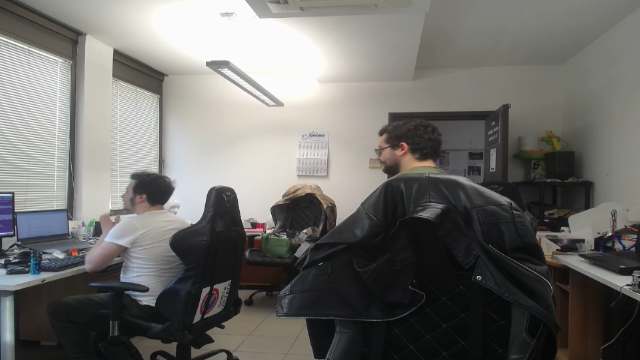
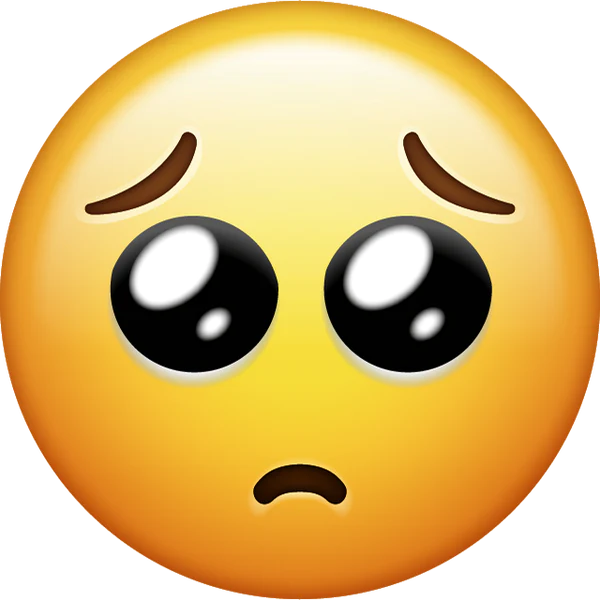

<DisplayHandle display_id=image_display>

START!
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face
Only one face

Only one face
Only one face
Only one face
Only one face


STOP!


In [2]:
def start_demo(arg):
    global stop_thread, stop_video
    stop_thread = False
    stop_video = False
    v = threading.Thread(target=video_function)
    v.start()
    x = threading.Thread(target=mb_function)
    x.start()
    print("START!")

    
def stop_demo(arg):
    global stop_thread, stop_video
    stop_thread = True
    stop_video = True
    print("STOP!")
    
def show_code():
    HTML('''<script>
    code_show=!code_show; 
    ''')

item_layout = Layout(height='100px', min_width='40px')
button_start = Button(description = 'Start demo', icon="play")   
button_start.button_style = 'success'
button_start.style.font_size = "18px"
button_start.on_click(start_demo)
button_stop = Button(description = 'Stop demo', icon="stop")   
button_stop.button_style = 'danger'
button_stop.style.font_size = "18px"
button_stop.on_click(stop_demo)
items = [button_start, button_stop]
box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')
box_auto = Box(children=items, layout=box_layout)

display(VBox([box_auto]))

display_id_html = '<div id="image_display"></div>'
display(HTML(display_id_html), display_id="image_display")


In [3]:

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('pre').hide(); 
 } else {
 $('div.input').show();
 $('pre').show(); 
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')